In [7]:
# ÏµúÏ¥à ÌÅ¨Î°§ÎßÅ

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd
from datetime import datetime
from tqdm import tqdm

def setup_driver():
    """Chrome ÎìúÎùºÏù¥Î≤ÑÎ•º ÏÑ§Ï†ïÌïòÍ≥† Î∞òÌôòÌï©ÎãàÎã§."""
    chrome_driver_path = 'C:\\chromedriver-win64\\chromedriver.exe'
    service = Service(chrome_driver_path)

    options = Options()
    options.add_argument("--disable-notifications")
    options.add_argument("--start-maximized")

    driver = webdriver.Chrome(service=service, options=options)
    return driver

def crawl_blog_posts(search_queries, max_posts_per_query=300, max_pages=10):
    current_time = datetime.now().strftime('%y-%m-%d')
    
    driver = setup_driver()

    all_data = []

    for search_query in search_queries:
        search_query_encoded = search_query.replace(' ', '+')  # Í≤ÄÏÉâÏñ¥Î•º URL Ïù∏ÏΩîÎî©
        url_template = f'https://section.blog.naver.com/Search/Post.naver?pageNo={{}}&rangeType=ALL&orderBy=sim&keyword={search_query_encoded}'
        
        url_list = []
        title_list = []
        seen_urls = set()  # Ï§ëÎ≥µ ÌôïÏù∏ÏùÑ ÏúÑÌïú ÏßëÌï©(Set)

        for page in range(1, max_pages + 1):
            search_url = url_template.format(page)
            driver.get(search_url)
            time.sleep(3)
            
            try:
                # Î∏îÎ°úÍ∑∏ Í∏Ä Ï†úÎ™©Í≥º URL ÏàòÏßë
                article_raw = driver.find_elements(By.CSS_SELECTOR, '.info_post .desc a')
                
                if not article_raw:
                    print(f"ÌéòÏù¥ÏßÄ {page}ÏóêÏÑú Î∏îÎ°úÍ∑∏ Ìè¨Ïä§Ìä∏Î•º Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")
                    break
                
                for article in article_raw:
                    url = article.get_attribute('href')
                    
                    # Ïù¥ÎØ∏ ÏàòÏßëÎêú URLÏù∏ÏßÄ ÌôïÏù∏ (Ï§ëÎ≥µ Ï†úÍ±∞)
                    if url in seen_urls:
                        continue  # Ï§ëÎ≥µÎêú URLÏùÄ Î¨¥Ïãú
                    
                    seen_urls.add(url)  # ÏÉàÎ°úÏö¥ URLÏùÄ ÏßëÌï©Ïóê Ï∂îÍ∞Ä
                    
                    title_element = article.find_element(By.XPATH, './strong')
                    title = title_element.text
                    url_list.append(url)
                    title_list.append(title)

                    if len(url_list) >= max_posts_per_query:
                        break
                
                if len(url_list) >= max_posts_per_query:
                    break
            except Exception as e:
                print(f"ÌéòÏù¥ÏßÄ {page}ÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: {e}")
                continue
        
        # ÏàòÏßëÌïú URLÍ≥º Ï†úÎ™©ÏùÑ DataFrameÏóê Ï†ÄÏû•
        df = pd.DataFrame({'Ï£ºÏÜå': url_list, 'Ï†úÎ™©': title_list})
        
        # ÌÅ¨Î°§ÎßÅÌïú ÎÇ¥Ïö©ÏùÑ Ìè¨Ìï®Ìïú DataFrameÏùÑ Excel ÌååÏùºÎ°ú Ï†ÄÏû•
        df['Í≤ÄÏÉâÏñ¥'] = search_query
        df['ÏûëÏÑ±ÏùºÏûê'] = None
        df['ÌÉúÍ∑∏'] = None
        df['ÎÇ¥Ïö©'] = None

        number = len(df)

        for i in tqdm(range(number), desc=f"Crawling: {search_query}"):
            url = df['Ï£ºÏÜå'][i]
            driver.get(url)    
            time.sleep(3)

            try:
                # Î∏îÎ°úÍ∑∏ Î≥∏Î¨∏ iframeÏúºÎ°ú Ï†ÑÌôò
                WebDriverWait(driver, 10).until(
                    EC.frame_to_be_available_and_switch_to_it((By.ID, 'mainFrame'))
                )

                # Ï†úÎ™© Ï∂îÏ∂ú
                tit = driver.find_element(By.CSS_SELECTOR, '.se-module.se-module-text.se-title-text')
                title = tit.text

                # ÎÇ†Ïßú Î∞è ÏãúÍ∞Ñ Ï∂îÏ∂ú
                date = driver.find_element(By.CSS_SELECTOR, '.se_publishDate.pcol2')
                datetime_text = date.text

                df.at[i, 'ÏûëÏÑ±ÏùºÏûê'] = datetime_text

                # ÌÉúÍ∑∏ Ï∂îÏ∂ú
                tags = driver.find_elements(By.CSS_SELECTOR, '.wrap_tag .ell')
                tag_list = [tag.text for tag in tags]
                tag_str = ' '.join(tag_list)
                df.at[i, 'ÌÉúÍ∑∏'] = tag_str

                # ÎÇ¥Ïö© Ï∂îÏ∂ú
                contents = driver.find_elements(By.CSS_SELECTOR, '.se-module.se-module-text')
                content_list = [content.text for content in contents]
                content_str = ' '.join(content_list)
                df.at[i, 'ÎÇ¥Ïö©'] = content_str

                print(f"{i}Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: {title}")

            except Exception as e:
                print(f"{i}Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: {e}")
                continue

        all_data.append(df)

    all_df = pd.concat(all_data, ignore_index=True)
    all_df.to_excel(f"../data/ÏµúÏ¥àÌÅ¨Î°§ÎßÅ_{current_time}.xlsx", index=False)

    print("ÏàòÏßëÌïú Í∏Ä Í∞ØÏàò:", len(all_df.dropna(subset=['ÎÇ¥Ïö©'])))

    driver.quit()

# Ìï®Ïàò Ìò∏Ï∂ú ÏòàÏ†ú
search_queries = ['ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§']
crawl_blog_posts(search_queries, max_posts_per_query=500, max_pages=500)

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   0%|                                                     | 1/500 [00:27<3:49:26, 27.59s/it]

0Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏùµÏÑ†Îèô ÌïúÏò•Í±∞Î¶¨ Îç∞Ïù¥Ìä∏ ÏΩîÏä§ ÏùµÏÑ†ÎèôÎßõÏßë Ïù¥Ï∏µÏñëÏò• Ï±ÑÎÅùÎì±Ïã¨Í≥º Îá®ÎÅº


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   0%|‚ñè                                                    | 2/500 [00:32<1:58:31, 14.28s/it]

1Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î∏åÎùºÏù¥Ìäº Ïó¨ÏùòÎèÑ ÏÑ†ÏûÑÎåÄ ÌõÑÎ∂ÑÏñë ÏÑúÏö∏ Ìï´ ÌîåÎ†àÏù¥Ïä§ Ïó¨ÏùòÎèÑ Íµ≠Ï†úÍ∏àÏúµ ÏßÄÍµ¨ Ïã†Ï∂ï Î∂ÑÏñë ÏÜåÏãù ÏûÖÎãàÎã§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   1%|‚ñé                                                    | 3/500 [00:58<2:44:13, 19.83s/it]

2Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïö©ÏÇ∞Îç∞Ïù¥Ìä∏ Ïö©Î¶¨Îã®Í∏∏ Î∏åÎü∞Ïπò ÎßõÏßë Ïå§Ïå§Ïå§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   1%|‚ñç                                                    | 4/500 [01:03<1:52:48, 13.65s/it]

3Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏïàÍµ≠ ÎßõÏßë Ïò®6.5 ÍπÄÏπò Îã§Ïù¥Îãù ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   1%|‚ñå                                                    | 5/500 [01:07<1:23:49, 10.16s/it]

4Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨Ïûê ÌòºÏûêÎÜÄÍ∏∞ ÏÑúÏö∏ Ïó¨Ìñâ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏòÅÎì±Ìè¨Íµ¨Ï≤≠Ïó≠ Ïπ¥Ìéò Îß®ÌôÄÏª§Ìîº Ïõ®Ïä§ÌÑ¥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   1%|‚ñã                                                    | 6/500 [01:12<1:10:13,  8.53s/it]

5Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î™ÖÎèôÏó≠ Ïπ¥Ìéò ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î∏åÎ†àÎîîÌè¨Ïä§Ìä∏ ÎîîÏ†ÄÌä∏ ÌîÑÎ†àÏ¶ê


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   1%|‚ñä                                                      | 7/500 [01:16<58:07,  7.07s/it]

6Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎöùÏÑ¨ ÌïúÍ∞ïÍ≥µÏõê 2024 ÏÑúÏö∏Íµ≠Ï†úÏ†ïÏõêÎ∞ïÎûåÌöå Ïù∏ÏÇ¨Ïù¥Îìú ÏïÑÏõÉ Í∞ÄÎì† ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   2%|‚ñâ                                                      | 8/500 [01:20<50:29,  6.16s/it]

7Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏôïÏã≠Î¶¨ ÌïúÏñëÎåÄ ÎßõÏßë Ï†úÏùºÍ≥±Ï∞Ω ÎßõÏûàÎäî ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   2%|‚ñâ                                                      | 9/500 [01:25<47:19,  5.78s/it]

8Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïä§ÌÉÄÎ≤ÖÏä§ Í≤ΩÎèô1960 Îç∞Ïù¥Ìä∏ ÏΩîÏä§ Í≤®Ïö∏ ÎèôÎåÄÎ¨∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   2%|‚ñà                                                   | 10/500 [01:42<1:15:48,  9.28s/it]

9Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞àÍ≥≥ Ïù¥ÏÉâ Îç∞Ïù¥Ìä∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑúÏö∏ Ïπ¥Ìéò Ïä§ÌÉÄÎ≤ÖÏä§ Í≤ΩÏÑ± 1960 Ï†ê


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   2%|‚ñà‚ñè                                                  | 11/500 [01:47<1:04:44,  7.94s/it]

10Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï≤≠Í≥ÑÏ≤ú Íµ¨Í≤Ω,Ï¢ÖÎ°ú Í¥ëÌôîÎ¨∏ÏÇ∞Ï±Ö


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   2%|‚ñà‚ñé                                                    | 12/500 [01:53<59:00,  7.25s/it]

11Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏãúÌã∞Î∑∞ 1Ïó¥ Ï∞ΩÏã†Îèô Ìï´ÌîåÎ†àÏù¥Ïä§ Ïπ¥Ìéò ÌÖåÎ•¥Ìä∏Î•¥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   3%|‚ñà‚ñç                                                    | 13/500 [01:57<50:51,  6.27s/it]

12Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏñëÏû¨ Í≥†Í∏∞Ïßë ÌïúÏö∞ Ï†ÑÎ¨∏ ÏñëÎ∞òÎì±Ïã¨, ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   3%|‚ñà‚ñå                                                    | 14/500 [02:01<45:49,  5.66s/it]

13Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í≥ÑÎã®Ïßë ÌöåÌòÑÏó≠üè° ÎÇ®ÏÇ∞ Í∑ºÏ≤ò ÏòàÏÅú Ïπ¥Ìéò Í≥ß ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Îê† ÎìØ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   3%|‚ñà‚ñå                                                    | 15/500 [02:05<42:08,  5.21s/it]

14Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ ÏïïÍµ¨Ï†ïÎ°úÎç∞Ïò§Í±∞Î¶¨ Îç∞Ïù¥Ìä∏ ÎßõÏßë Ï≤≠Îã¥Í≥†Ïàò


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   3%|‚ñà‚ñã                                                    | 16/500 [02:10<39:56,  4.95s/it]

15Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏïàÍµ≠Ïó≠ Ïπ¥Ìéò ÎèÑÌÜ†Î¶¨Í∞ÄÎì† ÏßÄÎ∏åÎ¶¨Í∞êÏÑ± Î∏åÎü∞Ïπò Ïã§ÎÇ¥Îç∞Ïù¥Ìä∏ ÏÑúÏö∏ ÏßÄÌïòÏ≤† Ïó¨Ìñâ ÎÜÄÍ±∞Î¶¨ Ï¢ÖÎ°ú Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   3%|‚ñà‚ñä                                                    | 17/500 [02:15<40:46,  5.07s/it]

16Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎπõÏùò ÏãúÏñ¥ÌÑ∞ ÌÅ¨Î¶¨Ïä§ÎßàÏä§ Ïã§ÎÇ¥ Îç∞Ïù¥Ìä∏ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   4%|‚ñà‚ñâ                                                    | 18/500 [02:19<38:16,  4.77s/it]

17Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïû†Ïã§ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑúÏö∏ Î≤öÍΩÉ Ïû†Ïã§ ÏÑùÏ¥åÌò∏Ïàò Î≤öÍΩÉÏ∂ïÏ†ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   4%|‚ñà‚ñà                                                    | 19/500 [02:23<36:04,  4.50s/it]

18Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏùÑÏßÄÎ°ú3Í∞Ä ÏïÑÎ©îÎ¶¨Ïπ∏ Ìï´ÎèÑÍ∑∏ ÎßõÏßë Ïò¨ÎîîÏä§Ìï´ÎèÑÍ∑∏ Ïπ†Î¶¨Ìï´ÎèÑÍ∑∏ÏÑ∏Ìä∏ ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   4%|‚ñà‚ñà‚ñè                                                   | 20/500 [02:28<37:12,  4.65s/it]

19Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌôçÏ≤†Ï±ÖÎπµ Ïö©ÏÇ∞ ÏÑúÏö∏Ïó≠Ïπ¥Ìéò Îç∞Ïù¥Ìä∏ ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   4%|‚ñà‚ñà‚ñé                                                   | 21/500 [02:32<35:40,  4.47s/it]

20Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎûúÎìúÎßàÌÅ¨ üåï ÏÑúÏö∏Îã¨ (Ïó¨ÏùòÎèÑ Îç∞Ïù¥Ìä∏ÏΩîÏä§ Ï∂îÏ≤ú üíõ)


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   4%|‚ñà‚ñà‚ñç                                                   | 22/500 [02:37<35:57,  4.51s/it]

21Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ìä§Î¶Ω Í∞ÄÎìù ÏïºÏô∏ Îç∞Ïù¥Ìä∏ ÏÑ±ÏàòÎèô ÏÑúÏö∏Ïà≤ ÎèóÏûêÎ¶¨ ÌîºÌÅ¨Îãâ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   5%|‚ñà‚ñà‚ñç                                                   | 23/500 [02:41<34:33,  4.35s/it]

22Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÑ±ÏàòÎèô Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÇ∞Ï±Ö. Ìè¨Ïù∏Ìä∏Ïò§Î∏åÎ∑∞. Ïπ¥Ìéò ÏéàÎäê. ÎîîÏò¨ ÏÑ±Ïàò Îì±


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   5%|‚ñà‚ñà‚ñå                                                   | 24/500 [02:45<34:09,  4.31s/it]

23Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎùºÎÑ§Ï¶à Ìë∏Î∞îÏò§ ÏÑ±Ïàò ÎÜÄÍ±∞Î¶¨ ÌåùÏóÖ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   5%|‚ñà‚ñà‚ñã                                                   | 25/500 [02:49<33:35,  4.24s/it]

24Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í¥ëÌôîÎ¨∏ Í¥ëÏû• Î≥ºÍ±∞Î¶¨ ÎÜÄÍ±∞Î¶¨ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏïÑÏù¥ÏôÄ ÏïºÏô∏ Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   5%|‚ñà‚ñà‚ñä                                                   | 26/500 [02:54<35:02,  4.44s/it]

25Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÎåÄÎ¨∏ ÎùΩÌù¨Ïïà Í∞ÄÏ¢åÎ≥∏Ï†ê ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÍøîÎ∞îÎ°úÏö∞ ÎßõÏßë


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   5%|‚ñà‚ñà‚ñâ                                                   | 27/500 [02:58<34:48,  4.42s/it]

26Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏïïÍµ¨Ï†ïÎ°úÎç∞Ïò§Í±∞Î¶¨ ÌîÑÎ°¨Ìó§ÎùºÏä§ Ïπ¥Ìéò Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   6%|‚ñà‚ñà‚ñà                                                   | 28/500 [03:03<34:47,  4.42s/it]

27Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏàúÎùºÍ∏∏ ÏïºÏû• ÎßõÏßë ÏùµÏÑ†Îèô Í≥µÎ∞© Îç∞Ïù¥Ìä∏ ÏÑúÏö∏ Ï¢ÖÎ°ú Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   6%|‚ñà‚ñà‚ñà‚ñè                                                  | 29/500 [03:08<36:22,  4.63s/it]

28Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïπ¥Ìéò Í≤ΩÎèôÏãúÏû• Ïä§ÌÉÄÎ≤ÖÏä§ Í≤ΩÎèô1960 Í∏àÏÑ±Ï†ÑÌååÏÇ¨


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   6%|‚ñà‚ñà‚ñà‚ñè                                                  | 30/500 [03:12<36:00,  4.60s/it]

29Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïã§ÎÇ¥Îç∞Ïù¥Ìä∏ÏΩîÏä§ ÌÖåÎîîÎµàÎ•¥ÌïòÏö∞Ïä§ ÎßõÏûàÎäîÎπµÏßë Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄ Ìï´ÌîåÎ†àÏù¥Ïä§,Î¨¥Î£åÏ£ºÏ∞®


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   6%|‚ñà‚ñà‚ñà‚ñé                                                  | 31/500 [03:17<36:14,  4.64s/it]

30Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: üá≠üá∞ÌôçÏΩ©Í∞êÏÑ± ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï∞ΩÏã†Îèô Ï∞ΩÏ∞Ωüá≠üá∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   6%|‚ñà‚ñà‚ñà‚ñç                                                  | 32/500 [03:22<36:39,  4.70s/it]

31Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§]ÏòÅÏ¢ÖÎèÑ Ïù∏Ïä§ÌååÏù¥Ïñ¥ Î≥µÌï© Î¶¨Ï°∞Ìä∏ Î∞©Î¨∏Í∏∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   7%|‚ñà‚ñà‚ñà‚ñå                                                  | 33/500 [03:27<37:48,  4.86s/it]

32Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÎçîÌòÑÎåÄÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÌÅ¨Î¶¨Ïä§ÎßàÏä§ÎßàÏùÑ ÏàòÏ†úÎ≤ÑÍ±∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   7%|‚ñà‚ñà‚ñà‚ñã                                                  | 34/500 [03:34<41:32,  5.35s/it]

33Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏùÑÏßÄÎ°ú Î£®ÌîÑÌÉë ÎßõÏßë Ìñâ2PM8PMÏôÄÏù∏Î∞î


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   7%|‚ñà‚ñà‚ñà‚ñä                                                  | 35/500 [03:38<38:34,  4.98s/it]

34Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑúÏàúÎùºÍ∏∏ ÎßõÏßë ÌÖåÎùºÏä§ Ïà†Ïßë Ïà†24 ÎÇ¥ÎèàÎÇ¥ÏÇ∞ ÏÜîÏßÅÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   7%|‚ñà‚ñà‚ñà‚ñâ                                                  | 36/500 [03:42<36:17,  4.69s/it]

35Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥_ÌçºÎ∏îÎ¶≠Í∞ÄÏÇ∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   7%|‚ñà‚ñà‚ñà‚ñâ                                                  | 37/500 [03:46<35:06,  4.55s/it]

36Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎèôÎåÄÎ¨∏ ÎîîÏûêÏù∏ ÌîåÎùºÏûê ÎÜÄÍ±∞Î¶¨ DDP ÎîîÏûêÏù∏ Ïä§ÌÜ†Ïñ¥ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   8%|‚ñà‚ñà‚ñà‚ñà                                                  | 38/500 [03:50<34:33,  4.49s/it]

37Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïã†ÏÑ∏Í≥Ñ Í∞ïÎÇ®Ï†ê BTS ÌÉÄÏù¥ÎãàÌÉÑ ÌÜ†Ïù¥Ïä§ÌÜ†Î¶¨ ÌåùÏóÖÏä§ÌÜ†Ïñ¥ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   8%|‚ñà‚ñà‚ñà‚ñà‚ñè                                                 | 39/500 [03:54<32:39,  4.25s/it]

38Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î¨∏ÎûòÏ∞ΩÏûëÏ¥å Ïπ¥Ìéò ÏòÅÎì±Ìè¨ Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   8%|‚ñà‚ñà‚ñà‚ñà‚ñé                                                 | 40/500 [03:58<33:06,  4.32s/it]

39Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ Ïö©ÏÇ∞ Ïö©Î¶¨Îã®Í∏∏ Ïπ¥Ìéò ÎπµÏßÄÏàúÎ°Ä Ïπ¥Ìéò Î™®Ïùå


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   8%|‚ñà‚ñà‚ñà‚ñà‚ñç                                                 | 41/500 [04:06<39:26,  5.16s/it]

40Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í≤ΩÎ≥µÍ∂ÅÏùò Í∞ÄÏùÑ, ÏÑúÏö∏ Ìï´ ÌîåÎ†àÏù¥Ïä§! Í¥ëÌôîÎ¨∏Í¥ëÏû•ÏóêÏÑú Í≤ΩÎ≥µÍ∂ÅÍπåÏßÄ ÏÑúÏö∏ Ïó¨Ìñâ ÏΩîÏä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   8%|‚ñà‚ñà‚ñà‚ñà‚ñå                                                 | 42/500 [04:10<38:37,  5.06s/it]

41Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑúÏö∏ Ïπ¥Ìéò Î™ÖÎèô Îç∞Ïù¥Ìä∏ ÎÜÄÍ±∞Î¶¨ ÎçîÏä§ÌåüÌå®Î∑∏Îü¨Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   9%|‚ñà‚ñà‚ñà‚ñà‚ñã                                                 | 43/500 [04:15<36:56,  4.85s/it]

42Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌÅ¨Î¶¨Ïä§ÎßàÏä§ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑúÏö∏ ÏΩîÏóëÏä§ Î≥ÑÎßàÎãπÎèÑÏÑúÍ¥Ä Ìä∏Î¶¨ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   9%|‚ñà‚ñà‚ñà‚ñà‚ñä                                                 | 44/500 [04:19<34:43,  4.57s/it]

43Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2024 ÏÑúÏö∏ Ï∂ïÏ†ú ÏÑúÏö∏ÏΩò ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎèôÎåÄÎ¨∏DDP ÎØ∏Î¶¨Î≥¥Í∏∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   9%|‚ñà‚ñà‚ñà‚ñà‚ñä                                                 | 45/500 [04:23<33:13,  4.38s/it]

44Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ï¢ÖÎ°ú Îç∞Ïù¥Ìä∏ ÏΩîÏä§ ÏÑúÏàúÎùºÍ∏∏ ÏïºÏû• Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   9%|‚ñà‚ñà‚ñà‚ñà‚ñâ                                                 | 46/500 [04:27<33:48,  4.47s/it]

45Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Îü≠ÏÖîÎ¶¨ ÌÅ¨Î¶¨Ïä§ÌÉà Î∞îÏπ¥ÎùºxÌïÑÎ¶ΩÏä§ÌÉÅ Î©îÏ¢ÖÎ∞îÎùºÏπ¥ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï†ÑÏãú ÎßåÎÇòÏöî


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:   9%|‚ñà‚ñà‚ñà‚ñà‚ñà                                                 | 47/500 [04:32<33:58,  4.50s/it]

46Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Îç∞Ïù¥Ìä∏ ÎßàÌÖåÏò§Í≤¨Î¨∏Î°ù ÌïúÎÇ®Îèô Ìï´Ìîå Î≥¥ÎãêÎùºÏ∏ÑÎü¨Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                | 48/500 [04:38<37:27,  4.97s/it]

47Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïö∞Ïù¥Ï≤ú Î≤öÍΩÉ Ï∂ïÏ†ú Ïã§ÏãúÍ∞Ñ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                | 49/500 [04:42<36:01,  4.79s/it]

48Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ìï¥Î∞©Ï¥å Ïã†Ìù•ÏãúÏû• ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ Ïö©ÏÇ∞ Ìï¥Î∞©Ï¥å Îç∞Ïù¥Ìä∏ Ïù¥ÌÉúÏõê ÏÜåÌíàÏÉµ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                | 50/500 [04:46<34:25,  4.59s/it]

49Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌòºÏûê Íµ≠ÎÇ¥ÎöúÎ≤ÖÏù¥Ïó¨Ìñâ ÏÇ¨ÏßÑÏ∞çÍ∏∞Ï¢ãÏùÄ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎèôÎ¨ò Íµ¨Ï†úÎ≤ºÎ£©ÏãúÏû•


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                              | 51/500 [05:12<1:20:27, 10.75s/it]

50Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑ±Ïàò ÏÜåÌíàÏÉµ Ïò§Î°§Î¶¨Îç∞Ïù¥ Ìï¥ÌîºÏñ¥ÎßàÌä∏ ÏÑ±ÏàòÏ†ê ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                              | 52/500 [05:20<1:15:04, 10.06s/it]

51Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑ±ÏàòÎèô LCDC ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Îç∞Ïù¥Ìä∏ÏΩîÏä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                              | 53/500 [05:24<1:01:16,  8.22s/it]

52Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Í±¥ÎåÄÏûÖÍµ¨Ïó≠ Ïπ¥Ìéò ÌùêÎ¶á Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                | 54/500 [05:29<53:19,  7.17s/it]

53Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎöùÏÑ¨ÌïúÍ∞ïÍ≥µÏõê Ïù∏ÏÇ¨Ïù¥ÎìúÏïÑÏõÉ Í∞ÄÎì† ÏúÑÏπò Ìè¨ÌÜ†Ï°¥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                | 55/500 [05:33<46:30,  6.27s/it]

54Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏòÅÎì±Ìè¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Î¨∏Îûò Ï∞ΩÏûëÏ¥å ÎÜÄÍ±∞Î¶¨


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                | 56/500 [05:38<43:11,  5.84s/it]

55Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î™ÖÎèô Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ LP Ïπ¥Ìéò ÌõÑÎ°úÏïÑ ÏÑúÏö∏


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                               | 57/500 [05:42<38:55,  5.27s/it]

56Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Îã§Ïãú ÎèåÏïÑÏò® ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎÇôÏÇ∞Í≥µÏõê Îã§ÎùΩ, ÌÖåÎùºÏä§ Ïπ¥Ìéò Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                               | 58/500 [05:45<35:51,  4.87s/it]

57Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï©Ï†ïÏó≠ ÏπµÌÖåÏùºÎ∞î Ìï´ÌîåÎ†àÏù¥Ïä§ Î∂ÑÏúÑÍ∏∞ Ï¢ãÏùÄ Ïà†Ïßë ‚ÄòÎîîÏó†‚Äô


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                               | 59/500 [05:49<33:34,  4.57s/it]

58Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏòàÏÅú Î∏åÎü∞Ïπò Ïπ¥Ìéò Ìï´ÌîåÎ†àÏù¥Ïä§ ÎùºÎÆ§Ï¶à


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                               | 60/500 [05:53<32:33,  4.44s/it]

59Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏáºÌïë Ìï´ÌîåÎ†àÏù¥Ïä§ Î™ÖÎèô Î≥ºÍ±∞Î¶¨ Ïä§ÎàÑÌîº ÏÜåÌíàÏÉµ Ìà¨Ïñ¥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                               | 61/500 [05:58<32:43,  4.47s/it]

60Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î∏åÎ†àÎîîÌè¨Ïä§Ìä∏ ÏÑ±Ïàò ÎÇòÌòºÏûêÏÇ∞Îã§ ÎπµÏßë ÏßÑÏßÄÌù¨ ÌîÑÎ†àÏ≤º


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                               | 62/500 [06:03<34:24,  4.71s/it]

61Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ ÎØ∏ÎØ∏ÎØ∏Ïπ¥Ìéò ÏïïÍµ¨Ï†ïÎç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                               | 63/500 [06:08<33:37,  4.62s/it]

62Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï§ëÍµ¨ ÏùÑÏßÄÎ°ú ÏÑ∏Ïö¥ÎåÄÎ¶ºÏÉÅÍ∞Ä ÎîîÏ†ÄÌä∏Í∞ÄÍ≤å Íµ¨ÏõÄÏñëÍ≥º


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                               | 64/500 [06:15<39:26,  5.43s/it]

63Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄ Ïó¨ÌñâÏßÄ ÎßàÍ≥°ÏÑúÏö∏ÏãùÎ¨ºÏõê ÎÇ≠ÎßåÏàòÍµ≠Ï†Ñ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                               | 65/500 [06:20<37:25,  5.16s/it]

64Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎπÑÏò§ÎäîÎÇ† Îç∞Ïù¥Ìä∏ ÏÑ±ÏàòÎèôÏÑúÏö∏Ïà≤ Ïª¥Ïò§ÌîÑ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                              | 66/500 [06:25<37:33,  5.19s/it]

65Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïπ¥Ìéò Ï†úÍ∏∞Îèô Ï†ÑÌÜµÏãúÏû•Ïïà Í≤ΩÎèô1960 Ïä§ÌÉÄÎ≤ÖÏä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                              | 67/500 [06:28<34:04,  4.72s/it]

66Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïùò Ìï´ÌîåÎ†àÏù¥Ïä§ ÎßõÏßë


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                              | 68/500 [06:34<34:43,  4.82s/it]

67Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ Ïó∞ÎÇ®ÎèôÎç∞Ïù¥Ìä∏ Ïπ¥Ïù¥ÎßâÎßõÏßë ÎØ∏ÌÅ¨ÌîåÎ°ú Ïó∞Ìä∏Îü¥ÌååÌÅ¨Ï†ê


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                              | 69/500 [06:37<32:34,  4.54s/it]

68Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨ÌñâÏßÄ ÌåùÏóÖÏä§ÌÜ†Ïñ¥ ÏÑ±Ïàò Ìï´ÌîåÎ†àÏù¥Ïä§ Îç∞Ïù¥Ìä∏ÏΩîÏä§ ÎÜÄÍ±∞Î¶¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                              | 70/500 [06:42<32:31,  4.54s/it]

69Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïû†Ïã§ ÏÑùÏ¥åÌò∏Ïàò vs Ïó¨ÏùòÎèÑ Ïú§Ï§ëÎ°ú Î≤öÍΩÉ ÎßåÍ∞ú Ïã§ÏãúÍ∞Ñ Î≤öÍΩÉÎ™ÖÏÜå


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                              | 71/500 [06:46<31:34,  4.42s/it]

70Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î™ÖÏÜå Í∞ïÎÇ® ÎÜÄÍ≥≥ Í∞àÍ≥≥ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎßõÏßë ÏïïÍµ¨Ï†ïÏó≠ Î°úÎ∞îÎã§ÏïºÎÅº Î∞©Ï∂î


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                              | 72/500 [06:50<30:34,  4.29s/it]

71Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎÜÄÍ±∞Î¶¨ Ï∂©Î¨¥Î°úÏó≠ Í∞ÄÎß•Ïà†Ïßë Ìù¨ÏïºÏäàÌçº


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                              | 73/500 [06:55<32:45,  4.60s/it]

72Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÎÜÄÍ±∞Î¶¨ Î≥ºÍ±∞Î¶¨ ÎßéÏùÄ Ìï´ÌîåÎ†àÏù¥Ïä§ Î∞±ÌôîÏ†ê


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                              | 74/500 [06:59<31:18,  4.41s/it]

73Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ 2024 ÏÑúÏö∏Íµ≠Ï†úÏ†ïÏõêÎ∞ïÎûåÌöå 100Î∞∞ Ï¶êÍ∏∞Îäî Î≤ï! Ï£ºÎßê ÎÇòÎì§Ïù¥Îäî ÎöùÏÑ¨ÌïúÍ∞ïÍ≥µÏõê Ïñ¥ÎïåÏöî?


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                              | 75/500 [07:03<29:33,  4.17s/it]

74Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: MZÏÑ∏ÎåÄÍ∞Ä Í∞ÄÏû• ÎßéÏù¥ Ï∞æÏùÄ ÏÑúÏö∏Ïùò Ìï´ÌîåÎ†àÏù¥Ïä§Îäî?


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                             | 76/500 [07:08<31:08,  4.41s/it]

75Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Îç∞Ïù¥Ìä∏Ï∂îÏ≤ú Ïû•ÏÜå Î¨∏ÎûòÏ∞ΩÏûëÏ¥å Ìï´ÌîåÎ†àÏù¥Ïä§ Ïπ¥Ìéò ÎÜÄÍ±∞Î¶¨


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                             | 77/500 [07:12<30:07,  4.27s/it]

76Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ Ïó∞ÎÇ®Îèô Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥, Í≤ΩÏùòÏÑ†Ïà≤Í∏∏ Ïª§Îì§Î£∏ Ïó∞ÎÇ®


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                             | 78/500 [07:15<28:30,  4.05s/it]

77Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2024 ÏòÅÏñëÍ≥†Ï∂î H.O.T ÌéòÏä§Ìã∞Î≤å ÏÑúÏö∏Í¥ëÏû• ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïù¥ÏÉâ Ï≤¥Ìóò Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                             | 79/500 [07:20<29:17,  4.18s/it]

78Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Í≥†Ïö∞ÏÑ±Ïàò ÏÑ±ÏàòÎèôÎç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                             | 80/500 [07:25<31:57,  4.57s/it]

79Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î™ÖÎèô Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏúÑÍ∏ÄÏúÑÍ∏ÄÏßë


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                           | 81/500 [07:52<1:17:18, 11.07s/it]

80Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Review_ÏÑúÏö∏ Í∞ïÎÇ® Ìï´ÌîåÎ†àÏù¥Ïä§ "Ïπ¥Ïπ¥Ïò§ÌîÑÎ†åÏ¶à Í∞ïÎÇ®ÌîåÎûòÍ∑∏Ïã≠ Ïä§ÌÜ†Ïñ¥"


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                           | 82/500 [07:58<1:07:07,  9.64s/it]

81Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïã†ÎãπÏó≠ Ìï´ÌîåÎ†àÏù¥Ïä§ ÌîºÏàúÎåÄ ÎßõÏßë Ï†ÑÏ£ºÏàúÎåÄÍµ≠ Ï£ºÎßê ÌÜ†ÏöîÏùº Ïõ®Ïù¥ÌåÖ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                             | 83/500 [08:02<54:53,  7.90s/it]

82Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏöîÏïÑÏ†ï ÍøÄÏ°∞Ìï© Ï∂îÏ≤ú ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ +Îúª


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                             | 84/500 [08:06<46:12,  6.67s/it]

83Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÌôçÎåÄ Í≤åÎ¶¥ÎùºÌè¨Ïä§ÌÑ∞ ÏßÑÌñâÏÇ¨Î°Ä


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                            | 85/500 [08:09<40:15,  5.82s/it]

84Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Í∞ïÎÇ®Ïó≠ Îç∞Ïù¥Ìä∏ ÎÜÄÍ±∞Î¶¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏïÑÌä∏Î™¨Ïä§ÌÑ∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                            | 86/500 [08:13<36:06,  5.23s/it]

85Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Í≥µÏßÄ] Îã®Îèà 3ÎßåÏõêÏúºÎ°ú ÏÑúÏö∏ ÏïÑÌååÌä∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï†ïÎ≥µÌïòÍ∏∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                            | 87/500 [08:18<34:43,  5.05s/it]

86Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏïïÍµ¨Ï†ïÎ°úÎç∞Ïò§Ïó≠ Ïπ¥Ìéò Ïª§ÌîºÏóêÎ∞òÌïòÎã§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                            | 88/500 [08:21<31:29,  4.59s/it]

87Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ ÏãúÏ≤≠] ÏãúÏ≤≠Ïó≠ Í∑ºÏ≤ò Ìï´ÌîåÎ†àÏù¥Ïä§ Ïπ¥Ìéò / Ïä§Î™∞ÍµøÏª§Ìîº ÌîåÎûòÍ∑∏Ïã≠Ïä§ÌÜ†Ïñ¥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                            | 89/500 [08:25<29:49,  4.35s/it]

88Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎπàÌã∞ÏßÄÏ†úÌä∏ ÏÑúÏö∏ ÏÑ±ÏàòÎπàÌã∞ÏßÄÏÉµ ÏÑ±ÏàòÎèô Ìï´ÌîåÎ†àÏù¥Ïä§ ÎπàÌã∞ÏßÄÏã†Î∞ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                            | 90/500 [08:31<32:01,  4.69s/it]

89Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï≤≠Îã¥ ÏñëÍ∞àÎπÑ ÎßàÌååÎëêÎ∂Ä


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                            | 91/500 [08:37<35:56,  5.27s/it]

90Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïû†Ïã§ ÏÑùÏ¥åÌò∏Ïàò Ïπ¥Ìéò ÎãàÏª§Î≤ÑÏª§Î≤†Ïù¥Í∏Ä ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                            | 92/500 [08:44<39:05,  5.75s/it]

91Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î£®ÌîÑÌÉë Î©ãÏßÑ Î¨∏Îûò Ï∞ΩÏûëÏ¥å Ïπ¥Ìéò Ìò∏ÌÖî707 ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                            | 93/500 [08:52<42:59,  6.34s/it]

92Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÇºÍ∞ÅÏßÄ Ïå§Ïå§Ïå§ Ïã†ÏÉÅ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î†àÏä§ÌÜ†Îûë ÏÉòÏÉòÏÉò


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                           | 94/500 [08:56<38:58,  5.76s/it]

93Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑ±ÏàòÎèô ÌîºÏπòÏä§ ÎèÑÏõê ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î≥µÌï©Î¨∏ÌôîÍ≥µÍ∞Ñ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                           | 95/500 [09:01<37:16,  5.52s/it]

94Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌïúÎÇ®Îèô ÎßåÎëê ÎßõÏßë Îã®Îãπ Ïã†ÏÉÅ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                           | 96/500 [09:07<36:48,  5.47s/it]

95Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï≤≠Îã¥ ÏñëÍ∞àÎπÑ Ï©°Î∞îÏ∞®Ïù¥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                           | 97/500 [09:12<35:59,  5.36s/it]

96Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïò¨Î¶ºÌîΩÍ≥µÏõê Îì§ÍΩÉÎßàÎ£® ÏÑúÏö∏ Íµ¨Í≤Ω


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                           | 98/500 [09:17<36:44,  5.48s/it]

97Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïö©ÏÇ∞Ïó≠ Ïè†Ìã∞Ï∫êÎπà Ïπ¥Ìéò ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ÏóêÏÑú Ïª§Ìîº ÌÉÄÏûÑ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                           | 99/500 [09:22<35:32,  5.32s/it]

98Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏúÑÍ∏ÄÏúÑÍ∏Ä ÌåùÏóÖÏä§ÌÜ†Ïñ¥ Ìè¨ÌÜ†Ï°¥ Í∞ÄÎìù


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                          | 100/500 [09:27<33:57,  5.09s/it]

99Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïö©ÏÇ∞ Í∞ÄÏ°±Í≥µÏõê ÎØ∏Íµ∞Í∏∞ÏßÄ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                          | 101/500 [09:32<33:15,  5.00s/it]

100Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑ±ÏàòÎèôÎåÄÎ¶ºÏ∞ΩÍ≥†Í∞§Îü¨Î¶¨


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                          | 102/500 [09:36<31:05,  4.69s/it]

101Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î¨∏ÎûòÏ∞ΩÏûëÏ¥å Î¨∏ÎûòÎèô Ïπ¥Ìéò Î¶¨Ïä§Ìä∏ Ï†ïÎ¶¨Ìï¥Î¥Ñ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                          | 103/500 [09:41<31:38,  4.78s/it]

102Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Í±¥ÎåÄÎç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥, Í±¥ÎåÄÏª§ÌîºÎû© Ïπ¥Ìéò


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                          | 104/500 [09:46<32:06,  4.87s/it]

103Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌîåÎ†àÏù¥Ïù∏ÎçîÎ∞ïÏä§ ÎçîÌòÑÎåÄÏÑúÏö∏ ÏÜåÎãàÏóîÏ†§ ÌåùÏóÖÏä§ÌÜ†Ïñ¥ Í∑ÄÏó¨ÏõåÏöî. ÏÜåÎãàÏóîÏ†§Î£®ÌÇπÎ∞±ÎèÑ ÏûàÎäî Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                         | 105/500 [09:51<32:15,  4.90s/it]

104Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏßÄÌïòÏ≤† ÎöúÎ≤ÖÏù¥Ïó¨Ìñâ ÏÑ±ÏàòÎèôÏàòÏ†úÌôîÍ±∞Î¶¨ Íµ¨Í≤Ω


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                         | 106/500 [09:55<30:38,  4.67s/it]

105Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î¨∏Ï†ïÏó≠ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïù¥ÎÇ¥ÏÑúÏö∏ Îã§Ïù¥ÎãùÎ∞îÏóêÏÑú ÎäêÎÇÄ ÌäπÎ≥ÑÌïú ÌïòÎ£®


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                         | 107/500 [10:00<31:56,  4.88s/it]

106Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï≤≠Îã¥ Ïú†ÎãàÎ≤ÑÏä§ Î∞îÏù¥ Ï†úÏù¥Î¶¥Îùº ÎπµÏßÄÏàúÎ°Ä ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                         | 108/500 [10:04<29:50,  4.57s/it]

107Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó≠ ÏßÅÏû•Ïù∏Ï†êÏã¨ Ìï´ÌîåÎ†àÏù¥Ïä§ 'ÎßàÎùºÍ≥µÎ∞©'


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                         | 109/500 [10:08<27:56,  4.29s/it]

108Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Íº≠ Í∞ÄÎ¥êÏïº Ìï† ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÍπÄÎ∞• ÎßõÏßë, Ïπ¥Î™®Î©î


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                         | 110/500 [10:12<28:20,  4.36s/it]

109Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄ ÏÑúÏö∏ ÎÜÄÍ±∞Î¶¨ Ïã§ÎÇ¥Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï£ºÏ∞®


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                         | 111/500 [10:17<29:10,  4.50s/it]

110Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïö∞Ïù¥ÎèôÏπ¥Ìéò Î∂ÅÌïúÏÇ∞Ïπ¥Ìéò Ïπ¥ÌéòÏÇ∞ÏïÑÎûò


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                         | 112/500 [10:22<29:54,  4.63s/it]

111Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑúÏö∏Ïó≠ Ìè¨Ïª¨Ìè¨Ïù∏Ìä∏ Ïπ¥Ìéò gogo~


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                         | 113/500 [10:28<31:42,  4.92s/it]

112Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎπõÏùò ÏãúÏñ¥ÌÑ∞, 2Í∞úÏõîÍ∞Ñ ÏïµÏΩú Ï†ÑÏãú Ï§ë!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                         | 114/500 [10:31<29:20,  4.56s/it]

113Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïò§ÎäòÏùò ÎßõÏßë | Ïò§ÎäêÎ£®, ÏÑúÏö∏ ÎßõÏßë Ï∂îÏ≤ú, Ìï´ÌîåÎ†àÏù¥Ïä§, ÎßõÏä§ÌÉÄÍ∑∏Îû®


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                        | 115/500 [10:35<27:35,  4.30s/it]

114Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïñ¥Î¶∞Ïù¥ÎÇ† Í∞ÄÎ≥ºÎßåÌïú ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Best 6 Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                        | 116/500 [10:40<28:10,  4.40s/it]

115Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï£ºÎßê ÎÇòÎì§Ïù¥ ÏÑúÏö∏ Í∑ºÍµê Í∞ïÌôî Ìï´ÌîåÎ†àÏù¥Ïä§ ÏïÑÎß§ÎÑ§ Ïπ¥Ìéò Í≥ßÏùÄ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                        | 117/500 [10:45<29:02,  4.55s/it]

116Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î™ÖÎèô ÏÑ±Îãπ Î∑∞ Î£®ÌîÑÌÉë Ïπ¥Ìéò Ïù¥ÌÉàÎ¶¨Ïïà ÏóêÏä§ÌîÑÎ†àÏÜå Î∞î Î™∞Îòê ÏÑúÏö∏ Ï§ëÍµ¨ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎÜÄÎü¨Í∞à Í≥≥ ( Î©îÎâ¥ ÎîîÏ†ÄÌä∏ )


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                        | 118/500 [10:50<30:46,  4.83s/it]

117Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑ±Ïàò Ïò§Î†àÏò§ ÌåùÏóÖ Ïä§ÌÜ†Ïñ¥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                        | 119/500 [10:54<28:58,  4.56s/it]

118Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÉùÏÉùÏ†ïÎ≥¥ÌÜµ Ï¢ÖÎ°ú5Í∞Ä Í≥±Ï∞ΩÍ≥®Î™© Í≥±Ï∞ΩÏßë ÌÉùÎ∞∞ Ï£ºÎ¨∏ ÎçîÏö∞Î¶¨Í≥±Ï∞Ω ÏòàÏÇ∞ÏßëÍ≥±Ï∞Ω Ìï´ÌîåÎ†àÏù¥Ïä§ Now Ìï®ÎÇ®Í≥±Ï∞Ω ÏÑúÏö∏Í≥±Ï∞Ω Ìò∏ÎÇ®Í≥±Ï∞Ω


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                        | 120/500 [10:59<30:21,  4.79s/it]

119Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë Ïó¨ÏôïÎñ°Î≥∂Ïù¥ÏôÄ Î≥ºÍ±∞Î¶¨


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                      | 121/500 [11:24<1:08:58, 10.92s/it]

120Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                      | 122/500 [11:31<1:00:00,  9.53s/it]

121Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑúÏö∏ÎèÑÏã¨ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï¢ÖÎ°úÍµ¨ ÏùµÏÑ†ÎèôÌïúÏò•Í±∞Î¶¨


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                        | 123/500 [11:36<51:36,  8.21s/it]

122Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Í¥ÄÍ¥ëÏßÄ ÏÑúÏö∏ ÎãπÏùºÏπòÍ∏∞ ÎÜÄÎßåÌïúÍ≥≥ Ïù∏ÏÇ¨Îèô


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                       | 124/500 [11:43<49:23,  7.88s/it]

123Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó≠ Ïπ¥Ìéò) ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ Ìè¨Ïª¨Ìè¨Ïù∏Ìä∏ ÏÑúÏö∏ÌååÏù¥ÎßõÏßë


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                       | 125/500 [11:50<48:01,  7.68s/it]

124Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïö©ÏÇ∞Í≥µÏõê Î∂ÄÎ∂ÑÍ∞úÎ∞©Î∂ÄÏßÄ ÎØ∏Íµ∞Í∏∞ÏßÄ Í∞ÄÎäîÎ≤ï, Ìè¨ÌÜ†Ï°¥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                       | 126/500 [11:56<44:18,  7.11s/it]

125Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎèÑÏÇ∞Í≥µÏõê ÌÇ§ÎßàÏä§Ïãú Ï≤≠Îã¥ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                       | 127/500 [12:00<39:16,  6.32s/it]

126Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑ±Ïàò Ïà†Ïßë | ÏÑúÏö∏Î∏åÎ£®Ïñ¥Î¶¨ ÏÑ±Ïàò ÌïòÏù¥ÌÄÑÎ¶¨Ìã∞ ÏàòÏ†ú Îß•Ï£º ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                       | 128/500 [12:06<38:15,  6.17s/it]

127Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Îñ†Ïò§Î•¥Îäî ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Í∞ïÎèôÍµ¨Ïπ¥Ìéò ÏûáÏ∏†Îß§ÏßÅÏóêÏÑú Ïù∏ÏÉùÏÉ∑Í±¥ÏßÄÍ∏∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                       | 129/500 [12:11<35:49,  5.79s/it]

128Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                       | 130/500 [12:15<32:31,  5.28s/it]

129Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ Ìä∏Î¶¨ ÌÅ¨Î¶¨Ïä§ÎßàÏä§ Îç∞Ïù¥Ìä∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ïó¨ÏùòÎèÑ Ïã§ÎÇ¥ ÎÜÄÍ±∞Î¶¨ ÏÇ¨Ïö¥Ï¶àÌè¨Î†àÏä§Ìä∏


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                       | 131/500 [12:19<30:16,  4.92s/it]

130Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î∞òÌè¨ÌïúÍ∞ïÍ≥µÏõê ÌîºÌÅ¨Îãâ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                       | 132/500 [12:23<27:43,  4.52s/it]

131Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑ±ÏàòÎèô ÏÑúÏö∏Ïùò ÏÉàÎ°úÏö¥ Ìï´ÌîåÎ†àÏù¥Ïä§Î°ú Î∂ÄÏÉÅÌïòÎã§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                       | 133/500 [12:28<28:06,  4.60s/it]

132Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ - ÏÇ¨ÎãπÏó≠ ÏïºÌÇ§ÌÜ†Î¶¨ Ïù¥ÏûêÏπ¥Ïïº Í≤ΩÏÑ±ÏÉÅÌöå


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                      | 134/500 [12:33<29:04,  4.77s/it]

133Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùÑÏßÄÎ°ú Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑúÏö∏ Ïπ¥Ìéò Í≥µÍ∞ÑÍ∞ë ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                      | 135/500 [12:37<27:13,  4.48s/it]

134Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: KÌë∏ÎìúÌéòÏä§Ìã∞Î≤å ÎÑâÎÑâÎßàÏºì X ÏΩîÏπ¥ÏΩúÎùº ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ Í¥ëÌôîÎ¨∏Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                      | 136/500 [12:41<27:28,  4.53s/it]

135Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑ†Î¶âÏó≠ Ïπ¥Ìéò ÌåÄÌôÄÌäº ÏÑ†Î¶â, Î©îÏù¥ÌîåÏπòÏ¶àÎ©úÌä∏ ÎçîÎ∏îÎçîÎ∏î ÌåÄÎπó ÎèÑÎÑõ ÏÑúÏö∏ Í∞ïÎÇ® Ìï´ÌîåÎ†àÏù¥Ïä§!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                      | 137/500 [12:45<26:19,  4.35s/it]

136Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í¥ëÏû•ÏãúÏû• Ïù¥ÏÉâ Îç∞Ïù¥Ìä∏ÏΩîÏä§, Ïπ¥Ìéò Ïñ¥ÎãàÏñ∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                      | 138/500 [12:51<28:27,  4.72s/it]

137Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎÜÄÍ±∞Î¶¨ Í∞ÄÎìùÌïú ÏÑúÏö∏Ïà≤ ÏÇ¨Ïä¥Í≥º Ìä§Î¶Ω Íµ¨Í≤Ω Ï¢ãÏïÑ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                      | 139/500 [12:57<30:18,  5.04s/it]

138Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïπ¥ÌéòÌÉêÎ∞© ÏùºÏ£ºÏùºÍ∞ÑÏùò Í∏∞Î°ù


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                      | 140/500 [13:01<29:27,  4.91s/it]

139Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ∞Ï±Ö Í∞ÄÎ°úÏàòÍ∏∏ Ìï´ÌîåÎ†àÏù¥Ïä§ 5


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                      | 141/500 [13:06<29:05,  4.86s/it]

140Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎØ∏ÏâêÎ¶∞Í∞ÄÏù¥Îìú ÎßõÏßë Í¥ëÌôîÎ¨∏ Îç∞Ïù¥Ìä∏ ÎØ∏ÏßÑ Î≥∏Ï†ê Ïõ®Ïù¥ÌåÖ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                      | 142/500 [13:11<28:58,  4.86s/it]

141Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ ÏïïÍµ¨Ï†ï Ïπ¥Ìéò Î≤ôÏª§Ïª¥ÌçºÎãà Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                     | 143/500 [13:17<30:54,  5.19s/it]

142Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎÑàÎ¨¥ Ìï´ÌïòÏûñÏïÑ .. ÏùÑÏßÄÎ°úÎØ∏ÌåÖÎ£∏ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Îì±Í∑π


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                     | 144/500 [13:21<29:22,  4.95s/it]

143Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                     | 145/500 [13:27<31:07,  5.26s/it]

144Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏïïÍµ¨Ï†ï ÎßõÏßë ÏïàÎã§Ï¶à Î∂ÄÎ≤†Ìä∏ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏòàÏïΩ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                     | 146/500 [13:33<31:40,  5.37s/it]

145Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ <ÎπõÏùò ÏãúÏñ¥ÌÑ∞> ÌÅ¨Î¶¨Ïä§ÎßàÏä§ Ïó∞Îßê Îç∞Ïù¥Ìä∏ ÏΩîÏä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                     | 147/500 [13:40<34:54,  5.93s/it]

146Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Í∞ïÎÇ®Ïó≠ ÎßõÏßë ÏºÄÏù¥Ï§ÄÎùºÏù¥Ïä§ ÏõêÏ°∞ ÌååÌååÏù¥Ïä§Ïùò Í∑ÄÌôò


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                     | 148/500 [13:45<33:23,  5.69s/it]

147Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏöîÏ¶ò ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïó¨Í∏∞ ÏïåÏïÑÏöî?


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                     | 149/500 [13:51<32:45,  5.60s/it]

148Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùµÏÑ†Îèô ÌïúÏò•Í±∞Î¶¨ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Îç∞Ïù¥Ìä∏(+ ÏùµÏÑ†Ï∑®Ìñ• ÌõÑÍ∏∞)


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                     | 150/500 [13:55<30:04,  5.16s/it]

149Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑ±ÏàòÎèô Ïπ¥Ìéò ÍπåÏπòÌôîÎ∞©, ÏÑ±ÏàòÏó≠ ÎîîÏ†ÄÌä∏ ÎßõÏßë Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                     | 151/500 [13:59<28:04,  4.83s/it]

150Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïù¥ÌÉúÏõêÍ∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§Ï∂îÏ≤ú ÌïúÎÇ®ÏûëÏóÖÏã§&ÌîÑÎ¶∞Ìä∏Î≤†Ïù¥Ïª§Î¶¨ Ïù∏Ï¶ùÏÉ∑Ïù¥Î≤§Ìä∏ÏßÑÌñâÏ§ë


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                     | 152/500 [14:03<27:08,  4.68s/it]

151Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î™ÖÎèô 6Ïõî Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Î¶¨Ï•¨ÎûÄ ÌåùÏóÖÏä§ÌÜ†Ïñ¥ Î°ØÎç∞Î∞±ÌôîÏ†ê Î≥∏Ï†ê Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                    | 153/500 [14:09<28:25,  4.92s/it]

152Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏïïÍµ¨Ï†ï Ìï´ÌîåÎ†àÏù¥Ïä§ Ïπ¥Ìéò Ìò∏ÌÖîÎìúÏï§Ïú† Ïù∏ÏÉùÏÉ∑ ÏÇ¨ÏßÑÏ∞çÍ∏∞Ï¢ãÏùÄÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                    | 154/500 [14:13<28:18,  4.91s/it]

153Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïö©ÏÇ∞Í≥µÏõê ÎØ∏Íµ∞Í∏∞ÏßÄ ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄÍ≥≥ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïù∏Ï†ï


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                    | 155/500 [14:18<27:56,  4.86s/it]

154Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÌåùÏóÖÏä§ÌÜ†Ïñ¥ Î°úÏóêÎ≤† x ÌïòÏö∏Ïùò ÏõÄÏßÅÏù¥Îäî ÏÑ± ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                    | 156/500 [14:24<28:47,  5.02s/it]

155Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                    | 157/500 [14:30<31:17,  5.47s/it]

156Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌôçÎåÄ ÎÜÄÍ±∞Î¶¨ Îç∞Ïù¥Ìä∏ ÏΩîÏä§ TÌå©ÌÜ†Î¶¨ TÎåÄÌïôÏö∞Ï£ºÏ∂ïÏ†ú ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                    | 158/500 [14:35<29:31,  5.18s/it]

157Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î™ÖÎèôÎÜÄÍ±∞Î¶¨ Îç∞Ïù¥Ìä∏ÏΩîÏä§ Ï£ºÎßê Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ 11 ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                    | 159/500 [14:40<30:19,  5.34s/it]

158Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌÉ¨Î≤ÑÎ¶∞Ï¶à ÏÇºÏ≤≠ ÌîåÎûòÍ∑∏Ïã≠Ïä§ÌÜ†Ïñ¥ Ïã†ÏÉÅ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                    | 160/500 [14:46<30:13,  5.33s/it]

159Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï§ë Í∞ÄÏû• Ï∂îÏ≤úÌïòÎäî Ïó∞Ìù¨ÎèôÎßåÏùò Îß§Î†•


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                    | 161/500 [14:51<29:23,  5.20s/it]

160Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÌïúÍ∞ï ÏàòÏòÅÏû• Í∞úÏû•Ïù¥Ïö©ÏãúÍ∞Ñ, ÏãúÏÑ§Ï†ïÎ≥¥, Ï£ºÏ∞® Ï†ïÎ≥¥ ÏÑúÏö∏ Ïó¨Î¶Ñ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                   | 162/500 [14:55<28:31,  5.06s/it]

161Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏùÑÏßÄÎ°ú Ìï´ÌîåÎ†àÏù¥Ïä§, Í∞ÄÎ≥ºÎßåÌïú Í≥≥ Ïó¨Í∏∞Î°ú~!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                   | 163/500 [15:03<33:25,  5.95s/it]

162Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                   | 164/500 [15:08<31:13,  5.58s/it]

163Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏöîÏ¶ò ÎåÄÏÑ∏, ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïπ¥Ìéò ÎßõÏßë Ìà¨Ïñ¥~~


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                   | 165/500 [15:14<32:06,  5.75s/it]

164Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                   | 166/500 [15:19<29:45,  5.35s/it]

165Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎßõÏßë Ï∂îÏ≤ú, Î™ÖÎèô ÎßõÏßë, Î™ÖÎèô Ìï´ÌîåÎ†àÏù¥Ïä§ - Î™ÖÎèôÍµêÏûê Î≥∏Ï†ê


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                   | 167/500 [15:24<29:32,  5.32s/it]

166Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑ±ÏàòÎèô Î≤ΩÌôîÍ±∞Î¶¨ Î©ãÏßÄÎÑ§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                   | 168/500 [15:29<28:44,  5.20s/it]

167Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ ÏïïÍµ¨Ï†ïÏó≠ ÎßõÏßë ÏïïÍµ¨Ï†ïÍ≥±Ï∞Ω ÎèÑÏÇ∞Í≥µÏõê Ïà†Ïßë Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                   | 169/500 [15:41<39:56,  7.24s/it]

168Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏïïÍµ¨Ï†ïÎ°úÎç∞Ïò§Í±∞Î¶¨ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïï†ÎãàÏò§ÏºÄÏù¥ÏÖò ÎèÑÏÇ∞Í≥µÏõê ÎßõÏßë


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                   | 170/500 [15:47<38:22,  6.98s/it]

169Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ ÏùµÏÑ†Îèô Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ìã∞ÌçºÎü∞Ïä§ Ïπ¥Ìéò


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                  | 171/500 [15:51<33:01,  6.02s/it]

170Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ìè¨ÌÜ† Ïä§Ìåü Ï∂îÏ≤ú | Ïù∏ÏÉùÏÉ∑ Î≥¥Ïû•, Í∞êÏÑ± ÏÇ¨ÏßÑ Î™ÖÏÜå 10Í≥≥ | ÏÑúÏö∏ Ïó¨Ìñâ, ÏÇ¨ÏßÑ Ï∞çÍ∏∞ Ï¢ãÏùÄ Í≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                  | 172/500 [15:55<29:53,  5.47s/it]

171Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎèôÎ¨ò Ïπ¥Ìéò Ïò¨Îç¥Î∏åÎùºÏö¥ ÏÑúÏö∏ ÎèôÎ¨òÏãúÏû• Í∑ºÏ≤ò Ìï´ÌîåÎ†àÏù¥Ïä§ Î∂ÑÏúÑÍ∏∞ Ï¢ãÏùÄ Î£®ÌîÑÌÉë Ïπ¥Ìéò


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                  | 173/500 [15:59<27:34,  5.06s/it]

172Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏïàÎã§Ï¶à ÏïïÍµ¨Ï†ï ÎßõÏßë Î∂ÄÎ≤†Ìä∏ Ïã§ÎÇ¥Îç∞Ïù¥Ìä∏ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                  | 174/500 [16:08<34:14,  6.30s/it]

173Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î∞©Î¨∏Í∏∞ Îü∞ÎçòÎ≤†Ïù¥Í∏Ä ÎÆ§ÏßÄÏóÑ ÎèÑÏÇ∞Ï†ê


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                  | 175/500 [16:13<32:10,  5.94s/it]

174Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎçîÌòÑÎåÄÏÑúÏö∏ ÌåùÏóÖÏä§ÌÜ†Ïñ¥ Ïû•Ï§ÑÎ¶¨Ïïô ÍµøÏ¶à ÍπåÎàÑÎàÑÎ†à Ïπ¥Ìéò, Ìù∞Îîî ÌïòÌä∏ÎûúÎìú Ïô∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                  | 176/500 [16:18<29:18,  5.43s/it]

175Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó∞Ìù¨Îèô ÎåÄÌòï Ïπ¥Ìéò ÏÉàÎùºÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                  | 177/500 [16:25<32:20,  6.01s/it]

176Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ìò∏Ï∫âÏä§ Ï†úÍ≤©, ÏÑúÏö∏ÎìúÎûòÍ≥§ÏãúÌã∞ Ïä§Ïπ¥Ïù¥ÎπÑÏπò BBQÌååÌã∞‚ô• Ïó¨Í∏∞Í∞Ä Ìï´ÌîåÎ†àÏù¥Ïä§ÏóêÏöî!!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                  | 178/500 [16:31<31:27,  5.86s/it]

177Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§] Îü∞Îçò Î≤†Ïù¥Í∏Ä ÎÆ§ÏßÄÏóÑ ÏïàÍµ≠Ï†ê Ïõ®Ïù¥ÌåÖ Ìè¨Ïû• ÎåÄÍ∏∞ÏãúÍ∞Ñ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                  | 179/500 [16:37<31:53,  5.96s/it]

178Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                  | 180/500 [16:44<33:25,  6.27s/it]

179Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ ÏöîÏ¶ò Ìï´ÌîåÎ†àÏù¥Ïä§ ÏïïÍµ¨Ï†ï Î∂ÄÎ≤†Ìä∏ ÌîÑÎ†åÏπò Í≤åÏä§Ìä∏Î°úÌÖç


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                 | 181/500 [16:47<29:12,  5.49s/it]

180Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÌÉêÌóò Í∞ÄÏù¥Îìú| ÌûôÏä§ÌÑ∞Î∂ÄÌÑ∞ ÎØ∏ÏãùÍ∞ÄÍπåÏßÄ ÏÇ¨Î°úÏû°Îäî 10Í≥≥ | ÏÑúÏö∏ Ïó¨Ìñâ, Ìï´Ìîå Ï∂îÏ≤ú, ÎßõÏßë, Îç∞Ïù¥Ìä∏ ÏΩîÏä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                 | 182/500 [16:55<32:48,  6.19s/it]

181Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑúÏö∏ÎìúÎûòÍ≥§ÏãúÌã∞ Ïä§Ïπ¥Ïù¥ ÎπÑÏπò BBQÌååÌã∞~


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                 | 183/500 [17:00<30:27,  5.76s/it]

182Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏàòÎèÑÍ∂å Íµ≠ÎÇ¥ ÎãπÏùºÏπòÍ∏∞ Ïó¨Ìñâ Ïû†Ïã§ ÏÑùÏ¥åÌò∏Ïàò Î≤öÍΩÉ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                 | 184/500 [17:06<30:28,  5.79s/it]

183Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ÏΩîÏä§ ÌïúÎÇ®Îèô Ìï´ÌîåÎ†àÏù¥Ïä§ÏóêÏÑú ÎÇ¥Í∏∞Î∂Ñ Ìà¨Î®∏Ïπò Ïú†ÎüΩ 4Í≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                 | 185/500 [17:21<45:02,  8.58s/it]

184Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                 | 186/500 [17:26<39:19,  7.51s/it]

185Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Ìä∏ÎûúÎìú LAB] ‚ÄúÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÌÉêÎ∞©: Í∞ïÎÇ®Î∂ÄÌÑ∞ Î∂ÅÏ¥å, Î™ÖÎèôÍπåÏßÄ ÌäπÎ≥ÑÌïú Í≤ΩÌóòÎì§‚Äù 5Í≥≥ Î∞©Î¨∏ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                 | 187/500 [17:31<35:55,  6.89s/it]

186Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î¨∏ÎûòÏ∞ΩÏûëÏ¥å ÏÑúÏö∏ Î¨∏ÎûòÎèô Îç∞Ïù¥Ìä∏ Í±∑Í∏∞ Ï¢ãÏùÄ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                 | 188/500 [17:36<31:34,  6.07s/it]

187Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑ±Ïàò Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ TTRS ÏÑ±Ïàò ÎùºÏù¥ÌîÑÏä§ÌÉÄÏùº Ìé∏ÏßëÏÉµ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                 | 189/500 [17:41<30:01,  5.79s/it]

188Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎÇÆÎ≥¥Îã§ Î∞ùÏùÄ Î∞§Ïùò ÎèÑÏãú Ïã†ÏÇ¨Îèô Í∞ÄÎ°úÏàòÍ∏∏


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                | 190/500 [17:45<27:50,  5.39s/it]

189Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: <ÏÑúÏö∏Í∞ÄÎ≥ºÎßåÌïúÍ≥≥> ÏÑúÏö∏ÏóêÏÑú Í∞ÄÏ§òÏïºÌïòÎäî ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ Î™®ÏùåÏßë.zip ÏÑúÏö∏Îç∞Ïù¥Ìä∏ÏΩîÏä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                | 191/500 [17:51<28:07,  5.46s/it]

190Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                | 192/500 [17:55<25:49,  5.03s/it]

191Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÑúÏàúÎùºÍ∏∏ Ï¢ÖÎ°ú3Í∞Ä ÏïºÏû• Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                | 193/500 [17:59<24:27,  4.78s/it]

192Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ìú¥Ïùº ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ÏóêÏÑúÏùò Ïò§ÌõÑ, ÏñëÏû¨Ï≤úÏóêÏÑú ÎßåÎ≥¥ Í±∑Í∏∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                | 194/500 [18:04<24:52,  4.88s/it]

193Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌôçÎåÄÎÜÄÍ±∞Î¶¨ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ TÌå©ÌÜ†Î¶¨ TÎåÄÌïô Ïö∞Ï£ºÏ∂ïÏ†ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                | 195/500 [18:10<26:53,  5.29s/it]

194Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î†àÏä§ÌÜ†Îûë ÏÇºÍ∞ÅÏßÄÎßõÏßë ÏÉòÏÉòÏÉò


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                | 196/500 [18:20<32:43,  6.46s/it]

195Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                | 197/500 [18:25<31:39,  6.27s/it]

196Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                | 198/500 [18:36<38:44,  7.70s/it]

197Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î¨∏Îûò Ï∞ΩÏûëÏ¥å~ Ïù¥ÏÉâÏ†ÅÏù∏ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïù∏Ï†ï!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                | 199/500 [18:42<36:00,  7.18s/it]

198Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                               | 200/500 [18:48<33:14,  6.65s/it]

199Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏ¥àÎèô Î∏åÎü∞Ïπò ÎßàÎ¶¨Ïä§ÌÖåÏù¥Î∏î ÏÑúÏö∏ Í∞ÄÏò§Ìîà Ïπ¥Ìéò Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                               | 201/500 [18:53<30:30,  6.12s/it]

200Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: AHCÏä§Ìåå ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Îê†ÎßåÌï¥!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                               | 202/500 [18:59<30:14,  6.09s/it]

201Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                               | 203/500 [19:04<28:40,  5.79s/it]

202Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ 88ÎùºÎ©¥Ïä§ÌÖåÏù¥ÏßÄ ÌåùÏóÖÏä§ÌÜ†Ïñ¥ Ìï´ÌîåÎ†àÏù¥Ïä§ Îπ®Î¶¨ Í∞ÄÏûê


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                               | 204/500 [19:08<25:59,  5.27s/it]

203Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïó∞ÎÇ®Îèô Î∏åÎü∞ÏπòÏπ¥Ìéò Î≤†Ïä§Ìä∏ 3, Ïù∏ÏÉùÏÉ∑ÏùÄ Îç§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                               | 205/500 [19:13<25:33,  5.20s/it]

204Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌôçÎåÄ ÎÜÄÍ±∞Î¶¨ ÌåùÏóÖÏä§ÌÜ†Ïñ¥ Ìï´ÌîåÎ†àÏù¥Ïä§ Ìï´Ìîå ÏûáÌã∞ EATY


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                               | 206/500 [19:19<27:13,  5.56s/it]

205Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                               | 207/500 [19:30<35:20,  7.24s/it]

206Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ìè¨Ïä§ÏΩî ÌÖåÎùºÎ°úÏÇ¨ ÌûôÌïòÎã§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                               | 208/500 [19:35<31:28,  6.47s/it]

207Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î¨∏ÎûòÏ∞ΩÏûëÏ¥å Ïπ¥Ìéò Î¨¥Ïä®ÌÅ¥ÎüΩ Î∂ÑÏúÑÍ∏∞ Íµø


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                              | 209/500 [19:43<33:08,  6.83s/it]

208Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                              | 210/500 [19:48<31:16,  6.47s/it]

209Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î¨∏ÎûòÎèô Ï∞ΩÏûëÏ¥å, Ï≤†Í≥µÏÜå & ÏòàÏà†Í∞ÄÍ∞Ä Í≥µÏ°¥ÌïòÎäî ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                              | 211/500 [19:53<28:48,  5.98s/it]

210Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÜ°Î¶¨Îã®Í∏∏ ÏàòÏ†úÎ≤ÑÍ±∞ Îã§Ïö¥ÌÉÄÏö∞ÎÑà Ïû†Ïã§ Îç∞Ïù¥Ìä∏ Ïû•ÏÜå Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                              | 212/500 [19:57<25:41,  5.35s/it]

211Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Í∏∞Î°ùÌïòÍ∏∞ Îã∑Ïä¨ÎûòÏãúÎåÄÏãú Ïó¨ÌñâÏûê ÌïÑÏàòÏñ¥ÌîåÏ∂îÏ≤ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                              | 213/500 [20:03<25:54,  5.41s/it]

212Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Í∞ïÎÇ® Ïù¥ÏÉâ ÎÜÄÍ±∞Î¶¨ ÏßÑÎ°ú ÌåùÏóÖÏä§ÌÜ†Ïñ¥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                              | 214/500 [20:08<26:01,  5.46s/it]

213Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏïïÍµ¨Ï†ïÎßõÏßë] Ìï´ÌîåÎ†àÏù¥Ïä§ Î∂ÄÎ≤†Ìä∏ÏÑúÏö∏ Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                              | 215/500 [20:13<25:04,  5.28s/it]

214Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎèôÎåÄÎ¨∏ÎÜÄÍ±∞Î¶¨ ÏïÖÏÑ∏ÏÇ¨Î¶¨ Îâ¥Îâ¥ Ïù¥Î≤§Ìä∏ Îç∞Ïù¥Ìä∏ÏΩîÏä§ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                              | 216/500 [20:19<26:11,  5.53s/it]

215Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÌååÏù¥Î∏åÍ∞ÄÏù¥Ï¶à Í∞ïÎÇ® Î©îÎâ¥ Ïõ®Ïù¥ÌåÖ ÌÖåÏù¥Î∏îÎßÅ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                              | 217/500 [20:24<24:17,  5.15s/it]

216Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑ±ÏàòÎèô ÎÇòÎì§Ïù¥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                              | 218/500 [20:28<23:02,  4.90s/it]

217Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï§ÑÏÑúÎäîÏãùÎãπ Ïò®Ï≤úÏßë ÏùµÏÑ†Îèô ÌïúÏò•Í±∞Î¶¨ Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                             | 219/500 [20:37<28:53,  6.17s/it]

218Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎÇ®ÏûêÎ≤ÑÌÇ∑Ìñá MLB ÎåÄÎëêÎ™®Ïûê Ïì∞Í≥†, ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÌÉêÎ∞©!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                             | 220/500 [20:41<25:29,  5.46s/it]

219Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÎπÖÎç∞Ïù¥ÌÑ∞ ÏÉÅÍ∂åÎ∂ÑÏÑùÏãúÏä§ÌÖú ÌôúÏö© Î∞©Î≤ï] ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÉÅÍ∂åÎ∂ÄÌÑ∞ Ïö©Î¶¨Îã®Í∏∏ ÏÉÅÍ∂åÏùò Ïå§Ïå§Ïå§ÍπåÏßÄ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                             | 221/500 [20:45<23:23,  5.03s/it]

220Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïö©ÏÇ∞ Ìï´ÌîåÎ†àÏù¥Ïä§, ÏÑúÏö∏ ÌÖêÌä∏ Îç∞Ïù¥Ìä∏ Î£®ÌîÑÌÉë Ïä§ÌÖåÏù¥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                             | 222/500 [20:50<23:51,  5.15s/it]

221Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï≤≠Îã¥ AHCÏä§Ìåå ÏóêÏä§ÌÖåÌã± ÌõÑÍ∏∞!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                             | 223/500 [20:56<24:04,  5.21s/it]

222Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏïïÍµ¨Ï†ï ÎèÑÏä¨Î∞ï Î∞• ÎßõÏûàÎäî Ïã†ÏÉÅ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                             | 224/500 [21:01<24:09,  5.25s/it]

223Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ 2024 Ïó¨ÏùòÎèÑ ÌïúÍ∞ïÍ≥µ ÏàòÏòÅÏû• ÏïºÍ∞ÑÍ∞úÏû• Í∏∞Í∞Ñ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                             | 225/500 [21:06<23:44,  5.18s/it]

224Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Íµ≠ÎÇ¥ÎßõÏßëÏó¨Ìñâ ÏÑúÏö∏ Í¥ëÏû•ÏãúÏû• Ìï´ÌîåÎ†àÏù¥Ïä§ 3Ïãú50Î∂Ñ Ìï†Î®∏Îãà ÏàúÎåÄ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                             | 226/500 [21:12<24:11,  5.30s/it]

225Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ AHC ÌîåÎûòÍ∑∏ÏâΩ Ïä§ÌÜ†Ïñ¥ AHC Ìì®Ï≤ò ÏÇ¥Î°± ÏïàÍ∞ÄÎ©¥ ÏÜêÌï¥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                             | 227/500 [21:16<22:41,  4.99s/it]

226Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î™ÖÌÉêÏ†ïÏΩîÎÇú Ï†ÑÏãúÌöå ÏòàÎß§ ÎßÅÌÅ¨ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                            | 228/500 [21:20<21:33,  4.76s/it]

227Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑ±ÏàòÎèô KITH ÌÇ§Ïä§ÏÑ±Ïàò Ï£ºÎßê Ïõ®Ïù¥ÌåÖ ÌõÑÍ∏∞, ÌòÑ ÏãúÏ†ê ÏµúÍ≥† ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                            | 229/500 [21:25<22:03,  4.88s/it]

228Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Ï∂îÏ≤ú Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑúÏö∏ÎìúÎûòÍ≥§ÏãúÌã∞ ÌÇπÏä§ Î≤†ÏºÄÏù¥ÏÖò


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                            | 230/500 [21:31<23:51,  5.30s/it]

229Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                            | 231/500 [21:37<23:59,  5.35s/it]

230Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Í≤ΩÏùòÏÑ†Ïà≤Í∏∏Î°ú Ïú†Î™ÖÌïú Ïó∞ÎÇ®Îèô Ïó∞Ìä∏Îü¥ÌååÌÅ¨


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                            | 232/500 [21:44<26:08,  5.85s/it]

231Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                            | 233/500 [21:49<24:24,  5.49s/it]

232Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïó¨ÏùòÎèÑ "ÎçîÌòÑÎåÄÏÑúÏö∏" Í∞ÄÎã§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                            | 234/500 [21:59<30:14,  6.82s/it]

233Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                            | 235/500 [22:06<31:17,  7.09s/it]

234Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                            | 236/500 [22:10<27:23,  6.23s/it]

235Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ Î™ÖÎèôÎÜÄÍ±∞Î¶¨ Îâ¥Îâ¥ Ï≤úÏõê Ïù∏ÏÉùÎÑ§Ïª∑ ÏáºÌïëÎç∞Ïù¥Ìä∏ ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                            | 237/500 [22:15<24:52,  5.67s/it]

236Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÌòÑÎåÄÎ∞±ÌôîÏ†ê Îçî ÌòÑÎåÄ ÏÑúÏö∏ Ìï´ ÌîåÎ†àÏù¥Ïä§ 5Ï∏µ ÏÇ¨Ïö¥Ï¶à Ìè¨Î†àÏä§Ìä∏


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                           | 238/500 [22:19<22:07,  5.07s/it]

237Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: "Ïó¨ÏùòÎèÑÏùò ÎÜÄÎùºÏö¥ Î≥ÄÏã†! ÏÑúÏö∏Ïùò ÏÉàÎ°úÏö¥ Ìï´ÌîåÎ†àÏù¥Ïä§Í∞Ä Îêú Ïù¥Ïú† üåü"


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                           | 239/500 [22:23<21:50,  5.02s/it]

238Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑ±Ïàò Ìï´ÌîåÎ†àÏù¥Ïä§ 'ÏÑúÏö∏ ÏïµÎ¨¥ÏÉà ÏÑ±Ïàò'


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                           | 240/500 [22:31<25:19,  5.84s/it]

239Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îàà ÎÇ¥Î¶¨Î©¥ Í∞ÄÎ≥º ÎßåÌïú Ìï´ÌîåÎ†àÏù¥Ïä§ & Îç∞Ïù¥Ìä∏ ÏΩîÏä§ 'Í≤ΩÎ≥µÍ∂Å' Í≥†Í∂Å Ìà¨Ïñ¥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                           | 241/500 [22:37<25:13,  5.84s/it]

240Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó∞ÎÇ®Îèô ÌôçÎåÄ ÎÜÄÍ±∞Î¶¨ Î¨¥Ïã†ÏÇ¨ ÌÖåÎùºÏä§ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î∞©Î¨∏ ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                           | 242/500 [22:41<23:15,  5.41s/it]

241Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎπÑÏò§ÎäîÎÇ† Í∞àÎßåÌïúÍ≥≥ ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Ìï´ÌîåÎ†àÏù¥Ïä§ 5


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                           | 243/500 [22:47<23:30,  5.49s/it]

242Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Îü∞Îçò Î≤†Ïù¥Í∏Ä ÎÆ§ÏßÄÏóÑ ÎèÑÏÇ∞ ÌÖåÏù¥Î∏îÎßÅ ÏòàÏïΩ Î∞©Î≤ïÍ≥º Î©îÎâ¥ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                           | 244/500 [22:53<24:22,  5.71s/it]

243Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏòÅÎì±Ìè¨ Ï≤≠Í∏∞ÏôÄÎπåÎ¶¨ÏßÄ/ ÏÇºÍ≤πÏÇ¥ ÎßõÏßë ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                           | 245/500 [22:58<23:29,  5.53s/it]

244Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏùµÏÑ†Îèô ÎßõÏßë ÏùµÏÑ†Î¨∏Íµ¨ÏÇ¨


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                           | 246/500 [23:03<22:18,  5.27s/it]

245Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÍµêÎåÄÏó≠ Ìï´ÌîåÎ†àÏù¥Ïä§ ÌûôÌïú Î∂ÑÏúÑÍ∏∞ ÎßõÏßë Ïò¨ÎìúÏÉÅÌï¥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                          | 247/500 [23:07<20:40,  4.90s/it]

246Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 12Ïõî ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î≤†Ïä§Ìä∏ 10| ÎÇ≠Îßå Í∞ÄÎìù ÌÅ¨Î¶¨Ïä§ÎßàÏä§ Îç∞Ïù¥Ìä∏ ÏΩîÏä§ Ï∂îÏ≤ú | ÏÑúÏö∏ Ïó¨Ìñâ, Í≤®Ïö∏ Ïó¨Ìñâ, Îç∞Ïù¥Ìä∏ ÏΩîÏä§, ÌÅ¨Î¶¨Ïä§ÎßàÏä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                          | 248/500 [23:11<19:19,  4.60s/it]

247Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïó¨ÏûêÎì§Ïù¥ Ï¢ãÏïÑÌïòÎäî ÏùåÏãù Î™®ÏïÑÎÜìÏùå~


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                          | 249/500 [23:15<18:31,  4.43s/it]

248Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Ïö∞Î¶¨ÎèôÎÑ§ Í∞ÄÍ≤åÍµ¨Í≤Ω Ep.3] Í≥®Î™©Í∏∏ÏóêÏÑú ÎßåÎÇú ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§, ÎßùÏõêÎèô


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                          | 250/500 [23:19<17:44,  4.26s/it]

249Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: üíñ2024 ÏÑúÏö∏ ÌôçÎåÄÌï´ÌîåÎ†àÏù¥Ïä§ Î™®Ïùåüíñ„Ö£Ïó¨Í∏∞Îäî Íº≠ Í∞ÄÎ¥êÏïºÌï¥ ÌôçÎåÄÎç∞Ïù¥Ìä∏ ÌôçÎåÄÌï´Ìîå


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                          | 251/500 [23:31<27:37,  6.66s/it]

250Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùµÏÑ†Î¨∏Íµ¨ÏÇ¨ :: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏùµÏÑ†Îèô ÎßõÏßë Ï∂îÏ≤úÌï¥Ïöî~


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                          | 252/500 [23:35<24:11,  5.85s/it]

251Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑ±Ïàò ÎßõÏßë/ÏÑúÏö∏ 3ÎåÄ Î≤†Ïù¥Í∏Ä] ÏÑ±Ïàò Ìï´ÌîåÎ†àÏù¥Ïä§ : ÏΩîÎÅºÎ¶¨ Î≤†Ïù¥Í∏Ä ÏÑ±Ïàò ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                          | 253/500 [23:39<21:30,  5.23s/it]

252Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïó∞ÏòàÏù∏ ÏÇ¨Ïù∏ Î™®Ïùå


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                          | 254/500 [23:45<22:00,  5.37s/it]

253Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î∏åÎü∞Ïπò Ïπ¥Ìéò Ìï´ÌîåÎ†àÏù¥Ïä§ ÎßõÏßë Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ïò§Ìä∏Ïó∞Ìù¨ Îç∞Ïù¥Ìä∏ ÏΩîÏä§ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                          | 255/500 [23:49<21:12,  5.20s/it]

254Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î∂ÅÏ¥å Ïπ¥Ìéò Îü∞Îçò Î≤†Ïù¥Í∏Ä ÎÆ§ÏßÄÏóÑ, Ïñ¥ÎãàÏñ∏ ÏïàÍµ≠


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                         | 256/500 [23:53<19:14,  4.73s/it]

255Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Îã§Î∞ÄÍ≥º Ìï®ÍªòÌïòÎäî ÎßõÏßë ÌÉêÌóò| ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ 10Í≥≥ | Îã§Î∞Ä, ÎßõÏßë Ï∂îÏ≤ú, ÏÑúÏö∏ ÎßõÏßë, Ìï´ÌîåÎ†àÏù¥Ïä§, Îç∞Ïù¥Ìä∏ ÏΩîÏä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                         | 257/500 [24:01<22:40,  5.60s/it]

256Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏùµÏÑ†Îèô Í∏∏ÏùÑ Í±∑Îã§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                         | 258/500 [24:09<26:14,  6.51s/it]

257Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎèÑÏÇ∞Í≥µÏõê Ìï´ÌîåÎ†àÏù¥Ïä§ Ïï†ÎãàÏò§ÏºÄÏù¥ÏÖò Ï≤≠Îã¥ Î≤†Ïù¥Í∏Ä ÎßõÏßëÏù¥ÏóêÏöî


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                         | 259/500 [24:13<23:01,  5.73s/it]

258Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÌÉêÌóò Í∞ÄÏù¥Îìú| ÎÜìÏπòÎ©¥ ÌõÑÌöåÌï† ÌûôÏä§ÌÑ∞ ÏÑ±ÏßÄ 10Í≥≥ | ÏÑúÏö∏, Ìï´ÌîåÎ†àÏù¥Ïä§, ÌûôÏä§ÌÑ∞, Ï∂îÏ≤ú, Ïó¨Ìñâ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                         | 260/500 [24:19<22:49,  5.71s/it]

259Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïå§Ïå§Ïå§ Î∏åÎü∞Ïπò ÌÖåÎîîÎµàÎ•¥ÌïòÏö∞Ïä§ Î≤†Ïù¥Ïª§Î¶¨ Ïπ¥Ìéò Ï∂îÏ≤ú Î©îÎâ¥ÍπåÏßÄ !


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                         | 261/500 [24:24<22:03,  5.54s/it]

260Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î≥ºÍ±∞Î¶¨ Î©ãÏßÑ ÏÑ±Í∑†Í¥Ä ÏÑúÏö∏Î¨∏Î¨ò ÏùÄÌñâÎÇòÎ¨¥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                         | 262/500 [24:28<20:39,  5.21s/it]

261Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó∞ÎÇ®ÎèôÎç∞Ïù¥Ìä∏ÏΩîÏä§ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ BEST 5


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                         | 263/500 [24:33<20:18,  5.14s/it]

262Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÉ§Î°úÏàòÍ∏∏ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎÜÄÍ±∞Î¶¨ Ï†ïÎ¶¨


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                         | 264/500 [24:38<19:01,  4.83s/it]

263Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌÜ†ÏöîÏùºÏùÄ Î∞•Ïù¥Ï¢ãÏïÑ ÏÇ¥ÏπòÏÇ¥ Ï£ºÎ¨ºÎü≠ Í≥†ÍπÉÏßë ÏúÑÏπò ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ 6ÎØ∏ ÌÜ†Î∞•Ï¶à ÍπÄÎÇ®Ìù¨


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                         | 265/500 [24:46<23:03,  5.89s/it]

264Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïñ¥ÎãàÏñ∏ ÏïàÍµ≠ ÌïúÏò• Ïπ¥Ìéò


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                        | 266/500 [24:50<20:49,  5.34s/it]

265Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Ïö©ÏÇ∞] Ìï¥Î∞©Ï¥å Ïã†Ìù•ÏãúÏû• Îç∞Ïù¥Ìä∏ ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ Í≤ΩÎ¶¨Îã®Í∏∏ ÎßõÏßë ÎßåÏ°∞ ÎÇ¥ÎèàÎÇ¥ÏÇ∞ ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                        | 267/500 [24:56<21:42,  5.59s/it]

266Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎèôÎåÄÎ¨∏ ÎÜÄÍ±∞Î¶¨ Îâ¥Îâ¥ ÏïÖÏÑ∏ÏÇ¨Î¶¨ ÏáºÌïë ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                        | 268/500 [25:01<20:23,  5.27s/it]

267Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Îß§ÏùºÎß§Ïùº Ï±åÎ¶∞ÏßÄ #Ïò§ÎäòÏùºÍ∏∞ #Î∏îÏ±å ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎÖ∏Ìã∞Îìú ÎèÑÎÑõ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                        | 269/500 [25:06<20:30,  5.33s/it]

268Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏöîÏ¶ò ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Í¥ÄÍ¥ëÏßÄ Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄÏÑúÏö∏


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                        | 270/500 [25:10<19:03,  4.97s/it]

269Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÇ¨ÎûåÎì§Ïù¥ Ìï≠ÏÉÅ Ï§Ñ ÏÑúÏûàÎäî Í≥≥ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                        | 271/500 [25:15<18:18,  4.80s/it]

270Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Î≥ºÍ±∞Î¶¨ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïù∏ÏÇ¨Îèô Î¨∏ÌôîÏùò Í±∞Î¶¨


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                        | 272/500 [25:42<43:33, 11.46s/it]

271Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÌïúÏò•Ïπ¥Ìéò Ïñ¥ÎãàÏñ∏ ÏïàÍµ≠Í≥º Ïù∏ÏÇ¨Îèô ÎèÑÎßà


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                        | 273/500 [25:46<35:31,  9.39s/it]

272Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÌôçÏΩ©Î≥¥Ïä§ ÎßõÏûàÎäî Ïö∞Ïú°ÌÉïÎ©¥Í≥º ÏÉàÏö∞ÏôÑÌÉïÎ©¥!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                        | 274/500 [25:50<29:21,  7.80s/it]

273Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌçºÌéôÌä∏Îç∞Ïù¥Ï¶à ÏóêÎ¨¥ÏãúÎÑ§Îßà ÏòÅÌôîÍ¥Ä Î∂ÅÏπ¥Ìéò ÌûôÏä§ÌÑ∞ ÏÑúÏ¥åÎç∞Ïù¥Ìä∏ÏΩîÏä§ ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                       | 275/500 [25:58<28:35,  7.62s/it]

274Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÎÇ® ÏÑ†Î¶âÏó≠ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏàòÏöîÎØ∏ÏãùÌöå ÎßõÏßë ÎØ∏Ïì∞ÏñëÍº¨Ïπò


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                       | 276/500 [26:02<24:22,  6.53s/it]

275Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ Î∂ÅÏ¥åÍ∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÌïúÏò•ÎßàÏùÑ Ïπ¥Ìéò ÌÉÄÏù¥ÌîÑ ÏÇºÏ≤≠


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                       | 277/500 [26:07<23:20,  6.28s/it]

276Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï£ΩÏ†ÑÎèôÎßõÏßë ÏÑúÏö∏Îñ°Í∞àÎπÑ Ïö∞Ïù¥ÎùΩ Ïã†ÏÑ∏Í≥ÑÎ∞±ÌôîÏ†ê Í≤ΩÍ∏∞Ï†ê ÎÇòÏùò Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                       | 278/500 [26:15<24:38,  6.66s/it]

277Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                       | 279/500 [26:22<25:01,  6.79s/it]

278Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏïÑÏù¥ÎΩÄÏú† Ìò∏ÌÖî ÏïàÌÖåÎ£∏ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                       | 280/500 [26:26<22:13,  6.06s/it]

279Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î¨∏ÎûòÏ∞ΩÏûëÏ¥å ÏñëÌÇ§ÏàòÏÇ∞ Ìï¥ÏÇ∞Î¨ºÏöîÎ¶¨


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                       | 281/500 [26:30<19:35,  5.37s/it]

280Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥º ÎßåÌïú Í≥≥, ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï∂îÏ≤ú (ft. Ïù∏Ïä§ÌÉÄ Ïù∏ÏÉùÏÉ∑)


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                       | 282/500 [26:35<18:39,  5.14s/it]

281Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÎÇ® Ìï´ÌîåÎ†àÏù¥Ïä§ ÏΩîÏóëÏä§ Ïã§ÎÇ¥ ÎÜÄÍ±∞Î¶¨ Îç∞Ïù¥Ìä∏ Ï∂îÏ≤ú Î≥ÑÎßàÎãπÎèÑÏÑúÍ¥Ä


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                       | 283/500 [26:39<18:02,  4.99s/it]

282Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïö©ÏÇ∞ Í∞ÄÏ°±Í≥µÏõê ÎØ∏Íµ∞Í∏∞ÏßÄ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Í∞ÄÎ≥º ÎßåÌïú Í≥≥ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                       | 284/500 [26:48<21:49,  6.06s/it]

283Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÉàÎ°úÏö¥ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑ±ÏàòÏó∞Î∞© Îã§ÏñëÌïú Îß§Ïû• ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                      | 285/500 [26:52<20:14,  5.65s/it]

284Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï∞ΩÏã†Îèô Ï∞ΩÏ∞Ω Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞ Ï¢ãÏùÄ ÏöîÏ¶ò ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                      | 286/500 [26:57<18:50,  5.28s/it]

285Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌôçÎåÄ Ïã§ÎÇ¥ ÎÜÄÍ±∞Î¶¨ Ïï°Ìã∞Î∏åÎ™®Îìú ÌôçÎåÄÏ†ê Ï∂îÏ≤ú Ìï´ÌîåÎ†àÏù¥Ïä§ ÍøÄÏûº Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                      | 287/500 [27:01<17:15,  4.86s/it]

286Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏3ÎåÄÍπÄÎ∞•, ÏôïÏã≠Î¶¨Ïó≠ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎßõÏßë 'Ïπ¥Î™®Î©î'üåü


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                      | 288/500 [27:07<18:32,  5.25s/it]

287Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïó∞ÎÇ®Îèô Ïπ¥Ìéò Î∏åÎü∞Ïπò ÎßõÏßë Ïπ¥Î©úÎ¶¨ÏïÑ Ïó∞ÎÇ®


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                      | 289/500 [27:11<16:44,  4.76s/it]

288Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î¨∏Ìôî Ï≤¥Ìóò ÍøÄÌåÅ| Ìï´ÌîåÎ†àÏù¥Ïä§Î∂ÄÌÑ∞ Ïà®Í≤®ÏßÑ Î™ÖÏÜåÍπåÏßÄ | ÏÑúÏö∏ Ïó¨Ìñâ, Î¨∏Ìôî Ï≤¥Ìóò, Í∞ÄÎ≥º ÎßåÌïú Í≥≥, Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                      | 290/500 [27:14<15:37,  4.46s/it]

289Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïä§ÎãàÏª§ÏΩò ÏÑúÏö∏ ÏÑ±Ïàò ÎÜÄÍ±∞Î¶¨ ÎßõÏßë Ïä§ÎãàÏª§Ï¶à ÏáºÌïë ÌõÑ Îì§Îü¨Ïïº Ìï† Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                      | 291/500 [27:18<14:49,  4.25s/it]

290Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó≠ ÎßõÏßë Ï∂îÏ≤ú: ÏÉàÎ°úÏö¥ Ìï´ÌîåÎ†àÏù¥Ïä§, Ïò¨ÎìúÌéòÎ¶¨ ÎèÑÎÑõ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                      | 292/500 [27:23<15:36,  4.50s/it]

291Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÇ¨ÏßÑÏ∞çÎäîÏπ¥Ìéò Ï∞∞Î¶¨ Ïä§ÎÉÖÏÇ¨ÏßÑ ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                      | 293/500 [27:28<15:57,  4.62s/it]

292Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïä§ÌÉÄÎ≤ÖÏä§ ÎöùÏÑ¨Ïó≠Ï†ê Ïπ¥Ìéò ÌÉêÎ∞© | ÏÑ±ÏàòÎèô Ïπ¥Ìéò Ïä§Ìä∏Î¶¨Ìä∏ ÏÜç Ïä§ÌÉÄÎ≤ÖÏä§ Îß§Ïû• Î∂ÑÏúÑÍ∏∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                     | 294/500 [27:32<14:56,  4.35s/it]

293Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏùÑÏßÄÎ°ú - ÏùÑÏßÄÎ°ú ÏûÖÍµ¨ ÏßÄÌïòÏáºÌïëÏÑºÌÑ∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                     | 295/500 [27:42<20:48,  6.09s/it]

294Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: AHC ÌîåÎûòÍ∑∏ÏâΩ Ïä§ÌÜ†Ïñ¥ Ìì®Ï≤ò ÏÇ¥Î°± ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏöîÍ∏∞Ïïº ÏöîÍ∏∞~ Ïù∏ÏÉùÏÉ∑ Í∞Å


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                     | 296/500 [27:46<18:58,  5.58s/it]

295Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î∏åÎü∞Ïπò Ìï´ÌîåÎ†àÏù¥Ïä§ Ïù¥ÏÉâ Ïπ¥Ìéò Î∂ÄÍ∞ïÌÉï Î≤†Ïù¥Ïª§Î¶¨ ÎçîÌîåÎùºÏûâÌå¨


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                     | 297/500 [27:52<18:57,  5.60s/it]

296Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÎ∂Å ÎßõÏßë Ï¢ÖÎ°ú Ìï´ÌîåÎ†àÏù¥Ïä§ Ïò§Ïπ¥Íµ¨Îùº ÎùºÎ©ò Ïù¥ÏûêÏπ¥Ïïº


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                     | 298/500 [27:57<18:46,  5.58s/it]

297Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÌôçÎåÄ Ïó∞ÎÇ®Îèô Ïπ¥Ìéò Î∏åÎûòÎîîÏä§Ïª§Ìîº ÎÜÄÍ±∞Î¶¨Í∞ÄÎìù Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                     | 299/500 [28:02<17:36,  5.26s/it]

298Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏóêÎîîÌÑ∞Îì§Ïùò ÏïÑÏßÄÌä∏! Ïö∞Î¶¨ ÎèôÎÑ§ Ïà®ÏùÄ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ÏôÄ ÎßõÏßë


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                     | 300/500 [28:19<29:07,  8.74s/it]

299Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                     | 301/500 [28:23<24:14,  7.31s/it]

300Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ & Í≤ΩÍ∏∞ÎèÑ Ïó¨Ìñâ, ÎÜìÏπòÏßÄ ÎßêÏïÑÏïº Ìï† Ìï´ÌîåÎ†àÏù¥Ïä§ 50Í≥≥ | ÏÑúÏö∏ Í∑ºÍµê Ïó¨Ìñâ, Í∞ÄÎ≥ºÎßåÌïú Í≥≥, Ï∂îÏ≤ú Î™ÖÏÜå, Îç∞Ïù¥Ìä∏ ÏΩîÏä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                     | 302/500 [28:27<21:29,  6.51s/it]

301Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑ±ÏàòÎèô Ìï´ÌîåÎ†àÏù¥Ïä§ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Î≥ºÍ±∞Î¶¨ ÏÑúÏö∏Ïà≤Í∏∏ ÏÇ¨Ïä¥Íµ¨Í≤Ω


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                     | 303/500 [28:31<18:39,  5.68s/it]

302Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌÜ†ÏöîÏùºÏùÄ Î∞•Ïù¥Ï¢ãÏïÑ ÏàòÌîåÎ†à Ìå¨ÏºÄÏù¥ÌÅ¨ ÎîîÏ†ÄÌä∏ Ïπ¥Ìéò ÏúÑÏπò ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ 6ÎØ∏


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                    | 304/500 [28:37<18:18,  5.60s/it]

303Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                    | 305/500 [28:43<19:21,  5.96s/it]

304Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏöîÏ¶ò Ìï´ÌîåÎ†àÏù¥Ïä§ ÏùÑÏßÄÎ°ú ÏïÑÌÅ¨Ïï§Î∂Å ÌòºÏûê ÎÜÄÍ∏∞ Îî±~


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                    | 306/500 [28:48<18:01,  5.57s/it]

305Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏùÑÏßÄÎ°ú Ïπ¥Ìéò Î¨¥ÎÑ§Ïù¥ Í∞ïÎ∂Å ÎÜÄÍ±∞Î¶¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                    | 307/500 [28:54<18:19,  5.70s/it]

306Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2030 ÏÇ¨Î°úÏû°ÏùÄ ÏÑúÏö∏ ÎßùÏõêÏãúÏû•, ÎßùÎ¶¨Îã®Í∏∏ Ìï´ÌîåÎ†àÏù¥Ïä§Î•º Í∞ÄÎã§!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                    | 308/500 [28:59<16:59,  5.31s/it]

307Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌÑ∞Ìä∏Î¶Ω+ ÏãúÏ¶å2 ÏÇ¨ÎûåÏù¥ ÎßéÏùÄ ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ Ïû†Ïã§ÏïºÍµ¨Ïû•ÏóêÏÑúÎèÑ LGÏú†ÌîåÎü¨Ïä§ ÎÑ§Ìä∏ÏõåÌÅ¨ ÎπµÎπµ ÌÑ∞Ìä∏Î¶Ω! AI ÏäπÎ∂ÄÏòàÏ∏°ÍπåÏßÄ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                    | 309/500 [29:03<16:15,  5.11s/it]

308Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÑ±Ïàò Î∏åÎü∞Ïπò Ïπ¥Ìéò Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïï§ÎìúÎ∞Ä Î©îÎâ¥ Ìè¨Ïû•


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                    | 310/500 [29:09<16:26,  5.19s/it]

309Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï¢ÖÎ°úÍµ¨ Í≥ÑÎèôÍ∏∏


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                    | 311/500 [29:14<16:51,  5.35s/it]

310Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùÑÏßÄÎ°ú ÎØ∏ÌåÖÎ£∏ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Îã§ÎÖÄÏôîÏßÄÏöî~


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                    | 312/500 [29:23<19:42,  6.29s/it]

311Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÎÇ® Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÇºÏÑ±Îèô ÏΩîÏóëÏä§ Ïù¥ÏûêÏπ¥Ïïº ÎßõÏßë ÎûÄÏ£ºÏø†


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                   | 313/500 [29:31<21:34,  6.92s/it]

312Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: AHC ÌîåÎûòÍ∑∏ÏâΩ Ïä§ÌÜ†Ïñ¥ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                   | 314/500 [29:37<20:04,  6.48s/it]

313Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î∏åÏù¥Î°úÍ∑∏ Ïπ¥Î©îÎùº Ï∫êÎÖº EOS 200D2Î°ú Í∏∞Î°ùÌïòÎäî ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                   | 315/500 [29:44<20:35,  6.68s/it]

314Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Îü∞ÎçòÎ≤†Ïù¥Í∏ÄÎÆ§ÏßÄÏóÑ ÎèÑÏÇ∞Ï†ê, ÏïïÍµ¨Ï†ïÎ°úÎç∞Ïò§Í±∞Î¶¨ Î≤†Ïù¥Í∏ÄÎßõÏßë ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïπ¥Ìéò


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                   | 316/500 [29:48<18:30,  6.04s/it]

315Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: POINT of VIEW ÏÑúÏö∏ ÏÑ±ÏàòÎèô ÎÜÄÍ±∞Î¶¨ Ìè¨Ïù∏Ìä∏ Ïò§Î∏å Î∑∞ Î¨∏Íµ¨Ï†ê ÏÑ±Ïàò Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                   | 317/500 [29:52<16:17,  5.34s/it]

316Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï¢ÖÎ°ú Ìè¨Ï∞®Í±∞Î¶¨ ÏïºÏû• ÎÖ∏Ìè¨ ÏùÑÏßÄÎ°ú Ïà†Ïßë Ï£ºÎßêÎ∞©Î¨∏ ÏÜîÏßÅÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                   | 318/500 [29:57<16:10,  5.33s/it]

317Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎÇòÎì§Ïù¥ ; ÏÑ±ÏàòÌï´ÌîåÎ†àÏù¥Ïä§, ÏΩîÎÅºÎ¶¨Î≤†Ïù¥Í∏Ä, ÌÖêÎèôÏãùÎãπ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                   | 319/500 [30:01<14:41,  4.87s/it]

318Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                   | 320/500 [30:08<16:35,  5.53s/it]

319Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏùÑÏßÄÎ°ú ÏÑúÏ†ê ÏïÑÌÅ¨Ïï§Î∂Å ÌûôÌïòÎÑ§!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                   | 321/500 [30:13<16:13,  5.44s/it]

320Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎöúÎ≤ÖÏù¥Ïó¨Ìñâ ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎèôÎ¨ò Íµ¨Ï†úÎ≤ºÎ£©ÏãúÏû•


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                  | 322/500 [30:18<15:19,  5.16s/it]

321Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçïÏàòÍ∂Å ÎèåÎã¥Í∏∏ Ï†ïÎèôÍ∏∏ Í≥†Ï¢ÖÏùòÍ∏∏ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                  | 323/500 [30:22<14:32,  4.93s/it]

322Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÌôçÎåÄÍ±∞Î¶¨ Ïù¥ Î≥¥Îã§ Îçî Îú®Í±∞Ïö∏ Ïàò ÏóÜÎã§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                  | 324/500 [30:27<13:53,  4.73s/it]

323Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                  | 325/500 [30:30<13:05,  4.49s/it]

324Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: SEOUL √ó BTS BTSÍ∞Ä Ï∂îÏ≤úÌïòÎäî ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                  | 326/500 [30:36<13:51,  4.78s/it]

325Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïö©ÏÇ∞Í≥µÏõê Ïö©ÏÇ∞ ÎØ∏Íµ∞Í∏∞ÏßÄ Ïû•ÍµêÏàôÏÜå Î¨¥Î£å Í∞úÎ∞©, ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                  | 327/500 [30:40<13:26,  4.66s/it]

326Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏùµÏÑ†Îèô ÎßõÏßë Ìï´ÌîåÎ†àÏù¥Ïä§ ÏùµÏÑ†Îèô Ï∞êÎßõÏßë ÏÜåÍ∞ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                  | 328/500 [30:45<12:59,  4.53s/it]

327Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÉÅÏàòÎèô Ïπ¥Ìéò 'ÎπàÎ∏åÎùºÎçîÏä§ Ïª§ÌîºÌïòÏö∞Ïä§ ÏÑúÏö∏' ÌïúÍ∞ïÎ∑∞ Ìï´ÌîåÎ†àÏù¥Ïä§Î°ú Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                  | 329/500 [30:48<12:04,  4.24s/it]

328Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïùò ÌôçÎåÄÏôÄ Ïù¥ÌÉúÏõê, ÏÑúÎ°ú Îã§Î•∏ Îß§Î†•ÏùÑ Í∞ÄÏßÑ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                  | 330/500 [30:55<13:51,  4.89s/it]

329Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                  | 331/500 [30:59<13:21,  4.74s/it]

330Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïä§ÌÉ†ÎìúÏóÖ ÏΩîÎØ∏Îîî Í≥µÏó∞ ÏòàÎß§ Í∞ÄÏù¥Îìú | ÏΩîÎØ∏Îîî, Í≥µÏó∞, ÏòàÎß§, Ìï´ÌîåÎ†àÏù¥Ïä§, Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                 | 332/500 [31:03<12:34,  4.49s/it]

331Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏Ï†ÄÎÖÅÎßõÏßë ÏÜåÎ™Ω: Ï†ÄÎÖÅ Îç∞Ïù¥Ìä∏Ïóê Ï∂îÏ≤úÌïòÎäî Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                 | 333/500 [31:09<13:56,  5.01s/it]

332Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Ìï´ÌîåÎ†àÏù¥Ïä§] ÏÑúÏö∏ Î≤öÍΩÉÎ™ÖÏÜå! Ïù∏ÏÉùÏÉ∑ÏùÑ ÎÇ®Í∏∏ Ïàò ÏûàÎäî Î≤öÍΩÉÎèÑ Î≥¥Í≥† Ï†ÑÏãúÎèÑ Î≥¥Í≥†~


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                 | 334/500 [31:13<12:37,  4.56s/it]

333Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ìä∏Î†åÎîîÌïú ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÌÉêÎ∞©


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                 | 335/500 [31:18<12:55,  4.70s/it]

334Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ‚ñ£‚òÖ‚ñ£ÏÑúÏö∏ Ïó¨ÌñâÏΩîÏä§ ‚àû‚òÖ‚àûÏÑúÏö∏ Î≥ºÎßåÌïúÍ≥≥ Ï™ºÏïÑÏöî‚äÇÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§‚äÉ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                 | 336/500 [31:24<13:59,  5.12s/it]

335Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏùµÏÑ†Îèô ÌïúÏò•ÎßàÏùÑ Í∞ÄÎ≥º ÎßåÌïú Í≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                 | 337/500 [31:31<15:28,  5.69s/it]

336Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î≤†Ïù¥Í∏Ä ÎßõÏßë ÌôîÎçï ÏΩîÎÅºÎ¶¨Î≤†Ïù¥Í∏Ä ÏÑ±Ïàò Ìï´ÌîåÎ†àÏù¥Ïä§ ÌèâÏùº Ïõ®Ïù¥ÌåÖ Î∞©Î¨∏ ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                 | 338/500 [31:36<15:25,  5.71s/it]

337Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í∑ºÍµê Í∞ÄÏùÑ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏñëÏ£º ÎÇòÎ¶¨Í≥µÏõê ÌïëÌÅ¨ÎÆ¨Î¶¨ Î™ÖÏÜå Ï≤úÏùºÌôç ÍΩÉ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                 | 339/500 [31:41<14:11,  5.29s/it]

338Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ï∫†Ìïë Ïö©Ìíà ÏÑ±ÏàòÎèô ÌûàÎñº HYTTE Ìï´ÌîåÎ†àÏù¥Ïä§ Îß§Ïû• Ïò§ÌîàÏãù


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                 | 340/500 [31:47<15:00,  5.63s/it]

339Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Íµ≠ÎÇ¥Ïó¨ÌñâD+22] ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î≥ºÍ±∞Î¶¨ Í¥ÄÍ¥ëÏßÄ ÏÑúÏö∏Í∂ÅÍ∂ê Îã®ÌíçÎ™ÖÏÜå Ï∞ΩÎçïÍ∂ÅÌõÑÏõê ÎπÑÏõê


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                | 341/500 [31:51<13:23,  5.05s/it]

340Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï≤≠ÎÖÑÎñ°ÏßëÏò§ÎûÄÎã§| ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Îñ°Ïßë ÌÉêÎ∞© | Îñ°Ïßë, Ïò§ÎûÄÎã§, ÎîîÏ†ÄÌä∏, ÏÑúÏö∏ ÎßõÏßë


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                | 342/500 [31:56<13:23,  5.08s/it]

341Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                | 343/500 [32:02<13:50,  5.29s/it]

342Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎßùÏõê ÏÜåÍ∏àÏßëÎç∏Î¶¨, ÎßùÎ¶¨Îã®Í∏∏ Ïû†Î¥âÎµàÎ•¥ ÏÉåÎìúÏúÑÏπò ÎßõÏßë! ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                | 344/500 [32:06<13:01,  5.01s/it]

343Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï≤≠Îã¥ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïó∞Ïù∏ Îç∞Ïù¥Ìä∏ÏΩîÏä§ ÌÖåÎùºÏä§Î£∏ ÏÑúÏö∏ ÌõÑÍ∏∞ Î∞è ÏòàÏïΩÎ∞©Î≤ï


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                | 345/500 [32:10<12:19,  4.77s/it]

344Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Îü∞ÎçòÎ≤†Ïù¥Í∏ÄÎÆ§ÏßÄÏóÑ Î©îÎâ¥ Ï∂îÏ≤ú ÎèÑÏÇ∞ Ìè¨Ïû• ÏÑúÏö∏ ÎπµÏßÄÏàúÎ°Ä Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                | 346/500 [32:20<15:58,  6.22s/it]

345Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ AHCÏä§Ìåå ÏùºÏÉÅ ÏÜçÏóêÏÑúÎèÑ Î∂ÄÎã¥ÏóÜÏù¥ ÏóêÏä§ÌÖåÌã±Ìï¥Ïöî!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                | 347/500 [32:25<15:02,  5.90s/it]

346Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏùµÏÑ†Îèô ÎÇòÎì§Ïù¥ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎãµÎÑ§ ~


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                | 348/500 [32:31<14:52,  5.87s/it]

347Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§) ÏÑúÏö∏ÎìúÎûòÍ≥§ÏãúÌã∞ Ïä§Ïπ¥Ïù¥ÌÇπÎç§ 'Ïä§Ïπ¥Ïù¥ÎπÑÏπò BBQ ÌååÌã∞' Ïò§ÌîàÌïúÎåÄÏöî!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                | 349/500 [32:38<15:50,  6.29s/it]

348Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: AHC ÌîåÎûòÍ∑∏ÏâΩÏä§ÌÜ†Ïñ¥ ÏöîÏ¶ò ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§~


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                | 350/500 [32:48<17:59,  7.19s/it]

349Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏùµÏÑ†Îèô ÌïúÏò•ÎßàÏùÑ... Ï∂îÏ≤ú Ïπ¥Ìéò!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè               | 351/500 [32:53<16:53,  6.80s/it]

350Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé               | 352/500 [32:59<15:32,  6.30s/it]

351Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ Îã§ÎÇòÏπ¥ ÌåùÏóÖÏä§ÌÜ†Ïñ¥ ÏÑúÏö∏ Ïã§ÎÇ¥Îç∞Ïù¥Ìä∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç               | 353/500 [33:03<14:08,  5.77s/it]

352Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: LG Ïú†ÌîåÎü¨Ïä§ ÌÑ∞Ìä∏Î¶ΩÌîåÎü¨Ïä§ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ÏóêÏÑúÎèÑ Ïó≠Ïãú LG U+


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå               | 354/500 [33:09<14:12,  5.84s/it]

353Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÉÅÎèÑÎèô Ïπ¥Î©úÏª§Ìîº 11Ìò∏Ï†ê camel coffee, ÎπàÌã∞ÏßÄÏä§Îü¨Ïö¥ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïπ¥Ìéò


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã               | 355/500 [33:15<14:08,  5.85s/it]

354Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î©ÄÎ¶¨ Í∞ÄÏßÄ ÏïäÏïÑÎèÑ Ï∂©Î∂ÑÌûà! ÌïúÏó¨Î¶Ñ Î∞§Ïùò Íøà Í∞ôÏùÄ Ï∂îÏñµÏùÑ ÏÑ†Î¨ºÌï† ÏÑúÏö∏Ïùò Ìï´ÌîåÎ†àÏù¥Ïä§ Î™ÖÏÜå TOP3Î•º Ï∂îÏ≤úÌï©ÎãàÎã§~


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã               | 356/500 [33:20<13:45,  5.74s/it]

355Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏûáÏ∏†Îß§ÏßÅ Ïø†ÌÇπÏúÑÎìúÏä§ÌÉÄ Ïù¥ÏÉâÎç∞Ïù¥Ìä∏Î°ú ÎßåÏ°±


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä               | 357/500 [33:26<13:34,  5.70s/it]

356Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎÜÄÍ±∞Î¶¨ Í±¥ÎåÄ Ïª§Î®ºÍ∑∏ÎùºÏö¥ÎìúÏóêÏÑú Îç∞Ïù¥Ìä∏Ìï¥Ïöî


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ               | 358/500 [33:30<12:25,  5.25s/it]

357Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î¶¨Îâ¥ÏñºÎêú AHCÏä§Ìåå ÏóêÏä§ÌÖåÌã± Í¥ÄÎ¶¨ Î∞õÍ≥† ÏôîÏñ¥Ïöî!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà               | 359/500 [33:35<12:14,  5.21s/it]

358Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè              | 360/500 [33:40<11:51,  5.08s/it]

359Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎßùÎ¶¨Îã®Í∏∏ ÎßùÏõêÎèô ÏÜåÌíàÏÉµ Ìà¨Ïñ¥ Îç∞Ïù¥Ìä∏ Ï†úÎ°úÏä§ÌéòÏù¥Ïä§ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé              | 361/500 [33:45<11:32,  4.98s/it]

360Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ Ïö©ÏÇ∞Í≥µÏõê Î∂ÄÎ∂ÑÍ∞úÎ∞©Î∂ÄÏßÄ Ïù∏ÏÉùÏÉ∑ ÏÇ¨ÏßÑÏ∞çÍ∏∞Ï¢ãÏùÄÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé              | 362/500 [33:50<11:38,  5.06s/it]

361Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÑúÏàúÎùºÍ∏∏ Ï¢ÖÎ°ú Ìï´ÌîåÎ†àÏù¥Ïä§ Îç∞Ïù¥Ìä∏ ÏΩîÏä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç              | 363/500 [33:57<12:33,  5.50s/it]

362Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏïïÍµ¨Ï†ïÎ°úÎç∞Ïò§ NH Ìà¨ÏûêÏ¶ùÍ∂å Î¨∏ÌôîÎã§Î∞© Îã§ÎÖÄÏôîÏñ¥Ïöî:D


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå              | 364/500 [34:01<11:36,  5.12s/it]

363Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ ÏΩîÏä§ Ï∂îÏ≤ú Ïã§ÏãúÍ∞Ñ Ìï´ÌîåÎ†àÏù¥Ïä§ by TÎßµ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã              | 365/500 [34:10<14:18,  6.36s/it]

364Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: AHC ÌîåÎûòÍ∑∏ÏâΩ Ïä§ÌÜ†Ïñ¥ Ïò§Ìîà! ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ AHC Ìì®Ï≤ò ÏÇ¥Î°±


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä              | 366/500 [34:14<12:31,  5.61s/it]

365Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎèÑÎ°úÏãúÎùºÎñº ÎßõÏßë Ï∞æÍ∏∞| ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ TOP 5 | ÎèÑÎ°úÏãúÎùºÎñº, Ïπ¥Ìéò, ÏÑúÏö∏, ÎßõÏßë, Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ              | 367/500 [34:19<12:14,  5.53s/it]

366Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎßùÏõêÎèô Ïï†Í≤¨ÎèôÎ∞ò Ïπ¥Ìéò Î£®Ï¶àÎèÑÏñ¥ LOOSE DOOR ÎØ∏Íµ≠ Í∞êÏÑ±Ïùò ÌûôÌïú ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎÜÄÍ±∞Î¶¨ ÎßùÎ¶¨Îã®Í∏∏ Îç∞Ïù¥Ìä∏ÏΩîÏä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà              | 368/500 [34:24<11:34,  5.26s/it]

367Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: AHCÏä§Ìåå! ÎèÑÏã¨ ÏÜç ÌûêÎßÅÌïòÎäî ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ :)


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà              | 369/500 [34:27<10:19,  4.73s/it]

368Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïô∏Íµ≠Ïù∏Îì§Ïù¥ ÎßéÏù¥ Ï∞æÎäî Í≥≥ÏùÄ?


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè             | 370/500 [34:37<13:18,  6.14s/it]

369Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: AHC ÌîåÎûòÍ∑∏ÏâΩ Ïä§ÌÜ†Ïñ¥ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï∞æÍ∏∞ ÎåÄÏÑ±Í≥µ :)


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé             | 371/500 [34:43<13:13,  6.15s/it]

370Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÇ¨ÎãπÎßõÏßë ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ ÏØîÏñëÏãùÎãπ ÏØîÏôïÎèàÍπåÏä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç             | 372/500 [34:48<12:30,  5.86s/it]

371Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ Ìï©Ï†ïÏó≠ÎÜÄÍ±∞Î¶¨ Îç∞Ïù¥Ìä∏ÏΩîÏä§Î°ú Ï¢ãÏùÄ Ïπ®ÎãàÎß®ÏÖò


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå             | 373/500 [34:54<12:07,  5.73s/it]

372Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ BARBIE x Ïä§Ìä∏Î†àÏπòÏóîÏ†§Ïä§ Î∞îÎπÑÏä§ÌÜ†Ïñ¥Ïùò Î∞îÎπÑÌã∞ÏÖîÏ∏† ÏòàÏÅòÎãπ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã             | 374/500 [34:59<11:30,  5.48s/it]

373Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä             | 375/500 [35:05<12:07,  5.82s/it]

374Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ ÏΩîÏä§ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑúÏö∏Ïà≤ ÎîîÌÉÄÏõå ÎîîÎÆ§ÏßÄÏóÑ & ÏïÑÎ∞©Î≤†Ïù¥Ïª§Î¶¨


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä             | 376/500 [35:11<12:10,  5.89s/it]

375Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïã§ÎÇ¥Îç∞Ïù¥Ìä∏ ÏõåÏª§Ìûê ÎπõÏùò ÏãúÏñ¥ÌÑ∞ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ             | 377/500 [35:21<14:15,  6.95s/it]

376Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑúÏö∏ÎìúÎûòÍ≥§ÏãúÌã∞ Î£®ÌîÑÌÉë Ïä§Ïπ¥Ïù¥ ÎπÑÏπò Î¨¥Ï†úÌïú ÏÉùÎß•Ï£º ÏãúÏõêÌï¥!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà             | 378/500 [35:25<12:14,  6.02s/it]

377Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïùò Ìï´ÌîåÎ†àÏù¥Ïä§ Íµ¨Í≤Ω @ ÎùºÎ∏åÎ¶¨ÌÅ¨ ÏÑúÏö∏(La Brick) @ Ïã†ÎÖºÌòÑ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè            | 379/500 [35:30<11:37,  5.77s/it]

378Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌôçÎåÄ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏΩîÏπ¥ÏΩúÎùºÏ†úÎ°ú ÌåùÏóÖÏä§ÌÜ†Ïñ¥ ÏïÑÎ•¥ÎñºÎÆ§ÏßÄÏóÑ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé            | 380/500 [35:34<10:47,  5.39s/it]

379Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏôïÏã≠Î¶¨Ïó≠ÎßõÏßë ÏùºÏãùÎãπÎç∞Ïù¥Ìä∏ Ïä§ÏãúÎèÑÏø†ÏôïÏã≠Î¶¨Î≥∏Ï†ê I ÏóîÌÑ∞ÏãùÏä§cgvÍ∑ºÏ≤òÏ¥àÎ∞•Ïßë Ï£ºÏ∞®Í∞ÄÎä•Ìïú ÏÑ±ÎèôÍµ¨ÎßõÏßë ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç            | 381/500 [35:38<09:37,  4.85s/it]

380Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î∏åÎü∞Ïπò Ïπ¥Ìéò, Ïó¨Í∏∞ ÏßÑÏßúÏïº!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç            | 382/500 [35:44<10:05,  5.13s/it]

381Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏñëÍ≥†Í∏∞ Î®πÏúºÎü¨ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎßàÎßàÎû®Ïóê Îã§ÎÖÄÏôîÏñ¥Ïöî.


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå            | 383/500 [35:49<10:15,  5.26s/it]

382Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑ±ÏàòÎèô ÎöùÏÑ¨Ïó≠Î†àÏä§ÌÜ†Îûë ÎπÑÏä§Ìä∏Î°úÎ•ò Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã            | 384/500 [35:54<09:38,  4.99s/it]

383Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ ÏïïÍµ¨Ï†ïÎ°úÎç∞Ïò§Í±∞Î¶¨ ÎÜÄÍ±∞Î¶¨ ÎßéÏùÄ ÌïòÏö∞Ïä§ÎèÑÏÇ∞ ÎàÑÎç∞Ïù¥ÌÅ¨


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä            | 385/500 [36:00<10:25,  5.44s/it]

384Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: <ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ìà¨Ïñ¥> ÏïÑÎ™®Î†àÌçºÏãúÌîΩ Î≥∏ÏÇ¨ Í±¥Î¨ºÍ≥º ÎÆ§ÏßÄÏóÑ ÏïÑÌä∏ ÌÉêÎ∞© - Ïä§ÌÉ†Î¶¨ Ìï¥ÎßÅÌÑ¥ 'Ïä§ÌÖåÏù¥ Î©úÎ°ú(STEVEN HARRINGTON: STAY MELLO)


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ            | 386/500 [36:04<09:33,  5.03s/it]

385Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎßàÌÅ¨Í≥§ÏûòÎ†àÏä§ ÏÑ±ÏàòÎèô ÌåùÏóÖÏä§ÌÜ†Ïñ¥ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Íº≠ Í∞ÄÎ¥ê!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà            | 387/500 [36:09<09:17,  4.94s/it]

386Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î≥µÌï©Î¨∏ÌôîÍ≥µÍ∞Ñ Ïã†ÏÇ¨ Í∞ÄÎ°úÏàòÍ∏∏ ÎÇòÏù¥Ïä§Ïõ®Îçî


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè           | 388/500 [36:13<08:33,  4.59s/it]

387Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÍøÄÎ†àÍ≥† ÎßõÏßë Ï∂îÏ≤ú| ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ 5Í≥≥ | ÍøÄÎ†àÍ≥†, ÏÑúÏö∏ ÎßõÏßë, Ìï´ÌîåÎ†àÏù¥Ïä§, Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè           | 389/500 [36:18<09:00,  4.87s/it]

388Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïã†ÏÇ¨Ïó≠ Í≥†Í∏∞Ïßë Ìò∏Î≥¥ÏãùÎãπ ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé           | 390/500 [36:22<08:28,  4.63s/it]

389Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùºÏÉÅÏúºÎ°úÏ¥àÎåÄ/Î∞§ÏïºÍ≤Ω/ÏïºÏãùÏùÄÎùºÎ©¥/ÎùºÎ©¥ÎßõÏßë/Ìï´ÌîåÎ†àÏù¥Ïä§/ÏùºÌÉà/Î≤†Ïä§ÌÇ®ÎùºÎ≤§Ïä§/Ïñ¥ÏÑúÏôÄÏÑúÏö∏ÏùÄÏ≤òÏùåÏù¥ÏßÄ/Ïû†ÏàòÍµêÎ∂ÅÎã® ÎùºÎ©¥ÎßõÏßë


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç           | 391/500 [36:27<08:41,  4.78s/it]

390Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå           | 392/500 [36:32<08:38,  4.80s/it]

391Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã           | 393/500 [36:37<08:23,  4.71s/it]

392Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Îü∞ÎçòÎ≤†Ïù¥Í∏ÄÎÆ§ÏßÄÏóÑ ÎèÑÏÇ∞ Î©îÎâ¥ Ïõ®Ïù¥ÌåÖ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä           | 394/500 [36:40<07:47,  4.41s/it]

393Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Í∞ïÎèôÍµ¨ Í∏∞ÏûêÎã®] ÏÑúÏö∏Î™ÖÏòàÎèÑÎ°ú Í∞ïÎèôÍµ¨ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï≤úÌò∏Î°úÎç∞Ïò§ Í±∞Î¶¨


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä           | 395/500 [36:46<08:18,  4.75s/it]

394Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïò§Î¶¨ÏßÄÎÑê Îâ¥ÏöïÏä§ÌÉÄÏùº Ìã∞ÏßÄÏïÑÏù¥ÌîÑÎùºÏù¥Îç∞Ïù¥Ïä§ Ïû†Ïã§ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ           | 396/500 [36:52<08:59,  5.19s/it]

395Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà           | 397/500 [36:57<08:40,  5.05s/it]

396Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ ÎÜÄÍ±∞Î¶¨ ÎßéÏùÄ Í∞ïÎÇ®Ïó≠ Î∏åÎü∞ÏπòÏπ¥Ìéò ÎùºÎ∏åÎ¶¨ÌÅ¨ Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè          | 398/500 [37:06<10:50,  6.38s/it]

397Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ AHC ÌîåÎûòÍ∑∏ÏâΩ Ïä§ÌÜ†Ïñ¥ AHC Ìì®Ï≤ò ÏÇ¥Î°± ÏÇ¨ÏßÑ ÎßõÏßëÏù¥ÏûñÏïÑ?


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé          | 399/500 [37:14<11:10,  6.64s/it]

398Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç          | 400/500 [37:19<10:13,  6.14s/it]

399Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ïù¥ÌÉúÏõê Îç∞Ïù¥Ìä∏ Î≤†Î¶¨Î≤†Î¶¨Î≤†Î¶¨Î®∏Ïπò


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå          | 401/500 [37:27<11:10,  6.77s/it]

400Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï≤≠Îã¥ Î†àÏä§ÌÜ†Îûë ÎØ∏ÎØ∏ÎØ∏Í∞ÄÎì†ÏóêÏÑú ÌÅ¨Î¶¨Ïä§ÎßàÏä§ Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå          | 402/500 [37:32<10:22,  6.35s/it]

401Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ï≤≠Í≥ÑÏ≤ú ÎπõÏ¥àÎ°±Ï∂ïÏ†ú(~1Ïõî21Ïùº) Í∞ëÏßÑÎÖÑÏ≤≠Î£° ÌÅ¨Î¶¨Ïä§ÎßàÏä§Ìä∏Î¶¨ Î¨¥Î£åÎπõÏ†ÑÏãú Ï≤≠Îë•Ïò§Î¶¨ Ï≤†ÏÉà Ï£ºÎßêÏïÑÏù¥ÎûëÍ∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑúÏö∏Îç∞Ïù¥Ìä∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã          | 403/500 [37:36<09:15,  5.72s/it]

402Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Íµ¨Í≤ΩÍ±∞Î¶¨ Ïù¥ÌÉúÏõê Í≤ΩÎ¶¨Îã®Í∏∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÜåÌíàÏÉµ ÌÖåÏù¥Ïä§Ìä∏ÎßàÏºì


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä          | 404/500 [37:41<08:38,  5.40s/it]

403Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏùÄÌèâÍµ¨ ÌïúÏò•ÎßàÏùÑ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑúÏö∏ Ïπ¥Ìéò Î£®ÌîÑÌÉë


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ          | 405/500 [37:45<07:46,  4.91s/it]

404Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2024 ÏÑúÏö∏ Ïó¨Ìñâ Í∞ÄÏù¥Îìú: Ïà®Í≤®ÏßÑ Î™ÖÏÜåÏôÄ ÏµúÏã† Ìï´ÌîåÎ†àÏù¥Ïä§ ÌÉêÎ∞©ÌïòÍ∏∞!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà          | 406/500 [37:51<08:04,  5.15s/it]

405Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè         | 407/500 [37:59<09:40,  6.24s/it]

406Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùÑÏßÄÎ°ú ÎßåÏÑ†Ìò∏ÌîÑ ÏãúÏõêÌïú Îß•Ï£º Ìïú Ïûî~ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè         | 408/500 [38:03<08:36,  5.61s/it]

407Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé         | 409/500 [38:10<09:03,  5.98s/it]

408Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§! AHC Ìì®Ï≤ò ÏÇ¥Î°± ÌîåÎûòÍ∑∏ÏâΩ Ïä§ÌÜ†Ïñ¥ Î™ÖÎèôÏóêÏÑú ÎßåÎÇòÏöî


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç         | 410/500 [38:18<09:45,  6.50s/it]

409Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå         | 411/500 [38:23<08:46,  5.92s/it]

410Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã         | 412/500 [38:27<08:01,  5.47s/it]

411Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïπ¥Ìéò Î™®Ïùå, Ïù∏ÏÉùÏÉ∑ ÎÇ®Í∏∞Í∏∞ Ï¢ãÏïÑ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä         | 413/500 [38:32<07:36,  5.25s/it]

412Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ         | 414/500 [38:37<07:21,  5.14s/it]

413Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ         | 415/500 [38:42<07:19,  5.17s/it]

414Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà         | 416/500 [38:46<06:38,  4.74s/it]

415Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïùò Ìï´ ÌîåÎ†àÏù¥Ïä§ Î∂ÅÏ¥åÏùò Í∞êÏÑ±ÏùÑ Îã¥ÏïÑÎ≥¥Îã§! [G7X mark2]


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè        | 417/500 [38:50<06:20,  4.58s/it]

416Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 421Î≤à Î≤ÑÏä§Î°ú ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ ÏôÑÎ≤Ω Ï†ïÎ≥µÌïòÍ∏∞ ÏÑúÏö∏Ïó¨ÌñâÏΩîÏä§ (1)


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé        | 418/500 [38:57<07:10,  5.25s/it]

417Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ ÏùµÏÑ†Îèô ÌïúÏò•Í±∞Î¶¨ Í≥®Î™©Ìà¨Ïñ¥ Feat. A7M3


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç        | 419/500 [39:02<07:05,  5.26s/it]

418Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎùºÌîå ÎØ∏ÏãùÌöå ÎÉâÎ©¥Ìé∏ ÏÑúÎ†πÏóê Îã§ÎÖÄÏôîÏñ¥Ïöî!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå        | 420/500 [39:06<06:34,  4.94s/it]

419Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: aanzee ÏïàÏßÄ Ïö©ÏÇ∞ Ïã†ÏÉÅÏπ¥Ìéò | Ïö©Î¶¨Îã®Í∏∏Ïπ¥Ìéò | ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑúÏö∏Ïã†ÏÉÅÏπ¥Ìéò|


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã        | 421/500 [39:13<07:09,  5.44s/it]

420Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã        | 422/500 [39:18<07:02,  5.42s/it]

421Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä        | 423/500 [39:23<06:35,  5.14s/it]

422Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÌïúÍ∞ïÏïºÍ≤ΩÎ™ÖÏÜå Ìï´ÌîåÎ†àÏù¥Ïä§ Îã§ÎÖÄÏò¥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ        | 424/500 [39:27<06:04,  4.80s/it]

423Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà        | 425/500 [39:32<06:08,  4.91s/it]

424Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏàòÏú†Ïó≠ Ïà†Ïßë Í¥ëÏïàÎåÄÍµê ÏàòÏú†Ï†ê ÏÉùÏÉù Ïà†ÌååÌã∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè       | 426/500 [39:37<06:20,  5.14s/it]

425Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé       | 427/500 [39:43<06:17,  5.17s/it]

426Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Îç∞Ïù¥Ìä∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Í±∞Î¶¨ ÎπÑÏò§ÎäîÎÇ† Î¶¨Î∏åÎ°ú Ïû¨Ï¶àÎ∞î ÎÇòÌòºÏûêÏÇ∞Îã§ ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé       | 428/500 [39:47<05:46,  4.82s/it]

427Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: CUÌé∏ÏùòÏ†ê _ ÏÑ±ÏàòÎèô Ìï´ÌîåÎ†àÏù¥Ïä§ 'ÏÑúÏö∏ÏïµÎ¨¥ÏÉà' Ï¥àÏΩîÌÄ∏ÏïÑÎßùÏäà


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç       | 429/500 [39:54<06:42,  5.66s/it]

428Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑúÏö∏ÎìúÎûòÍ≥§ÏãúÌã∞ ÌÇπÏä§ Î≤†ÏºÄÏù¥ÏÖò Îâ¥Ìä∏Î°ú ÎÇòÏûá ÌååÌã∞~!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå       | 430/500 [40:00<06:27,  5.54s/it]

429Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌôçÎåÄ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏπµÌÖåÏùºÎ∞î ÎùΩÏÜåÏö∏Ïúô


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã       | 431/500 [40:03<05:37,  4.90s/it]

430Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä       | 432/500 [40:08<05:29,  4.84s/it]

431Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ïÌôîÎèÑ Í∞àÎßåÌïúÍ≥≥ ÏßÄÏ§ëÌï¥ÏãùÎãπ ÏÑùÎ™®ÎèÑ ÎßõÏßë Ìï´ÌîåÎ†àÏù¥Ïä§ Ïû¨Î∞©Î¨∏ ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ       | 433/500 [40:12<05:10,  4.64s/it]

432Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎßàÌè¨Ïùò Ìï´ÌîåÎ†àÏù¥Ïä§, ÎßùÏõêÏãúÏû• Íµ¨Í≤ΩÌïòÍ∏∞, Ïú†Î™ÖÌïú Î®πÍ±∞Î¶¨ÏôÄ ÏãùÎãπÏù¥ ÎßéÏïòÎçò Ïû¨ÎûòÏãúÏû•


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà       | 434/500 [40:18<05:38,  5.13s/it]

433Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑ±ÏàòÎèô Ïπ¥Ìéò, Î∏åÎü∞ÏπòÏπ¥Ìéò ÏÑúÏö∏ÏïµÎ¨¥ÏÉà ÏÑ±ÏàòÏ†ê ÎìúÎîîÏñ¥ Î∞©Î¨∏Ìïú ÏÑúÏö∏Ïà≤ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà       | 435/500 [40:24<05:57,  5.50s/it]

434Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ Ïù¥ÌÉúÏõê ÎÖπÏÇ¨ÌèâÏó≠ÎßõÏßë Ïπ¥Î¨¥ÌîåÎùºÏ£º


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè      | 436/500 [40:35<07:31,  7.06s/it]

435Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌïúÏñëÎåÄ ÎßõÏßë Í∞±ÏÉù Î†àÌä∏Î°ú Ïª®ÏÖâ ÏÑúÏö∏ ÏôïÏã≠Î¶¨Ïó≠ Ïà†Ïßë Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé      | 437/500 [40:39<06:29,  6.19s/it]

436Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÉùÏÉùÏ†ïÎ≥¥ ÏÑúÏö∏ Ïã†ÎãπÎèô Ìï´ÌîåÎ†àÏù¥Ïä§ Îñ°Î≥∂Ïù¥ Ìé∏ ÎßàÎ≥µÎ¶ºÌï†Î®∏ÎãàÏßë / ÌóàÎ¶¨ÏºÄÏù∏Î∞ï Îñ°Î≥∂Ïù¥ / Ïö∞Ï†ï


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç      | 438/500 [40:43<05:46,  5.59s/it]

437Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ ÏπºÎ¶¨ÌîÑÌïòÏö∞Ïä§ ÎèÑÏÇ∞Í≥µÏõê Î∏åÎü∞Ïπò Ïπ¥Ìéò


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå      | 439/500 [40:48<05:30,  5.42s/it]

438Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌÅ¨Î¶¨Ïä§ÎßàÏä§ Îç∞Ïù¥Ìä∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïó∞Îßê Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Î™®Ïùå


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã      | 440/500 [40:54<05:19,  5.32s/it]

439Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã      | 441/500 [40:59<05:13,  5.32s/it]

440Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑúÏö∏ÎìúÎûòÍ≥§ÏãúÌã∞ Ìò∏ÌÖî ÌÇπÏä§ Î≤†ÏºÄÏù¥ÏÖòÏóêÏÑú Îî∏Í∏∞ ÏÑ∏Ìä∏ Ï¶êÍ∏∞Í∏∞


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä      | 442/500 [41:03<04:45,  4.93s/it]

441Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ïö©ÏÇ∞ Ìï´ÌîåÎ†àÏù¥Ïä§ Ìï¥Î∞©Ï¥å Ïπ¥Ìéò ÏïºÏô∏ ÌûêÎßÅ Îç∞Ïù¥Ìä∏ ÏΩîÏä§ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ      | 443/500 [41:08<04:35,  4.84s/it]

442Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌÅ¨Î¶¨Ïä§ÎßàÏä§Î∂ÄÌÑ∞ ÏÉàÌï¥ÎßûÏù¥ÍπåÏßÄ, ÌôîÎ†§Ìïú ÏÑúÏö∏Ïùò Ìï´ÌîåÎ†àÏù¥Ïä§ ÏïåÏïÑÎ≥¥Í∏∞!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà      | 444/500 [41:12<04:28,  4.80s/it]

443Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ)Ï∞ΩÏã†Îèô Ïö∞Î¨ºÏßë ÎÇôÏÇ∞Í≥µÏõê Î∂ÑÏúÑÍ∏∞ÎßõÏßë ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè     | 445/500 [41:19<05:03,  5.52s/it]

444Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïù∏ÏÉùÏÉ∑ Î™ÖÏÜå AHC Ìì®Ï≤ò ÏÇ¥Î°±! ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ AHC ÌîåÎûòÍ∑∏ÏâΩ Ïä§ÌÜ†Ïñ¥ Îü∞Ïπ≠!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé     | 446/500 [41:27<05:33,  6.18s/it]

445Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïö©ÏÇ∞ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑúÏö∏ÎìúÎûòÍ≥§ÏãúÌã∞ Ìò∏ÌÖî DIY ÏóêÌîÑÌÑ∞ÎààÌã∞ ÏÑ∏Ìä∏


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç     | 447/500 [41:32<05:10,  5.86s/it]

446Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï†ÑÏßÄÏ†Å Ïö∏ÏÇ∞ ÏïÑÏ§åÎßàÎì§ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎÇòÎì§Ïù¥ 1


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç     | 448/500 [41:37<04:49,  5.57s/it]

447Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏôÄÏù∏ ÎßàÏãúÎü¨ Í∞ÄÍ∏∞ Ï¢ãÏùÄ ÏÑúÏö∏ Ï§ëÍµ¨ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏΩòÎìúÏóêÎª¨Îª¨


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå     | 449/500 [41:42<04:39,  5.49s/it]

448Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã     | 450/500 [41:54<06:09,  7.39s/it]

449Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï≤≠Îã¥ ÏñëÍ∞àÎπÑ ÎßõÏßë


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä     | 451/500 [42:04<06:33,  8.03s/it]

450Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ, ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§, ÏÑ±ÏàòÎèô ÎßõÏßë:: Î∞îÎ≤†ÏñëÏû•


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ     | 452/500 [42:08<05:31,  6.91s/it]

451Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà     | 453/500 [42:12<04:48,  6.14s/it]

452Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùµÏÑ†Îèô ÌïúÏò•Í±∞Î¶¨ ÎßõÏßë ÏùµÏÑ†Ï∑®Ìñ• ÏÑúÏö∏ Ï¢ÖÎ°ú 3Í∞Ä ÎÜÄÍ±∞Î¶¨ Ìï´ÌîåÎ†àÏù¥Ïä§ Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà     | 454/500 [42:18<04:32,  5.93s/it]

453Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎßàÍ≥° Î∞úÏÇ∞Ïó≠ Î≤†Ïù¥Í∏ÄÎ¶¨Ïä§Ìä∏ Bagelist, Ïõ®Ïù¥ÌåÖ ÏóÜÏù¥ Îì§Ïñ¥Í∞Ñ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î∏åÎü∞Ïπò Ïπ¥Ìéò Ï∂îÏ≤ú Ï£ºÏ∞® Ìè¨Ïû•


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 455/500 [42:23<04:16,  5.70s/it]

454Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 456/500 [42:27<03:50,  5.24s/it]

455Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 457/500 [42:33<03:46,  5.28s/it]

456Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎÜÄÍ≥≥ Î™ÖÎèô ÌÅ¨Î¶¨Ïä§ÎßàÏä§ Ïù¥ÏÉâ Ìä∏Î¶¨ ÏûàÏñ¥ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ìï´Ìîå Î°ØÎç∞ Î∞±ÌôîÏ†ê Î≥∏Ï†êÍ≥º Î°ØÎç∞ Ìò∏ÌÖîÏùÄ Ï∂ïÏ†ú Î∂ÑÏúÑÍ∏∞ Î∞§ Îç∞Ïù¥Ìä∏ Ï¶êÍ∏∞Í∏∞ Î≥ºÍ±∞Î¶¨ ÎÜÄÍ±∞Î¶¨ Ï¢ãÏùÄ Í≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 458/500 [42:37<03:24,  4.88s/it]

457Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 459/500 [42:44<03:49,  5.59s/it]

458Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 460/500 [42:48<03:29,  5.23s/it]

459Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌååÌã∞ Ïï†ÎãàÎ©ÄÏ¶à Í∞§Îü¨Î¶¨| ÏÑúÏö∏ Í∞ïÎÇ®Ïùò Ìï´ÌîåÎ†àÏù¥Ïä§ | ÌååÌã∞, ÌÅ¥ÎüΩ, Í∞§Îü¨Î¶¨, Í∞ïÎÇ® Ìï´Ìîå, ÏÑúÏö∏ ÎÇòÎì§Ïù¥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 461/500 [42:53<03:24,  5.24s/it]

460Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑ±ÏàòÎèô] Ìï´ÌîåÎ†àÏù¥Ïä§ Ìà¨Ïñ¥ ÌèêÍ≥µÏû• Î∞ÄÏßëÏßÄÏó≠ ÏÑ±ÏàòÎèôÏù¥ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§Î°ú ÌÉàÎ∞îÍøà Ïù¥Í≤ÉÏù¥ ÏßÑÏßú ÎèÑÏãúÏû¨ÏÉù ÏΩîÎÅºÎ¶¨Î≤†Ïù¥Í∏Ä Î≥µÌï© Î¨∏ÌôîÍ≥µÍ∞Ñ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 462/500 [42:58<03:09,  4.99s/it]

461Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïö©ÏÇ∞ Ïπ¥Ìéò | ÌÖåÎùºÏä§ Î∑∞ ‚ÄòÏóêÌó§Ïïº ÏÑúÏö∏‚Äô Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 463/500 [43:04<03:19,  5.38s/it]

462Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïã†ÎãπÎèô Ïπ¥Ìéò Î©îÏùºÎ£∏ ÎØ∏ÏπúÏª®ÏÖâ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 464/500 [43:15<04:09,  6.93s/it]

463Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: (ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§) ÏÑ±ÏàòÎèô Ïπ¥Ìéò Í±∞Î¶¨ (feat. Î∏îÎ£®Î≥¥ÌãÄ)


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 465/500 [43:22<04:06,  7.03s/it]

464Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ ÌîåÎ†àÏù¥Ïä§ ÏùµÏÑ†Îèô Í≥®Î™©Í∏∏ ÌûôÌïú Ïπ¥Ìéò Ìä∏Î†åÎîîÌïú Í∞ÄÍ≤å ÏùåÏãùÏ†ê


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 466/500 [43:26<03:29,  6.16s/it]

465Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑ±Ïàò Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÇ¥ÎùºÎåïÌÖúÌîå ÎÇ¥ÎèàÎÇ¥ÏÇ∞ ÌõÑÍ∏∞, Î∞∞ ÌÉÄÍ≥† Îì§Ïñ¥Í∞ÄÎäî ÏÑúÏö∏Ïùò Î∞©ÏΩï


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 467/500 [43:33<03:32,  6.43s/it]

466Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏ¥åÎßàÏùÑ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Îç∞Ïù¥Ìä∏ ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Î©îÏ¢ÖÏò§Î≤ÑÌä∏


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 468/500 [43:39<03:17,  6.17s/it]

467Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ Ïó¨Ìñâ ÏΩîÏä§] ÎÇòÎßå ÏïåÍ≥† Ïã∂ÏùÄ Îß§Î†•ÎßåÏ†ê ÏÑúÏö∏Ïùò Ìï´ ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 469/500 [43:43<02:56,  5.69s/it]

468Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï∂îÏ≤ú : ÌïúÍ∞ïÎ∑∞ Ïπ¥Ìéò Ìï´Ìîå Îç∞Ïù¥Ìä∏ ÏΩîÏä§ Ïû•ÏÜå , ÎèôÏûë ÎÖ∏ÏùÑÏπ¥Ìéò


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 470/500 [43:50<02:57,  5.91s/it]

469Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïù¥ÌÉúÏõê Ìï´Ìîå Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥º ÎßåÌïú Í≥≥ ÌîåÎûòÍ∑∏Ïã≠Ïä§ÌÜ†Ïñ¥ ÍµêÏ¥åÌïÑÎ∞© Î®πÏπòÌÇ® ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 471/500 [43:55<02:43,  5.65s/it]

470Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ ÏïïÍµ¨Ï†ïÎ°úÎç∞Ïò§Í±∞Î¶¨ Î∏åÎü∞ÏπòÏπ¥Ìéò Î≤†Ïä§Ìä∏ 7


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 472/500 [43:59<02:30,  5.38s/it]

471Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎèÑÏÇ∞Í≥µÏõê Ïπ¥Ìéò ÏïåÎîîÌîÑÎèÑÏÇ∞Ìã∞ÎùºÏö¥ÏßÄ, ÏÑúÏö∏ Ïã†ÏÉÅ Ìï´ÌîåÎ†àÏù¥Ïä§!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 473/500 [44:04<02:15,  5.00s/it]

472Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑ±ÏàòÎç∞Ïù¥Ìä∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑúÏö∏ÏôÄÏù∏Î∞î Ìì®Ï†Ñ ÌïúÏãùÏßë Ìè¨ÎèÑÏ†ùÌä∏


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 474/500 [44:13<02:43,  6.30s/it]

473Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ ÌôçÎåÄÎ∏åÎü∞Ïπò Î£∏ÎÑòÎ≤Ñ3


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 475/500 [44:19<02:38,  6.34s/it]

474Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ : Ïö©ÏÇ∞Í≥µÏõê Î∂ÄÎ∂ÑÍ∞úÎ∞©Î∂ÄÏßÄ - ÏÇ∞Ï±Ö


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 476/500 [44:23<02:12,  5.51s/it]

475Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÏôïÏã≠Î¶¨ÍπÄÎ∞•ÎßõÏßë, ÌòºÎ∞•ÌïòÍ∏∞ Ï¢ãÏùÄ Ìï´ÌîåÎ†àÏù¥Ïä§! 'Ïπ¥Î™®Î©î ÌïúÏñëÎåÄÏ†ê'üçô


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 477/500 [44:28<02:04,  5.42s/it]

476Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [NEW ÏÑúÏö∏ Î™ÖÏÜå] ÏÑúÏö∏Ïó≠ ÏùºÎåÄ ÎèÑÏãúÏû¨ÏÉù Ìï´ÌîåÎ†àÏù¥Ïä§ 8Í≥≥


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 478/500 [44:34<01:59,  5.43s/it]

477Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏòÅÎì±Ìè¨Íµ¨ ÎãπÏÇ∞Îèô Îß®ÌôÄÏª§Ìîº Í∞êÏÑ±Ïπ¥Ìéò Ìï´ÌîåÎ†àÏù¥Ïä§ Ïù∏ÌÖåÎ¶¨Ïñ¥Î©ãÏßÑÏπ¥Ìéò Ïù¥ÏÉâÏπ¥Ìéò Ïô∏Íµ≠ÎäêÎÇå ÌÅ¨Î¶¨Ïä§ÎßàÏä§ Ï£ºÏ∞®Ïû•


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 479/500 [44:42<02:10,  6.21s/it]

478Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ Ìñâ2pm8pm ÏôÄÏù∏Î∞î Ïπ¥Ìéò Í≥µÏó∞Ïû•Ïù¥ ÌïúÍ≥≥Ïóê


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 480/500 [44:48<02:06,  6.34s/it]

479Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ NHÌà¨ÏûêÏ¶ùÍ∂å Î¨∏ÌôîÎã§Î∞© Ïã§ÎÇ¥Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞ Ï¢ãÏïÑ!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 481/500 [44:52<01:45,  5.54s/it]

480Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó≠ ÎßõÏßë ÎèÖÎ¶ΩÎ∞ÄÎ∞©, Îç∞Ïù¥Ìä∏ ÏΩîÏä§Î°ú ÏµúÍ≥† Ïä§ÌÖåÏù¥ÌÅ¨ÏôÄ Î∏åÎü∞ÏπòÍ∞Ä ÏùºÌíàÏù∏ Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 482/500 [45:21<03:47, 12.63s/it]

481Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ïπ¥Ìéò ÏÇºÏ≤≠Îèô Î∏îÎ£®Î≥¥ÌãÄ Îã§ÎÖÄÏò¥!


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 483/500 [45:26<02:57, 10.44s/it]

482Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Îç∞Ïù¥Ìä∏ÏΩîÏä§Î°ú ÏÑúÏö∏Ìï´ÌîåÎ†àÏù¥Ïä§ ÎßàÏùºÏä§ÌÜ§ Ïª§Ìîº ÌïúÎÇ® Îã§ÎÖÄÏôîÏäµÎãàÎã§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 484/500 [45:32<02:23,  9.00s/it]

483Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Í∞ÄÎ≥ºÎßåÌïú Ïû•ÏÜå, Îã§Ïù∏ÎîîÏï§ÌîºÏôÄ Ìï®Íªò


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 485/500 [45:40<02:12,  8.82s/it]

484Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§, ÏùÑÏßÄÎ°ú ÏïÑÌÅ¨Ïï§Î∂Å ÏÑúÏ†ê.


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 486/500 [45:51<02:12,  9.43s/it]

485Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑúÏö∏ÎìúÎûòÍ≥§ÏãúÌã∞ ÌÇπÏä§ Î≤†ÏºÄÏù¥ÏÖò Îâ¥Ìä∏Î°ú Î≥µÍ≥†ÌååÌã∞ Ïó¨Í∏∞ Í∞ÄÎ¥§Îãà?


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 487/500 [45:56<01:42,  7.87s/it]

486Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎßàÌè¨Íµ¨Í∞Ä ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ 1ÏúÑÏù∏ Ïù¥Ïú†


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 488/500 [45:59<01:19,  6.59s/it]

487Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ïö∞Ïù¥Îèô Ìï´ÌîåÎ†àÏù¥Ïä§ Ïπ¥ÌéòÏûêÎ¶¨ Ï†ÄÎ†¥Ìïú Í≥†Í∏â Îã®ÎèÖÏ£ºÌÉù Îß§Îß§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 489/500 [46:03<01:03,  5.75s/it]

488Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌÜ†ÏöîÏùºÏùÄ Î∞•Ïù¥Ï¢ãÏïÑ ÎèåÎ¨∏Ïñ¥Í∞ÑÏû•Íµ≠Ïàò, Ï†úÏ≤†ÌöåÍµ≠Ïàò, Ï†ÑÎ≥µÎì§Íπ®Íµ≠Ïàò, Ï†úÏ≤†Î¨µÏùÄÏßÄÎßêÏù¥ Ï∫êÏ£ºÏñºÌïúÏãù ÏãùÎãπ ÏúÑÏπò ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ 6ÎØ∏ ÌÜ†Î∞•Ï¶à


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 490/500 [46:09<00:58,  5.89s/it]

489Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∑ºÍµê ÏàòÍµ≠ Î™ÖÏÜå Î°úÏ¶àÏä§ÌÖîÎùºÏ†ïÏõê Ïù∏Ï≤ú Ìï´ÌîåÎ†àÏù¥Ïä§ 6Ïõî ÍΩÉÍµ¨Í≤Ω


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 491/500 [46:13<00:46,  5.18s/it]

490Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎßõÏßë Î¶¨Ïä§Ìä∏


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 492/500 [46:18<00:41,  5.19s/it]

491Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïà≤ Ïπ¥Ìéò ÏÑúÏö∏ÏïµÎ¨¥ÏÉà ÏÉâÏù¥ ÌôîÎ†§Ìïú Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 493/500 [46:22<00:33,  4.83s/it]

492Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF78

Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 494/500 [46:26<00:27,  4.63s/it]

493Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌéòÌÖçÏä§ ÌÜ†ÏöîÏùº Ïö¥ÏòÅ ÏãúÍ∞Ñ & Ìï†Ïù∏ Ï†ïÎ≥¥ | ÏÑúÏö∏ Í∞ïÎÇ®, ÏáºÌïë, Ìå®ÏÖò, Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 495/500 [46:30<00:21,  4.33s/it]

494Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌôçÎåÄÏôÄ Ïù¥ÌÉúÏõê, ÏÑúÏö∏Ïùò Ï†äÏùåÏùÑ ÎßåÎÅΩÌï† Ïàò ÏûàÎäî ÏµúÍ≥†Ïùò Ìï´ÌîåÎ†àÏù¥Ïä§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 496/500 [46:33<00:16,  4.16s/it]

495Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏïÑÏÇ≠ÎùµÏ¶à ÎßõÏßë ÌÉêÌóò| ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ Ï∂îÏ≤ú | ÏïÑÏÇ≠ÎùµÏ¶à, ÏÑúÏö∏ ÎßõÏßë, Ìï´ÌîåÎ†àÏù¥Ïä§, ÎßõÏßë Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 497/500 [46:37<00:12,  4.08s/it]

496Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 9Ïõî ÏÑúÏö∏ Ïó¨Ìñâ, ÎÜìÏπòÎ©¥ ÌõÑÌöåÌï† Ìï´ÌîåÎ†àÏù¥Ïä§ 10Í≥≥ | ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïú Í≥≥, Í∞ÄÏùÑ Ïó¨Ìñâ, Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 498/500 [46:43<00:09,  4.67s/it]

497Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ! Í≤ΩÏùòÏÑ† Ï±ÖÍ±∞Î¶¨ Î≥µÌï©Î¨∏ÌôîÍ≥µÍ∞Ñ


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 499/500 [46:47<00:04,  4.38s/it]

498Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎèôÎÑ§


Crawling: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [46:51<00:00,  5.62s/it]

499Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ïÎÇ®Íµ¨ Í∞ÄÎ°úÏàòÍ∏∏Í≥º ÏΩîÏóëÏä§Î™∞, Îß§Î†• ÎÑòÏπòÎäî ÏÑúÏö∏Ïùò Ìï´ÌîåÎ†àÏù¥Ïä§


IllegalCharacterError: 

In [1]:
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords = set(line.strip() for line in file)
    return stopwords

In [2]:
def get_nouns_from_texts(texts, stopwords_set):
    okt = Okt()
    nouns = []

    for text in texts:
        # ÌòïÌÉúÏÜå Î∂ÑÏÑùÏùÑ ÌÜµÌï¥ Î™ÖÏÇ¨Îßå Ï∂îÏ∂ú
        nouns += okt.nouns(text)

    # Î∂àÏö©Ïñ¥ Ï†úÍ±∞
    nouns = [noun for noun in nouns if noun not in stopwords_set]

    return nouns

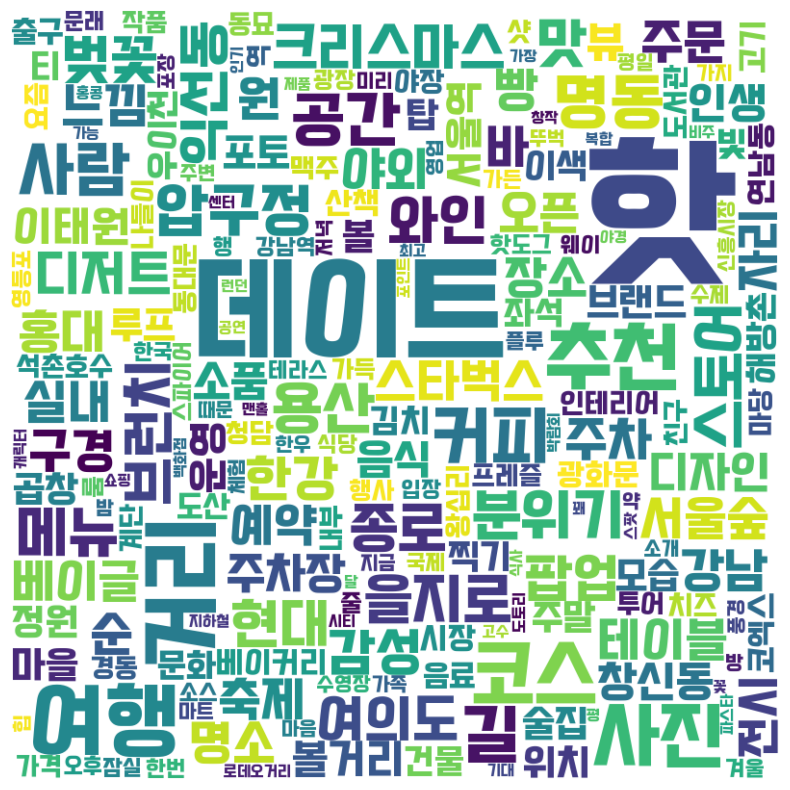

In [3]:
# ÏµúÏ¥àÌÅ¨Î°§ÎßÅ Îç∞Ïù¥ÌÑ∞

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from konlpy.tag import Okt
import re

okt = Okt()

# ÌÅ¨Î°§ÎßÅÌïú Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨ÏòµÎãàÎã§ (ÏµúÏ¥àÌÅ¨Î°§ÎßÅ ÌååÏùºÏùÑ ÏÇ¨Ïö©).
# df = pd.read_excel("../data/ÏµúÏ¥àÌÅ¨Î°§ÎßÅ_24-08-27.xlsx")
df = pd.read_excel("../data/ÏµúÏ¥àÌÅ¨Î°§ÎßÅ_24-09-04.xlsx")

# Î≥∏Î¨∏ ÎÇ¥Ïö©Í≥º ÌÉúÍ∑∏ ÏπºÎüºÏùÑ Í∞ÄÏ†∏ÏôÄÏÑú ÌÖçÏä§Ìä∏Î•º ÌïòÎÇòÎ°ú Í≤∞Ìï©Ìï©ÎãàÎã§.
text_data = " ".join(df['ÎÇ¥Ïö©'].dropna()) + " " + " ".join(df['ÌÉúÍ∑∏'].dropna())

# ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨ (Î∂àÌïÑÏöîÌïú ÌäπÏàòÎ¨∏Ïûê Ï†úÍ±∞)
text_data = re.sub(r'[^\w\s]', '', text_data)  # ÌäπÏàòÎ¨∏Ïûê Ï†úÍ±∞
text_data = re.sub(r'\d+', '', text_data)  # Ïà´Ïûê Ï†úÍ±∞

# Î∂àÏö©Ïñ¥ Î™©Î°ù Î°úÎìú
stopwords_file_path = '../data/stopwords-ko.txt'
stopwords_set = load_stopwords(stopwords_file_path)

# Î™ÖÏÇ¨ Ï∂îÏ∂ú
nouns = [word for word, pos in okt.pos(text_data) if pos in ['Noun']]
nouns = get_nouns_from_texts(nouns, stopwords_set)

# Îã®Ïñ¥ ÎπàÎèÑ Í≥ÑÏÇ∞
word_counts = Counter(nouns)

# ÏõåÎìúÌÅ¥ÎùºÏö∞Îìú ÏÉùÏÑ±
wordcloud = WordCloud(
    font_path='../font/Cafe24Ohsquare-v2.0.ttf',  # ÌïúÍ∏Ä Ìè∞Ìä∏ Í≤ΩÎ°ú ÏÑ§Ï†ï
    width=800, 
    height=800,
    background_color='white'
).generate_from_frequencies(word_counts)

# ÏõåÎìúÌÅ¥ÎùºÏö∞Îìú ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

mask Î≥ÄÌôò Î∞©Ïãù1


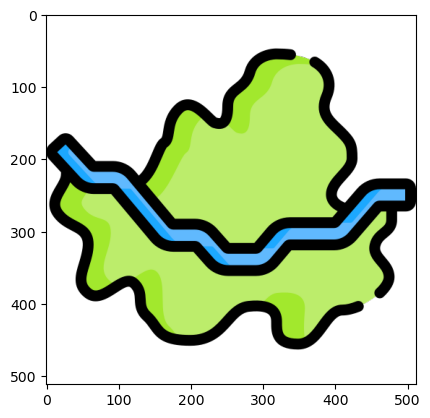

In [4]:
from PIL import Image
import numpy as np
from wordcloud import ImageColorGenerator

image_name = '../img/seoul.PNG'

target_image = Image.open(image_name) 

try:
    mask = Image.new("RGB", target_image.size, (255,255,255))
    mask.paste(target_image,target_image)
    mask = np.array(mask)
    print("mask Î≥ÄÌôò Î∞©Ïãù1")
except:
    print(image_name)
    mask=np.array(Image.open(image_name))
    print("mask Î≥ÄÌôò Î∞©Ïãù2")
finally:
    plt.imshow(target_image)

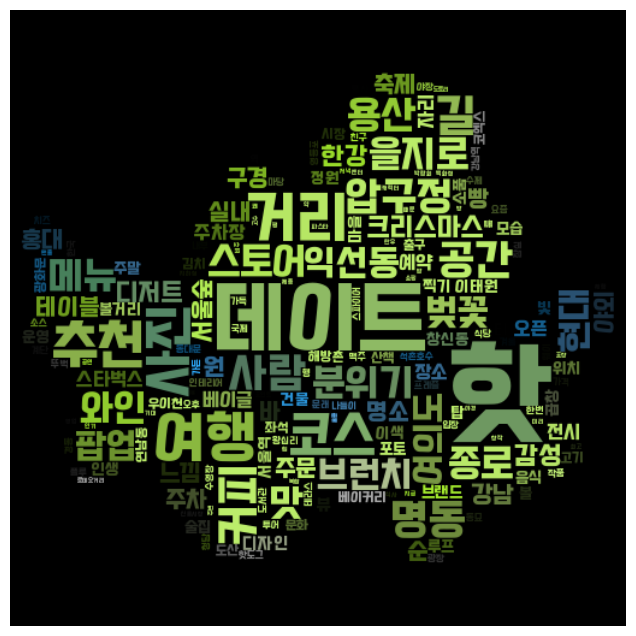

In [5]:
count = Counter(nouns)

wc_seoul = WordCloud(
    font_path='../font/Cafe24Ohsquare-v2.0.ttf',
    mask=mask,
    background_color="black"
)

wc_seoul = wc_seoul.generate_from_frequencies(count)
image_colors=ImageColorGenerator(mask)

plt.figure(figsize=(8,8))
plt.imshow(wc_seoul.recolor(color_func=image_colors),interpolation="bilinear")
plt.axis("off")
plt.show()

output_path = '../img/wordcloud_seoul.png'
wc_seoul.to_file(output_path)

In [16]:
# Ï∂îÍ∞Ä ÌÅ¨Î°§ÎßÅ

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd
from datetime import datetime
from tqdm import tqdm

def setup_driver():
    """Chrome ÎìúÎùºÏù¥Î≤ÑÎ•º ÏÑ§Ï†ïÌïòÍ≥† Î∞òÌôòÌï©ÎãàÎã§."""
    chrome_driver_path = 'C:\\chromedriver-win64\\chromedriver.exe'
    service = Service(chrome_driver_path)

    options = Options()
    options.add_argument("--disable-notifications")
    options.add_argument("--start-maximized")

    driver = webdriver.Chrome(service=service, options=options)
    return driver

def crawl_blog_posts(search_queries, max_posts_per_query=300, max_pages=10):
    current_time = datetime.now().strftime('%y-%m-%d')
    
    driver = setup_driver()

    all_data = []

    for search_query in search_queries:
        search_query_encoded = search_query.replace(' ', '+')  # Í≤ÄÏÉâÏñ¥Î•º URL Ïù∏ÏΩîÎî©
        url_template = f'https://section.blog.naver.com/Search/Post.naver?pageNo={{}}&rangeType=ALL&orderBy=sim&keyword={search_query_encoded}'
        
        url_list = []
        title_list = []
        seen_urls = set()  # Ï§ëÎ≥µ ÌôïÏù∏ÏùÑ ÏúÑÌïú ÏßëÌï©(Set)

        for page in range(1, max_pages + 1):
            search_url = url_template.format(page)
            driver.get(search_url)
            time.sleep(3)
            
            try:
                # Î∏îÎ°úÍ∑∏ Í∏Ä Ï†úÎ™©Í≥º URL ÏàòÏßë
                article_raw = driver.find_elements(By.CSS_SELECTOR, '.info_post .desc a')
                
                if not article_raw:
                    print(f"ÌéòÏù¥ÏßÄ {page}ÏóêÏÑú Î∏îÎ°úÍ∑∏ Ìè¨Ïä§Ìä∏Î•º Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")
                    break
                
                for article in article_raw:
                    url = article.get_attribute('href')
                    
                    # Ïù¥ÎØ∏ ÏàòÏßëÎêú URLÏù∏ÏßÄ ÌôïÏù∏ (Ï§ëÎ≥µ Ï†úÍ±∞)
                    if url in seen_urls:
                        continue  # Ï§ëÎ≥µÎêú URLÏùÄ Î¨¥Ïãú
                    
                    seen_urls.add(url)  # ÏÉàÎ°úÏö¥ URLÏùÄ ÏßëÌï©Ïóê Ï∂îÍ∞Ä
                    
                    title_element = article.find_element(By.XPATH, './strong')
                    title = title_element.text
                    url_list.append(url)
                    title_list.append(title)

                    if len(url_list) >= max_posts_per_query:
                        break
                
                if len(url_list) >= max_posts_per_query:
                    break
            except Exception as e:
                print(f"ÌéòÏù¥ÏßÄ {page}ÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: {e}")
                continue
        
        # ÏàòÏßëÌïú URLÍ≥º Ï†úÎ™©ÏùÑ DataFrameÏóê Ï†ÄÏû•
        df = pd.DataFrame({'Ï£ºÏÜå': url_list, 'Ï†úÎ™©': title_list})
        
        # ÌÅ¨Î°§ÎßÅÌïú ÎÇ¥Ïö©ÏùÑ Ìè¨Ìï®Ìïú DataFrameÏùÑ Excel ÌååÏùºÎ°ú Ï†ÄÏû•
        df['Í≤ÄÏÉâÏñ¥'] = search_query
        df['ÏûëÏÑ±ÏùºÏûê'] = None
        df['ÌÉúÍ∑∏'] = None
        df['ÎÇ¥Ïö©'] = None

        number = len(df)

        for i in tqdm(range(number), desc=f"Crawling: {search_query}"):
            url = df['Ï£ºÏÜå'][i]
            driver.get(url)    
            time.sleep(3)

            try:
                # Î∏îÎ°úÍ∑∏ Î≥∏Î¨∏ iframeÏúºÎ°ú Ï†ÑÌôò
                WebDriverWait(driver, 10).until(
                    EC.frame_to_be_available_and_switch_to_it((By.ID, 'mainFrame'))
                )

                # Ï†úÎ™© Ï∂îÏ∂ú
                tit = driver.find_element(By.CSS_SELECTOR, '.se-module.se-module-text.se-title-text')
                title = tit.text

                # ÎÇ†Ïßú Î∞è ÏãúÍ∞Ñ Ï∂îÏ∂ú
                date = driver.find_element(By.CSS_SELECTOR, '.se_publishDate.pcol2')
                datetime_text = date.text

                df.at[i, 'ÏûëÏÑ±ÏùºÏûê'] = datetime_text

                # ÌÉúÍ∑∏ Ï∂îÏ∂ú
                tags = driver.find_elements(By.CSS_SELECTOR, '.wrap_tag .ell')
                tag_list = [tag.text for tag in tags]
                tag_str = ' '.join(tag_list)
                df.at[i, 'ÌÉúÍ∑∏'] = tag_str

                # ÎÇ¥Ïö© Ï∂îÏ∂ú
                contents = driver.find_elements(By.CSS_SELECTOR, '.se-module.se-module-text')
                content_list = [content.text for content in contents]
                content_str = ' '.join(content_list)
                df.at[i, 'ÎÇ¥Ïö©'] = content_str

                print(f"{i}Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: {title}")

            except Exception as e:
                print(f"{i}Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: {e}")
                continue

        all_data.append(df)

    all_df = pd.concat(all_data, ignore_index=True)
    all_df.to_excel(f"../data/Ï∂îÍ∞ÄÌÅ¨Î°§ÎßÅ_{current_time}.xlsx", index=False)

    print("ÏàòÏßëÌïú Í∏Ä Í∞ØÏàò:", len(all_df.dropna(subset=['ÎÇ¥Ïö©'])))

    driver.quit()

# Ìï®Ïàò Ìò∏Ï∂ú ÏòàÏ†ú
search_queries = [
    'ÏÑúÏö∏ÎßõÏßë', 'ÏÑúÏö∏Îç∞Ïù¥Ìä∏', 'ÏÑúÏö∏Ïó¨Ìñâ', 'ÏÑúÏö∏Ï∂îÏ≤ú', 'ÏÑúÏö∏ÏÇ¨ÏßÑ', 'ÏÑúÏö∏Í±∞Î¶¨', 'ÏÑúÏö∏Ïª§Ìîº', 'ÏÑúÏö∏ÏΩîÏä§', 'ÏÑúÏö∏Í≥µÏõê', 'ÏÑúÏö∏Î™ÖÏÜå' 
]
crawl_blog_posts(search_queries, max_posts_per_query=100, max_pages=15)

Crawling: ÏÑúÏö∏ÎßõÏßë:   1%|‚ñå                                                             | 1/100 [00:05<08:27,  5.12s/it]

0Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë Í∞ïÌò∏Ïó∞Ìåå ÏßÄÌïò1Ï∏µ ÏÉ§Î∏åÏßë Ï∂îÏ≤ú!


Crawling: ÏÑúÏö∏ÎßõÏßë:   2%|‚ñà‚ñè                                                            | 2/100 [00:09<07:50,  4.80s/it]

1Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄ ÏÑúÏö∏ ÎßõÏßë Îç∞Ïù¥Ìä∏ IFCÎ™∞ Í∑ºÏ≤ò Í≥†Ïö∞Í∞Ä Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ÎßõÏßë:   3%|‚ñà‚ñä                                                            | 3/100 [00:13<07:04,  4.38s/it]

2Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë Ïú†Î∞©ÎÖï Ï§ëÏãùÎãπ


Crawling: ÏÑúÏö∏ÎßõÏßë:   4%|‚ñà‚ñà‚ñç                                                           | 4/100 [00:17<06:51,  4.29s/it]

3Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞úÏù∏Ï†ÅÏúºÎ°ú Í≥†Í∏∞Í∞Ä ÎßõÏûàÎäî ÏÑúÏö∏ ÎßõÏßë 5Í∞ú


Crawling: ÏÑúÏö∏ÎßõÏßë:   5%|‚ñà‚ñà‚ñà                                                           | 5/100 [00:22<06:48,  4.30s/it]

4Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎßõÏßë Î∂ÄÎ™®Îãò ÏãùÏÇ¨ Í≥†ÎØºÎßêÍ≥† ÏÑ§Í∞ÄÏò®


Crawling: ÏÑúÏö∏ÎßõÏßë:   6%|‚ñà‚ñà‚ñà‚ñã                                                          | 6/100 [00:25<06:24,  4.09s/it]

5Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë ÌååÏù¥Î∏åÍ∞ÄÏù¥Ï¶à ÌñÑÎ≤ÑÍ±∞ÏôÄ Ïñë ÎßéÏùÄ Í∞êÏûêÌäÄÍπÄ


Crawling: ÏÑúÏö∏ÎßõÏßë:   7%|‚ñà‚ñà‚ñà‚ñà‚ñé                                                         | 7/100 [00:30<06:32,  4.22s/it]

6Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë ÏãùÎãπÍ∞Ä Í≥±Ï∞ΩÏ†ÑÍ≥® ÎÇòÏùòÍ∞ÄÏïº


Crawling: ÏÑúÏö∏ÎßõÏßë:   8%|‚ñà‚ñà‚ñà‚ñà‚ñâ                                                         | 8/100 [00:34<06:32,  4.26s/it]

7Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë Ï†ïÎèàÌîÑÎ¶¨ÎØ∏ÏóÑ ÌûàÎ†àÏπ¥Ï∏† Ïπ¥ÌÉÄÎ°úÏä§Ïπ¥Ï∏†


Crawling: ÏÑúÏö∏ÎßõÏßë:   9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                        | 9/100 [00:38<06:23,  4.22s/it]

8Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë Í≥†ÎîîÎ∞î Î≤†Ïù¥Ïª§Î¶¨] Ï¥àÏΩúÎ†âÏÇ¨ ÌôîÏù¥Ìä∏ÎßêÏ∞®&Ïö∞Ïú† Í∞ÄÎìùÌïú ÌôîÏù¥Ìä∏ Ï¥àÏΩúÎ¶ø ÏÜåÎùºÎπµ ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ÎßõÏßë:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                       | 10/100 [00:42<06:14,  4.16s/it]

9Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë <Ìò∏Ïö∞ÏÑ¨ ÎçîÌòÑÎåÄÏÑúÏö∏Ï†ê> ÏÜîÏßÅÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ÎßõÏßë:  11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                      | 11/100 [00:47<06:20,  4.27s/it]

10Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎßõÏßë ÌïúÎÇ®Îèô Ïò§ÎßàÏπ¥ÏÑ∏@ ÎûÄÌè¨


Crawling: ÏÑúÏö∏ÎßõÏßë:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                     | 12/100 [00:50<05:59,  4.08s/it]

11Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ÎßõÏßë ÌôçÏΩ©ÏùåÏãùÏ†ê Ìò∏Ïö∞ÏÑ¨ Î©îÎâ¥


Crawling: ÏÑúÏö∏ÎßõÏßë:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                     | 13/100 [00:54<05:43,  3.95s/it]

12Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Ïó¨ÏùòÎèÑ/ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë] Ï´ÄÎã•Ï´ÄÎã• ÎÇòÌè¥Î¶¨Ïãù Ìä∏Îü¨Ìîå ÌîºÏûê ÎßõÏßë, ‚ÄòÏù¥ÌÉàÎ¶¨‚Äô + Ïπ¥Ìéò ‚ÄòÎ∏îÎ£®Î≥¥ÌãÄ‚Äô (ÎÇ¥ÎèàÎÇ¥ÏÇ∞)


Crawling: ÏÑúÏö∏ÎßõÏßë:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                    | 14/100 [00:58<05:33,  3.87s/it]

13Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄ ÏÑúÏö∏ ÎßõÏßë Ï£†Ï£† Ïò§ÏΩîÎÖ∏ÎØ∏ÏïºÎÅº


Crawling: ÏÑúÏö∏ÎßõÏßë:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                   | 15/100 [01:01<05:19,  3.76s/it]

14Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë Îç∞Ïù¥Ìä∏ IFCÎ™∞ Í∑ºÏ≤ò Í≥†Ïö∞Í∞Ä Ïó¨ÏùòÎèÑÏ†ê Ï£ºÏ∞® ÌåÅ


Crawling: ÏÑúÏö∏ÎßõÏßë:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                   | 16/100 [01:05<05:14,  3.74s/it]

15Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë Ï†ïÎèàÌîÑÎ¶¨ÎØ∏ÏóÑ Î∞±ÌôîÏ†ê Í∞îÎã§Í∞Ä 6Ï∏µ ÏãùÎãπÍ∞Ä Î∞©Î¨∏Í∏∞


Crawling: ÏÑúÏö∏ÎßõÏßë:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                  | 17/100 [01:09<05:07,  3.71s/it]

16Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Ïó¨ÏùòÎèÑ] Îä•ÎèôÎØ∏ÎÇòÎ¶¨ - ÏÑúÏö∏ ÎßõÏßë Ìä∏Î†åÎìúÏßÄÏàò 3ÏúÑ! Îä•ÎèôÎØ∏ÎÇòÎ¶¨Ïùò ÏÑ∏ Î≤àÏß∏ Ï†êÌè¨


Crawling: ÏÑúÏö∏ÎßõÏßë:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                  | 18/100 [01:12<04:59,  3.65s/it]

17Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë Ï†ïÎèà Ï∂îÏ≤ú ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ÎßõÏßë:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                 | 19/100 [01:15<04:49,  3.57s/it]

18Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÎçîÌòÑÎåÄÏÑúÏö∏ÎßõÏßë]ÎçîÌòÑÎåÄÏÑúÏö∏ÎèàÍπåÏä§ Ïó¨ÏùòÎèÑÎßõÏßë Ï†ïÎèàÌîÑÎ¶¨ÎØ∏ÏóÑ


Crawling: ÏÑúÏö∏ÎßõÏßë:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                | 20/100 [01:19<04:54,  3.68s/it]

19Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î∂ÑÏúÑÍ∏∞ Ï¢ãÏùÄ ÎçîÌòÑÎåÄÏÑúÏö∏ÎßõÏßë Ïù¥ÌÉàÎ¶¨Ïïà Î†àÏä§ÌÜ†Îûë Î≥∏Î≥¥ÏïºÏßÄ Ï∂îÏ≤ú !


Crawling: ÏÑúÏö∏ÎßõÏßë:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                | 21/100 [01:23<04:54,  3.73s/it]

20Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í≥†ÎîîÎ∞î Î≤†Ïù¥Ïª§Î¶¨ ÌèâÏùº Ïõ®Ïù¥ÌåÖ ÌõÑÍ∏∞ ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë Í≥†ÎîîÎπµ


Crawling: ÏÑúÏö∏ÎßõÏßë:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                               | 22/100 [01:27<04:51,  3.73s/it]

21Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎßõÏßë Ïä§ÌÇ§ÏïºÌÇ§Í∞Ä ÏòàÏà†Ïù∏ Ïò•ÏÜåÎ∞ò ÎßàÍ≥°Î≥∏Ï†ê


Crawling: ÏÑúÏö∏ÎßõÏßë:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                               | 23/100 [01:31<04:55,  3.84s/it]

22Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë ÌîºÌÅ¨Îãâ ÏÑ∏Ìä∏ Ìè¨Ïû• ' ÏàòÌã∞ Sooty '


Crawling: ÏÑúÏö∏ÎßõÏßë:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                              | 24/100 [01:35<04:48,  3.80s/it]

23Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë ÏàúÏò•Ïù¥ÎÑ§ Ïò¨ÎßåÏóê ÎòêÍ∞ÑÏßë


Crawling: ÏÑúÏö∏ÎßõÏßë:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                             | 25/100 [01:39<04:43,  3.78s/it]

24Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë Î∏åÎùºÏù¥Ìäº Ïä§ÌÄòÏñ¥ 1Ï∏µ ÎΩÅ Î∂ÑÏãù & ÏÉùÎß•Ï£º Îç∞Ïù¥Ìä∏ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ÎßõÏßë:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                             | 26/100 [01:42<04:38,  3.77s/it]

25Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ÎßõÏßë] Î≤ÑÌÑ∞ÌïëÍ±∞Ìå¨ÏºÄÏù¥ÌÅ¨ Ï≤≠Îã¥Ï†ê


Crawling: ÏÑúÏö∏ÎßõÏßë:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                            | 27/100 [01:46<04:30,  3.70s/it]

26Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë_Ïó¨ÏùòÎèÑ Ï†êÏã¨ ÎßõÏßë ÏàòÌã∞ Î°úÏä§Ìä∏ÏπòÌÇ®


Crawling: ÏÑúÏö∏ÎßõÏßë:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                            | 28/100 [01:50<04:34,  3.81s/it]

27Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ÎßõÏßë Ïò§Ïãú ÏùµÏä§ÌîÑÎ†àÏä§


Crawling: ÏÑúÏö∏ÎßõÏßë:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                           | 29/100 [01:54<04:27,  3.77s/it]

28Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë Ìè¨Ïû• Í∞ÄÎä•Ìïú ÏàòÌã∞ ÎçîÌòÑÎåÄÏÑúÏö∏Ï†ê ÌîºÌÅ¨ÎãâÏÑ∏Ìä∏


Crawling: ÏÑúÏö∏ÎßõÏßë:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                          | 30/100 [01:57<04:23,  3.76s/it]

29Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë ÏöîÏù¥Î≤§Ïä§ÌîÑÏπ¥Î†à : Îã§ÏñëÌïú ÌÜ†ÌïëÏùò Ïä§ÌîÑÏπ¥Î†à


Crawling: ÏÑúÏö∏ÎßõÏßë:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                          | 31/100 [02:01<04:17,  3.74s/it]

30Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 7Ïõî Îã§ÏÑØÏß∏ Ï£º Ìè¨ÌÜ†Îç§ÌîÑ : ÏÑúÏö∏ ÎßõÏßë ÌÉêÎ∞©ÌïòÍ∏∞ (Ï∂©Ï†ïÎ°ú ÎßõÏßë ÎëêÌàº & Ï¢ÖÎ°ú3Í∞Ä Ï¢ÖÎ°úÏßÑÎÇôÏßÄ)


Crawling: ÏÑúÏö∏ÎßõÏßë:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                         | 32/100 [02:05<04:14,  3.74s/it]

31Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄ ÏÑúÏö∏ ÎßõÏßë Ï†ïÏú°Î©¥Ï≤¥ Ï≤¥Ïù∏Ï†ê ÎÇ¥Í≥†Ïã∂ÏùÄ Îßõ


Crawling: ÏÑúÏö∏ÎßõÏßë:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                        | 33/100 [02:09<04:12,  3.77s/it]

32Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ÎßõÏßë Îß§Î†•Ï†ÅÏù¥Í≥† ÍπäÏùÄ Îßõ ÏöîÏù¥Î≤§Ïä§ÌîÑÏπ¥Î†à


Crawling: ÏÑúÏö∏ÎßõÏßë:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                        | 34/100 [02:12<04:04,  3.70s/it]

33Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄ ÏÑúÏö∏ ÎßõÏßë ÏïºÎÅºÏÜåÎ∞î Ï†ÑÎ¨∏Ï†ê Ïò§ÏΩîÎÖ∏ÎØ∏ÏïºÎÅº ÎßõÏßë Ï£†Ï£† Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ÎßõÏßë:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                       | 35/100 [02:17<04:21,  4.02s/it]

34Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄ ÏÑúÏö∏ÎßõÏßë Ïú†Î∞©ÎÖï Ï§ëÏãù ÏãúÍ∑∏ÎÑàÏ≤ò B ÏÑ∏Ìä∏ Ïó¨ÏùòÎèÑ Îç∞Ïù¥Ìä∏ Ï∞çÎ®π Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ÎßõÏßë:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                       | 36/100 [02:20<04:08,  3.88s/it]

35Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë Î≤àÌå®Ìã∞Î≤à Î©îÎâ¥ Ïù∏ÏÉù ÏàòÏ†úÎ≤ÑÍ±∞


Crawling: ÏÑúÏö∏ÎßõÏßë:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                      | 37/100 [02:24<04:04,  3.88s/it]

36Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÎßõÏßë] ÎÇ¥ÎèàÎÇ¥ÏÇ∞ ÏÑúÏö∏ÎßõÏßë Î¶¨Ïä§Ìä∏ - ÌäπÎ≥ÑÌïú ÎÇ† Î®πÍ∏∞ Ï¢ãÏùÄ 1Ïù∏ 5ÎßåÏõê Ïù¥ÏÉÅ ÎßõÏßë (2023.ver)


Crawling: ÏÑúÏö∏ÎßõÏßë:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                     | 38/100 [02:28<03:54,  3.78s/it]

37Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùºÎ≥∏ ÏÇøÌè¨Î°úÍ∞Ä Í∑∏Î¶¨ÏõåÏßÄÎäî ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë ÏöîÏù¥Î≤§Ïä§ÌîÑÏπ¥Î†à


Crawling: ÏÑúÏö∏ÎßõÏßë:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                     | 39/100 [02:32<03:54,  3.84s/it]

38Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ÎßõÏßë 6F Í≥†Í∏â Ï§ëÏãùÎãπ ‚ÄòÎèÑÏõêÏä§ÌÉÄÏùº(Ê°ÉÂúí)‚Äô


Crawling: ÏÑúÏö∏ÎßõÏßë:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                    | 40/100 [02:35<03:45,  3.77s/it]

39Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ÎßõÏßë Ïó¨ÏùòÎèÑÎßõÏßëÏ∂îÏ≤ú Ïò§ÏãúÏùµÏä§ÌîÑÎ†àÏä§


Crawling: ÏÑúÏö∏ÎßõÏßë:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                    | 41/100 [02:39<03:39,  3.71s/it]

40Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïú Í≥≥/ÏÑúÏö∏Ïó¨Ìñâ/ÏÑúÏö∏ÎßõÏßë] Í¥ëÌôîÎ¨∏ ÏùºÎØºÎØ∏Ïà†Í¥Ä Ìï®Î∞ïÏä§ÌÖåÏù¥ÌÅ¨ ÎßõÏßë Ïπ¥ÌéòÏù¥Îßà


Crawling: ÏÑúÏö∏ÎßõÏßë:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                   | 42/100 [02:43<03:33,  3.69s/it]

41Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë Î∂àÌñ• Î≥∂ÏùåÎ©¥ ÌçºÎ∂ÄÏñ¥ ÎçîÌòÑÎåÄÏÑúÏö∏Ï†ê


Crawling: ÏÑúÏö∏ÎßõÏßë:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                  | 43/100 [02:47<03:34,  3.76s/it]

42Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎßõÏßë Ï∂îÏ≤ú Ïò§ÏãúÏò§Ìè¨Ï∞® ÏÉ§Î°úÏàòÍ∏∏Ïà†Ïßë


Crawling: ÏÑúÏö∏ÎßõÏßë:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                  | 44/100 [02:51<03:42,  3.97s/it]

43Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë Ìò∏Ïö∞ÏÑ¨: ÏïÑÏù¥Îûë Ïõ®Ïù¥ÌåÖ ÏóÜÏù¥ ÌôçÏΩ©ÏùåÏãù Ï¶êÍ∏∞Í∏∞


Crawling: ÏÑúÏö∏ÎßõÏßë:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                 | 45/100 [02:55<03:33,  3.89s/it]

44Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÏÇºÍ≤πÏÇ¥ÎßõÏßë Í≥†ÍπÉÏßë, ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë Ïó¨ÏùòÌôîÎ°ú


Crawling: ÏÑúÏö∏ÎßõÏßë:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                 | 46/100 [02:58<03:26,  3.83s/it]

45Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ÎßõÏßë/ÌôçÎåÄ] Ï¶âÎñ°Ïóî Î≤ÑÍ∞à _ ÎòêÎ≥¥Í≤†ÏßÄÎñ°Î≥∂Ïù¥


Crawling: ÏÑúÏö∏ÎßõÏßë:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                | 47/100 [03:03<03:29,  3.96s/it]

46Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë ÏöîÏù¥Î≤§Ïä§ÌîÑÏπ¥Î†à ÎçîÌòÑÎåÄÏÑúÏö∏


Crawling: ÏÑúÏö∏ÎßõÏßë:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                               | 48/100 [03:19<06:46,  7.81s/it]

47Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë ÏöîÏù¥Î≤§Ïä§ÌîÑÏπ¥Î†à ÎçîÌòÑÎåÄÏÑúÏö∏


Crawling: ÏÑúÏö∏ÎßõÏßë:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                               | 49/100 [03:23<05:37,  6.61s/it]

48Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌõóÏπ¥Ïù¥ÎèÑÌíçÏª§Î¶¨ ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë ÏöîÏù¥Î≤§Ïä§ÌîÑÏπ¥Î†à


Crawling: ÏÑúÏö∏ÎßõÏßë:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                              | 50/100 [03:27<04:51,  5.82s/it]

49Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÎßõÏßë] ÎÇ¥ÎèàÎÇ¥ÏÇ∞ ÏÑúÏö∏ ÎßõÏßë Î¶¨Ïä§Ìä∏ - Ï∫êÏ£ºÏñºÌïòÍ≤å Î®πÍ∏∞ Ï¢ãÏùÄ 1Ïù∏ 3ÎßåÏõê Ïù¥Ìïò ÎßõÏßë (2023.ver)


Crawling: ÏÑúÏö∏ÎßõÏßë:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                              | 51/100 [03:31<04:15,  5.22s/it]

50Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎöùÏÑ¨Ïó≠ Í∞ÄÏÑ±ÎπÑ ÎßõÏßë Î†àÌä∏Î°ú ÏÑúÏö∏ÎßõÏßë


Crawling: ÏÑúÏö∏ÎßõÏßë:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                             | 52/100 [03:35<03:55,  4.91s/it]

51Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÌôîÎ°ú„Ö£Ïó¨ÏùòÎèÑÏÇºÍ≤πÏÇ¥ÎßõÏßëÍ≥†Í∏∞Ïßë ÎçîÌòÑÎåÄÏÑúÏö∏ÎßõÏßë Ï∞æÎäîÎã§Î©¥ Ïó¨Í∏∞Î°ú Í≥†Í≥†


Crawling: ÏÑúÏö∏ÎßõÏßë:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                            | 53/100 [03:39<03:35,  4.59s/it]

52Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë ÏöîÏù¥Î≤§Ïä§ÌîÑÏπ¥Î†à ÎçîÌòÑÎåÄÏÑúÏö∏


Crawling: ÏÑúÏö∏ÎßõÏßë:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                            | 54/100 [03:43<03:21,  4.39s/it]

53Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïú Í≥≥/ÏÑúÏö∏Ïó¨Ìñâ/ÏÑúÏö∏ÎßõÏßë] Ìï©Ï†ï Î∂ìÏπ¥ÏºÄ Ïö∞Îèô ÏÜåÎ∞î ÎßõÏßë ÍµêÎã§Ïù¥Ïïº Ïõ®Ïù¥ÌåÖ Î©îÎâ¥ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ÎßõÏßë:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                           | 55/100 [03:47<03:11,  4.25s/it]

54Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ÎßõÏßë ÏöîÏù¥Î≤§ Ïä§ÌîÑÏπ¥Î†à


Crawling: ÏÑúÏö∏ÎßõÏßë:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                          | 56/100 [03:51<03:10,  4.34s/it]

55Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑÎç∞Ïù¥Ìä∏ Ïåâ ÎçîÌòÑÎåÄÏÑúÏö∏ÎßõÏßë SSAP


Crawling: ÏÑúÏö∏ÎßõÏßë:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                          | 57/100 [03:55<02:59,  4.17s/it]

56Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë - ÏàòÌã∞


Crawling: ÏÑúÏö∏ÎßõÏßë:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                         | 58/100 [03:59<02:49,  4.04s/it]

57Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ÎßõÏßë Ïåâ ÌÉÄÏù¥ ÌòÑÏßÄÎßõ Í∑∏ÎåÄÎ°ú ÏπòÌÇ®ÌåüÌÉÄÏù¥ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ÎßõÏßë:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                         | 59/100 [04:03<02:48,  4.10s/it]

58Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄ ÏÑúÏö∏ ÎßõÏßë Îç∞Ïù¥Ìä∏ IFCÎ™∞ Í∑ºÏ≤ò Î£∏ÏãùÎãπ Ï∂îÏ≤ú Í≥†Ïö∞Í∞Ä


Crawling: ÏÑúÏö∏ÎßõÏßë:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                        | 60/100 [04:07<02:36,  3.92s/it]

59Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ÎßõÏßë/ÏùÑÏßÄÎ°ú] ÌôçÏä§ Ìô©Í∏àÏ°±Î∞ú


Crawling: ÏÑúÏö∏ÎßõÏßë:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                       | 61/100 [04:11<02:32,  3.90s/it]

60Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïú Í≥≥/ÏÑúÏö∏Ïó¨Ìñâ/ÏÑúÏö∏ÎßõÏßë] ÌòúÌôî ÎåÄÌïôÎ°ú Î≤†Ìä∏ÎÇ® ÏùåÏãùÏ†ê ÎéÅÏßúÏù¥ ÎåÄÌïôÎ°úÏ†ê


Crawling: ÏÑúÏö∏ÎßõÏßë:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                       | 62/100 [04:14<02:27,  3.88s/it]

61Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë [ÎùºÍ∑∏Î¶¥Î¶¨ÏïÑ Ïó¨ÏùòÎèÑ ÌååÌÅ¨ÏõêÏ†ê] ÌååÏä§ÌÉÄ Ïä§ÌÖåÏù¥ÌÅ¨Set


Crawling: ÏÑúÏö∏ÎßõÏßë:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                      | 63/100 [04:19<02:29,  4.05s/it]

62Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ÎßõÏßë, ÏöîÏù¥Î≤§Ïä§ÌîÑÏπ¥Î†à


Crawling: ÏÑúÏö∏ÎßõÏßë:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                      | 64/100 [04:44<06:10, 10.30s/it]

63Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í∞ÄÏÇ∞ÎßõÏßë Î≥¥Î≥¥Î©¥ ÎùºÎ©òÎßõÏßë Í∏àÏ≤úÍµ¨ÎßõÏßë ÏÑúÏö∏ÎßõÏßë


Crawling: ÏÑúÏö∏ÎßõÏßë:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                     | 65/100 [04:48<04:52,  8.36s/it]

64Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄÏÑúÏö∏ÎßõÏßë Ïåâ SSAP ÌòÑÏßÄÎäêÎÇå ÌÉúÍµ≠ÏùåÏãù


Crawling: ÏÑúÏö∏ÎßõÏßë:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                    | 66/100 [04:52<04:03,  7.15s/it]

65Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎßõÏßë :: Ïã†ÎèÑÎ¶º ÌïúÎèàÍµ¥Î≥¥Ïåà - Íµ¥Î≥¥Ïåà


Crawling: ÏÑúÏö∏ÎßõÏßë:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                    | 67/100 [04:56<03:23,  6.17s/it]

66Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë ÏöîÏù¥Î≤§Ïä§ÌîÑÏπ¥Î†à ÏÇøÌè¨Î°ú Ïä§ÌîÑÏπ¥Î†à


Crawling: ÏÑúÏö∏ÎßõÏßë:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                   | 68/100 [04:59<02:52,  5.39s/it]

67Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÎçîÌòÑÎåÄÏÑúÏö∏ÎßõÏßë]Ïó¨ÏùòÎèÑÎßõÏßë, Ï§ÑÏÑúÎäî ÏãùÎãπ ÎßõÏßë ÌÖåÎîîÎµàÎ•¥ÌïòÏö∞Ïä§ ÎçîÌòÑÎåÄÏÑúÏö∏


Crawling: ÏÑúÏö∏ÎßõÏßë:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                   | 69/100 [05:04<02:35,  5.02s/it]

68Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎßõÏßë. Î™ΩÌÉÑ ÏßöÎ∂àÍµ¨Ïù¥


Crawling: ÏÑúÏö∏ÎßõÏßë:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                  | 70/100 [05:08<02:21,  4.72s/it]

69Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ ÎßõÏßë] Î≤ΩÏ†úÎ¥âÌîºÏñë Ïã†ÏÑ∏Í≥Ñ Î∞±ÌôîÏ†ê Î≥∏Ï†ê


Crawling: ÏÑúÏö∏ÎßõÏßë:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                 | 71/100 [05:11<02:08,  4.43s/it]

70Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄ ÏÑúÏö∏ ÎßõÏßë, Ï£†Ï£† ÎçîÌòÑÎåÄÏÑúÏö∏Ï†ê ÏßÄÌïò 1Ï∏µ


Crawling: ÏÑúÏö∏ÎßõÏßë:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                 | 72/100 [05:15<02:00,  4.30s/it]

71Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë ÎßàÏú†Ïú† ÎßàÎùºÌÉï ÎßàÎùºÏÉπÍ∂à ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ÎßõÏßë:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                | 73/100 [05:54<06:32, 14.54s/it]

72Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë Îç∞Ïù¥Ìä∏ IFCÎ™∞ Í∑ºÏ≤ò Í≥†Ïö∞Í∞ÄÏóêÏÑú Ï†úÎåÄÎ°úÎêú Ïò§ÎßàÏπ¥ÏÑ∏ Ï¶êÍ∏∞Í∏∞


Crawling: ÏÑúÏö∏ÎßõÏßë:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè               | 74/100 [05:58<04:56, 11.42s/it]

73Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÎçîÌòÑÎåÄÏÑúÏö∏ÎßõÏßë]Ïû¨Î£å ÏãùÍ∞êÏù¥ ÏÇ¥ÏïÑÏûàÎäî Í≥≥ 'ÏöîÏù¥Î≤§Ïä§ÌîÑÏª§Î¶¨'


Crawling: ÏÑúÏö∏ÎßõÏßë:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä               | 75/100 [06:02<03:50,  9.22s/it]

74Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïú Í≥≥/ÏÑúÏö∏Ïó¨Ìñâ/ÏÑúÏö∏ÎßõÏßë] ÌòúÌôî ÎåÄÌïôÎ°ú ÎèôÍ≤ΩÏãù ÎßàÏ†úÏÜåÎ∞î ÎßõÏßë Ïπ∏Îã§ÏÜåÎ∞î


Crawling: ÏÑúÏö∏ÎßõÏßë:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé              | 76/100 [06:06<03:01,  7.58s/it]

75Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ ÎßõÏßë] ÌèâÏñëÎÉâÎ©¥ ÎßõÏßë ‚ÄúÌèâÏñëÎ©¥Ïò• ÏùòÌèâÏò•‚Äù


Crawling: ÏÑúÏö∏ÎßõÏßë:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ              | 77/100 [06:31<04:57, 12.92s/it]

76Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎãπÍ∑º Ïä§ÌÜ†Î¶¨ Ïù¥Î≤§Ìä∏, ÏÑúÏö∏ÎßõÏßë Í≥µÏú†ÌïòÎ©¥ ÏµúÎåÄ 2Îßå Ïõê! (ÎãπÍ∑º Ï≤´ Í±∞Îûò ÌõÑÍ∏∞, ÎãπÍ∑ºÌéòÏù¥ ÏàòÏàòÎ£å)


Crawling: ÏÑúÏö∏ÎßõÏßë:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå             | 78/100 [06:35<03:44, 10.21s/it]

77Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ÎßõÏßë ÏàòÌã∞, Î°úÏä§Ìä∏ÏπòÌÇ®Í≥º Ïâ¨Î¶ºÌîÑ Ïû†Î∞úÎùºÏïº


Crawling: ÏÑúÏö∏ÎßõÏßë:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè            | 79/100 [06:39<02:54,  8.32s/it]

78Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÎßõÏßë ÏàòÌã∞ ÌîºÌÅ¨Îãâ ÏÑ∏Ìä∏ ÌõÑÍ∏∞, ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë Ï∂îÏ≤ú!


Crawling: ÏÑúÏö∏ÎßõÏßë:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä            | 80/100 [06:43<02:21,  7.07s/it]

79Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë ÌÅ¨Î°úÏôÄÏÉÅ ÏÑúÏö∏ÎπµÏßÄÏàúÎ°Ä ÌÖåÎîîÎµàÎ•¥ÌïòÏö∞Ïä§


Crawling: ÏÑúÏö∏ÎßõÏßë:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç           | 81/100 [06:47<01:57,  6.19s/it]

80Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ÎßõÏßë ÌÖåÎîîÎµàÎ•¥ÌïòÏö∞Ïä§ Îπµ Ìè≠ÏãùÌïú ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ÎßõÏßë:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà           | 82/100 [06:51<01:39,  5.52s/it]

81Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ÎßõÏßë] ÎßùÎ¶¨Îã®Í∏∏ Î∞úÎ¶¨Ïù∏ÎßùÏõê Îã§ÎÖÄÏò® ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ÎßõÏßë:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã          | 83/100 [06:55<01:25,  5.00s/it]

82Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ÎßõÏßë ÏöîÏù¥Î≤§Ïä§ÌîÑÏπ¥Î†à ÎçîÌòÑÎåÄÏÑúÏö∏Ï†ê ÏÇøÌè¨Î°úÌíç Ïπ¥Î†àÎßõÏßë ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ÎßõÏßë:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè         | 84/100 [06:59<01:14,  4.69s/it]

83Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ÑÌé∏ÌïòÍ≤å Ï¶êÍ∏∞Îäî ÎçîÌòÑÎåÄÏÑúÏö∏ÎßõÏßë ÏöîÏù¥Î≤§ Ïä§ÌîÑÏπ¥Î†à


Crawling: ÏÑúÏö∏ÎßõÏßë:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä         | 85/100 [07:03<01:06,  4.41s/it]

84Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïú Í≥≥/ÏÑúÏö∏Ïó¨Ìñâ/ÏÑúÏö∏ÎßõÏßë] Í¥ëÌôîÎ¨∏ ÏÇºÍ≥ÑÌÉïÏßë ÎßõÏßë Ïû•ÏàòÌïúÎ∞©ÏÇºÍ≥ÑÌÉï


Crawling: ÏÑúÏö∏ÎßõÏßë:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç        | 86/100 [07:06<00:58,  4.20s/it]

85Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ ÎßõÏßë] Ïò§Íµ¨Î∞òÏ†ê


Crawling: ÏÑúÏö∏ÎßõÏßë:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà        | 87/100 [07:29<02:06,  9.72s/it]

86Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë ÌçºÎ∂ÄÏñ¥ Î¶¨Ïñº Î≤†Ìä∏ÎÇ® ÏåÄÍµ≠Ïàò Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏ÎßõÏßë:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã       | 88/100 [07:33<01:35,  7.94s/it]

87Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎßõÏßë Ïù¥ÎèÑÍ≥∞ÌÉï


Crawling: ÏÑúÏö∏ÎßõÏßë:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé      | 89/100 [07:37<01:13,  6.72s/it]

88Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïò§ÏãúÏùµÏä§ÌîÑÎ†àÏä§ ÎçîÌòÑÎåÄÏÑúÏö∏Ï†ê feat. ÎçîÌòÑÎåÄÏÑúÏö∏ÎßõÏßë, Ïó¨ÏùòÎèÑÎßõÏßëÏ∂îÏ≤ú


Crawling: ÏÑúÏö∏ÎßõÏßë:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ      | 90/100 [07:59<01:54, 11.50s/it]

89Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÑúÏö∏Ïó≠ 2Ï∏µÏóê ÏûàÎäî ÌùîÌïòÎ©¥ÏÑúÎèÑ ÌùîÌïòÏßÄ ÏïäÏùÄ ÎßõÏßë Î∞ÄÎ≥∏ ÏÑúÏö∏ÎßõÏßë ÏÑúÏö∏Ïó≠ÎßõÏßë ÎØ∏ÏäêÎû≠Í∞ÄÏù¥Îìú ÌïúÍµ≠ÎßõÏßë


Crawling: ÏÑúÏö∏ÎßõÏßë:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå     | 91/100 [08:03<01:23,  9.24s/it]

90Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄÏÑúÏö∏ÎßõÏßë Ïπ†ÏïîÎßåÏû•ÏÑúÏö∏Ïó≠ÏïàÏπ¥Ìéò Î¨¥Ïïà


Crawling: ÏÑúÏö∏ÎßõÏßë:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà     | 92/100 [08:08<01:03,  7.93s/it]

91Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏/Ïã†Ï¥å] ÏÑúÏö∏ÎßõÏßë ÎΩÅÏãùÎãπ Ïã†Ï¥åÏ†ê Ïã†Ï¥åÎßõÏßë


Crawling: ÏÑúÏö∏ÎßõÏßë:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 93/100 [08:12<00:46,  6.65s/it]

92Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ÎßõÏßë] ÍπîÎÅîÌïú ÌïúÏãù ÌïúÏÉÅÏùÑ Î®πÏùÑ Ïàò ÏûàÎäî "Ïò®ÎØ∏Í¥Ä ÏïàÍµ≠"


Crawling: ÏÑúÏö∏ÎßõÏßë:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 94/100 [08:15<00:34,  5.73s/it]

93Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎßõÏßë ÏßÄÎèÑ ÏùºÎü¨Ïä§Ìä∏ (ft. ÏÜ°ÏÜ°Ï±ÖÎ∞©)


Crawling: ÏÑúÏö∏ÎßõÏßë:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 95/100 [08:19<00:25,  5.17s/it]

94Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë, Î∂ÅÌï¥ÎèÑ Ïä§ÌîÑÏπ¥Î†à Ï†ÑÎ¨∏Ï†ê ÏöîÏù¥Î≤§ Ïä§ÌîÑÏπ¥Î†à


Crawling: ÏÑúÏö∏ÎßõÏßë:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 96/100 [08:23<00:19,  4.83s/it]

95Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎßõÏßë. ÏÇºÏõêÍ∞ÄÎì†


Crawling: ÏÑúÏö∏ÎßõÏßë:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 97/100 [08:27<00:13,  4.61s/it]

96Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎßõÏßë Î∏åÎ£®ÌÅ¥Î¶∞ÎçîÎ≤ÑÍ±∞Ï°∞Ïù∏Ìä∏


Crawling: ÏÑúÏö∏ÎßõÏßë:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 98/100 [08:31<00:08,  4.34s/it]

97Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ÎßõÏßë/Ïã†Í∏∏ÎèôÎßõÏßë]Ïã†Í∏∏ÎèôÎ≥ÑÎÇúÏïÑÏ∞åÏß¨ÎΩï_Îß§Ïö¥Ïß¨ÎΩï, ÏßúÏû•Î©¥, ÍπÄÎ∞•


Crawling: ÏÑúÏö∏ÎßõÏßë:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 99/100 [08:35<00:04,  4.28s/it]

98Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎßõÏßë Î©úÌåÖÏÉµÏπòÏ¶àÎ£∏


Crawling: ÏÑúÏö∏ÎßõÏßë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [08:58<00:00,  5.39s/it]

99Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Ïó¨ÏùòÎèÑ ÏµúÍ≥†Ïùò Î∂ÑÏúÑÍ∏∞ÏôÄ Íµ¨ÏõåÏ£ºÎäî ÏÇºÍ≤πÏÇ¥ Í≥†Í∏∞Ïßë] Ïó¨ÏùòÎèÑÌöåÏãùÏû•ÏÜåÎçîÌòÑÎåÄ ÏÑúÏö∏ÎßõÏßë Ïó¨ÏùòÎèÑÏÇºÍ≤πÏÇ¥ Ïó¨ÏùòÎèÑ ÎßõÏßë Ïó¨ÏùòÌôîÎ°ú ÏßÅÏòÅÏ†ê



Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:   1%|‚ñå                                                           | 1/100 [00:04<07:37,  4.62s/it]

0Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ ÌïúÍ∞ï ÌÖêÌä∏ ÎöùÏÑ¨ ÌïúÍ∞ïÍ≥µÏõê ÌÖêÌä∏Ï°¥ ÎåÄÏó¨


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:   2%|‚ñà‚ñè                                                          | 2/100 [00:08<07:10,  4.39s/it]

1Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ïÎÇ® Ïò§ÎßàÏπ¥ÏÑ∏ ÎßõÏßë ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Ïû•ÏÜå Ïä§ÏãúÏÑºÎ™¨ ÎîîÎÑà


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:   3%|‚ñà‚ñä                                                          | 3/100 [00:13<07:00,  4.34s/it]

2Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎÖ∏Îì§ÏÑ¨ ÌîºÌÅ¨Îãâ ÎåÄÏó¨ "ÎÖ∏Îì§ÎÖ∏Îì§ ÌîºÌÅ¨Îãâ" Î∞∞Îã¨ ÏùåÏãù ÏúÑÏπò, ÌïúÍ∞ï Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:   4%|‚ñà‚ñà‚ñç                                                         | 4/100 [00:17<06:41,  4.19s/it]

3Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑ±ÏàòÌååÏä§ÌÉÄÎßõÏßë ÏÑúÏö∏ Î∏åÎü∞Ïπò Îç∞Ïù¥Ìä∏ ÏÑ±ÏàòÎã§ÎùΩ


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:   5%|‚ñà‚ñà‚ñà                                                         | 5/100 [00:21<06:28,  4.09s/it]

4Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïû†Ïã§ÎßõÏßë ÏÑúÏö∏Îç∞Ïù¥Ìä∏ 'Ïå§Ïå§Ïå§ Î°ØÎç∞ÏõîÎìúÎ™∞Ï†ê'


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:   6%|‚ñà‚ñà‚ñà‚ñå                                                        | 6/100 [00:25<06:47,  4.33s/it]

5Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ÏΩîÏä§ ÎÖ∏Î≥¥ÌÖî Ïï∞Î∞∞ÏÑúÎçî ÏÑúÏö∏ Í∞ïÎÇ® Ìò∏ÌÖîÎπôÏàòÏ∂îÏ≤ú Ïï†ÌîåÎßùÍ≥†ÎπôÏàò ÎßõÏßë


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:   7%|‚ñà‚ñà‚ñà‚ñà‚ñè                                                       | 7/100 [00:29<06:26,  4.16s/it]

6Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïö©ÏÇ∞ÎßõÏßë Ïù¥Íµ≠Ï†ÅÏù∏ ÎäêÎÇåÏùò Ïå§Ïå§Ïå§ ÏÑúÏö∏Îç∞Ïù¥Ìä∏ÎßõÏßë


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:   8%|‚ñà‚ñà‚ñà‚ñà‚ñä                                                       | 8/100 [00:34<06:32,  4.26s/it]

7Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïû†Ïã§ÎßõÏßë Ïå§Ïå§Ïå§ Î°ØÎç∞ÏõîÎìúÎ™∞Ï†ê ÏÑúÏö∏Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Ï¢ãÏùÄ ÌååÏä§ÌÉÄÎßõÏßë


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:   9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                      | 9/100 [00:38<06:38,  4.38s/it]

8Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Îç∞Ïù¥Ìä∏ÏΩîÏä§ Ï∂îÏ≤ú ÎèÑÏã¨ ÏÜç ÏûêÏó∞ ÌèâÏ∞ΩÎèô ÎçîÌîºÏïÑÎÖ∏ Ïπ¥Ìéò


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                     | 10/100 [00:42<06:22,  4.25s/it]

9Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ ÎÖ∏ÏùÑ Î™ÖÏÜå ÎÖ∏Îì§ÏÑ¨ ÌïúÍ∞ïÍ≥µÏõê ÏùºÎ™∞ ÌîºÌÅ¨Îãâ Îç∞Ïù¥Ìä∏ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                    | 11/100 [00:49<07:19,  4.94s/it]

10Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Îî∏Í≥º Ìï®Íªò‚ô° ÎçîÌòÑÎåÄÏÑúÏö∏ Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                    | 12/100 [00:53<06:53,  4.69s/it]

11Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î∞§ÎÇöÏãú ÏòÅÌôî ÌäπÎ≥Ñ Ï†ÑÏãú! ÌòÑÎåÄ Î™®ÌÑ∞Ïä§ÌäúÎîîÏò§ ÏÑúÏö∏ Í∞ïÎÇ® ÎÜÄÍ±∞Î¶¨ Ïù¥ÏÉâ Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                   | 13/100 [00:57<06:42,  4.63s/it]

12Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìñ•ÏàòÍ≥µÎ∞©, Ïû†Ïã§ÎÜÄÍ±∞Î¶¨, Ïû†Ïã§Ïã§ÎÇ¥Îç∞Ïù¥Ìä∏ - ÎùºÏò§ÌÅ¨


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                  | 14/100 [01:01<06:23,  4.46s/it]

13Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Ïû•ÏÜå Ï∂îÏ≤ú Îâ¥Îâ¥ Î™ÖÎèô ÏÜåÌíàÏÉµ Ìà¨Ïñ¥ Ìï´Ìîå


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                  | 15/100 [01:06<06:13,  4.39s/it]

14Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ï†ÑÏãúÌöå Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏïïÍµ¨Ï†ïÎ°úÎç∞Ïò§ KÌòÑÎåÄÎØ∏Ïà†Í¥Ä "ÌååÎ¶¨Ïùò Ìú¥Ïùº" Ïã§ÎÇ¥Îç∞Ïù¥Ìä∏ ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                 | 16/100 [01:10<06:05,  4.36s/it]

15Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó≠ Îç∞Ïù¥Ìä∏ Ïã§ÎÇ¥ ÎÜÄÍ±∞Î¶¨ Î¨∏ÌôîÏó≠ÏÑúÏö∏284 Î¨¥Î£å Ï†ÑÏãú ÏòàÏïΩ


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                 | 17/100 [01:14<05:56,  4.29s/it]

16Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏ¥à ÍµêÎåÄÏó≠ÎßõÏßë ÎØ∏ÌÖåÏù¥Î∏î ÏÑúÏö∏Îç∞Ïù¥Ìä∏ÏΩîÏä§ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                | 18/100 [01:19<05:59,  4.38s/it]

17Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïã§ÎÇ¥ Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ï≤≠ÏôÄÎåÄ ÏÇ¨ÎûëÏ±Ñ Ïó∞Ìôî ÌäπÎ≥ÑÏ†Ñ


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                               | 19/100 [01:22<05:41,  4.22s/it]

18Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Í∞êÏ†ïÏÑ†ÌîÑÎ°úÏ†ùÌä∏ ÏùµÏÑ†ÎèôÏ†ê] Î™®Î£®Ïù∏ÌòïÎßåÎì§Îü¨ Í∞îÎã§. ÎÇ¥ÎèàÎÇ¥ÏÇ∞ ÏÑúÏö∏ Ïù¥ÏÉâÎç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                               | 20/100 [01:27<05:43,  4.30s/it]

19Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í∑ºÍµê ÎÇòÎì§Ïù¥ Ïó¨Î¶Ñ ÏïºÏô∏ Îç∞Ïù¥Ìä∏ Ï≤¥ÌóòÌòï ÎèôÎ¨ºÏõê Îç∞Ïù¥Ìä∏ Í∞àÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                              | 21/100 [01:31<05:45,  4.38s/it]

20Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùÑÏßÄÎ°ú ÎÜÄÍ±∞Î¶¨ ÏùÑÏßÄÎ°ú3Í∞Ä ÏÜåÌíàÏÉµ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ ÏΩîÏä§


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                              | 22/100 [01:36<05:52,  4.52s/it]

21Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÎèôÍµ¨ ÎßõÏßë Ïø†Ïö∞Ïø†Ïö∞ Í≥®Îìú Í∞ïÎèôÏ†ê Îç∞Ïù¥Ìä∏Î∂ÄÌÑ∞ Î™®ÏûÑÍπåÏßÄ ÌÄÑÎ¶¨Ìã∞, Í∞ÄÏÑ±ÎπÑ Îã§ Ïû°ÏùÄ Ï≤úÌò∏Îèô Î∑îÌéò ÎßõÏßë


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                             | 23/100 [01:40<05:31,  4.31s/it]

22Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïã§ÎÇ¥Îç∞Ïù¥Ìä∏ Ï∂îÏ≤ú ÎåÄÌïôÎ°ú Ïó∞Í∑π ÎäòÍ∑ºÎèÑÎëë Ïù¥ÏïºÍ∏∞ ÎÇ¥ÎèàÎÇ¥ÏÇ∞ ÌõÑÍ∏∞ ÌòúÌôîÏó≠ Í∑ºÏ≤ò


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                            | 24/100 [01:44<05:19,  4.21s/it]

23Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´Ìîå Ïù¥ÌÉúÏõê Ìï¥Î∞©Ï¥å Ïã†Ìù•ÏãúÏû• Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÎØ∏ÏäêÎû≠ ÎßõÏßëÍ≥º Ïπ¥Ìéò ÏΩîÏä§


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                            | 25/100 [01:48<05:12,  4.17s/it]

24Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÉÅÏàòÏó≠ ÎßõÏßë ÏÑúÏö∏Îç∞Ïù¥Ìä∏ ÏΩîÏä§Î°ú Ï¢ãÏùÄ Î©ïÏãúÏπ¥Í≥† ÌÉÄÏΩî23


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                           | 26/100 [01:52<05:10,  4.19s/it]

25Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌïúÏö∞ Ïò§ÎßàÏπ¥ÏÑ∏ Îç∞Ïù¥Ìä∏ Ïó¨ÏùòÎèÑ ÌïúÏãù ÎßõÏßë Ï†ÄÎÖÅ Î£∏ÏãùÎãπ ÌöåÏãù


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                           | 27/100 [01:56<05:00,  4.12s/it]

26Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïã§ÎÇ¥ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Îç∞Ïù¥Ìä∏ Ï∂îÏ≤ú ÏÑúÏö∏ Î≥ºÍ±∞Î¶¨ ÎÆ§ÏßÄÏª¨ ÏïÑÏù¥Ïä§Ïáº ÏßÄÏáº ÎçîÎ£®ÎÇò


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                          | 28/100 [02:01<05:01,  4.18s/it]

27Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïπ¥Ìéò Ïã†ÎãπÎèô Ìï´Ìîå Îç∞Ïù¥Ìä∏ ÏΩîÏä§ "Î©îÏùºÎ£∏ Ïã†Îãπ" Ï∞ê ÏÜîÏßÅÌõÑÍ∏∞


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                          | 29/100 [02:05<04:52,  4.11s/it]

28Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïã†ÎèÑÎ¶ºÏôÄÏù∏Î∞î ÏÉ§ÌÄ¥ÌÖåÎ¶¨ ÏÑúÏö∏ Ïñ∏ÎãàÎûë Îã®ÎëòÏù¥ Îç∞Ïù¥Ìä∏!


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                         | 30/100 [02:09<04:47,  4.10s/it]

29Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïã§ÎÇ¥ Îç∞Ïù¥Ìä∏ LGÏú†ÌîåÎü¨Ïä§ ÏùºÏÉÅÏùòÌãà ÎÖ∏Ïõê K-POP Îâ¥ÏßÑÏä§ BTS ÌåùÏóÖÏä§ÌÜ†Ïñ¥


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                        | 31/100 [02:13<04:42,  4.10s/it]

30Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïú Í≥≥ Ïã†Ìù•ÏãúÏû• Ìï¥Î∞©Ï¥å ÎßõÏßë ÏΩïÏΩï


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                        | 32/100 [02:17<04:48,  4.25s/it]

31Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌôçÎåÄ ÎÜÄÍ±∞Î¶¨ best3 Ïã§ÎÇ¥ Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                       | 33/100 [02:21<04:35,  4.11s/it]

32Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄ ÏÑúÏö∏ Îç∞Ïù¥Ìä∏, ÌÖåÏø†Î£® ÌÉÄÏΩîÏïºÎÅºÏôÄ ÌïòÏù¥Ìã¥Ïª®ÏÖâ Ïù∏ÏÉùÎÑ§Ïª∑ Ìè¨ÌÜ†Í∑∏Îû® ÏÇ¨ÏßÑÍ¥Ä ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                       | 34/100 [02:25<04:33,  4.14s/it]

33Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨ÌñâÏùºÏ†ï Î∞§ ÎÜÄÍ±∞Î¶¨ Ï≤≠Í≥ÑÏ≤ú Ï≤≠Í≥ÑÍ¥ëÏû• ÏÑúÏö∏Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                      | 35/100 [02:30<04:33,  4.21s/it]

34Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í¥ëÌôîÎ¨∏Ï±ÖÎßàÎãπ Îã¨ÎπõÎÇ≠ÎßåÍ∑πÏû• ÏòÅÌôî ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ï∂îÏ≤ú ÌõÑÍ∏∞!


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                     | 36/100 [02:34<04:29,  4.21s/it]

35Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ï£ºÎßê Îç∞Ïù¥Ìä∏ Ï¢ÖÎ°ú ÎèÖÎ¶ΩÎ¨∏Ïó≠ ÌñâÏÇ¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ïã†Î¨òÌïúÏ†ÄÏû£Í±∞Î¶¨


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                     | 37/100 [02:39<04:31,  4.31s/it]

36Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìï´Ìîå Îç∞Ïù¥Ìä∏ÌïòÍ∏∞ Ï¢ãÏùÄ Í¥ëÌôîÎ¨∏Ï±ÖÎßàÎãπ Îã¨ÎπõÎÇ≠ÎßåÍ∑πÏû•


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                    | 38/100 [02:43<04:29,  4.34s/it]

37Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 6Ïõî ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏòÅÎì±Ìè¨ Í≥µÏõê Î¨∏ÎûòÏ∞ΩÏûëÏ¥å Îç∞Ïù¥Ìä∏ ÏΩîÏä§


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                    | 39/100 [02:47<04:21,  4.28s/it]

38Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í±¥ÎåÄ Ïã§ÎÇ¥ Îç∞Ïù¥Ìä∏ÏΩîÏä§ ÏÑúÏö∏ Í±¥ÎåÄÏûÖÍµ¨ Ïª§Î®ºÍ∑∏ÎùºÏö¥Îìú Ï£ºÏ∞®


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                   | 40/100 [02:51<04:11,  4.19s/it]

39Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏãúÎ¶Ω ÎÇ®ÏÑúÏö∏ ÎØ∏Ïà†Í¥Ä ÏÇ¨ÎãπÎÜÄÍ±∞Î¶¨ Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                  | 41/100 [02:55<04:01,  4.10s/it]

40Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ ÏãùÎãπ ÎßõÏûàÍ≤å Ï†êÏã¨ Î®πÍ∏∞ Ï¢ãÏùÄ Ìï´Ìîå ÎßõÏßë!


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                  | 42/100 [02:59<03:58,  4.10s/it]

41Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Ïó∞Ìù¨Îèô Î∏åÎü∞Ïπò ÎßõÏßëÍ∑∏Î°úÏñ¥Ïä§


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                 | 43/100 [03:03<03:54,  4.11s/it]

42Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïù¥ÏÉâ Ïã§ÎÇ¥ Îç∞Ïù¥Ìä∏ÏΩîÏä§ Ï∂îÏ≤ú, Ïª§Ìîå ÎßàÏÇ¨ÏßÄ Î°úÎß®Ìã±ÌïòÍ≤å ÌîºÎ°ú ÌíÄÍ∏∞! ÌûêÎßÅÌè¨ÎØ∏ÏïÑÎ°úÎßà


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                 | 44/100 [03:07<03:50,  4.12s/it]

43Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏàúÎùºÍ∏∏ ÏúÑÏπò Í∞ÄÎäîÎ≤ï Ï†ÑÌòÑÎ¨¥ ÌÉÄÏΩî ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                | 45/100 [03:11<03:41,  4.02s/it]

44Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïû†Ïã§ ÏÑùÏ¥åÌò∏Ïàò ÏÑúÏö∏ Ïó¨Î¶Ñ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Îç∞Ïù¥Ìä∏ ÏΩîÏä§


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                               | 46/100 [03:15<03:39,  4.06s/it]

45Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 9Ïõî ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ ÏΩîÏä§ Ï∂îÏ≤ú ÎÖ∏Îì§ÏÑ¨ ÌïúÍ∞ïÍ≥µÏõê Ï£ºÏ∞® Ïù∏ÏÉùÏÇ¨ÏßÑ Îã¥Í∏∞


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                               | 47/100 [03:20<03:49,  4.33s/it]

46Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÏãúÎÇ¥ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ïã§ÎÇ¥ Îç∞Ïù¥Ìä∏ Ïó¨ÌñâÏΩîÏä§ BEST5


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                              | 48/100 [03:24<03:38,  4.20s/it]

47Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó≠ Îç∞Ïù¥Ìä∏ ÎÜÄÍ±∞Î¶¨ Ïö©ÏÇ∞Íµ¨ Ìï´Ìîå ÌõÑÏïîÎèô ÎßõÏßë Í∞ÄÎßàÏÜ•Ï°±Î∞úÏàúÎåÄÍµ≠


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                              | 49/100 [03:28<03:33,  4.18s/it]

48Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Ïû•ÏÜå ÎÇ®ÏÇ∞ ÏÑúÏö∏ÌÉÄÏõå Ïó¨ÌñâÏ†ïÎ≥¥ Ï¥ùÏ†ïÎ¶¨, ÏºÄÏù¥Î∏îÏπ¥ ÏïºÍ≤ΩÍµ¨Í≤Ω Î¥âÏàòÎåÄÍπåÏßÄ


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                             | 50/100 [03:33<03:31,  4.23s/it]

49Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Îç∞Ïù¥Ìä∏ KÌòÑÎåÄÎØ∏Ïà†Í¥Ä ÌååÎ¶¨Ïùò Ìú¥Ïùº Ï†ÑÏãú ÌõÑÍ∏∞ ü§ç


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                             | 51/100 [03:37<03:27,  4.24s/it]

50Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïã§ÎÇ¥ Îç∞Ïù¥Ìä∏ ÎÜÄÍ±∞Î¶¨ Ïù¥ÌÉúÏõê ÌååÌã∞Î£∏ ÏÑúÏö∏ ÌîÑÎùºÏù¥Îπó ÏòÅÌôîÍ¥Ä


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                            | 52/100 [03:41<03:18,  4.14s/it]

51Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏòÅÎì±Ìè¨ Î≤†Î•¥Îç∞ Î¨∏Îûò Î∏åÎü∞Ïπò Ïπ¥Ìéò


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                           | 53/100 [03:47<03:38,  4.65s/it]

52Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïñ¥ÎäêÎÇ† ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ / ÏÜåÌîºÌÖî / ÌôîÎçï Í≥†ÍπÉÍ∞Ñ / Ïπ¥ÌÜ† / ÏâëÏâëÎ≤ÑÍ±∞


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                           | 54/100 [03:51<03:28,  4.53s/it]

53Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïä§ÌÉÄÎ≤ÖÏä§ ÎçîÎ∂ÅÌïúÏÇ∞Ï†ê ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Ïû•ÏÜå Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                          | 55/100 [03:55<03:17,  4.40s/it]

54Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ïÎÇ®Ïó≠ ÌååÏù∏Îã§Ïù¥Îãù Î†àÏä§ÌÜ†Îûë ÎÖò ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ÏΩîÏä§


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                          | 56/100 [03:59<03:12,  4.39s/it]

55Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ ÎßõÏßë Î¶¨Ïä§Ìä∏ Ï∂îÏ≤ú Î™®Ïùå


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                         | 57/100 [04:06<03:41,  5.14s/it]

56Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïû†Ïã§ ÎÜÄÍ±∞Î¶¨ 2024 ÌååÎ¶¨Ïò¨Î¶ºÌîΩ ÍµøÏ¶à ÎßåÎÇòÎäî Î°ØÎç∞Î∞±ÌôîÏ†ê ÌåùÏóÖ ÏÑúÏö∏ Ïã§ÎÇ¥ Îç∞Ïù¥Ìä∏ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                        | 58/100 [04:10<03:23,  4.84s/it]

57Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í¥ëÌôîÎ¨∏ ÎîîÌÉÄÏõå ÎßõÏßë Í¥ëÌôîÎ¨∏ÏÑùÍ∞àÎπÑ Ïã†Î©îÎâ¥ Ï∫òÎ¶¨Ìè¨ÎãàÏïÑ Ìò∏Îëê ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Î£∏ÏãùÎãπ


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                        | 59/100 [04:15<03:10,  4.65s/it]

58Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Ï£ºÎßê ÎÇòÎì§Ïù¥ ÏΩîÏóëÏä§ ÎÜÄÍ±∞Î¶¨ ÏΩîÏóëÏä§ ÏïÑÏø†ÏïÑÎ¶¨ÏõÄ


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                       | 60/100 [04:19<02:58,  4.46s/it]

59Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎÇÆÏà† ÏÑ±ÏàòÎèô ÎßõÏßë Ìï´Ìîå Îç∞Ïù¥Ìä∏ÏΩîÏä§ Ï∂îÏ≤ú ÎÜÄÍ±∞Î¶¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏïÑÏò§ÎØ∏


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                       | 61/100 [04:23<02:54,  4.46s/it]

60Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÎÇ®Ïó≠ Ïã†Î∂ÑÎãπÏÑ† Ìï´Ìîå ÎßõÏßë Îç∞Ïù¥Ìä∏ ÎÜÄÍ±∞Î¶¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ï≤≠Í∞ÑÎßâÍµ≠Ïàò


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                      | 62/100 [04:29<03:02,  4.80s/it]

61Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÎÇ® Ìï´Ìîå Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑ†Î¶âÏó≠ ÏñëÍ≥†Í∏∞ÏàòÏú° ÎßõÏßë ÎØ∏Ïì∞ÏñëÍº¨Ïπò


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                     | 63/100 [04:33<02:52,  4.66s/it]

62Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: NÏÑúÏö∏ÌÉÄÏõå ÎÇ®ÏÇ∞ÌÉÄÏõå ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ÏΩîÏä§ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                     | 64/100 [04:37<02:39,  4.44s/it]

63Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Í≤ΩÎèôÏãúÏû• Í∏àÏÑ±Ï†ÑÌååÏÇ¨ ÏÉàÎ°úÍ≥†Ïπ®ÏÑºÌÑ∞ Î∞©ÌÉàÏ∂ú ÏòàÏïΩÎ∞©Î≤ïÍπåÏßÄ


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                    | 65/100 [04:41<02:28,  4.23s/it]

64Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í±¥ÎåÄÏª§Î®ºÍ∑∏ÎùºÏö¥Îìú ÎÜÄÍ±∞Î¶¨ Îç∞Ïù¥Ìä∏ÏΩîÏä§ ÏòÄÎçò ÏàòÏ†úÌÉ≠Îß•Ï£º ÌèêÏóÖ


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                    | 66/100 [04:45<02:20,  4.13s/it]

65Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î†àÏù¥ÎÇòÍ∑∏ÎùºÌîº ÏÑúÏö∏ Îç∞Ïù¥Ìä∏Ïä§ÎÉÖ Ï¥¨ÏòÅÌõÑÍ∏∞


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                   | 67/100 [04:50<02:26,  4.45s/it]

66Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 8Ïõî ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑúÏö∏ÏïºÏô∏ÎèÑÏÑúÍ¥Ä Ïó¨Î¶ÑÎ∞§ Í≥µÏó∞ Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                   | 68/100 [04:54<02:16,  4.28s/it]

67Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïû†Ïã§ Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Î°ØÎç∞ÏõîÎìúÎ™∞ Î∏åÎü∞Ïπò Ïπ¥Ìéò Ïñ¥Î∞îÏõÉÌîÑÎ°úÏ†ùÌä∏ÎùºÏö¥ÏßÄ


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                  | 69/100 [04:58<02:13,  4.31s/it]

68Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÌååÏ£º] ÏÑúÏö∏Í∑ºÍµê Ïã§ÎÇ¥Îç∞Ïù¥Ìä∏Ï∂îÏ≤ú ÎØ∏Î©îÏãúÏä§ ÏïÑÌä∏ÎÆ§ÏßÄÏóÑ/ÎèÑÏä®Ìä∏ ÌîÑÎ°úÍ∑∏Îû®


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                 | 70/100 [05:03<02:12,  4.42s/it]

69Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌôçÎåÄ Ïó∞ÎÇ®Îèô Ìï´Ìîå ÎßõÏßë Îç∞Ïù¥Ìä∏ÏΩîÏä§ ÎÜÄÍ±∞Î¶¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ïù¥ÏûêÏπ¥Ïïº Ï§ÄÎ¨¥


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                 | 71/100 [05:07<02:09,  4.48s/it]

70Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÑ±ÏàòÎèô Ìï´Ìîå ÎßõÏßë Îç∞Ïù¥Ìä∏ÏΩîÏä§ ÎÜÄÍ±∞Î¶¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ï∂îÏ≤ú ÎÇ®ÏßêÎ¶á


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                | 72/100 [05:12<02:03,  4.40s/it]

71Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï¢ÖÎ°ú ÏÑúÏàúÎùºÍ∏∏ ÏúÑÏπò ÌîºÎß• Ï†ÑÌòÑÎ¨¥ Í∞ÄÎß•Ïßë ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ÏΩîÏä§


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                | 73/100 [05:15<01:52,  4.16s/it]

72Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎÇ®ÏÇ∞Í≥µÏõê ÌÉÄÏõå ÏïºÍ≤Ω ÎëòÎ†àÍ∏∏ ÏÇ∞Ï±ÖÎ°ú Îü¨Îãù ÏûêÎ¨ºÏá† Îç∞Ïù¥Ìä∏ÏΩîÏä§


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã               | 74/100 [05:19<01:45,  4.06s/it]

73Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Íµ≠ÎÇ¥ÎßõÏßëÏó¨Ìñâ ÏÑúÏö∏Ïπ¥Ìéò ÏôïÏã≠Î¶¨Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Î∏åÎùºÏö¥Ìåü Î≤†Ïù¥Ïª§Î¶¨


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé              | 75/100 [05:23<01:41,  4.06s/it]

74Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌôçÎåÄ Ïû¨Ï¶àÎ∞î Îâ¥Ïò¨Ïû¨Ï¶àÎùºÏö¥ÏßÄ ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ÏΩîÏä§


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä              | 76/100 [05:27<01:37,  4.05s/it]

75Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Îç∞Ïù¥Ìä∏ Í∞ïÎÇ®ÏõêÎç∞Ïù¥ÌÅ¥ÎûòÏä§ Í∞ÄÏ°±ÌåîÏ∞åÎßåÎì§Í∏∞ ÌîÑÎûëÍº¨ÏïÑÌä∏Îû©


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç             | 77/100 [05:32<01:36,  4.18s/it]

76Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏãúÎÇ¥ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Îç∞Ïù¥Ìä∏ ÏÑúÏö∏ Ïó≠ÏÇ¨Î∞ïÎ¨ºÍ¥Ä Ï†ÑÏãú ÏòàÏïΩ


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà             | 78/100 [05:36<01:33,  4.24s/it]

77Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÎÇ® Ìï´Ìîå ÎßõÏßë Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÎÜÄÍ±∞Î¶¨ ÏÑ†Î¶âÏó≠ ÎßõÏßë Ïò§ÏßïÏñ¥ÌíçÍ≤Ω


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå            | 79/100 [05:41<01:36,  4.61s/it]

78Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Ï†ÑÏãúÌöå ÏïÑÎ©îÎ¶¨Ïπ∏ ÌåùÏïÑÌä∏ Í±∞Ïû•Ï†Ñ Ïù∏ÏÇ¨Îèô ÎÜÄÍ±∞Î¶¨


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè           | 80/100 [05:46<01:29,  4.46s/it]

79Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ Ïó¨Ìñâ/ÎßõÏßë] Ïö©ÏÇ∞ Îç∞Ïù¥Ìä∏ ÏΩîÏä§ ÎÇúÌè¨ÌïúÎÇ® Î∞è DAY ROW Ïπ¥Ìéò Ï∂îÏ≤ú / ÎÇ¥ÎèàÎÇ¥ÏÇ∞


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä           | 81/100 [05:50<01:22,  4.34s/it]

80Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÎßõÏßë ÌçºÎ∂ÄÏñ¥ Î¶¨Ïñº Î≤†Ìä∏ÎÇ® ÏåÄÍµ≠Ïàò Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç          | 82/100 [05:54<01:19,  4.41s/it]

81Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ï†ÑÏãúÌöå 8Ïõî Ï∂îÏ≤ú „Ö£ ÎçîÏúÑ ÌîºÌï¥ Ï¶êÍ∏∞Îäî ÏãúÏõêÌïú Ïã§ÎÇ¥ Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ          | 83/100 [05:58<01:13,  4.35s/it]

82Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎùºÏù¥Ìä∏ ddp 2024 ÏïºÍ∞Ñ Îç∞Ïù¥Ìä∏ ÏÑúÏö∏ ÏïºÍ≤Ω Î≥ºÍ±∞Î¶¨


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå         | 84/100 [06:03<01:11,  4.48s/it]

83Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Îö†Îö†Ïó¨ÏßÄÎèÑ 193Î≤àÏß∏ Ïó¨Ï†ï Í∞ïÎÇ® Îç∞Ïù¥Ìä∏ Ïû•ÏÜå Ï∂îÏ≤ú ÎîîÏ†ÄÌä∏ Ïò§ÎßàÏπ¥ÏÑ∏ ÎßõÏßë Î¨∏ÌôîÏãúÎØº ÏÑúÏö∏ Î∞©Î¨∏ ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè        | 85/100 [06:07<01:04,  4.31s/it]

84Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨Ï∞∞ Ïú†Î™ÖÌïú Ï†à Í∞ïÎÇ® ÏΩîÏóëÏä§ Ï£ºÎ≥Ä ÎÜÄÍ±∞Î¶¨ Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Î¥âÏùÄÏÇ¨


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã        | 86/100 [06:11<00:59,  4.26s/it]

85Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ, ÌïúÍ∞ï Îç∞Ïù¥Ìä∏Î°ú Í∞ÄÎ≥º ÎßåÌïú ÎÜÄÍ±∞Î¶¨ :: ÎÇúÏßÄ Î¨ºÎÜÄÏù¥Ïû•, Î∞òÌè¨ ÌäúÎ∏åÏä§ÌÑ∞, ÎöùÏÑ¨ ÏÑ†ÏÖã Ïπ¥ÏïΩ, ÌïúÍ∞ï Ìï¥ÏπòÏπ¥


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé       | 87/100 [06:15<00:53,  4.15s/it]

86Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎèôÎåÄÎ¨∏ÏÑ±Í≥ΩÍ≥µÏõê ÎÜÄÍ±∞Î¶¨ Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÎîîÏûêÏù∏ÌîåÎùºÏûê DDP


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ       | 88/100 [06:19<00:47,  3.98s/it]

87Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïù¥ÌÉúÏõê ÎÜÄÍ±∞Î¶¨ Ïò¨Î¶¨ÏóêÎù† Í∞ÄÏ£ΩÍ≥µÎ∞© ÏõêÎç∞Ïù¥ÌÅ¥ÎûòÏä§ Ïã§ÎÇ¥Îç∞Ïù¥Ìä∏ÏΩîÏä§Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå      | 89/100 [06:23<00:45,  4.12s/it]

88Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÎÇ® Ïã†ÎÖºÌòÑÏó≠ Ìï´Ìîå ÎßõÏßë Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Îç∞Ïù¥Ìä∏ ÎÜÄÍ±∞Î¶¨ Îú®ÎèàÎèàÍπåÏä§


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà      | 90/100 [06:27<00:40,  4.04s/it]

89Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÑ±ÏàòÏó≠ ÎÜÄÍ±∞Î¶¨ ÏÑ±ÏàòÎèô Ìï´Ìîå ÏÜåÌíàÏÉµ Îç∞Ïù¥Ìä∏ÏΩîÏä§ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÌåùÏóÖÏä§ÌÜ†Ïñ¥


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã     | 91/100 [06:32<00:38,  4.27s/it]

90Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ï†ÑÏãúÌöå ÌîÑÎûëÏä§ ÌòÑÎåÄ ÏÇ¨ÏßÑÏ†Ñ Í¥ëÌôîÎ¨∏ Îç∞Ïù¥Ìä∏ ÏΩîÏä§


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 92/100 [06:36<00:34,  4.25s/it]

91Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 8Ïõî ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÎçîÌòÑÎåÄÏÑúÏö∏ ÏãúÏõêÌïú Ïã§ÎÇ¥ ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 93/100 [06:40<00:29,  4.17s/it]

92Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Î¶Ñ Ïã§ÎÇ¥ Îç∞Ïù¥Ìä∏ Ïû•ÏÜå Ïû†Ïã§ Î°ØÎç∞ÏõîÎìúÎ™∞ ÎûëÎç∞ÏûêÎ∑∞ Ïπ¥Ìéò


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 94/100 [06:44<00:24,  4.06s/it]

93Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Îç∞Ïù¥Ìä∏ÏΩîÏä§ ÏÑúÏàúÎùºÍ∏∏ ÎßõÏßë


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 95/100 [06:48<00:20,  4.06s/it]

94Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨ÌñâÏßÄÏ∂îÏ≤ú ÏÑ±Ïàò ÌåùÏóÖÏä§ÌÜ†Ïñ¥ Ìï´Ìîå Îç∞Ïù¥Ìä∏ÏΩîÏä§ ÎÜÄÍ±∞Î¶¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 96/100 [06:51<00:15,  3.93s/it]

95Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ÏΩîÏä§ Ï∂îÏ≤ú Ïù¥ÌÉúÏõê Ïò¨Î¶¨ÏóêÎù† Í∞ÄÏ£ΩÍ≥µÎ∞© ÏõêÎç∞Ïù¥ÌÅ¥ÎûòÏä§


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 97/100 [06:56<00:11,  3.97s/it]

96Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌåÄÌôÄÌäº ÏÑ†Î¶âÏó≠Ï†ê Í∞ïÎÇ® Ï°∞Ïö©Ìïú Ïπ¥Ìéò ÏÑúÏö∏ Ï£ºÎßê Îç∞Ïù¥Ìä∏ (Ïù∏Í∏∞ÏùåÎ£å)


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 98/100 [06:59<00:07,  3.95s/it]

97Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 8Ïõî ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ïó¨Î¶Ñ Îç∞Ïù¥Ìä∏ ÎÜÄÍ±∞Î¶¨ Î≥ºÍ±∞Î¶¨ BEST3


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 99/100 [07:03<00:03,  3.95s/it]

98Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î∂ÅÏ¥å ÌïúÏò•ÎßàÏùÑ Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÇ∞Ï±Ö (ÏïàÍµ≠ ÏÇ¨ÏõîÏùòÎ¨ºÍ≥†Í∏∞ Ïõ®Ïù¥ÌåÖ)


Crawling: ÏÑúÏö∏Îç∞Ïù¥Ìä∏: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [07:07<00:00,  4.28s/it]

99Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïû†Ïã§ Î°ØÎç∞ÏõîÎìúÎ™∞ Î≥¥ÎÖ∏Î≥¥ÎÖ∏ ÌåùÏóÖÏä§ÌÜ†Ïñ¥ ÏÑúÏö∏ Ïã§ÎÇ¥Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥



Crawling: ÏÑúÏö∏Ïó¨Ìñâ:   1%|‚ñå                                                             | 1/100 [00:03<06:23,  3.88s/it]

0Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏Ïó¨Ìñâ ÏàôÏÜå ÌõÑÍ∏∞] ÌÜ†ÏöîÏΩîÏù∏ ÏòÅÎì±Ìè¨ÏßÄÏ†ê Ïô∏


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:   2%|‚ñà‚ñè                                                            | 2/100 [00:08<06:51,  4.20s/it]

1Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ Ìò∏Ï∫âÏä§ Ìò∏ÌÖî Ïã†ÎùºÏä§ÌÖåÏù¥ Í¥ëÌôîÎ¨∏] ÏÑúÏö∏Ïó¨Ìñâ Ìï† Îïå Ï†úÍ≤©Ïù∏ ÏúÑÏπò


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:   3%|‚ñà‚ñä                                                            | 3/100 [00:13<07:12,  4.46s/it]

2Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï¥àÎì± ÏïÑÏù¥ÏôÄ ÏÑúÏö∏Ïó¨Ìñâ Ïû†Ïã§ Î°ØÎç∞ÏõîÎìúÎ™∞ Ïã§ÎÇ¥ Îç∞Ïù¥Ìä∏ ÏΩîÏä§ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:   4%|‚ñà‚ñà‚ñç                                                           | 4/100 [00:30<15:06,  9.44s/it]

3Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ ÎöùÏÑ¨ ÌïúÍ∞ïÍ≥µÏõê Íµ≠Ï†ú Ï†ïÏõêÎ∞ïÎûåÌöå ÏÑúÏö∏ ÎÇòÎì§Ïù¥


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:   5%|‚ñà‚ñà‚ñà                                                           | 5/100 [00:33<11:41,  7.39s/it]

4Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏòÅÏú†ÏïÑ Î¨¥Î£å ÏÑúÏö∏Ïó¨Ìñâ Îã§ÎàÑÎ¶º Ìà¨Ïñ¥ Î∞¥ ÏòàÏïΩ Î∞©Î≤ï Ï°∞Í±¥


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:   6%|‚ñà‚ñà‚ñà‚ñã                                                          | 6/100 [00:37<09:42,  6.20s/it]

5Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ Íµ≠Î¶ΩÏ§ëÏïôÎ∞ïÎ¨ºÍ¥Ä ÏïÑÏù¥Îì§ÏùÄ ÎèÑÏä®Ìä∏ Ïñ¥Î•∏Îì§ÏùÄ Í¥ÄÎûå


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:   7%|‚ñà‚ñà‚ñà‚ñà‚ñé                                                         | 7/100 [00:41<08:19,  5.37s/it]

6Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 1Î∞ï2Ïùº ÏÑúÏö∏ Ïó¨Ìñâ


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:   8%|‚ñà‚ñà‚ñà‚ñà‚ñâ                                                         | 8/100 [00:45<07:23,  4.82s/it]

7Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 3ÏùºÍ∞ÑÏùò ÏÑúÏö∏Ïó¨Ìñâ 3, ÏÑ†Î¶âÏó≠ ÌÅ¥ÎüΩÏºÄÏù¥ Ï∞úÏßàÎ∞© ÏàôÎ∞ïÍ∏∞


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:   9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                        | 9/100 [00:48<06:52,  4.53s/it]

8Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ ÎÖ∏ÏùÑ Î™ÖÏÜå ÎÖ∏Îì§ÏÑ¨ ÌïúÍ∞ïÍ≥µÏõê ÏùºÎ™∞ ÌîºÌÅ¨Îãâ Îç∞Ïù¥Ìä∏ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                       | 10/100 [00:53<06:43,  4.49s/it]

9Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ ÏïÑÏù¥Îûë Ìï®Íªò Î≥¥Í∏∞ Ï¢ãÏùÄ Í∞ÄÏ°±ÎÆ§ÏßÄÏª¨ ÌéòÏù∏ÌÑ∞Ï¶à ÏÑúÎåÄÎ¨∏ Ï†ÑÏö©Í¥Ä


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                      | 11/100 [00:57<06:36,  4.46s/it]

10Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 07/31 ÏïÑÏù¥Îûë 2Î∞ï 3Ïùº ÏÑúÏö∏ Ïó¨Ìñâ


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                     | 12/100 [01:02<06:34,  4.48s/it]

11Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î†åÌä∏Ïπ¥ Ï∂îÏ≤ú ÏèòÏπ¥ ÌÉÄÍ≥† 1Î∞ï2Ïùº ÏÑúÏö∏ Ïó¨Ìñâ ÏΩîÏä§


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                     | 13/100 [01:06<06:14,  4.30s/it]

12Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ, ÏÑúÏö∏ÏãúÌã∞Ìà¨Ïñ¥ ÌÉÄÏù¥Í±∞ Î≤ÑÏä§Î°ú Ïó¨ÌñâÌïú ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                    | 14/100 [01:10<06:02,  4.21s/it]

13Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨ÌñâÏàôÏÜå 'Ïã†ÎùºÏä§ÌÖåÏù¥ ÎßàÌè¨' Ïä§ÌÉ†Îã§Îìú Ìï†Î¶¨Ïö∞Îìú ÎçîÎ∏î ÎÇ¥ÎèàÎÇ¥ÏÇ∞ ÏàôÎ∞ïÎ¶¨Î∑∞


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                   | 15/100 [01:14<05:48,  4.11s/it]

14Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ ÏΩîÏä§ Ï∞ΩÎçïÍ∂Å ÌõÑÏõê ÎπÑÏõê Ï∞ΩÍ≤ΩÍ∂Å Ï£ºÎßê ÎÇòÎì§Ïù¥


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                   | 16/100 [01:18<05:43,  4.09s/it]

15Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïò¨Î¶ºÌîΩÌååÌÅ¨ÌÖî ÏïÑÏù¥ÏôÄ ÏÑúÏö∏Ïó¨Ìñâ Î°ØÎç∞ÏõîÎìú Í∑ºÏ≤ò ÏàôÏÜå Í∞ÄÏÑ±ÎπÑ Ìò∏ÌÖî Ï∂îÏ≤ú Ï°∞ÏãùÎßõÏßë


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                  | 17/100 [01:22<05:40,  4.11s/it]

16Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ Í∞ÄÏÑ±ÎπÑ Ìò∏Ï∫âÏä§ Ìò∏ÌÖî Ï∂îÏ≤ú Ïã†ÎùºÏä§ÌÖåÏù¥ Íµ¨Î°ú Ïä§ÌÉ†Îã§ÎìúÌä∏Ïúà ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                  | 18/100 [01:26<05:33,  4.07s/it]

17Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ Í¥ëÌôîÎ¨∏ Í¥ëÏû• Ïù¥ÏàúÏã† ÏÑ∏Ï¢ÖÎåÄÏôï ÎèôÏÉÅ ÎëòÎü¨Î≥¥Í∏∞


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                 | 19/100 [01:30<05:26,  4.03s/it]

18Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ Í¥ëÏû•ÏãúÏû• ÎÜÄÍ±∞Î¶¨ ÎÜÄÎü¨Í∞àÍ≥≥ Ïò§Î¶¨Ïò® ÏïåÎßπÏù¥ ÌåùÏóÖÏä§ÌÜ†Ïñ¥


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                | 20/100 [01:35<05:47,  4.34s/it]

19Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ ÏÑúÏö∏Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ïñ¥Î¶∞Ïù¥ÎåÄÍ≥µÏõê ÏãùÎ¨ºÏõê ÎèôÎ¨ºÏõê Ïπ¥ÌéòÎ©îÏ¢Ö


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                | 21/100 [02:00<13:56, 10.59s/it]

20Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ Í∞ïÎÇ® ÌïôÎèôÏó≠ ÏßÅÌôî Îã≠Í∞àÎπÑ ÎßõÏßëÏóêÏÑú ÌïúÎÅºÏãùÏÇ¨


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                               | 22/100 [02:04<11:11,  8.60s/it]

21Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎÇ¥Í∞Ä Ï¢ãÏïÑÌïòÎäî ÏÑúÏö∏ Ïó¨Ìñâ (ÎèÑÏÇ∞Í≥µÏõê, Íµ≠Î¶ΩÏ§ëÏïôÎ∞ïÎ¨ºÍ¥Ä, Íµ≠Î¶ΩÌïúÍ∏ÄÎ∞ïÎ¨ºÍ¥Ä)


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                               | 23/100 [02:08<09:21,  7.29s/it]

22Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ 5ÎåÄÍ∂ÅÍ∂ê Í≤ΩÌù¨Í∂Å Ï£ºÏ∞®Ïû•, ÏûÖÏû•Î£å


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                              | 24/100 [02:14<08:32,  6.75s/it]

23Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏßßÏùÄ Ïó¨Î¶ÑÌú¥Í∞ÄÎäî ÏÑúÏö∏Ïó¨ÌñâÏúºÎ°ú~!! (24.08.09~24.08.11)


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                             | 25/100 [02:18<07:23,  5.91s/it]

24Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ Î°ØÎç∞ÏõîÎìúÌÉÄÏõå Ï†ÑÎßùÎåÄ ÏÑúÏö∏Ïä§Ïπ¥Ïù¥ Í∞ÄÍ≤© Ìï†Ïù∏


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                             | 26/100 [02:22<06:40,  5.42s/it]

25Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î†åÌä∏Ïπ¥ ÌÉÄÍ≥† ÏÑúÏö∏ Ïó¨Ìñâ ÎìúÎùºÏù¥Î∏å ÏΩîÏä§ ÏèòÏπ¥ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                            | 27/100 [02:26<06:03,  4.98s/it]

26Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: <ÏÑúÏö∏Ïó¨Ìñâ> ÏÑúÏö∏Ïã§ÎÇ¥Ïó¨Ìñâ Íµ≠Î¶ΩÎØºÏÜçÎ∞ïÎ¨ºÍ¥Ä


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                            | 28/100 [02:30<05:45,  4.80s/it]

27Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ ÎçîÌòÑÎåÄ ÎßõÏßë 22 Ìë∏ÎìúÌä∏Îü≠ ÌîºÏïÑÏûê Ïã§ÎÇ¥Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                           | 29/100 [02:34<05:28,  4.62s/it]

28Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 8Ïõî ÏùºÍ∏∞ ÏùºÏÉÅ Ìè¨ÌÜ†Îç§ÌîÑ(1) / ÏïÑÍ∏∞ ÍµêÍµ¨Ïû• ÎßåÎì§Í∏∞, ÏûêÏú†Î∂ÄÏù∏Ïùò ÏÑúÏö∏Ïó¨Ìñâ, Ïú°ÏïÑÎßòÏùò Í∞ìÏÉùÏÇ¥Í∏∞


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                          | 30/100 [02:39<05:14,  4.49s/it]

29Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 07/30 ÏïÑÏù¥Îûë 2Î∞ï 3Ïùº ÏÑúÏö∏ Ïó¨Ìñâ


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                          | 31/100 [02:43<05:05,  4.43s/it]

30Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎèÑÏã¨ÏÜç Ïà≤ÏÜç Ï†ïÍ∏Ä Î∂ÄÎüΩÏßÄ ÏïäÏùÄ ÏòÅÎì±Ìè¨Íµ¨Ï≤≠ Ïïû ÎãπÏÇ∞Í≥µÏõê Ïù¥ÎÅºÏ†ïÏõê ÏÑúÏö∏Ïó¨Ìñâ


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                         | 32/100 [02:47<04:48,  4.24s/it]

31Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ :: ÏÑúÏö∏ Ï§ëÍµ¨ ÏÑúÎ†π ÌèâÏñëÎÉâÎ©¥


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                        | 33/100 [02:50<04:33,  4.08s/it]

32Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏïÑÌÅ¨Ïï§Î∂Å Ïû†Ïã§ ÏïÑÏù¥ÏôÄ ÏÑúÏö∏Ïó¨Ìñâ Î°ØÎç∞ÏõîÎìúÎ™∞ ÏÑúÏ†ê Í∞ÄÎ≥¥Í∏∞


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                        | 34/100 [02:54<04:23,  4.00s/it]

33Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎÇ®Îì§Í≥º Îã§Î•∏, ÏïÑÏù¥ÏôÄÏùò Ï≤´ ÏÑúÏö∏Ïó¨ÌñâÏùÑ Îã§ÎÖÄÏôÄÏÑú


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                       | 35/100 [02:58<04:23,  4.05s/it]

34Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 9Ïõî 10Ïõî ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑúÏö∏ Ïó¨ÌñâÏßÄ Î∂ÅÏ¥åÌïúÏò•ÎßàÏùÑ ÎÜÄÍ±∞Î¶¨


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                       | 36/100 [03:02<04:19,  4.05s/it]

35Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïú Í≥≥ ÎèôÎåÄÎ¨∏ddp Ï†ÑÍ∏∞Ï∞®Ï∂©Ï†Ñ


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                      | 37/100 [03:06<04:15,  4.06s/it]

36Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ Ïö©ÏÇ∞ Ïó≠ÏÇ¨Î∞ïÎ¨ºÍ¥Ä Î¨¥Î£åÍ¥ÄÎûå Ïã†Ïö©ÏÇ∞Ïó≠ ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                     | 38/100 [03:10<04:08,  4.01s/it]

37Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎÖ∏Î≥¥ÌÖî Ïó†Î∞∞ÏÑúÎçî ÏÑúÏö∏ Ïö©ÏÇ∞ ÏúÑÏπò ÎìúÎûòÍ≥§ÏãúÌã∞ Ìò∏ÌÖî Ï∂îÏ≤ú ÌòºÏûêÏÑúÏö∏Ïó¨Ìñâ


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                     | 39/100 [03:14<04:00,  3.95s/it]

38Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏïÑÏù¥ÏôÄ Îñ†ÎÇòÎäî ÏÑúÏö∏Ïó¨Ìñâ ; ÏÑúÏö∏Ï±ÖÎ≥¥Í≥†Îäî Î≥¥Î¨ºÏ∞ΩÍ≥†ÏûÖÎãàÎã§.


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                    | 40/100 [03:37<09:42,  9.70s/it]

39Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ ÏΩîÏä§ ÎçïÏàòÍ∂ÅÏùÑ ÌïúÎààÏóê Ï†ïÎèôÏ†ÑÎßùÎåÄ Ï†ïÎèô ÎèåÎã¥Í∏∏ Ïπ¥Ìéò Îã§ÎùΩ


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                    | 41/100 [03:41<07:47,  7.92s/it]

40Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏïÑÏù¥ÏôÄ ÏÑúÏö∏Ïó¨Ìñâ„Ö£Í¥ëÌôîÎ¨∏Í¥ëÏû•, Í≤ΩÎ≥µÍ∂Å, ÍµêÎ≥¥Î¨∏Í≥†


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                   | 42/100 [03:45<06:38,  6.87s/it]

41Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ3 (ÏïÑÎùºÎπÑÏπ¥Ïª§Ìîº / %ARABICA / Ï±îÌîºÏñ∏ÎçîÎ∏îÎûôÎ≤®Ìä∏ / ÍπÄÌè¨Í≥µÌï≠ÌÇ§Ï¶àÎ£∏ )


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                  | 43/100 [03:50<05:46,  6.08s/it]

42Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨ÌñâÏùºÏ†ï Î∞§ ÎÜÄÍ±∞Î¶¨ Ï≤≠Í≥ÑÏ≤ú Ï≤≠Í≥ÑÍ¥ëÏû• ÏÑúÏö∏Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                  | 44/100 [03:54<05:13,  5.59s/it]

43Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏòÅÎì±Ìè¨Íµ¨ Ïó¨ÏùòÎèÑ ÏûêÎß§Í≥µÏõê Î¨ºÍ∏∏ Ï†ïÏõê ÏÑúÏö∏Ïó¨Ìñâ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                 | 45/100 [03:59<04:59,  5.44s/it]

44Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ, ÏÑ±ÏàòÎèôÎßõÏßë, Ïù¥Ïò§Î°úÎπÑÏä§Ìä∏Î°úÏôÄ Ïπ¥Ìéò Ïõ®Ïä§ÌÑ¥Ï±ïÌÑ∞


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                 | 46/100 [04:03<04:24,  4.90s/it]

45Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í≥†Í∂ÅÎ∂ÄÌÑ∞ ÌòÑÎåÄÏ†ÅÏù∏ Í±∞Î¶¨ÍπåÏßÄ Îã§ÏñëÌïú Îß§Î†• ÌÉêÎ∞© ÏÑúÏö∏ Ïó¨Ìñâ


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                | 47/100 [04:07<04:12,  4.77s/it]

46Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏Ïó¨Ìñâ] ÏπúÍµ¨ÏßëÏóêÏÑú Ï¶êÍ∏¥ ÏúÑÏä§ÌÇ§ÏôÄ ÎßõÏûàÎäî ÏùåÏãù


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                               | 48/100 [04:11<03:57,  4.58s/it]

47Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÜåÌíàÏÉµ Î∂ÅÏ¥åÌïúÏò•ÎßàÏùÑ Í∞ôÏù¥ÏÑúÏö∏ ÏÑúÏö∏Ïó¨Ìñâ ÍµøÏ¶à Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                               | 49/100 [04:16<03:51,  4.53s/it]

48Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ ÎçïÏàòÍ∂Å ÎèàÎçïÏ†Ñ ÏïÑÏù¥ÏôÄÍ∞ÄÎ≥ºÎßåÌïúÍ≥≥ Í¥ëÌôîÎ¨∏ Î™ÖÏÜå ÎèåÎã¥Í∏∏ ÏÑúÏö∏ÏÇ∞Ï±ÖÌïòÍ∏∞Ï¢ãÏùÄ Í≥≥


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                              | 50/100 [04:23<04:23,  5.27s/it]

49Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ, Í∞§Îü¨Î¶¨ÌòÑÎåÄ Î™ÖÎèôÏπ¥ÌéòÏΩîÏù∏ ÏïÑÌã∞Ïä§Ìä∏Î≤†Ïù¥Ïª§Î¶¨


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                              | 51/100 [04:32<05:09,  6.32s/it]

50Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Ïó¨ÌñâÏùºÍ∏∞]ÏÑúÏö∏Ïó¨Ìñâ 1ÏùºÏ∞®


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                             | 52/100 [04:36<04:31,  5.65s/it]

51Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ Î∂ÅÏ¥å ÌïúÏò•ÎßàÏùÑ ÏïàÍµ≠Ïó≠ ÎÜÄÍ±∞Î¶¨ ÎßõÏßë Ïπ¥Ìéò


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                            | 53/100 [04:40<04:00,  5.11s/it]

52Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ, ÏÜîÏÜ• Ï¢ÖÎ°úÌÉÄÏõåÏ†êÏóêÏÑú Ï†êÏã¨ÏùÑ..


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                            | 54/100 [04:44<03:43,  4.85s/it]

53Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçïÏàòÍ∂Å Ï¥àÎì±ÌïôÏÉù Í∂ÅÍ∂ê Í¥ÄÎûå ÏÑúÏö∏ Ïó¨ÌñâÏßÄ


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                           | 55/100 [04:49<03:44,  5.00s/it]

54Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨Î¶ÑÌú¥Í∞Ä ÏÑúÏö∏Ïó¨Ìñâ :) ÏÑúÎåÄÎ¨∏ÌòïÎ¨¥ÏÜå Ïó≠ÏÇ¨Í¥Ä & Íµ≠Î¶ΩÎåÄÌïúÎØºÍµ≠ÏûÑÏãúÏ†ïÎ∂ÄÍ∏∞ÎÖêÍ¥Ä


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                          | 56/100 [04:53<03:24,  4.64s/it]

55Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ ÎèôÎ¨òÏãúÏû• ÌÉêÎ∞©Í∏∞


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                          | 57/100 [04:57<03:15,  4.55s/it]

56Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î∞òÏßùÎ∞òÏßù ÏïÑÎ¶ÑÎã§Ïö¥ 5ÏõîÏùò ÌïúÍµ≠, ÏÑúÏö∏ Ïó¨Ìñâ - 2


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                         | 58/100 [05:01<03:01,  4.31s/it]

57Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÌèâÎã® Î™®Ïßë(~7Ïùº)] ÏóêÏù¥Îì† Ïö∞Î¶¨ÎÇòÎùº ÏÑúÏö∏ Ïó¨ÌñâÏßÄÎèÑ 2025-2026 (10Î™Ö)


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                         | 59/100 [05:05<02:48,  4.11s/it]

58Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í≥†Í∂ÅÏóêÏÑú ÌòÑÎåÄ Í±∞Î¶¨ÍπåÏßÄÏùò Îß§Î†•Ï†ÅÏù∏ Ïó¨Ï†ï ÏÑúÏö∏Ïó¨Ìñâ


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                        | 60/100 [05:09<02:44,  4.12s/it]

59Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏïÑÏù¥ÏôÄ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ïã§ÎÇ¥ Í∞àÎßåÌïúÍ≥≥ ÏÑúÏö∏Ïó¨Ìñâ ÏΩîÏä§


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                       | 61/100 [05:13<02:39,  4.10s/it]

60Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ ÏÑ±Ïàò Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÎÜÄÍ±∞Î¶¨ ÎßõÏßë (Î∞îÏò§ÏÑúÏö∏, LCDCÏÑúÏö∏)


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                       | 62/100 [05:17<02:32,  4.01s/it]

61Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïú Í≥≥/ÏÑúÏö∏Ïó¨Ìñâ/ÏÑúÏö∏ÎßõÏßë] Í¥ëÌôîÎ¨∏ ÏùºÎØºÎØ∏Ïà†Í¥Ä Ìï®Î∞ïÏä§ÌÖåÏù¥ÌÅ¨ ÎßõÏßë Ïπ¥ÌéòÏù¥Îßà


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                      | 63/100 [05:21<02:30,  4.08s/it]

62Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ Ï¥àÎì±ÏïÑÏù¥Îûë ÎëòÏù¥ÏÑú 1Î∞ï2Ïùº(Ï∫êÎ¶≠ÌÑ∞ÎùºÏù¥ÏÑ†Ïã±ÌéòÏñ¥ Î°ØÎç∞ÏõîÎìúÌÉÄÏõå ÏïÑÏø†ÏïÑÎ¶¨ÏõÄ)


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                      | 64/100 [05:25<02:27,  4.11s/it]

63Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 5ÏõîÏ§ëÏàú ÎãπÏùºÏπòÍ∏∞ ÏÑúÏö∏Ïó¨Ìñâ / ÏΩòÏÑúÌä∏ ÎùºÌîÑÎùºÏä§ Ïö∞Î∂àÏãùÎãπ


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                     | 65/100 [05:29<02:21,  4.04s/it]

64Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: <ÏÑúÏö∏Ïó¨Ìñâ> ÏïÑÏù¥ÏôÄÍ∞àÎßåÌïúÍ≥≥ ÎèôÎåÄÎ¨∏DDP ÎØ∏ÎãàÏñ∏Ï¶àÌåùÏóÖÏä§ÌÜ†Ïñ¥


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                    | 66/100 [05:33<02:16,  4.01s/it]

65Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ Í≤ΩÎ≥µÍ∂Å ÏßëÏò•Ïû¨ ÏûëÏùÄ ÎèÑÏÑúÍ¥Ä ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                    | 67/100 [05:37<02:13,  4.05s/it]

66Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ ÏÑ†Î¨º! Î™ÖÎèô Îî∏Í∏∞Î™®Ï∞å ÎßõÏßë - ÌôçÎßåÎãπ Î™ÖÎèôÎ≥∏Ï†ê


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                   | 68/100 [05:41<02:09,  4.05s/it]

67Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î™®Î∞îÏùºÌã∞Î®∏Îãà Í∏∞ÌõÑÎèôÌñâÏπ¥Îìú Îã®Í∏∞Í∂å Î∞òÍ∞íÏúºÎ°ú ÏÑúÏö∏Ïó¨ÌñâÏΩîÏä§ Í¥ÄÍ¥ëÏßÄ Îã§ÎÖÄÏò§Í∏∞


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                   | 69/100 [05:46<02:08,  4.14s/it]

68Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïã§ÎÇ¥ ÏïÑÏù¥Îûë Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏïÑÏù¥Îûë ÏÑúÏö∏Ïó¨Ìñâ Íµ≠Î¶ΩÏ§ëÏïôÎ∞ïÎ¨ºÍ¥Ä Ïñ¥Î¶∞Ïù¥Î∞ïÎ¨ºÍ¥Ä


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                  | 70/100 [05:50<02:03,  4.13s/it]

69Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏïÑÏù¥ÏôÄ ÏÑúÏö∏Ïó¨Ìñâ 4/ ÏòÅÎÇ®ÏàúÎåÄÍµ≠, Ïñ¥Í∏ÄÎ¶¨Î≤†Ïù¥Ïª§Ïä§Î≤†Ïù¥Í∏Ä, Î£®(roux)Î≤†Ïù¥ÌÅ¨


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                 | 71/100 [05:54<02:03,  4.24s/it]

70Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏Ïó¨Ìñâ] Î™ÖÎèôÏóêÏÑú ÎÜÄÍ∏∞


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                 | 72/100 [05:58<01:56,  4.17s/it]

71Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏Ïó¨Ìñâ-ÎÖπÏÇ¨ÌèâÏó≠] ÎÖπÏÇ¨ÌèâÏó≠ÏóêÏÑú ÎÜÄÍ∏∞


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                | 73/100 [06:02<01:50,  4.10s/it]

72Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï∂îÏÑùÏó∞Ìú¥ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑúÏö∏ Ïó¨ÌñâÏßÄ ÏÇ¨ÏßÑÏ∞çÍ∏∞Ï¢ãÏùÄÍ≥≥ Ïû¨ÎûòÏãúÏû• Ìà¨Ïñ¥ Ïù∏ÌóåÏãúÏû•


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè               | 74/100 [06:06<01:46,  4.08s/it]

73Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ Ïó¨Ìñâ] ÏïÑÏù¥ÏôÄ Ìï®Íªò ÎåÄÌïôÎ°ú/Ï¢ÖÎ°ú ÎÇòÎì§Ïù¥ ÏΩîÏä§ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä               | 75/100 [06:11<01:49,  4.36s/it]

74Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ ÌïúÍ∞ï ÎùºÎ©¥Î®πÍ∏∞ Ïó¨ÏùòÎèÑÌïúÍ∞ïÍ≥µÏõê ÏúÑÏπò, Í∞ÄÍ≤© Í≥µÏú†


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé              | 76/100 [06:15<01:39,  4.16s/it]

75Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: <ÏÑúÏö∏Ïó¨Ìñâ> ÎèôÎåÄÎ¨∏ ÏïÖÏÑ∏ÏÇ¨Î¶¨ ÏáºÌïëÎ™∞ ÎØ∏ÎØ∏ÎùºÏù∏


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ              | 77/100 [06:19<01:33,  4.08s/it]

76Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ Ìï¥Ìîº Îç∞Ïù¥ÏßÄÎßå Ïö∞ÎãπÌÉïÌÉï.. ÏùºÏÉÅ


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå             | 78/100 [06:22<01:27,  3.99s/it]

77Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ Í∞ÄÏÑú Î®πÏùÄ Í±∞!


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè            | 79/100 [06:26<01:22,  3.92s/it]

78Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ Ïó¨Ìñâ] Ïù¥ÏãúÏπ¥ÏôÄ ÌòÑÏùò Ïò§Îûú Ïù∏Ïó∞, Ï≤†ÎèÑ Î™ÖÎ¨º Ïä§ÌÉÄ Í∞ÄÏù¥Îìú ‚ÄòÏïºÎßàÏûêÌÇ§‚Äô ÏÉÅÍ≥ºÏùò Ïû¨Ìöå


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä            | 80/100 [06:31<01:21,  4.06s/it]

79Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÎãπÏùºÏπòÍ∏∞ ÏÑúÏö∏Ïó¨Ìñâ] Î∂ÅÏ¥åÌïúÏò•ÎßàÏùÑ <Î∂ÅÏ¥å3Í≤Ω> & ÏãùÎãπ <Ïï†Ìò∏ÎùΩ>


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç           | 81/100 [06:34<01:15,  4.00s/it]

80Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ 1 (ÌåêÍµêÌòÑÎåÄÎ∞±ÌôîÏ†ê / ÌòÑÎåÄÏñ¥Î¶∞Ïù¥Ï±ÖÎØ∏Ïà†Í¥Ä / Î°ØÎç∞ÏõîÎìú )


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà           | 82/100 [06:38<01:11,  3.97s/it]

81Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïú Í≥≥/ÏÑúÏö∏Ïó¨Ìñâ/ÏÑúÏö∏ÎßõÏßë] ÌòúÌôî ÎåÄÌïôÎ°ú ÎèôÍ≤ΩÏãù ÎßàÏ†úÏÜåÎ∞î ÎßõÏßë Ïπ∏Îã§ÏÜåÎ∞î


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã          | 83/100 [06:43<01:10,  4.17s/it]

82Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2024 Ïó¨Î¶ÑÌú¥Í∞Ä 4Î∞ï5Ïùº ÏÑúÏö∏Ïó¨ÌñâÍ∏∞Î°ù


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè         | 84/100 [06:47<01:03,  3.99s/it]

83Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 24.8Ïõî : ÏÑúÏö∏Ïó¨Ìñâ, ÎÇ®ÎåÄÎ¨∏ÏãúÏû• ÏïºÏ±ÑÌò∏Îñ°, ÎÇ®ÏãúÏïΩÍµ≠


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä         | 85/100 [06:52<01:06,  4.46s/it]

84Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎèôÏÉùÏù¥Îûë 1Î∞ï 2Ïùº ÏÑúÏö∏Ïó¨Ìñâ [1]


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç        | 86/100 [06:56<01:00,  4.33s/it]

85Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ :: ÏÑúÏö∏ ÎßùÏõêÎèô Ìã∞ÎÖ∏ÎßàÎìú, ÏòàÏïΩÏ†ú Ï∞ªÏßë


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà        | 87/100 [07:01<00:56,  4.35s/it]

86Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ :: ÏÑúÏö∏ ÏùµÏÑ†Îèô ÎèôÎ∞±ÏñëÍ≥ºÏ†ê ÏàòÌîåÎ†à Ìå¨ÏºÄÏù¥ÌÅ¨


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã       | 88/100 [07:04<00:50,  4.20s/it]

87Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎèôÏÉùÏù¥Îûë 1Î∞ï 2Ïùº ÏÑúÏö∏Ïó¨Ìñâ [2]


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé      | 89/100 [07:08<00:44,  4.08s/it]

88Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏Ïó¨Ìñâ-Ï≤≠Í≥ÑÏ≤ú] Ï≤≠Í≥ÑÏ≤ú Î∞è Í¥ëÌôîÎ¨∏ÏóêÏÑú ÎÜÄÍ∏∞


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ      | 90/100 [07:12<00:40,  4.02s/it]

89Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ ÌåùÏóÖÏä§ÌÜ†Ïñ¥ ÏÑ±Ïàò Ìï´Ìîå Îç∞Ïù¥Ìä∏ÏΩîÏä§ ÎÜÄÍ±∞Î¶¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå     | 91/100 [07:16<00:35,  3.95s/it]

90Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 08/01 ÏïÑÏù¥Îûë 2Î∞ï 3Ïùº ÏÑúÏö∏ Ïó¨Ìñâ


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà     | 92/100 [07:20<00:31,  3.94s/it]

91Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ Í∞ïÏÑúÍµ¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÌòºÏûê ÎìúÎùºÏù¥Î∏å ÏñëÏ≤úÍµ¨ Ïπ¥Ìéò Ïª§ÌîºÍ∑∏Î†àÏù¥Îìú


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 93/100 [07:27<00:35,  5.04s/it]

92Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ | Beautiful MInt Life & seoul üíô


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 94/100 [07:31<00:27,  4.66s/it]

93Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨ÌñâÏßÄ ÌåùÏóÖÏä§ÌÜ†Ïñ¥ ÏÑ±Ïàò Ìï´ÌîåÎ†àÏù¥Ïä§ Îç∞Ïù¥Ìä∏ÏΩîÏä§ ÎÜÄÍ±∞Î¶¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 95/100 [07:35<00:21,  4.37s/it]

94Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÍøÄÍøÄÌï†Îïê Î™ÖÎèôÏùÑ Í∞ÄÎ≥¥ÏÑ∏Ïöî ~ #ÏÑúÏö∏ #Ïó¨Ìñâ


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 96/100 [07:38<00:16,  4.12s/it]

95Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó∞Ìú¥ ÏÑúÏö∏ Ïó¨Ìñâ Í≥ÑÌöç Î©îÎ™® / Ï¥à2 ÏÑúÏö∏ Ïó¨Ìñâ / ÏïÑÏù¥Îûë ÏÑúÏö∏ Ïó¨Ìñâ, ÏïÑÏù¥Îûë Ï∂òÏ≤ú Ïó¨Ìñâ


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 97/100 [07:43<00:13,  4.37s/it]

96Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 8Ïõî ÎÑ∑Ïß∏ Ï£º ÏùºÏÉÅ : ÏÑúÏö∏Ïó¨Ìñâ Ï§ëÎèÖ


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 98/100 [07:47<00:08,  4.30s/it]

97Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨ÌñâÏßÄÏ∂îÏ≤ú ÏÑ±Ïàò ÌåùÏóÖÏä§ÌÜ†Ïñ¥ Ìï´Ìîå Îç∞Ïù¥Ìä∏ÏΩîÏä§ ÎÜÄÍ±∞Î¶¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏Ïó¨Ìñâ:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 99/100 [07:52<00:04,  4.23s/it]

98Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î™ÖÎèô ÏÑúÏö∏Ïó¨Ìñâ ÏÜåÌíàÏÉµ Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÎùºÏù∏ÌîÑÎ†åÏ¶à Ïä§ÌÄòÏñ¥


Crawling: ÏÑúÏö∏Ïó¨Ìñâ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [07:56<00:00,  4.76s/it]

99Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïä§ÌÉÄÎ≤ÖÏä§ ÏãúÌã∞ÌÖÄÎ∏îÎü¨ - ÏïàÎÖïÏãúÎ¶¨Ï¶à - ÏïàÎÖï ÏÑúÏö∏ ÌÖÄÎ∏îÎü¨ ÌõÑÍ∏∞ ( ÏÑúÏö∏ Ïó¨Ìñâ Í∏∞ÎÖêÌíà )



Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:   1%|‚ñå                                                             | 1/100 [00:03<06:34,  3.98s/it]

0Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïù¥ÌòºÎ≥ÄÌò∏ÏÇ¨ Ï∂îÏ≤ú Î≤ïÏ†Å Ï¶ùÏñ∏ÏùÑ


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:   2%|‚ñà‚ñè                                                            | 2/100 [00:08<06:46,  4.15s/it]

1Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Î≥ÄÌò∏ÏÇ¨Ï∂îÏ≤ú Î≤ïÏ†Å Ï°∞Ìï≠ÏùÄ


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:   3%|‚ñà‚ñä                                                            | 3/100 [00:12<06:28,  4.00s/it]

2Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÏÑúÍµ¨ ÏπòÍ≥º Ï∂îÏ≤ú Î∞è Ï†ïÎ≥¥ÏÇ¨Ìï≠


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:   4%|‚ñà‚ñà‚ñç                                                           | 4/100 [00:17<07:16,  4.55s/it]

3Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Î≥ÄÌò∏ÏÇ¨Ï∂îÏ≤ú ÌïµÏã¨ Ï°∞Î†•ÏùÑ


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:   5%|‚ñà‚ñà‚ñà                                                           | 5/100 [00:22<07:30,  4.74s/it]

4Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÏùåÏ£ºÏö¥Ï†ÑÎ≥ÄÌò∏ÏÇ¨ Ï∂îÏ≤ú ÏÇ¨ÏïàÏùÄ


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:   6%|‚ñà‚ñà‚ñà‚ñã                                                          | 6/100 [00:26<06:45,  4.31s/it]

5Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏõêÎ£∏Ïù¥ÏÇ¨ ÎπÑÏö© Í≤¨Ï†Å ÎπÑÍµê Î∞è Ïù¥ÏÇ¨ÏóÖÏ≤¥ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:   7%|‚ñà‚ñà‚ñà‚ñà‚ñé                                                         | 7/100 [00:29<06:16,  4.05s/it]

6Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Î≥ÄÌò∏ÏÇ¨Ï∂îÏ≤ú Î≥ÄÎ°† Ìö®Î†•ÏùÄ


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:   8%|‚ñà‚ñà‚ñà‚ñà‚ñâ                                                         | 8/100 [00:34<06:53,  4.49s/it]

7Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÏπòÍ≥ºÏ∂îÏ≤ú Ïã†Ï§ëÌïú ÏÑ†ÌÉùÏùÑ Î∞îÌÉïÏúºÎ°ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:   9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                        | 9/100 [00:39<06:46,  4.47s/it]

8Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìò∏Ï∫âÏä§ Ï∂îÏ≤ú Í∑∏ÎûúÎìú ÌïòÏñèÌä∏ ÏÑúÏö∏ Ìò∏ÌÖî ÏàòÏòÅÏû• Ïä§ÏúÑÌä∏Î£∏ ÎùºÏö¥ÏßÄ Ï°∞Ïãù ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                       | 10/100 [00:46<08:03,  5.38s/it]

9Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Î≥ÄÌò∏ÏÇ¨Ï∂îÏ≤ú ÌòêÏùò Ï°∞Ïñ∏ÏùÑ


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                      | 11/100 [00:51<07:30,  5.06s/it]

10Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Î≥ÄÌò∏ÏÇ¨Ï∂îÏ≤ú Î≤ïÏ†Å Î≥ÄÎ°†ÏùÑ


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                     | 12/100 [00:55<07:06,  4.84s/it]

11Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÏÑ±ÎπÑ Ìò∏ÌÖî Î∑îÌéò ÎßõÏßë Ï∂îÏ≤ú ÏÉùÎß•Ï£º Î¨¥Ï†úÌïú BBQ ÎîîÎÑà ÏÜîÏßÅÌõÑÍ∏∞ (+) Ï£ºÏ∞®ÌåÅ


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                     | 13/100 [00:59<06:41,  4.62s/it]

12Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î∑îÌéò Ï∂îÏ≤ú Í∞ÄÏÑ±ÎπÑ Ïø†Ïö∞Ïø†Ïö∞ Íµ¨Î°ú Í≥†Ï≤ôÎèô ÌöåÏãù Ïû•ÏÜå Îã®Ï≤¥ ÏãùÎãπ


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                    | 14/100 [01:03<06:25,  4.48s/it]

13Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í≥µÏõê Ï∂îÏ≤ú Ïò¨Î¶ºÌîΩÍ≥µÏõê ÌèâÌôîÏùòÎ¨∏ ÎÇòÌôÄÎ°úÎÇòÎ¨¥ ÏûêÏ†ÑÍ±∞ ÌîºÌÅ¨Îãâ


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                   | 15/100 [01:07<06:09,  4.34s/it]

14Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìò∏ÌÖî Ï∂îÏ≤ú Îçî ÌîåÎùºÏûê Ìò∏ÌÖî ÎùºÏö¥ÏßÄ Ï°∞ÏãùÍ≥º Ìï¥ÌîºÏïÑÏõå ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                   | 16/100 [01:11<05:46,  4.12s/it]

15Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ÑÎ≥ëÏù∏ÏóÖÏ≤¥ Í≥†ÎØºÏ§ëÏù¥ÎùºÎ©¥ ÏÑúÏö∏ Í∞ÑÎ≥ëÏù∏ÏóÖÏ≤¥ Ï∂îÏ≤úÎìúÎ†§Ïöî


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                  | 17/100 [01:16<06:06,  4.41s/it]

16Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÏÑúÍµ¨ ÏπòÍ≥º Ï∂îÏ≤ú ÎÇ¥Ïö© Î∞è Î≥ÄÌôî Ï≤¥ÌÅ¨


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                  | 18/100 [01:24<07:31,  5.50s/it]

17Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏5ÏÑ±Í∏âÌò∏ÌÖî ÎÖ∏Î≥¥ÌÖî Ïï∞Î∞∞ÏÑúÎçî Í∞ïÎÇ® Ïó∞Îßê Ìò∏Ï∫âÏä§ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                 | 19/100 [01:28<07:00,  5.19s/it]

18Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎåÄÍ≥µÏõê ÌîåÎ†àÏù¥ÏõîÎìú | ÏïÑÏù¥ÏôÄ Í∞ÄÎ≥º ÎßåÌïú Í≥≥, Í≤ΩÍ∏∞ÎèÑ Í≥ºÏ≤ú ÎåÄÌòï ÌÇ§Ï¶àÏπ¥Ìéò Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                | 20/100 [01:33<06:32,  4.90s/it]

19Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑ±Ïàò] Î∞îÏò§ÏÑúÏö∏ : Î∂ÄÎìúÎü¨Ïö¥ Í≥†Í∏∞Í∞Ä Í∞ÄÎìùÌñàÎçò ÏÑúÏö∏ÎåÄÎßåÏùåÏãù ÏÑ±ÏàòÌï´Ìîå Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                | 21/100 [01:37<06:16,  4.77s/it]

20Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏïÑÌã∞Ïä§Ìä∏Î≤†Ïù¥Ïª§Î¶¨ ÏïàÍµ≠ ÏÜåÍ∏àÎπµ ÎßõÏßë Ìè¨Ïû• Ïõ®Ïù¥ÌåÖ ÏïàÍµ≠Ïó≠ ÏòàÏÅú Ïπ¥Ìéò Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                               | 22/100 [01:41<05:50,  4.50s/it]

21Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÏïàÍ≥ºÏ∂îÏ≤ú Ïä§ÎßàÏùºÎùºÏãù Ïû•Îã®Ï†êÏùÑ Îî∞Ï†∏Î≥¥Í≥†


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                               | 23/100 [01:46<05:48,  4.53s/it]

22Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Î≥ÄÌò∏ÏÇ¨Ï∂îÏ≤ú Î≤ïÏ†Å ÎåÄÏïàÏùÄ


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                              | 24/100 [01:50<05:30,  4.35s/it]

23Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÉÅÏàò ÌïúÍ∞ïÎ∑∞ Ïπ¥Ìéò [ÎπàÎ∏åÎùºÎçîÏä§ Ïª§ÌîºÌïòÏö∞Ïä§ ÏÑúÏö∏] Ï∂îÏ≤ú! +Ï£ºÏ∞®


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                             | 25/100 [01:54<05:23,  4.32s/it]

24Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑ±Ïàò Î∂ÑÏúÑÍ∏∞ Ï∞êÎßõÏßë ÏßÄÍ∏àÏù¥Î∞§ ÏòàÏïΩ Ï£ºÏ∞® ÏÑúÏö∏ Ïù¥ÏûêÏπ¥Ïïº Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                             | 26/100 [01:59<05:32,  4.50s/it]

25Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï†úÏ£º Í∞êÏÑ±Ïπ¥Ìéò ÏÑúÍ∑ÄÌè¨ Ï§ëÎ¨∏ ÎîîÏ†ÄÌä∏ Ïπ¥Ìéò Ï∂îÏ≤ú ÏÑúÏö∏ÏïµÎ¨¥ÏÉà Ï†úÏ£º


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                            | 27/100 [02:03<05:21,  4.41s/it]

26Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î∂ÄÏÇ∞ Ïó¨Î¶ÑÌú¥Í∞Ä Ï∂îÏ≤ú ÏÑúÏö∏Ïó≠KTX Ï∂úÎ∞ú Î∂ÄÏÇ∞ Ïó¨Ìñâ ÏΩîÏä§ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                            | 28/100 [02:07<05:16,  4.39s/it]

27Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÏàôÏÜå ÏúÑÏπò Ï¢ãÏùÄ ÏùµÏÑ†Îèô Ìò∏ÌÖî Îã§Îã§ ÏÑúÏö∏Í∞ÄÏ°±Ïó¨Ìñâ ÏàôÏÜå Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                           | 29/100 [02:11<05:05,  4.31s/it]

28Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìò∏Ï∫âÏä§ Ï∂îÏ≤ú ÎÖ∏Î≥¥ÌÖî Ïï∞Î∞∞ÏÑúÎçî Í∞ïÎÇ® ÏàòÏòÅÏû• Ìò∏ÌÖî


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                          | 30/100 [02:17<05:37,  4.81s/it]

29Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÏÑúÍµ¨ ÏπòÍ≥º Ï∂îÏ≤ú ÏßÑÌñâÎ∞©Î≤ï Í≥µÏú†


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                          | 31/100 [02:21<05:16,  4.59s/it]

30Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ï∞úÏßàÎ∞© Ïà≤ÏÜçÌïúÎ∞©ÎûúÎìú, Ïù¥ÏÉâÎç∞Ïù¥Ìä∏ ÏΩîÏä§ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                         | 32/100 [02:26<05:09,  4.55s/it]

31Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ï†ÑÏãúÏ∂îÏ≤ú | ÎèÑÌååÎØº ÌååÌã∞ KÌòÑÎåÄÎØ∏Ïà†Í¥Ä ÌååÎ¶¨Ïùò Ìú¥Ïùº ÎØ∏ÎîîÏñ¥ÏïÑÌä∏ Ï†ÑÏãú ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                        | 33/100 [02:30<04:50,  4.34s/it]

32Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í≤ΩÍ∏∞ÎèÑ Í≥ÑÍ≥° Ï∂îÏ≤ú ÏÑúÏö∏ Ïù∏Í∑º ÏñëÏ£ºÍ≥ÑÍ≥°


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                        | 34/100 [02:34<04:37,  4.21s/it]

33Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î†åÌä∏Ïπ¥ Ï∂îÏ≤ú ÏÑúÏö∏Í∑ºÍµê ÎãπÏùºÏπòÍ∏∞ Ïó¨Ìñâ Ìà¨Î£®Ïπ¥ Ïπ¥ÏÖ∞Ïñ¥ÎßÅ Ïø†Ìè∞


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                       | 35/100 [02:38<04:29,  4.15s/it]

34Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùµÏÑ†Îèô ÌïúÏò• Ïπ¥Ìéò 3Í≥≥ Ï∂îÏ≤ú l ÏûêÏó∞ÎèÑ ÏÜåÍ∏àÎπµ, ÎÇôÏõêÏó≠, Î™ΩÎ∏îÎûëÏÜú l ÏÑúÏö∏ ÌïúÏò•ÎßàÏùÑ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                       | 36/100 [02:42<04:26,  4.16s/it]

35Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÏÇ∞Î∂ÄÏù∏Í≥ºÏ∂îÏ≤ú? 3Í∞ÄÏßÄÎäî Íº≠ ÌôïÏù∏ÌïòÍ≥† Í∞ÄÏÑ∏Ïöî


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                      | 37/100 [02:46<04:22,  4.17s/it]

36Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÉ§Î°úÏàòÍ∏∏ÎßõÏßë ÌÇ∑ÏÇ¨ÏÑúÏö∏ ÍπîÎÅîÏ†ïÍ∞àÌïú ÏùºÎ≥∏Í∞ÄÏ†ïÏãù ÏÉ§Î°úÏàòÍ∏∏Îç∞Ïù¥Ìä∏ÏΩîÏä§ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                     | 38/100 [02:50<04:16,  4.14s/it]

37Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ÄÌèâ ÏõåÌÅ¨ÏÉµ ÏÑúÏö∏ Í∑ºÍµê Îã®Ï≤¥ ÌñâÏÇ¨ Î™®ÏûÑ Ïû•ÏÜå CVÎ¶¨Ï°∞Ìä∏ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                     | 39/100 [02:55<04:20,  4.27s/it]

38Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏïÑÏù¥ÏôÄÌï®Íªò Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÌïúÏÑ±Î∞±Ï†úÎ∞ïÎ¨ºÍ¥Ä Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                    | 40/100 [02:59<04:17,  4.29s/it]

39Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ÄÏ°±Ïó¨ÌñâÏßÄÎ°ú Ï¢ãÏùÄ ÏÑúÏö∏ Ï∂îÏ≤úÏó¨ÌñâÏßÄ ÏÑúÏö∏Ïñ¥Î¶∞Ïù¥ÎåÄÍ≥µÏõê


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                    | 41/100 [03:03<04:10,  4.25s/it]

40Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 110ÎÖÑÏ†ÑÌÜµ ÏÑúÏö∏Ìò∏ÌÖîÏ∂îÏ≤ú Ïõ®Ïä§Ìã¥ Ï°∞ÏÑ† ÏÑúÏö∏ (The Westin Josun Seoul)


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                   | 42/100 [03:08<04:19,  4.48s/it]

41Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÉ§Î°úÏàòÍ∏∏ Ïπ¥Ìéò Ï∂îÏ≤ú | Ìä∏Îû® ÏÑúÏö∏ | ÌîºÏä§ÌÉÄÏπòÏò§ ÎîîÏ†ÄÌä∏


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                  | 43/100 [03:13<04:27,  4.69s/it]

42Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÏÑúÍµ¨ ÏπòÍ≥º Ï∂îÏ≤ú Ïù¥ÏÉÅÏ†ÅÏù∏ ÏÉÅÌô©


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                  | 44/100 [03:18<04:21,  4.67s/it]

43Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∑ºÍµêÏóêÏÑú Ïó¨Î¶Ñ Ìò∏Ï∫âÏä§ AI Ï∂îÏ≤ú Ìò∏ÌÖî Î≤†Ïä§Ìä∏10


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                 | 45/100 [03:22<04:13,  4.61s/it]

44Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Îì±Ï¥åÏó≠ Í∑ºÏ≤òÎßõÏßë ÏõîÏ†ïÎñºÎ£®ÏïÑ Î©îÎâ¥ Ï£ºÏ∞® ÏÑúÏö∏ Ï∂îÏ≤ú ÏÜåÍ≥†Í∏∞


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                 | 46/100 [03:26<03:59,  4.43s/it]

45Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌåùÏóÖÏä§ÌÜ†Ïñ¥ Ï∂îÏ≤ú 9Ïõî ÏïïÍµ¨Ï†ïÎ°úÎç∞Ïò§ Ïã§ÎÇ¥ ÎÜÄÍ±∞Î¶¨, Ìó§Ïñ¥ ÏóêÏÑºÏä§ Ï≤¥Ìóò ÌõÑÍ∏∞ ÌÜ§28


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                | 47/100 [03:30<03:41,  4.18s/it]

46Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎààÏçπÎ¨∏Ïã†Ï∂îÏ≤ú ÎÇ¥ÎèàÎÇ¥ÏÇ∞ ÌõÑÍ∏∞Í∞Ä ÎßéÏùÄ Ïù¥Ïú†Îäî?


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                               | 48/100 [03:35<03:41,  4.25s/it]

47Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í≥µÎçïÏôÄÏù∏Î∞î Ïû•Ìö®ÏÑúÏö∏ ÎäêÎÇåÏûàÎäî ÏùºÎ≥∏Ìíç TAPAS ÏôÄÏù∏Î∞î Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                               | 49/100 [03:39<03:39,  4.30s/it]

48Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌÉúÏ¢ÖÎåÄ Îì± Î∂ÄÏÇ∞ Ïó¨Î¶Ñ Ìú¥Í∞Ä ÏÑúÏö∏Ïó≠ KTX ÌÉÄÍ≥† Î∂ÄÏÇ∞ Ïó¨Ìñâ ÏΩîÏä§ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                              | 50/100 [03:43<03:30,  4.21s/it]

49Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄÏÑúÏö∏ 6Ï∏µ ÎßõÏßë ÎèÑÏõêÏä§ÌÉÄÏùº Î©îÎâ¥ Ï∂îÏ≤ú ÎèàÎßàÌò∏ÌÅ¨ ÌÉïÏàòÏú° ÎÇ¥ÎèàÎÇ¥ÏÇ∞


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                              | 51/100 [03:47<03:20,  4.10s/it]

50Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í≥µÏó∞ Ï∂îÏ≤ú Ïó¨ÏÑ±Îì§ÏùÑ ÏúÑÌïú Ìï´Ìïú ÏáºÎÆ§ÏßÄÏª¨ ÏôÄÏùºÎìúÏôÄÏùºÎìú Ïï†ÌîÑÌÑ∞ÌååÌã∞ ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                             | 52/100 [03:51<03:21,  4.20s/it]

51Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïä§ÏºÄÏù¥Ìä∏Î≥¥Îìú ÌÉÄÍ∏∞ Ï¢ãÏùÄ Í≥≥ Ï∂îÏ≤ú Ïò§Î≤ÑÌó§Îìú ÌïòÎÇ®


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                            | 53/100 [03:56<03:21,  4.29s/it]

52Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Íµ≠ÎÇ¥ ÏÑúÏö∏ 5ÏÑ±Í∏â Ìò∏ÌÖî Ï∂îÏ≤ú Î°ØÎç∞Ìò∏ÌÖî ÏÑúÏö∏ Ìò∏Ï∫âÏä§ ÌõÑÍ∏∞ with ÏΩîÏõ®Ïù¥ ÎπÑÎ†âÏä§ ÏïàÎßàÏùòÏûê ÌéòÎ∏îÏ≤¥Ïñ¥


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                            | 54/100 [04:00<03:12,  4.19s/it]

53Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÎßõÏßë] ÏïïÍµ¨Ï†ïÎ°úÎç∞Ïò§ÎßõÏßë ÏÉ§Î∏åÏù∏ÏÑúÏö∏ - ÌîÑÎ¶¨ÎØ∏ÏóÑ ÏÉ§Î∏åÏÉ§Î∏å Îã§Ïù¥Îãù (Í∞ÄÏ°±Î™®ÏûÑ & ÏÜåÍ∞úÌåÖ & Ï≤≠Ï≤©Ïû•Î™®ÏûÑ Ï∂îÏ≤ú)


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                           | 55/100 [04:06<03:31,  4.69s/it]

54Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÏÑúÍµ¨ ÏπòÍ≥º Ï∂îÏ≤ú Ïú†Ìòï Ï∞®Ïù¥ ÎπÑÍµê


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                          | 56/100 [04:10<03:18,  4.51s/it]

55Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ Í∑ºÍµê]Ìò∏Ï∫âÏä§ Ï∂îÏ≤ú ÌååÎùºÏä§ÌååÎùº ÌååÌÅ¨ÌïòÏö∞Ïä§(ÏùåÏãù Î∞∞Îã¨)


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                          | 57/100 [04:14<03:10,  4.43s/it]

56Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ïÎÇ®Ïó≠ Ïπ¥Ìéò Í∞§Îü¨Î¶¨ Î∂ÑÏúÑÍ∏∞Ïóê ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄ ÎùºÎ∏åÎ¶¨ÌÅ¨ ÏÑúÏö∏ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                         | 58/100 [04:18<03:00,  4.30s/it]

57Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í≥µÏõê Ï∂îÏ≤ú ÏÑ±Ïàò ÏÑúÏö∏Ïà≤ ÏïÑÏù¥Îûë ÎÜÄÍ±∞Î¶¨


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                         | 59/100 [04:22<02:57,  4.33s/it]

58Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎßõÏßë Ï∂îÏ≤ú Ïò§ÏãúÏò§Ìè¨Ï∞® ÏÉ§Î°úÏàòÍ∏∏Ïà†Ïßë


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                        | 60/100 [04:28<03:09,  4.73s/it]

59Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑ±Ïàò ÏñëÏãù ÎßõÏßë Î∞îÏ∞åÏÑúÏö∏ Ïπ¥Î•¥ÌååÏπòÏò§ÏôÄ Ìë∏Îî© Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                       | 61/100 [04:34<03:21,  5.17s/it]

60Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÏÑúÍµ¨ ÏπòÍ≥º Ï∂îÏ≤ú ÎπÑÍµê ÏÇ¨Î°Ä Î∂ÑÏÑù


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                       | 62/100 [04:41<03:38,  5.75s/it]

61Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÏÑúÍµ¨ ÏπòÍ≥º Ï∂îÏ≤ú ÏïåÏïÑÎ≥¥Í∏∞ Ï†Ñ Ï£ºÏùòÏÇ¨Ìï≠


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                      | 63/100 [04:47<03:37,  5.87s/it]

62Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÏÑúÍµ¨ ÏπòÍ≥º Ï∂îÏ≤ú ÏÉÅÌô©Ïóê Îî∞Î•∏ Ï∞®Ïù¥Ï†ê Ï†ïÎ¶¨


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                      | 64/100 [04:51<03:10,  5.28s/it]

63Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î∂ÅÌïúÏÇ∞ Ïπ¥Ìéò Ï∂îÏ≤ú, ÏÑúÏö∏ Î∑∞ Ï¢ãÏùÄ Ïπ¥Ìéò Ïä§ÌÉÄÎ≤ÖÏä§ ÎçîÎ∂ÅÌïúÏÇ∞Ï†ê


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                     | 65/100 [04:56<02:57,  5.07s/it]

64Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏/ÏÇºÏÑ±] ÏÑ∏Îù†Ïó†ÎØÄ Ï†§ÎùºÎòê ÎßõÏßë Î©îÎâ¥ Ï∂îÏ≤ú, ÌòÑÎåÄÎ∞±ÌôîÏ†ê Î¨¥Ïó≠ÏÑºÌÑ∞Ï†ê


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                    | 66/100 [05:00<02:45,  4.88s/it]

65Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìò∏ÌÖî ÎîîÎÑà Î∑îÌéò Ï∂îÏ≤úÏàúÏúÑ ÌîÑÎ†àÏù¥Ï†Ä ÌîåÎ†àÏù¥Ïä§ ÏÑºÌä∏Îü¥ ÏÑúÏö∏


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                    | 67/100 [05:04<02:31,  4.58s/it]

66Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ï∂îÏ≤ú Ï†ÑÏãúÌöå) Ïû•Ï§ÑÎ¶¨ÏïôÏùò Ï¢ÖÏù¥ÏÑ∏ÏÉÅ Ìã∞Ïºì Ìï†Ïù∏ ÏòàÎß§ @ÌçºÎ∏îÎ¶≠Í∞ÄÏÇ∞


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                   | 68/100 [05:08<02:24,  4.51s/it]

67Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄ ÏÑúÏö∏ ALT.1 [ÏÑúÏñëÎØ∏Ïà† 800ÎÖÑÏÇ¨] ÏÑúÏö∏Ï†ÑÏãú Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                   | 69/100 [05:14<02:29,  4.82s/it]

68Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÏÑúÍµ¨ ÏπòÍ≥º Ï∂îÏ≤ú ÏßÑÌñâ Í≥ºÏ†ï Î∞è Ï£ºÏùòÏÇ¨Ìï≠


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                  | 70/100 [05:19<02:21,  4.72s/it]

69Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎûúÎìúÎßàÌÅ¨ üåï ÏÑúÏö∏Îã¨ (Ïó¨ÏùòÎèÑ Îç∞Ïù¥Ìä∏ÏΩîÏä§ Ï∂îÏ≤ú üíõ)


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                 | 71/100 [05:23<02:10,  4.51s/it]

70Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎÇÆÏà† ÏÑ±ÏàòÎèô ÎßõÏßë Ìï´Ìîå Îç∞Ïù¥Ìä∏ÏΩîÏä§ Ï∂îÏ≤ú ÎÜÄÍ±∞Î¶¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏïÑÏò§ÎØ∏


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                 | 72/100 [05:27<02:05,  4.46s/it]

71Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ï†ÑÏãúÌöå Ï∂îÏ≤ú Ïà≤ : ÌôÄÎ°ú ÏÑúÎäî ÏÇ¨ÎûåÎì§ Í∞ïÏõêÎ¨∏ÌôîÏûêÏõê ÌôúÏö© ÏûëÌíà Í∞úÎ∞ú ÏßÄÏõê Ï†ÑÏãú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                | 73/100 [05:31<01:56,  4.32s/it]

72Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ï∂îÏ≤ú Ï†ÑÏãúÌöå) Îã§ÎãàÏóò ÏïÑÏÉ¥: ÏÑúÏö∏ 3024 Ïò§ÎîîÏò§Í∞ÄÏù¥Îìú/ ÎèÑÏä®Ìä∏ / Î°ØÎç∞ÎÆ§ÏßÄÏóÑ Ï£ºÏ∞®


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè               | 74/100 [05:35<01:52,  4.32s/it]

73Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌåùÏóÖÏä§ÌÜ†Ïñ¥ ÏòÅÎì±Ìè¨ Î°ØÎç∞Î∞±ÌôîÏ†ê Ïä¨Î°úÏö∞Ïä§ÌÖåÎîîÌÅ¥ÎüΩ ÎÑ§Ïù¥ÎçîÏä§ ÏÉâÎã§Î•∏ Îç∞Ïù¥Ìä∏ ÏΩîÏä§ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä               | 75/100 [05:39<01:45,  4.24s/it]

74Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞§Îü¨Î¶¨ÌòÑÎåÄ Ï†ÑÏãúÌöå) JOHN PAI Ï°¥ Î∞∞ : SHARED DESTINIES ÌõÑÍ∏∞, ÏÑúÏö∏ Ï†ÑÏãú Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé              | 76/100 [05:43<01:38,  4.10s/it]

75Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ∞Ï±ÖÎ°ú Ï∂îÏ≤ú ÌíçÎÇ©ÌÜ†ÏÑ± ÏÜ°Ìåå Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Îß®Î∞úÍ±∑Í∏∞ Ìô©ÌÜ†Í∏∏


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ              | 77/100 [05:47<01:35,  4.15s/it]

76Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ ÎßõÏßë Î¶¨Ïä§Ìä∏ Ï∂îÏ≤ú Î™®Ïùå


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå             | 78/100 [05:52<01:31,  4.17s/it]

77Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Î°úÏù∏ ÏÑúÏö∏Ï†ê, ÏÑúÏö∏Ïó≠Î∂àÍ≥†Í∏∞ ÎßõÏßë ÏÑúÏö∏Ïä§ÌÄòÏñ¥Ï†êÏã¨ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè            | 79/100 [05:56<01:28,  4.20s/it]

78Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ï†ÑÏãúÌöå Ï∂îÏ≤ú) Îçî Î¨∏ÏõåÏª§Ïä§ : ÌÜ∞ ÌñâÌÅ¨Ïä§ÏôÄ Ìï®ÍªòÌïòÎäî Ïó¨Ï†ï ÎùºÏù¥Ìä∏Î£∏ÏÑúÏö∏ Ï†ÑÏãú ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä            | 80/100 [06:00<01:25,  4.29s/it]

79Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑ±Ïàò ÏÑúÏö∏ Ï†ÑÏãúÌöå Ï∂îÏ≤ú ‚ÄòÌïòÏö∏Î¶º:ÏïÑÎ¶ºÏùòÏãúÍ∞Ñ‚Äô


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç           | 81/100 [06:04<01:19,  4.19s/it]

80Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïõ®Îî©ÌôÄÏ∂îÏ≤ú ÏÑúÏö∏ Ïõ®Îî© ÌéòÏñ¥ Ï∞∏Í∞ÄÎßå Ìï¥ÎèÑ ÏóÑÏ≤≠ÎÇú ÌòúÌÉùÎì§Ïù¥ Í∞ÄÎìù!


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà           | 82/100 [06:08<01:11,  3.99s/it]

81Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó≠ ÍπÄÏπòÏ∞åÍ∞ú ÎßõÏßë Î∞±ÎëêÏÇ∞ Ï†êÏã¨ Ïû•ÏÜå Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã          | 83/100 [06:11<01:06,  3.91s/it]

82Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÎÇ®Î≥∏ÏãùÏä§ÎÉÖ Ï∂îÏ≤ú Î°úÎùºÎç∞Ïù¥Ï¶àÏôÄ Ìï®Íªò ÌäπÎ≥ÑÌïú ÎÇ†ÏùÑ Îã¥Í∏∞


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè         | 84/100 [06:15<01:02,  3.88s/it]

83Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Í≥µÏßÄ] 9Ïõî Ï†ÑÏãúÌöå Ï∂îÏ≤ú! ÏÑúÏö∏, Ïù∏Ï≤ú, ÎåÄÏ†Ñ, Ï†úÏ£ºÍπåÏßÄ ÎÖ∏Î£®ÌéòÏù∏Ìä∏ ÏïÑÌä∏ÎßµÏúºÎ°ú Ï∂îÏ≤ú Ï†ÑÏãúÎ•º Ìïú ÎààÏóê


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä         | 85/100 [06:19<00:56,  3.76s/it]

84Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÌÄµ,ÏÑúÏö∏ÌÄµÏÑúÎπÑÏä§ Ï∂îÏ≤ú:ÏÑúÏö∏ÏóêÏÑú Í∞ÄÏû• ÎØøÏùÑ Ïàò ÏûàÎäî ÌÄµÏÑúÎπÑÏä§ ÏóÖÏ≤¥


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç        | 86/100 [06:23<00:53,  3.79s/it]

85Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïö∞Ïú† Î¨¥ÏßÄÎ∞©Ïö∞Ïú† Ïã†Ï†úÌíà Ïö∞Ïú†Ï∂îÏ≤ú ÏπºÎ°úÎ¶¨Í±±Ï†ï Îπ†Ïù¥!


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà        | 87/100 [06:27<00:50,  3.88s/it]

86Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï£ºÎßê Îç∞Ïù¥Ìä∏ ÏΩîÏä§ Ï∂îÏ≤ú Íµ≠Î¶ΩÌòÑÎåÄÎØ∏Ïà†Í¥Ä ÏÑúÏö∏+ÎßõÏßë+Ïπ¥Ìéò


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã       | 88/100 [06:31<00:46,  3.89s/it]

87Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ï†ÑÏãú Ï∂îÏ≤ú ÏòàÏà†Ïùò Ï†ÑÎãπ ÎÇòÎ¨¥Ïùò ÏãúÍ∞Ñ[ÏòàÏà†Ïùò Ï†ÑÎãπ, ÌïúÍ∞ÄÎûåÎØ∏Ïà†Í¥Ä]


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé      | 89/100 [06:34<00:41,  3.79s/it]

88Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í≥ÑÍ≥° Ï∂îÏ≤ú ÎßõÏßë


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ      | 90/100 [06:38<00:38,  3.80s/it]

89Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎèôÎåÄÎ¨∏Íµ¨ Ìò∏ÌÖî Ïõ®Îî©ÌôÄ Ï∂îÏ≤ú, Ïã†ÏÉÅ Î≤†Îâ¥ L65Ìò∏ÌÖîÏõ®Îî©Ïª®Î≤§ÏÖò


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå     | 91/100 [06:42<00:34,  3.85s/it]

90Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ÄÏùÑ Ï∂îÏÑù Ïñ¥Ïö∏Î¶¨Îäî ÏïÑÎã¥Ìïú Ïò§Î†åÏßÄ Ìò∏Ï†ëÎûÄ ÏÑ†Î¨º Ï∂îÏ≤ú ÏÑúÏö∏ Î∞∞ÏÜ°


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà     | 92/100 [06:46<00:31,  3.90s/it]

91Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ Ïó¨Ìñâ/ÎßõÏßë] Ïö©ÏÇ∞ Îç∞Ïù¥Ìä∏ ÏΩîÏä§ ÎÇúÌè¨ÌïúÎÇ® Î∞è DAY ROW Ïπ¥Ìéò Ï∂îÏ≤ú / ÎÇ¥ÎèàÎÇ¥ÏÇ∞


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 93/100 [06:50<00:27,  3.86s/it]

92Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïö∞Ïú† Î¨¥ÏßÄÎ∞©Ïö∞Ïú† ÏπºÎ°úÎ¶¨ ÎÇÆÏùÄ Ïã†Ï†úÌíà Ïö∞Ïú† Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 94/100 [06:54<00:22,  3.83s/it]

93Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏïºÍ≤Ω Î™ÖÏÜå Ï∂îÏ≤ú ÎÇôÏÇ∞Í≥µÏõê ÏÑ±Í≥ΩÍ∏∏ Ïù¥ÌôîÎßàÏùÑ ÏÇ∞Ï±Ö ÏΩîÏä§ ÏïºÍ≤Ω ÏãúÍ∞Ñ


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 95/100 [06:57<00:18,  3.74s/it]

94Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïù¥ÌÉúÏõê ÎÜÄÍ±∞Î¶¨ Ïò¨Î¶¨ÏóêÎù† Í∞ÄÏ£ΩÍ≥µÎ∞© ÏõêÎç∞Ïù¥ÌÅ¥ÎûòÏä§ Ïã§ÎÇ¥Îç∞Ïù¥Ìä∏ÏΩîÏä§Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 96/100 [07:01<00:15,  3.78s/it]

95Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞úÏóÖ Í∞úÏõê Ïò§Ìîà Ï∂ïÌïò ÏÑºÏä§ÏûàÎäî Î©îÏÑ∏ÏßÄ Î¨∏Íµ¨ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 97/100 [07:05<00:11,  3.76s/it]

96Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2024ÎÖÑ 9Ïõî ÎØ∏Ïà† Ï†ÑÏãú Ï∂îÏ≤ú / ÏÑúÏö∏ Ï†ÑÏãúÌöå / ÎØ∏Ïà† Ï†ÑÏãú Ï†ïÎ≥¥ / Ï†ÑÏãú Ï∂îÏ≤ú / Ï†ÑÏãúÌöå


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 98/100 [07:09<00:07,  3.91s/it]

97Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 8Ïõî ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÎçîÌòÑÎåÄÏÑúÏö∏ ÏãúÏõêÌïú Ïã§ÎÇ¥ ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 99/100 [07:13<00:03,  3.83s/it]

98Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ÏΩîÏä§ Ï∂îÏ≤ú Ïù¥ÌÉúÏõê Ïò¨Î¶¨ÏóêÎù† Í∞ÄÏ£ΩÍ≥µÎ∞© ÏõêÎç∞Ïù¥ÌÅ¥ÎûòÏä§


Crawling: ÏÑúÏö∏Ï∂îÏ≤ú: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [07:17<00:00,  4.37s/it]

99Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï∞ΩÍ≤ΩÍ∂Å ÏïºÍ∞ÑÍ∞úÏû• Í∏∞Î≥∏Ï†ïÎ≥¥ Ïó≠ÏÇ¨Í∞Ä ÌùêÎ•¥Îäî ÏÑúÏö∏ Ìà¨Ïñ¥ Ï∂îÏ≤ú



Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:   1%|‚ñå                                                             | 1/100 [00:03<06:29,  3.94s/it]

0Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑ Ï∞çÍ∏∞ Ï¢ãÏùÄÍ≥≥ Ïö©ÏÇ∞Í≥µÏõê ÎØ∏Íµ∞Í∏∞ÏßÄ Î∂ÄÎ∂Ñ Í∞úÎ∞© Î∂ÄÏßÄ sns Ìè¨ÌÜ†Ï°¥


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:   2%|‚ñà‚ñè                                                            | 2/100 [00:08<07:02,  4.31s/it]

1Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎÜÄÍ±∞Î¶¨ Ïö©ÏÇ∞ ÎÖ∏Îì§ÏÑ¨ ÎÖ∏ÏùÑ ÏÇ¨ÏßÑ Î™ÖÏÜå ÌïúÍ∞ï Îç∞Ïù¥Ìä∏ + Ï£ºÏ∞®


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:   3%|‚ñà‚ñä                                                            | 3/100 [00:13<07:16,  4.50s/it]

2Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïò¨Î¶ºÌîΩÍ≥µÏõê ÎÇòÌôÄÎ°úÎÇòÎ¨¥ ÏúÑÏπò ÏÑúÏö∏ ÎÇòÎì§Ïù¥ ÏÇ¨ÏßÑÏ∞çÍ∏∞Ï¢ãÏùÄÍ≥≥


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:   4%|‚ñà‚ñà‚ñç                                                           | 4/100 [00:17<06:55,  4.32s/it]

3Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÏ°±ÏÇ¨ÏßÑ Í∞ÄÍ≤©ÍπåÏßÄ Ï∞©Ìïú Ïä§ÌäúÎîîÏò§ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:   5%|‚ñà‚ñà‚ñà                                                           | 5/100 [00:20<06:24,  4.05s/it]

4Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï∂îÏñµÏùò ÏÇ¨ÏßÑ / ÏÑúÏö∏Ïó¨Ìñâ / Í≤ΩÎ≥µÍ∂Å / Í∑ºÏ†ïÏ†Ñ / Í∞ïÎÖïÏ†Ñ / ÍµêÌÉúÏ†Ñ / Í≤ΩÌöåÎ£® / ÏûêÍ≤ΩÏ†Ñ / Ï≤≠ÏôÄÎåÄ / Ìñ•ÏõêÏ†ï


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:   6%|‚ñà‚ñà‚ñà‚ñã                                                          | 6/100 [00:24<06:14,  3.99s/it]

5Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑ Ï∞çÍ∏∞ Ï¢ãÏùÄÍ≥≥ ÏÑ±Î∂ÅÎèô Í∏∏ÏÉÅÏÇ¨ Í≥µÏñë ÏÑúÏö∏ ÏÇ¨Ï∞∞ Í∞ÄÎäîÍ∏∏


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:   7%|‚ñà‚ñà‚ñà‚ñà‚ñé                                                         | 7/100 [00:28<06:14,  4.02s/it]

6Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎßàÌè¨ Î¨∏ÌôîÎπÑÏ∂ïÍ∏∞ÏßÄ ÏÑúÏö∏ ÏÇ¨ÏßÑ Ï∞çÍ∏∞ Ï¢ãÏùÄ Í∞ÄÎ≥ºÎßåÌïú Í≥≥, Ìè¨ÌÜ†Ï°¥ Ï£ºÏ∞® ÍøÄÌåÅ üåø


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:   8%|‚ñà‚ñà‚ñà‚ñà‚ñâ                                                         | 8/100 [00:34<06:51,  4.47s/it]

7Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Ï†ÑÏãúÌõÑÍ∏∞] <Ìó¨Í∞Ä Ïä§ÌÖêÏ≤º ÏÇ¨ÏßÑÏ†Ñ> ÏÑúÏö∏ ÏÇ¨ÏßÑ Ï†ÑÏãúÌöå: Ï∂îÏ≤úÌïòÎäî Ïù¥Ïú† 3Í∞ÄÏßÄ @Í±¥ÎåÄ CXC ÏïÑÌä∏ÎÆ§ÏßÄÏóÑ


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:   9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                        | 9/100 [00:38<06:34,  4.33s/it]

8Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÖÄÌîÑÏõ®Îî© Ï¥¨ÏòÅ ÌåÅ ÏÑúÏö∏ ÎÖ∏ÏùÑÍ≥µÏõê Ïä§ÎÉÖ ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄÍ≥≥


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                       | 10/100 [00:42<06:23,  4.26s/it]

9Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÉÅÎèÑÎèô Ïπ¥Ìéò Ïù¥ÏÅú ÏÇ¨ÏßÑ ÏñªÍ≥† Ïã∂Îã§Î©¥ Ïò¨ÏãúÏ¶åÏä§ Ïª§Ìîº


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                      | 11/100 [00:46<06:28,  4.36s/it]

10Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑ Î™ÖÏÜå Ïö©ÏÇ∞Í≥µÏõê Î∂ÄÎ∂ÑÍ∞úÎ∞©Î∂ÄÏßÄ


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                     | 12/100 [00:52<06:56,  4.73s/it]

11Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 12Ïõî ÏÑúÏö∏ ÏÇ¨ÏßÑ Ï†ÑÏãúÌöå Ï∂îÏ≤ú<ÌîÑÎûëÏΩî Ìè∞ÌÉÄÎÇò ÏÇ¨ÏßÑÏ†Ñ Ï†ÑÏãú>


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                     | 13/100 [00:57<07:08,  4.92s/it]

12Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄ Ïπ¥Ìéò, ÌÖåÎîîÎµàÎ•¥ÌïòÏö∞Ïä§, ÏûîÎßùÎ£®Ìîº


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                    | 14/100 [01:03<07:24,  5.17s/it]

13Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄÍ≥≥ ÏÑúÏÑúÏö∏Ìò∏ÏàòÍ≥µÏõê, Ï≤†Ï≠âÍΩÉÏù¥ ÎßåÍ∞úÌï¥ÏÑú Î∂ÑÏúÑÍ∏∞Í∞Ä ÎÑàÎ¨¥ Ï¢ãÎÑ§Ïöî!


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                   | 15/100 [01:08<06:59,  4.93s/it]

14Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌôçÏ†úÌè≠Ìè¨ ÏÑúÏö∏ ÎèÑÏã¨ ÏÜç ÏÇ¨ÏßÑÎ™ÖÏÜå ÌûêÎßÅÏó¨ÌñâÏßÄ


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                   | 16/100 [01:12<06:44,  4.81s/it]

15Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Ïö©ÏÇ∞] ÏÜåÌöåÎ™®Î®ºÌä∏ - ÏÑúÏö∏ ÌîÑÎ°úÌïÑ ÏÇ¨ÏßÑ Ï∂îÏ≤ú / ÏÑúÏö∏ ÌîÑÎ°úÌïÑÏÇ¨ÏßÑ Ïûò Ï∞çÎäî Í≥≥ / ÏÑúÏö∏ Ïª¨Îü¨Ï¶ùÎ™ÖÏÇ¨ÏßÑ Ï∂îÏ≤ú / Ïö©ÏÇ∞ÏÇ¨ÏßÑÍ¥Ä


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                  | 17/100 [01:16<06:25,  4.64s/it]

16Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïú Í≥≥, ÏÑúÏö∏ ÏïåÎ†§ÏßÄÏßÄ ÏïäÏùÄ Ïù¥ÏÉâÏû•ÏÜå, ÏÑúÏö∏ ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄ Ïû•ÏÜå 'Î¨∏ÌôîÎπÑÏ∂ïÍ∏∞ÏßÄ'


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                  | 18/100 [01:20<06:02,  4.42s/it]

17Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏïÑÌååÌä∏ Ïù∏ÌÖåÎ¶¨Ïñ¥ ÏÇ¨ÏßÑ - ÏÑúÏö∏ Í∞§Îü¨Î¶¨ÏïÑÌè¨Î†à Ï§ÄÍ≥µ Ï¥¨ÏòÅ ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                 | 19/100 [01:26<06:23,  4.74s/it]

18Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï§ëÎûë ÏÑúÏö∏ Ïû•ÎØ∏Ï∂ïÏ†ú Ï§ëÎûëÏ≤ú Ïû•ÎØ∏Í≥µÏõê ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄÍ≥≥


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                | 20/100 [01:29<05:49,  4.37s/it]

19Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏóòÎ¶¨ÏûêÎ≤†Ïä§ÏÑúÏö∏ | ÎÇ¥ÎèàÎÇ¥ÏÇ∞ Ï∑®ÏóÖÏÇ¨ÏßÑ ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                | 21/100 [01:33<05:36,  4.26s/it]

20Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑÏ∞çÍ∏∞Ï¢ãÏùÄÍ≥≥ ÏôïÏã≠Î¶¨ Ìè¨ÌÜ†Ï°¥ Ìö°Îã®Î≥¥ÎèÑ ÏúÑÏπò ÍøÄÌåÅ ÏôïÏã≠Î¶¨Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                               | 22/100 [01:37<05:32,  4.26s/it]

21Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏïºÍ≤ΩÎ™ÖÏÜå Ï∞ΩÏã†Îèô ÏÇ∞ÎßàÎ£® ÎÜÄÏù¥ÌÑ∞ Ï±ÑÏÑùÏû• Ï†ÑÎßùÎåÄ ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄÍ≥≥


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                               | 23/100 [01:41<05:19,  4.15s/it]

22Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ‚≠êÔ∏èÎ≥ÄÏö∞ÏÑù Î∞∞Ïö∞ ÎààÎ∂ÄÏã† ÏÇ¨ÏßÑ & ÏÑúÏö∏ Ìå¨ÎØ∏ÌåÖ+ ÏúÑÎ≤ÑÏä§ ÏÜåÏãù üíï


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                              | 24/100 [01:46<05:19,  4.20s/it]

23Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ï∞® ÏÇ¨ÏßÑ Î™ÖÏÜå Ï∞æÏïÑ Í∞Ä Î≥¥Í∏∞~!! (Ïù¥Ï¥åÌïúÍ∞ïÍ≥µÏõê, ÌîºÏπòÏä§Ï£ºÏú†ÏÜå)


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                             | 25/100 [01:50<05:10,  4.15s/it]

24Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑÏ†ÑÏãúÌöå jjc ÏïÑÌä∏ÏÑºÌÑ∞ ÌîÑÎûÄÏä§ ÎûÄÌåÖ:ÎîîÏñ¥Ìè¨ÎÇò ÏÇ¨ÏßÑÏ†Ñ


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                             | 26/100 [01:53<04:56,  4.00s/it]

25Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î≥ÄÏö∞ÏÑù ÏÑúÏö∏ Ìå¨ÎØ∏ÌåÖ ÏÇ¨ÏßÑ ÎåÄÎ∞©Ï∂ú ÏãúÌÅ¨ Í∑ÄÏó¨Ïö¥ Îß§Î†• Î∞úÏÇ∞ ÌóàÍ¥ëÌïúÍ≥º ÏπúÎ∂Ñ Í≥µÍ∞ú ÎåìÍ∏ÄÎ∞òÏùë


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                            | 27/100 [01:57<04:44,  3.90s/it]

26Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï∂îÏñµÏùò ÏÇ¨ÏßÑ / ÏÑúÏö∏Ïó¨Ìñâ / ÏÑúÏö∏Ïñ¥Î¶∞Ïù¥ÎåÄÍ≥µÏõê / ÏÑúÏö∏ÎåÄÌïôÍµê Ï†ïÎ¨∏


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                            | 28/100 [02:01<04:47,  3.99s/it]

27Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄÍ≥≥ ÏÑúÏö∏ Ìë∏Î•∏ÏàòÎ™©Ïõê Îç•ÏßÄÎßå Ï£ºÎßê ÏÇ∞Ï±ÖÌïòÍ∏∞ Ï¢ãÏùÄÍ≥≥!


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                           | 29/100 [02:05<04:39,  3.94s/it]

28Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎãπÏùºÏπòÍ∏∞ Ï¢ÖÎ°ú Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÇºÏ≤≠Îèô 7080Ï∂îÏñµÏùòÍ±∞Î¶¨ ÏÇ¨ÏßÑÏ∞çÍ∏∞Ï¢ãÏùÄÍ≥≥


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                          | 30/100 [02:10<05:03,  4.33s/it]

29Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÏßÄÌïòÏ≤†Ïó¨Ìñâ ÏûêÏñëÏó≠ Ïπ¥ÎàÑ ÌåùÏóÖÏä§ÌÜ†Ïñ¥ ÏÑúÏö∏ ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄÍ≥≥


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                          | 31/100 [02:14<04:51,  4.22s/it]

30Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÏÑúÍµ¨ ÏÇ¨ÏßÑÍ¥Ä Î∞úÏÇ∞Ïó≠ Ï¶ùÎ™ÖÏÇ¨ÏßÑ Ïò®Í∏ÄÎ°úÏö∞ ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                         | 32/100 [02:18<04:41,  4.14s/it]

31Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïòõ ÏÑúÏö∏ÏÇ¨ÏßÑ - ÎØ∏Íµ≠ÏùòÌöåÎèÑÏÑúÍ¥Ä ÏÜåÏû•(18)!


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                        | 33/100 [02:22<04:30,  4.04s/it]

32Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï±ÖÏû•ÏùÑ ÎÑòÍ∏∞Î©∞, Í≥ºÍ±∞Î°ú ÏãúÍ∞ÑÏó¨ÌñâÏùÑ! 163Ï†ê ÏÇ¨ÏßÑÏóê Îã¥Í∏¥ ÏÑúÏö∏Ïùò Ïó≠ÏÇ¨


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                        | 34/100 [02:26<04:31,  4.12s/it]

33Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏùÄÌèâÌïúÏò•ÎßàÏùÑ Îç∞Ïù¥Ìä∏ 1Ïù∏1ÏûîÏπ¥Ìéò ÏßÑÍ¥ÄÏÇ¨ Í±∑Í∏∞ Ï¢ãÏùÄ ÏÇ¨ÏßÑ ÎßõÏßë


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                       | 35/100 [02:36<06:11,  5.72s/it]

34Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìï†ÎßåÌïúÍ≤É ÏûêÏ†ÑÍ±∞ Îî∞Î¶âÏù¥ ÌÉÄÍ≥† ÌïúÍ∞ï ÎìúÎùºÏù¥Î∏å ÏΩîÏä§ ÏÇ¨ÏßÑ Ìè¨Ïù∏Ìä∏


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                       | 36/100 [02:40<05:33,  5.20s/it]

35Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùÄÌèâÌïúÏò•ÎßàÏùÑ ÏÑúÏö∏ ÏÇ∞Ï±Ö Îç∞Ïù¥Ìä∏ ÏΩîÏä§ ÏÇ¨ÏßÑ Ï∞çÍ∏∞ Ï¢ãÏùÄ Í≥≥


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                      | 37/100 [02:45<05:19,  5.07s/it]

36Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄ Í≥≥ Ïö©ÏÇ∞ Í≥µÏõê Î∂ÄÎ∂ÑÍ∞úÎ∞© Î∂ÄÏßÄ Ïö©ÏÇ∞ ÎØ∏Íµ∞Í∏∞ÏßÄ Ïû•ÍµêÏàôÏÜå ÏòàÏïΩ ÏóÜÏù¥ Î∞©Î¨∏ Í∞ÄÎä•


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                     | 38/100 [02:49<05:05,  4.93s/it]

37Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏïïÍµ¨Ï†ïÎ°úÎç∞Ïò§ ÎÜÄÍ±∞Î¶¨ KÌòÑÎåÄÎØ∏Ïà†Í¥Ä ÌîºÌÑ∞Ìå¨Ï†Ñ ÏÑúÏö∏ÏÇ¨ÏßÑÏ∞çÍ∏∞Ï¢ãÏùÄÍ≥≥


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                     | 39/100 [02:53<04:49,  4.74s/it]

38Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïò¨Î¶ºÌîΩÍ≥µÏõê ÎÇòÌôÄÎ°úÎÇòÎ¨¥ ÏÑúÏö∏ Ïó¨ÌñâÏßÄ ÏÇ¨ÏßÑÏ∞çÍ∏∞Ï¢ãÏùÄÍ≥≥ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                    | 40/100 [02:57<04:23,  4.39s/it]

39Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï∂îÏñµÏùò ÏÇ¨ÏßÑ / ÏÑúÏö∏Ïó¨Ìñâ / Íµ≠Î¶ΩÏ§ëÏñëÎ∞ïÎ¨ºÍ¥Ä / 63ÎπåÎî© / ÌååÎùºÏò§ÏôÄÏùò Ïó¨Ìñâ / Ïù¥ÏßëÌä∏Î¨∏Î™ÖÏ†Ñ


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                    | 41/100 [03:01<04:09,  4.23s/it]

40Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Ï†ÑÏãúÌõÑÍ∏∞] 7Ïõî ÏÑúÏö∏ Î¨¥Î£å Ï†ÑÏãúÌöå: Íµ≠Ï†úÍ∞§Îü¨Î¶¨ Ïπ∏ÎîîÎã§ÌöåÌçº ÏÇ¨ÏßÑÏ†Ñ ÏÜîÏßÅ Î¶¨Î∑∞ (ÏÑúÏö∏ ÏÇ¨ÏßÑ Ï†ÑÏãúÌöå Ï∂îÏ≤ú)


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                   | 42/100 [03:06<04:18,  4.46s/it]

41Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Íµ¨Î°ú Ìï≠ÎèôÏ≤†Í∏∏ ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ ÏΩîÏä§ ÏÇ¨ÏßÑ Ï∞çÍ∏∞ Ï¢ãÏùÄ Í≥≥


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                  | 43/100 [03:10<04:07,  4.33s/it]

42Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑÏ∞çÍ∏∞Ï¢ãÏùÄÍ≥≥ Ïù∏ÏÇ¨Îèô ÎÜÄÍ±∞Î¶¨ Ïª¨Îü¨ÌíÄÎÆ§ÏßÄÏóÑ ÏïÑÏù¥Îûë Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                  | 44/100 [03:14<03:59,  4.28s/it]

43Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î∞±ÏùºÌïúÎ≥µÏÇ¨ÏßÑ ÏÑúÏö∏ Î∞±ÏùºÏÉÅÏä§ÌäúÎîîÏò§ Í≥ÑÏÜç Ïò¨Ïàò ÏûàÏñ¥ÏÑú Ï¢ãÏïÑÏöî


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                 | 45/100 [03:18<03:44,  4.07s/it]

44Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: #ÏÑúÏö∏ÏãúÎ¶ΩÏÇ¨ÏßÑÎØ∏Ïà†Í¥Ä #ÏÇ¨ÏßÑÏùòÏûêÎ¶¨


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                 | 46/100 [03:22<03:41,  4.10s/it]

45Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÏãúÎ¶ΩÎØ∏Ïà†Í¥Ä - Íµ¨Î≥∏Ï∞ΩÏùò Ìï≠Ìï¥, ÏÑúÏö∏ÏÇ¨ÏßÑÏ†ÑÏãú


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                | 47/100 [03:26<03:39,  4.14s/it]

46Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïù¥Í≤ΩÏ§Ä ÏÇ¨ÏßÑÏ†Ñ: Ïõê Ïä§ÌÖù Ïñ¥Ïõ®Ïù¥ ÌõÑÍ∏∞(in ÏÑúÏö∏Ïó≠ Í∑∏ÎùºÏö¥ÎìúÏãúÏÜå ÏÑºÌä∏Îü¥), 5Ïõî ÏÑúÏö∏ ÏÇ¨ÏßÑ Ï†ÑÏãúÌöå Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                               | 48/100 [03:31<03:43,  4.29s/it]

47Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÉÅÏïî ÌïòÎäòÍ≥µÏõê ÎßπÍΩÅÏù¥Ï†ÑÍ∏∞Ï∞® ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄÍ≥≥ ÏÜåÎãà a7c2 SEL2860 Î≤àÎì§Î†åÏ¶à Í≤∞Í≥ºÎ¨º


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                               | 49/100 [03:37<04:14,  4.99s/it]

48Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑ Ï†ÑÏãúÌöå ÏÑ∏Ï†ú Î∏åÎûúÎìú ÌîÑÎ°úÏâ¨Ïùò 22ÏÑ∏Í∏∞ Ïú†Î¨ºÏ†Ñ


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                              | 50/100 [03:42<03:58,  4.77s/it]

49Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïª®ÏÖâÏÇ¨ÏßÑ Ïä§ÌäúÎîîÏò§ ÍµêÎ≥µ Ïó¨Î¶ÑÎ∞©Ìïô Ïª®ÏÖâ Ï≤≠Î¶ºÍ¥Ä


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                              | 51/100 [03:46<03:54,  4.78s/it]

50Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑ Ï∞çÍ∏∞ Ï¢ãÏùÄÍ≥≥ Î¨∏Îûò Ï∞ΩÏûëÏ¥å ÎÇòÎì§Ïù¥(Ï£ºÏ∞®Ïû•)


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                             | 52/100 [03:50<03:38,  4.54s/it]

51Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï∂îÏÑùÏó∞Ìú¥ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑúÏö∏ Ïó¨ÌñâÏßÄ ÏÇ¨ÏßÑÏ∞çÍ∏∞Ï¢ãÏùÄÍ≥≥ Ïû¨ÎûòÏãúÏû• Ìà¨Ïñ¥ Ïù∏ÌóåÏãúÏû•


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                            | 53/100 [03:54<03:26,  4.39s/it]

52Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÏãúÎ¶Ω ÏÇ¨ÏßÑÎØ∏Ïà†Í¥Ä Íµ≠Ï†úÏÑ∏ÎØ∏ÎÇò „ÄàÏÇ¨ÏßÑÏùò ÏûêÎ¶¨„Äâ


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                            | 54/100 [03:58<03:14,  4.24s/it]

53Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 10Ïõî ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÇ¨ÏßÑÏ∞çÍ∏∞Ï¢ãÏùÄÍ≥≥ Ïó¨Ìñâ


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                           | 55/100 [04:04<03:32,  4.71s/it]

54Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î∂ÅÏ¥åÎç∞Ïù¥Ìä∏, Î∂ÅÏ¥åÌïúÏò•ÎßàÏùÑ ÏÇ¨ÏßÑ, ÏÑúÏö∏ÍµêÏú°Î∞ïÎ¨ºÍ¥Ä, Í∑∏Î†àÏù∏Ïä§Ïø†ÌÇ§


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                          | 56/100 [04:09<03:30,  4.79s/it]

55Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ ÎèÑÎ¥âÍµ¨ÏÇ¨ÏßÑÍ¥Ä] Î¶¨ÎßàÏù∏Îìú Ïõ®Îî© ÏÇ¨ÏßÑ Ï¥¨ÏòÅ Ï†ÑÎ¨∏ 'ÎßàÎ≤®Ïä§ÌäúÎîîÏò§'


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                          | 57/100 [04:13<03:16,  4.57s/it]

56Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Ï¥¨ÏòÅ ÌõÑÍ∏∞] ÏàôÎåÄÏÇ¨ÏßÑÍ¥Ä, ÌéòÌçºÌè¨ÌÜ†(Ï†Ñ ÌéòÌçºÏä§ÌäúÎîîÏò§) ÏÑúÏö∏ Ï¶ùÎ™ÖÏÇ¨ÏßÑ Î≥¥Ï†ï ÎßõÏßë


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                         | 58/100 [04:17<03:02,  4.34s/it]

57Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 5Ïõî Ï†ÑÏãú Ïù¥Í≤ΩÏ§Ä ÏÇ¨ÏßÑÏ†Ñ ÏõêÏä§ÌÖùÏñ¥Ïõ®Ïù¥ Ï†ÑÏãú Ïó∞Ïû• ÏÜåÏãù : Í∑∏ÎùºÏö¥ÎìúÏãúÏÜå ÏÑºÌä∏Îü¥ ÏÑúÏö∏Ïó≠ ÏÑúÏö∏ ÏÇ¨ÏßÑ Ï†ÑÏãúÌöå Ï∂îÏ≤ú Ìú¥Í¥ÄÏùº Ï†ïÎ≥¥ Ìï†Ïù∏ Ìã∞Ïºì


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                         | 59/100 [04:22<03:07,  4.56s/it]

58Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑ Ï†ÑÏãúÌöå ÌÜ†ÎßàÏä§ Î£®ÌîÑ d.o.pe. ÎØ∏Ïà†Ï†ÑÏãú w PKM Í∞§Îü¨Î¶¨


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                        | 60/100 [04:26<02:57,  4.44s/it]

59Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïª®ÏÖâÏÇ¨ÏßÑ : ÏùºÎ≥∏Í∞êÏÑ± Ïª®ÏÖâÏÇ¨ÏßÑÍ¥Ä Ï≤≠Î¶ºÍ¥Ä üíô


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                       | 61/100 [04:32<03:11,  4.90s/it]

60Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ 7Ïõî ÏÇ¨ÏßÑÏ∞çÍ∏∞Ï¢ãÏùÄÍ≥≥ ÌïòÎäòÍ≥µÏõê Î©îÌÉÄÏÑ∏ÏΩ∞Ïù¥Ïñ¥Í∏∏ Ïó¨Î¶Ñ ÏÇ∞Ï±Ö ÎãπÏùºÏπòÍ∏∞Ïó¨Ìñâ


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                       | 62/100 [04:36<02:55,  4.62s/it]

61Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎùºÏù¥Ïπ¥ Ïπ¥Î©îÎùº LEICA M9p ÏïºÍ∞Ñ ÏÑúÏö∏Ïä§ÎÉÖ ÏÇ¨ÏßÑ


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                      | 63/100 [04:40<02:40,  4.34s/it]

62Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑ Î≥µÏõê ÌôîÏßà Í∞úÏÑ†ÏúºÎ°ú ÏòÅÏ†ïÏÇ¨ÏßÑ Ï†ÑÎ¨∏ ÏóÖÏ≤¥


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                      | 64/100 [04:46<02:55,  4.87s/it]

63Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïà≤ Ï£ºÎßê Í∞ÄÏùÑÏÇ∞Ï±Ö, ÏÑúÏö∏ ÏÇ¨ÏßÑÏ∞çÍ∏∞Ï¢ãÏùÄÍ≥≥ ÎÇòÎì§Ïù¥ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                     | 65/100 [04:51<02:49,  4.83s/it]

64Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄÍ≥≥ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏïºÍ≤Ω Ïä§ÎÉÖ Ï¥¨ÏòÅ Ïã†ÏÇ¨Îèô Í∞ÄÎ°úÏàòÍ∏∏


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                    | 66/100 [04:55<02:37,  4.64s/it]

65Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑ Ï∂úÏÇ¨ Î™ÖÏÜå, ÏßÄÍ∏àÍ∞ÄÏÑ∏Ïöî! Î∞òÌè¨ÌïúÍ∞ïÍ≥µÏõê Î¨¥ÏßÄÍ∞ú Î∂ÑÏàò : Î∂ÑÏàòÏãúÍ∞Ñ, Ìô©Í∏àÏãúÍ∞Ñ, Î∞©Î¨∏ÌåÅ


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                    | 67/100 [05:00<02:36,  4.75s/it]

66Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï†ÑÏãú_ÏÑúÏö∏ÏãúÎ¶ΩÎØ∏Ïà†ÏïÑÏπ¥Ïù¥Î∏å(Í∞ïÌôçÍµ¨ ÏÇ¨ÏßÑ)/Î¶¨ÏïàÍ∞§Îü¨Î¶¨(ÎèåÌîÑÍ∞ïÌã∏ÎßåÏä§ Ïô∏)


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                   | 68/100 [05:04<02:23,  4.49s/it]

67Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑ Ï†ÑÏãúÌöå Í∞ïÎÇ® ÏÇ¨ÏßÑÏ†Ñ ÌõÑÍ∏∞ ÏïÑÏ§ÑÎ†àÏ£º Í∞§Îü¨Î¶¨ Ï†ÑÏãú Ï∂îÏ≤ú Î¨¥Î£åÏûÖÏû•ÎØ∏Ïà†Í¥Ä


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                   | 69/100 [05:08<02:15,  4.36s/it]

68Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄÍ≥≥ : ÏÑúÏö∏ Ï£ºÎßêÎÇòÎì§Ïù¥ ,ÏÑúÏö∏ Í≥µÏõêÏ∂îÏ≤ú Ïò¨Î¶ºÌîΩÍ≥µÏõê, ÏÑ∏ÎπõÏÑ¨,ÎçïÏàòÍ∂ÅÎèåÎã¥Í∏∏


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                  | 70/100 [05:13<02:18,  4.62s/it]

69Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑÏ†Ñ Ï∂îÏ≤ú ÏÑúÏö∏Ïó≠ Î¨¥Î£å ÏÇ¨ÏßÑ Ï†ÑÏãúÌöå 2023 ÎåÄÌïúÎØºÍµ≠Í¥ÄÍ¥ëÍ≥µÎ™®Ï†Ñ


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                 | 71/100 [05:17<02:05,  4.34s/it]

70Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùºÏÉÅ Ìè¨ÌÜ†Îç§ÌîÑ Ï±åÎ¶∞ÏßÄ ÏÑúÏö∏ Í≤®Ïö∏ Íµ≠ÎÇ¥ Ïó¨ÌñâÏßÄ ÎèôÎÑ§ ÎÇòÎì§Ïù¥ ÎÜÄÍ±∞Î¶¨ Ïä§ÎÉÖÏÇ¨ÏßÑ


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                 | 72/100 [05:21<02:02,  4.37s/it]

71Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïò¨Î¶ºÌîΩÍ≥µÏõê ÎÇòÌôÄÎ°úÎÇòÎ¨¥ Îì§ÍΩÉÎßàÎ£® ÏÑúÏö∏ ÏÇ¨ÏßÑ Ï∞çÍ∏∞ Ï¢ãÏùÄ Í≥≥


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                | 73/100 [05:25<01:55,  4.29s/it]

72Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï≤úÏïà ÌîÑÎ°úÌïÑÏÇ¨ÏßÑ, Ï¶ùÎ™Ö, Ïó¨Í∂åÏÇ¨ÏßÑ...ÏÑúÏö∏ ÏïàÍ∞ÄÎèÑ Ïù∏ÏÉùÏÇ¨ÏßÑ Í±¥ÏßÄÎäî Î∞©Î≤ï~


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè               | 74/100 [05:29<01:46,  4.11s/it]

73Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í≤ΩÏ∞∞Ï≤≠ 31Í∞ú Í≤ΩÏ∞∞ÏÑú ÌôçÎ≥¥Îã¥ÎãπÏûêÏôÄ Ìï®ÍªòÌïú ÌôçÎ≥¥ÏÇ¨ÏßÑ Ïûò Ï∞çÎäî Î≤ï


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä               | 75/100 [05:33<01:39,  3.98s/it]

74Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïùò ÎûúÎìúÎßàÌÅ¨ ÏÇ¨ÏßÑÏä§Ìåü, Ìï¥Î∞©Ï¥åÍ≥º ÎÇ®ÏÇ∞ÌÉÄÏõå


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé              | 76/100 [05:37<01:36,  4.02s/it]

75Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÉÅÏïîÎèô Î∞∞Î°±ÎÇòÎ¨¥ÍΩÉ(ÏõîÎìúÏªµÍ≤ΩÍ∏∞Ïû•Ïó≠) ÏÇ¨ÏßÑÏ∞çÍ∏∞Ï¢ãÏùÄÍ≥≥


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ              | 77/100 [05:40<01:29,  3.90s/it]

76Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏïÑÏó≠Î™®Îç∏ÌîÑÎ°úÌïÑ ÌÇ§Ï¶àÌîÑÎ°úÌïÑ Ïª®ÏÖâÌïúÎ≥µÏ¥¨ÏòÅÏúºÎ°ú ÏÑúÏö∏ÌîÑÎ°úÌïÑÏÇ¨ÏßÑ ÎÇ®Í∏∞Í∏∞


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå             | 78/100 [05:44<01:26,  3.94s/it]

77Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ïÎã§ÎãàÏóò, 240705 ÏõåÌÑ∞Î∞§ÏÑúÏö∏ ÏÇ¨ÏßÑ Î™®Ïùå


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè            | 79/100 [05:50<01:34,  4.51s/it]

78Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄ Í≥≥ 1


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä            | 80/100 [05:54<01:26,  4.31s/it]

79Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î∂ÅÏ¥åÌïúÏò•ÎßàÏùÑ 8Í≤Ω ÏÑúÏö∏ ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄ Í≥≥ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç           | 81/100 [05:58<01:19,  4.19s/it]

80Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌñâÏÇ¨ÏÇ¨ÏßÑÏ¥¨ÏòÅ ÏÑúÏö∏Îã¨ Í∞úÏû•Ïãù ÏµúÍ≥†Ïùò ÏÇ¨ÌöåÏûêÏôÄ Ìï®Íªò


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà           | 82/100 [06:02<01:14,  4.16s/it]

81Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄÍ≥≥ ÎèôÎåÄÎ¨∏ ÎÜÄÍ±∞Î¶¨ ÎîîÏûêÏù∏ÌîåÎùºÏûêDDP Ìå®ÏÖòÏúÑÌÅ¨


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã          | 83/100 [06:08<01:18,  4.64s/it]

82Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ï†úÌíàÏÇ¨ÏßÑÏ¥¨ÏòÅ ÏûòÌïòÎäî Ïä§ÌäúÎîîÏò§ ÏàôÏ∑®Ìï¥ÏÜåÏ†ú ÎàÑÎÅº Ïù¥ÎØ∏ÏßÄ ÏÑ∏Ìä∏Ïª∑


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè         | 84/100 [06:12<01:12,  4.53s/it]

83Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î≤öÍΩÉ Î™ÖÏÜå Ïû†Ïã§ ÏÑùÏ¥åÌò∏Ïàò Î≤öÍΩÉ Ïã§ÏãúÍ∞Ñ Í∞úÌôî ÏÇ¨ÏßÑ Ï∞çÍ∏∞ Ï¢ãÏùÄ Í≥≥


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä         | 85/100 [06:16<01:04,  4.28s/it]

84Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï†úÏ£ºÏóêÏÑú ÏÑúÏö∏ÍπåÏßÄ ÏÇ¨ÏßÑ Ìè¨ÌÜ†Îç§ÌîÑ


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç        | 86/100 [06:21<01:02,  4.49s/it]

85Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÇ¨ÏßÑÏ†Ñ Ï∂îÏ≤ú ÏÑúÏö∏ Ïó≠ÏÇ¨Î∞ïÎ¨ºÍ¥Ä ÎèôÏã¨ ÏÇ¨ÏßÑÏ†ÑÏãúÌöå


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà        | 87/100 [06:25<00:56,  4.37s/it]

86Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Í≥µÏßÄ] Îã§Î•∏ Ïò§Îäò Î∞ïÎÖ∏Ìï¥ ÏÇ¨ÏßÑÏ†Ñ Ï∂îÏ≤ú / Ïò§ÎäòÏùò Ï¢ãÏùÄÍ∏Ä Ï¢ãÏùÄÏãú Í∞ÄÏùÑÏãú Ï∂îÏ≤ú & Í∞ÄÎ≥ºÎßåÌïú 9Ïõî ÏÑúÏö∏ Î¨¥Î£å ÏÇ¨ÏßÑ Ï†ÑÏãúÌöå Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã       | 88/100 [06:29<00:49,  4.16s/it]

87Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î∞ïÎÖ∏Ìï¥ ÏÇ¨ÏßÑÏ†Ñ Ï∂îÏ≤ú ÏÑúÏ¥åÏ†ÑÏãúÌöå Í∞§Îü¨Î¶¨Ïπ¥Ìéò ÏÇ¨ÏßÑ Ï†ÑÏãúÌöå Ï¢ÖÎ°ú Ï†ÑÏãú


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé      | 89/100 [06:32<00:44,  4.08s/it]

88Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÎÇ® ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄÍ≥≥ Ïã†ÏÇ¨Îèô Í∞ÄÎ°úÏàòÍ∏∏ ÎÜÄÍ±∞Î¶¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ      | 90/100 [06:36<00:39,  3.95s/it]

89Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌïòÏù¥ÌçºÎ¶¨ÏñºÎ¶¨Ï¶ò ÏÇ¨ÏßÑÏ†Ñ ÏÑúÏö∏ ÏÇ¨ÏßÑ Ï†ÑÏãúÌöå ÌïôÍ≥†Ïû¨Í∞§Îü¨Î¶¨ Ïù¥ÏÉâÏ†ÑÏãúÌöå


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå     | 91/100 [06:40<00:36,  4.09s/it]

90Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïû•ÎßàÏ≤† ÎπÑÏò§Îäî ÎÇ† ÏÑúÏö∏ ÏÇ¨ÏßÑ, Ïö∞Î©¥ÏÇ∞ÏóêÏÑú


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà     | 92/100 [06:44<00:32,  4.03s/it]

91Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÏÇ¨ÏßÑÏ†ÑÏãúÌöå Í∞ïÎÇ®Ï†ÑÏãúÌöå Ïä§ÌéòÏù¥Ïä§22 Ïú†Î≥ÑÎÇ® ÏÇ¨ÏßÑÏ†Ñ <Í≥†Ï¶àÎÑâÌïú ÏÜåÎûÄ>


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 93/100 [06:48<00:27,  3.95s/it]

92Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 7Ïõî ÏÑúÏö∏ ÏÇ¨ÏßÑ Ï†ÑÏãúÌöå Ï∂îÏ≤ú ÌïòÏãúÏãúÎ∞ï ÏÇ¨ÏßÑÏ†Ñ Casual Pieces 7 : Enchanted


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 94/100 [06:53<00:25,  4.17s/it]

93Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: LEICA ÎùºÏù¥Ïπ¥ M11 ÌòºÏûê ÏÑúÏö∏ ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄÍ≥≥ ÎèôÎ¨ò Íµ¨Ï†úÏãúÏû•


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 95/100 [06:56<00:20,  4.01s/it]

94Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: EVENT ÎèÑÏ†Ñ Î™ÖÌÉêÏ†ï! ÏÇ¨ÏßÑ ÏÜç ÏÑúÏö∏ÎåÄÍ≥µÏõê Ïû•ÏÜåÎ•º ÎßûÏ∂∞Î¥ê


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 96/100 [07:00<00:15,  3.88s/it]

95Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïö©ÏÇ∞ ÎÜÄÍ±∞Î¶¨ ÌïúÍ∞ï ÎÖ∏Îì§ÏÑ¨ ÌîºÌÅ¨Îãâ Î∞±ÎπàÍ±¥ÎÑêÎ™© ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄÍ≥≥


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 97/100 [07:04<00:11,  3.92s/it]

96Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2022 ÏÑúÏö∏Ïãú ÏÇ¨ÏßÑÎèôÌò∏Ìöå ÏÑúÏö∏ ÏÇ¨ÏßÑÏ†ÑÏãúÌöå Ï∂©Î¨¥ÏïÑÌä∏ÏÑºÌÑ∞


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 98/100 [07:10<00:09,  4.56s/it]

97Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í≤ΩÍ∏∞ÎèÑ Í∑∏Î¶¨Í≥† Ï†ÑÍµ≠ ÏùåÏãù Ìë∏ÎìúÏÇ¨ÏßÑ Ï∂úÏû•Ï¥¨ÏòÅ Í∞ÄÎä•Ìïú Ïä§ÌäúÎîîÏò§


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 99/100 [07:16<00:04,  4.87s/it]

98Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ï†úÌíàÏÇ¨ÏßÑÏ¥¨ÏòÅ ÏûòÌïòÎäî Ïä§ÌäúÎîîÏò§ BTS ÍµøÏ¶àÏÉÅÌíà Ï±ÖÏûê ÎàÑÎÅºÏª∑


Crawling: ÏÑúÏö∏ÏÇ¨ÏßÑ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [07:20<00:00,  4.40s/it]

99Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄÍ≥≥ Í∞ÄÎ≥ºÎßåÌïú Ïó¨ÌñâÏßÄ ÌèêÎÜÄÏù¥Í≥µÏõê Ïö©ÎßàÎûúÎìú



Crawling: ÏÑúÏö∏Í±∞Î¶¨:   1%|‚ñå                                                             | 1/100 [00:05<08:56,  5.42s/it]

0Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í±∞Î¶¨ ÏòàÏà† Ï∂ïÏ†ú SSAF 2023 ÏÜåÍ∞ú Í≥µÏó∞ ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏Í±∞Î¶¨:   2%|‚ñà‚ñè                                                            | 2/100 [00:09<07:26,  4.56s/it]

1Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏàòÎ¶¨ÏÇ∞>>ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú


Crawling: ÏÑúÏö∏Í±∞Î¶¨:   3%|‚ñà‚ñä                                                            | 3/100 [00:13<07:14,  4.48s/it]

2Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï∂îÏÑùÏó∞Ìú¥ ÏÑúÏö∏ ÎÜÄÍ±∞Î¶¨ Î™®Ïùå ÎèàÏùòÎ¨∏ Î∞ïÎ¨ºÍ¥ÄÎßàÏùÑ ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú Ï≤≠ÏôÄÎåÄ Ïô∏ 4Í≥≥


Crawling: ÏÑúÏö∏Í±∞Î¶¨:   4%|‚ñà‚ñà‚ñç                                                           | 4/100 [00:18<07:17,  4.56s/it]

3Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 231001, ÌñâÏÇ¨ <ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú>, ÏãúÏ≤≠Í¥ëÏû• ÏùºÎåÄ


Crawling: ÏÑúÏö∏Í±∞Î¶¨:   5%|‚ñà‚ñà‚ñà                                                           | 5/100 [00:22<06:58,  4.40s/it]

4Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï∂ïÏ†úÏó¨Ìñâ_2023 ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú(23.09.30)


Crawling: ÏÑúÏö∏Í±∞Î¶¨:   6%|‚ñà‚ñà‚ñà‚ñã                                                          | 6/100 [00:27<07:15,  4.63s/it]

5Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†úÎ•º ÎßåÎì§Ïñ¥Í∞ÄÎäî ÏÇ¨ÎûåÎì§


Crawling: ÏÑúÏö∏Í±∞Î¶¨:   7%|‚ñà‚ñà‚ñà‚ñà‚ñé                                                         | 7/100 [00:31<06:49,  4.40s/it]

6Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 9Ïõî ÏÑúÏö∏Í¥ëÏû• ÏùºÎåÄÏóêÏÑú 2024 ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†úÍ∞Ä ÏßÑÌñâÎê©ÎãàÎã§


Crawling: ÏÑúÏö∏Í±∞Î¶¨:   8%|‚ñà‚ñà‚ñà‚ñà‚ñâ                                                         | 8/100 [00:35<06:37,  4.32s/it]

7Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏûêÏõêÎ¥âÏÇ¨] 2024 ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú ÏûêÏõêÌôúÎèôÍ∞Ä ÏÑ†Ï†ï ÌõÑÍ∏∞(Î©¥Ï†ë ÌåÅ, ÏïÑÏπ¥Ïù¥Îπô)


Crawling: ÏÑúÏö∏Í±∞Î¶¨:   9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                        | 9/100 [00:40<06:37,  4.37s/it]

8Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú 2022 Í∑∏Î£π Ìë∏Ìïò <Ïπ¥Ïò§Ïä§Î™®Ïä§> 10Ïõî 1Ïùº Ïò§ÌõÑ 8Ïãú Í≥µÏó∞ *Í≥µÏ§ëÌçºÌè¨Î®ºÏä§Ïùò ÏßÑÏàò


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                       | 10/100 [00:45<06:53,  4.60s/it]

9Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Ï†ïÎ≥¥] 2024 ÏÑúÏö∏Í±∞Î¶¨Í≥µÏó∞ Íµ¨ÏÑùÍµ¨ÏÑù ÎùºÏù¥Î∏å-ÏùåÏïÖ Í≥µÏó∞Î∂ÄÌÑ∞ ÎßàÏà†ÍπåÏßÄ Í∏∏Í±∞Î¶¨ÏóêÏÑú Ï¶êÍ∏∏ Ïàò ÏûàÎã§Í≥†?!


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                      | 11/100 [00:49<06:32,  4.41s/it]

10Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 1. ÏÑúÏö∏Í±∞Î¶¨Í≥µÏó∞ Íµ¨ÏÑùÍµ¨ÏÑù ÎùºÏù¥Î∏å Ïä§ÌÉúÌîÑÎ•º ÏãúÏûëÌïòÎ©∞ (2024ÎÖÑ 4Ïõî)


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                     | 12/100 [00:53<06:23,  4.36s/it]

11Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú Í∏∞Î≥∏ Ï†ïÎ≥¥ ÏÑúÏö∏ÎÜÄÍ±∞Î¶¨ 9Ïõî ÏÑúÏö∏ Ï∂ïÏ†ú Í≥µÏó∞ Î∞è Ï†Ñ


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                     | 13/100 [00:59<06:55,  4.77s/it]

12Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎèôÎåÄÎ¨∏ ÎÜÄÍ±∞Î¶¨ Ï∞æÎäîÎã§Î©¥ Ïó¨Í∏∞ Ïñ¥ÎïåÏöî? (ÏÑúÏö∏Í±∞Î¶¨Í≥µÏó∞ÍπåÏßÄ)


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                    | 14/100 [01:03<06:26,  4.50s/it]

13Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î¨∏ÌôîÏòàÏà†Ï∂ïÏ†ú 2024 ÏÑúÏö∏Í±∞Î¶¨Í≥µÏó∞ Íµ¨ÏÑùÍµ¨ÏÑù ÎùºÏù¥Î∏å (04.01~11.30)


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                   | 15/100 [01:08<06:37,  4.68s/it]

14Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í±∞Î¶¨Ï∂ïÏ†ú Í∞úÎßâÏãù ÎÇ† ÏÑúÏö∏Í¥ëÏû•Í≥º Ï≤≠Í≥ÑÏ≤ú (2023. 9.29)


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                   | 16/100 [01:12<06:30,  4.65s/it]

15Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎßàÏä§ÌÅ¨ Î≤óÍ≥† Ï¶êÍ≤®Ïöî! ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú 2022 Í∞úÎßâ


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                  | 17/100 [01:16<06:12,  4.49s/it]

16Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïñ¥Î®∏ Ïù¥Í±¥ Íº≠ Î¥êÏïº Ìï¥!ÏÑúÏö∏ Í±∞Î¶¨Í≥µÏó∞ 'Íµ¨ÏÑùÍµ¨ÏÑùÎùºÏù¥Î∏å'


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                  | 18/100 [01:20<05:51,  4.29s/it]

17Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÌè¨ÌÑ∞Ï¶à ÎåÄÏô∏ÌôúÎèô] ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú 2024 ÏûêÏõêÌôúÎèôÍ∞Ä Î™®Ïßë


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                 | 19/100 [01:28<07:20,  5.44s/it]

18Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏàòÍ≥†Î•º ÎÅùÎÇ∏ Îí§ Ï∞æÏïÑÏò® ÏÑ†Î¨º : ÏÑúÏö∏Í¥ëÏû•ÏùÑ ÌôòÌûà Î∞ùÌûå „Äé2023 ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú„Äè


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                | 20/100 [01:32<06:41,  5.01s/it]

19Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Íµ¨ÏÑùÍµ¨ÏÑù ÎùºÏù¥Î∏å, 2024 ÏÑúÏö∏Í±∞Î¶¨Í≥µÏó∞ in Ï∞ΩÌè¨Ïõê(5/4, ÏµúÍ∏∞ÌÉÄ, ÏïÑÏΩîÎîîÏñ∏ÏïÑÌä∏)


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                | 21/100 [01:36<06:09,  4.68s/it]

20Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏûêÏõêÎ¥âÏÇ¨] 2024 ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú ÏûêÏõêÌôúÎèôÍ∞Ä Î∞úÎåÄÏãù ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                               | 22/100 [01:42<06:40,  5.14s/it]

21Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú 2022 Ï†ïÎ≥¥(feat. Ï†ÄÎäî Ïª¥ÌçºÎãà Îß§ÎãàÏ†ÄÎ°ú Ï∞∏Ïó¨Ìï¥Ïöî!)


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                               | 23/100 [01:46<06:07,  4.77s/it]

22Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎØøÏñ¥Î≥¥Í∏∏ Ï∞∏ ÏûòÌñàÏñ¥Ïöî ~~ ÏÑúÏö∏Í±∞Î¶¨Í≥µÏõê Ïù¥ÏäπÏú§ 2019


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                              | 24/100 [01:50<05:34,  4.40s/it]

23Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í±∞Î¶¨Í≥µÏó∞ Íµ¨ÏÑùÍµ¨ÏÑù ÎùºÏù¥Î∏å ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                             | 25/100 [01:54<05:19,  4.26s/it]

24Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2024ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú Í∏∞Î≥∏Ï†ïÎ≥¥ ÏùºÏ†ï Ïû•ÏÜå ÌñâÏÇ¨ ÌîÑÎ°úÍ∑∏Îû®


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                             | 26/100 [01:57<05:00,  4.06s/it]

25Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2022 ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú Í∏∞Î≥∏Ï†ïÎ≥¥, ÎùºÏù∏ÏóÖ, ÏùºÏ†ï


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                            | 27/100 [02:02<05:16,  4.34s/it]

26Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïãú ÏßÄÏó≠Í≥µÏó∞ - 2024 ÏÑúÏö∏Í±∞Î¶¨Í≥µÏó∞ Íµ¨ÏÑùÍµ¨ÏÑù ÎùºÏù¥Î∏å


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                            | 28/100 [02:06<04:57,  4.14s/it]

27Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏòàÏà†Í∞êÏÑ±Ïù¥ Ìå°Ìå°! 3ÎÖÑ ÎßåÏóê ‚ÄòÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú‚ÄôÎ•º Ï¶êÍ∏∞Îã§


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                           | 29/100 [02:10<04:42,  3.98s/it]

28Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùºÎÖÑ ÎÇ¥ÎÇ¥ Î∞úÍ∏∏ ÎãøÎäî Ïñ¥ÎîîÎì† ÏÑúÏö∏ Íµ¨ÏÑùÍµ¨ÏÑùÏóêÏÑú ÎßåÎÇòÎäî ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Í≥µÏó∞ [Íµ¨ÏÑùÍµ¨ÏÑù ÎùºÏù¥Î∏å]


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                          | 30/100 [02:14<04:40,  4.01s/it]

29Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2022 ÏÑúÏö∏ Í±∞Î¶¨ Ï∂ïÏ†ú


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                          | 31/100 [02:18<04:36,  4.00s/it]

30Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†úÎ•º ÏúÑÌï¥ Î™®Ïù∏ ÏÇ¨ÎûåÎì§ : 2023 ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú ÏûêÏõêÌôúÎèôÍ∞Ä ÌååÌä∏Î≥Ñ ÍµêÏú° ÌòÑÏû• Ïä§ÏºÄÏπò


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                         | 32/100 [02:22<04:31,  4.00s/it]

31Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í±∞Î¶¨Í≥µÏó∞: Íµ¨ÏÑùÍµ¨ÏÑù ÎùºÏù¥Î∏å


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                        | 33/100 [02:26<04:25,  3.97s/it]

32Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏûêÏõêÎ¥âÏÇ¨] 2024 ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú ÏûêÏõêÌôúÎèôÍ∞Ä ÌååÌä∏Î≥ÑÍµêÏú° ÌõÑÍ∏∞(ÌôçÎ≥¥ÏïÑÏπ¥Ïù¥ÎπôÌåÄ)


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                        | 34/100 [02:30<04:25,  4.02s/it]

33Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í±∞Î¶¨ Î≥ºÍ±∞Î¶¨ Ï†ÑÏ∞® 381Ìò∏


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                       | 35/100 [02:34<04:21,  4.02s/it]

34Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∞ΩÏûëÏÑºÌÑ∞]Í±∞Î¶¨ÏòàÏà† Ï†ÑÎ¨∏Í∞Ä ÏñëÏÑ±Í≥ºÏ†ï Ï¥àÎåÄÎ°ú Îã§ÎÖÄÏò® ÌõÑÍ∏∞(ÏßÄÎÇú 10ÎÖÑÏùÑ ÎèåÏïÑÎ≥∏ ÏãúÍ∞Ñ)


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                       | 36/100 [02:38<04:17,  4.02s/it]

35Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎÖ∏Îì§ÏÑ¨ Ï∂ïÏ†ú Î≤ÑÏä§Ïª§ÌéòÏä§Ìã∞Î≤å ÏùºÏ†ï Î∞è Í≥µÏó∞ÏãúÍ∞Ñ ÏÑúÏö∏Í±∞Î¶¨Í≥µÏó∞ Íµ¨ÏÑùÍµ¨ÏÑùÎùºÏù¥Î∏å (ÎÖ∏Îì§ÏÑ¨ Ï£ºÏ∞®Ï†ïÎ≥¥)


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                      | 37/100 [02:44<04:44,  4.52s/it]

36Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2023ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú Í∞úÎßâÍ≥µÏó∞ ÌíÄÎ¨∏ Ï∂îÏÑùÏó∞Ìú¥ ÏãúÏ≤≠Í¥ëÏû• Í∞ÄÏ°±ÎÇòÎì§Ïù¥


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                     | 38/100 [02:47<04:26,  4.29s/it]

37Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎåÄÌëú 'ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú 2024' Ìï®Íªò ÎßåÎì§Ïñ¥Ïöî!


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                     | 39/100 [02:51<04:14,  4.17s/it]

38Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2023ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú/ÏÑúÏö∏ÏãúÏ≤≠Í¥ëÏû•Ï≤≠Í≥ÑÏ≤úÏùºÎåÄ/Ï∂îÏÑùÏó∞Ìú¥Í∞ÄÎ≥ºÎßåÌïúÏ∂ïÏ†úÏ†ÑÏãú


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                    | 40/100 [02:57<04:33,  4.56s/it]

39Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïãú ÏßÄÏó≠Ï∂ïÏ†ú - ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú(SSAF)


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                    | 41/100 [03:01<04:26,  4.52s/it]

40Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2024 ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú Í∞ÄÏùÑ ÏÑúÏö∏Í¥ëÏû• ÌñâÏÇ¨ ÏÜåÍ∞ú


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                   | 42/100 [03:06<04:23,  4.54s/it]

41Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2023 Ï∂îÏÑù ÌñâÏÇ¨, Ï∂îÏÑùÎ™ÖÏ†àÏó∞Ìú¥ ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ï¥ùÏ†ïÎ¶¨, ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú SSAF, ÌïúÍ∞ï Í≥µÏõê ÎìúÎ°† ÎùºÏù¥Ìä∏Ïáº


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                  | 43/100 [03:10<04:12,  4.42s/it]

42Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2024 ÏÑúÏö∏Í±∞Î¶¨Í≥µÏó∞ Íµ¨ÏÑùÍµ¨ÏÑù ÎùºÏù¥Î∏å Í∏∏Í±∞Î¶¨ Í≥µÏó∞ Ï∂ïÏ†ú. Î¨¥Î£å Î¨∏ÌôîÏÉùÌôú


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                  | 44/100 [03:14<03:59,  4.27s/it]

43Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏòàÏà†Î°ú Î∞ùÌûå Í±∞Î¶¨Î°ú ÎÇòÏÑúÎã§ : ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú 2023


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                 | 45/100 [03:18<03:47,  4.14s/it]

44Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Íµ≠ÎÇ¥Ïó¨Ìñâ Ï∂îÏÑù Ïó∞Ìú¥ Ï£ºÎßê ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÎìúÎ°†ÎùºÏù¥Ìä∏Ïáº ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú ÌïúÍ∞ï K-ÏΩòÌÖêÏ∏† ÌéòÏä§Ìã∞Î≤å


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                 | 46/100 [03:22<03:46,  4.19s/it]

45Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Íµ¨ÏÑùÍµ¨ÏÑù ÎùºÏù¥Î∏å 2024ÏÑúÏö∏Í±∞Î¶¨Í≥µÏó∞ ÎÖ∏Îì§ÏÑ¨ ÏÑúÏö∏ Î≤ÑÏä§Ïª§ ÌéòÏä§Ìã∞Î≤å


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                | 47/100 [03:26<03:37,  4.10s/it]

46Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2023ÏÑúÏö∏Í±∞Î¶¨Ï∂ïÏ†ú_Ï≤úÌïòÏ†úÏùºÌÉàÍ≥µÏûëÏÜåÏùò ÎãàÎÇòÎÖ∏ÌÉàÏ∂§


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                               | 48/100 [03:30<03:33,  4.10s/it]

47Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ÄÏùÑÎ∞§ ÏÑúÏö∏ ÏÇ¨ÎåÄÎ¨∏ Í±∑Í∏∞ Ï¢ãÏùÄ Í∏∏ : ÏÑúÏö∏Ïó≠Ïò•ÏÉÅÏ†ïÏõê - ÏÑúÏö∏Î°ú7017 - Ïà≠Î°ÄÎ¨∏ - ÏãúÏ≤≠ - ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú - ÎçïÏàòÍ∂Å


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                               | 49/100 [03:34<03:25,  4.03s/it]

48Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2024 ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú Ïñ∏Î¶¨Ïâ¨ÎåÑÏä§Ïª¥ÌçºÎãà „ÄäÎëê Ï†ê ÏÇ¨Ïù¥„Äã


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                              | 50/100 [03:38<03:23,  4.06s/it]

49Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2024 ÏÑúÏö∏Í±∞Î¶¨Í≥µÏó∞ Íµ¨ÏÑùÍµ¨ÏÑù ÎùºÏù¥Î∏å [ÏÑúÏö∏ Î≤ÑÏä§Ïª§ ÌéòÏä§Ìã∞Î≤å]


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                              | 51/100 [03:42<03:13,  3.95s/it]

50Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Î¨∏ÌôîÌñâÏÇ¨] 2024 ÏÑúÏö∏Í±∞Î¶¨Í≥µÏó∞ Íµ¨ÏÑùÍµ¨ÏÑù ÎùºÏù¥Î∏å in ÌïúÏÑ±Î∞±Ï†úÎ∞ïÎ¨ºÍ¥Ä


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                             | 52/100 [03:46<03:11,  3.98s/it]

51Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í±∞Î¶¨Í≥µÏó∞: Íµ¨ÏÑùÍµ¨ÏÑù ÎùºÏù¥Î∏å


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                            | 53/100 [03:50<03:12,  4.09s/it]

52Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: "ÏÑúÏö∏Í¥ëÏû•ÏóêÏÑú ÌéºÏ≥êÏßÄÎäî ÏÑ∏Í≥ÑÏùò ÏòàÏà†, 2024 ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú ÎØ∏Î¶¨Î≥¥Í∏∞"


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                            | 54/100 [03:54<03:08,  4.10s/it]

53Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎåÄÌëú‚ÄòÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú 2024‚ÄôÌï®Íªò ÎßåÎì§Ïñ¥Ïöî!(ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú/ÏûêÏõêÌôúÎèôÍ∞Ä/Î™®Ïßë/ÏßÄÏõê/Ï∞∏Í∞ÄÏã†Ï≤≠/Î∞©Î≤ï)


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                           | 55/100 [03:58<03:03,  4.08s/it]

54Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í±∞Î¶¨ ÏòàÏà† Ï∂ïÏ†ú 2022 ÌõÑÍ∏∞/ Ï£ºÎßêÏóê Í∞ÄÎ≥º ÎßåÌïú Í≥≥, 10Ïõî Ï∂ïÏ†ú Ï∂îÏ≤ú ÎÇòÎì§Ïù¥


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                          | 56/100 [04:02<02:56,  4.01s/it]

55Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2023 Ï∂îÏÑù ÎãπÏùº ÎÇòÎì§Ïù¥üåùüå† ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú, Ïó∞Ìú¥Ïóê Í∞ÄÎ≥º ÎßåÌïú Í≥≥


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                          | 57/100 [04:14<04:35,  6.40s/it]

56Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú 2022 ÌîÑÎ°úÍ∑∏Îû® Ï∂ïÏ†úÏãúÍ∞ÑÌëú


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                         | 58/100 [04:18<04:01,  5.76s/it]

57Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 24ÎÖÑ 8Ïõî Ï∂ïÏ†ú ÌéòÏä§Ìã∞Î≤å Í∞àÎßåÌïúÍ≥≥ ÏÑúÏö∏Í±∞Î¶¨Í≥µÏó∞


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                         | 59/100 [04:24<03:57,  5.78s/it]

58Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2024 ÏÑúÏö∏ Í±∞Î¶¨Í≥µÏó∞ Íµ¨ÏÑùÍµ¨ÏÑù ÎùºÏù¥Î∏å „ÄàÏÑúÏö∏ Î≤ÑÏä§Ïª§ ÌéòÏä§Ìã∞Î≤å„Äâ Í≥µÏó∞ ÏïàÎÇ¥


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                        | 60/100 [04:29<03:42,  5.57s/it]

59Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏïïÍµ¨Ï†ï Î°úÎç∞Ïò§Í±∞Î¶¨, ÏÑúÏö∏ Í±∞Î¶¨ ÌÉêÎ∞©ÏúºÎ°ú~ Ïó∞ÎßêÏó∞Ïãú ÏÇ¥Ïßù Î∂êÎπÑÎäî Í±∞Î¶¨ ÌíçÍ≤ΩÏúºÎ°ú Îã¥ÏïÑÎìúÎ¶ΩÎãàÎã§.


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                       | 61/100 [04:33<03:19,  5.13s/it]

60Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2024 ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú ÏÑ∏Î∂Ä Í≥µÏó∞ÏùºÏ†ïÌëú


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                       | 62/100 [04:37<02:58,  4.70s/it]

61Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÎÖ∏Îì§ÏÑ¨] ÏÑúÏö∏ Í±∞Î¶¨Í≥µÏó∞ Íµ¨ÏÑùÍµ¨ÏÑùÎùºÏù¥Î∏å! Î≤ÑÏä§Ïª§ ÌéòÏä§Ìã∞Î≤å ÏùºÏ†ï Î∞è Ï∂úÏó∞Ïûê Ï†ïÎ≥¥


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                      | 63/100 [04:40<02:41,  4.36s/it]

62Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú 2024


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                      | 64/100 [04:48<03:06,  5.18s/it]

63Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í∞ÄÎ≥ºÎßåÌïúÍ≥≥, ÏÑúÏö∏Íµ¨ÎèÑÏã¨ ÏÑúÏö∏Í±∞Î¶¨Ïùò ÏûêÏ°¥Ïã¨, Î™ÖÎèôÍ±∞Î¶¨


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                     | 65/100 [04:52<02:51,  4.91s/it]

64Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï∂îÏÑù Ìú¥Î¨¥ ÏÑúÏö∏ ÎÇòÎì§Ïù¥ : ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                    | 66/100 [04:57<02:48,  4.96s/it]

65Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú2023 Í∞úÏµú ÏïàÎÇ¥


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                    | 67/100 [05:03<02:51,  5.20s/it]

66Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [10Ïõî Ï∂ïÏ†ú] ÏòàÏà†Î°ú Î¨ºÎìúÎäî Í±∞Î¶¨ 'ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú 2019'


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                   | 68/100 [05:11<03:17,  6.17s/it]

67Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                   | 69/100 [05:15<02:51,  5.53s/it]

68Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                  | 70/100 [05:23<03:05,  6.17s/it]

69Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                 | 71/100 [05:26<02:36,  5.40s/it]

70Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï∂ïÏ†ú : ÏÑúÏö∏ÏóêÏÑú ÎßåÎÇòÎäî Í±∞Î¶¨ ÏòàÏà†Ïùò Î™®Îì† Í≤É <ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú 2019>


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                 | 72/100 [05:32<02:32,  5.46s/it]

71Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                | 73/100 [05:37<02:26,  5.44s/it]

72Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè               | 74/100 [05:43<02:24,  5.54s/it]

73Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä               | 75/100 [05:50<02:26,  5.87s/it]

74Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé              | 76/100 [06:07<03:41,  9.24s/it]

75Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ              | 77/100 [06:11<02:56,  7.70s/it]

76Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏΩîÎ°úÎÇò ÏÑúÏö∏ Í±∞Î¶¨ÎëêÍ∏∞ ÏÖßÎã§Ïö¥ / 9Ïãú Ïù¥ÌõÑ Î∂àÍ∫ºÏßÑÎã§?? (~12/18)


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå             | 78/100 [06:16<02:31,  6.88s/it]

77Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè            | 79/100 [06:20<02:09,  6.16s/it]

78Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í±∞Î¶¨ ÍΩÉÍµ¨Í≤Ω Î¥ÑÍµ¨Í≤ΩÌïòÎ©∞ Ï†ÑÏõê ÏÉÅÍ∞Ä Ï£ºÌÉù Îß§Îß§/Î™ÖÎèôÎ∂ÄÎèôÏÇ∞


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä            | 80/100 [06:24<01:48,  5.41s/it]

79Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç           | 81/100 [06:29<01:36,  5.10s/it]

80Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà           | 82/100 [06:33<01:25,  4.77s/it]

81Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã          | 83/100 [06:37<01:17,  4.55s/it]

82Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè         | 84/100 [06:45<01:32,  5.76s/it]

83Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä         | 85/100 [06:49<01:19,  5.30s/it]

84Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í±∑Îã§Í∞Ä Ïâ¨Îã§Í∞Ä Ï¶êÍ≤®Ïöî! ÏÑúÏö∏Í±∞Î¶¨Í≥µÏó∞ 'Íµ¨ÏÑùÍµ¨ÏÑù ÎùºÏù¥Î∏å'


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç        | 86/100 [06:56<01:18,  5.60s/it]

85Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2021 ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà        | 87/100 [07:03<01:19,  6.11s/it]

86Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã       | 88/100 [07:08<01:08,  5.69s/it]

87Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé      | 89/100 [07:11<00:56,  5.12s/it]

88Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïù¥Î≤àÏ£ºÎßê Í±∞Î¶¨Í≥µÏó∞ Î≥¥Îü¨Ïò§ÏÑ∏Ïöî! 2019 ÏÑúÏö∏Í±∞Î¶¨Í≥µÏó∞Îã® Í≥µÍ∞ú Ïò§ÎîîÏÖò Í∞úÏµú


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ      | 90/100 [07:16<00:49,  4.95s/it]

89Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÏãúÏ≤≠Í¥ëÏû• : ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå     | 91/100 [07:20<00:42,  4.69s/it]

90Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í±∞Î¶¨ÎëêÍ∏∞ 2Îã®Í≥Ñ Ïπ¥Ìéò ÌÖåÏù¥ÌÅ¨ÏïÑÏõÉ Î∞∞Îã¨Îßå Í∞ÄÎä•


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà     | 92/100 [07:24<00:35,  4.41s/it]

91Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 93/100 [07:28<00:30,  4.36s/it]

92Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú Ï≤´Ïß∏ÎÇ†


Crawling: ÏÑúÏö∏Í±∞Î¶¨:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 94/100 [07:32<00:25,  4.22s/it]

93Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 95/100 [07:37<00:22,  4.42s/it]

94Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 96/100 [07:41<00:17,  4.40s/it]

95Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 97/100 [07:48<00:15,  5.05s/it]

96Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 98/100 [07:53<00:10,  5.03s/it]

97Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 99/100 [08:01<00:06,  6.09s/it]

98Î≤àÏß∏ Í∏ÄÏóêÏÑú Ïò§Î•ò Î∞úÏÉù: Message: no such element: Unable to locate element: {"method":"css selector","selector":".se-module.se-module-text.se-title-text"}
  (Session info: chrome=128.0.6613.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7867E9632+30946]
	(No symbol) [0x00007FF78679E3C9]
	(No symbol) [0x00007FF786696FDA]
	(No symbol) [0x00007FF7866E822C]
	(No symbol) [0x00007FF7866E850C]
	(No symbol) [0x00007FF78672DCB7]
	(No symbol) [0x00007FF78670CAAF]
	(No symbol) [0x00007FF78672B041]
	(No symbol) [0x00007FF78670C813]
	(No symbol) [0x00007FF7866DA6E5]
	(No symbol) [0x00007FF7866DB021]
	GetHandleVerifier [0x00007FF78691F83D+1301229]
	GetHandleVerifier [0x00007FF78692BDB7+1351783]
	GetHandleVerifier [0x00007FF786922A03+1313971]
	GetHandleVerifier [0x00007FF78681DD06+245686]
	(No symbol) [0x00007FF7867A758F]
	(No symbol) [0x00007FF786

Crawling: ÏÑúÏö∏Í±∞Î¶¨: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [08:05<00:00,  4.85s/it]

99Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í±∞Î¶¨ÏòàÏà†Ï∂ïÏ†ú2021, Ï†úÎÑàÎü¥Ïø§Ïä§Ìä∏[Ï∞ΩÏùòÎ†•ÌïôÏäµ]



Crawling: ÏÑúÏö∏Ïª§Ìîº:   1%|‚ñå                                                             | 1/100 [00:04<07:47,  4.73s/it]

0Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎßàÌè¨ÏÉÅÏàò Ìï∏ÎìúÎìúÎ¶Ω Ïª§ÌîºÎßõÏßë_ÎèÑÎçïÍ≥ºÍ∑úÎ≤î


Crawling: ÏÑúÏö∏Ïª§Ìîº:   2%|‚ñà‚ñè                                                            | 2/100 [00:09<07:24,  4.54s/it]

1Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏/Î∞∞ÏÜ°]Î°úÏä§ÌÑ∞Î¶¨ÏûîÏÉÅ Ïª§ÌîºÏõêÎëê


Crawling: ÏÑúÏö∏Ïª§Ìîº:   3%|‚ñà‚ñä                                                            | 3/100 [00:13<07:19,  4.53s/it]

2Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÉÅÏàòÎèô Ïπ¥Ìéò 'ÎπàÎ∏åÎùºÎçîÏä§ Ïª§ÌîºÌïòÏö∞Ïä§ ÏÑúÏö∏' ÌïúÍ∞ïÎ∑∞ Ìï´ÌîåÎ†àÏù¥Ïä§Î°ú Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ïª§Ìîº:   4%|‚ñà‚ñà‚ñç                                                           | 4/100 [00:17<06:49,  4.27s/it]

3Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïª§Ìîº Ï¢ÖÎ°ú3Í∞ÄÏó≠Ïπ¥Ìéò : Î©ãÏßÑ ÌïúÏò•ÏóêÏÑú Î®πÎäî ÎπôÏàòÏôÄ Ïª§Ìîº


Crawling: ÏÑúÏö∏Ïª§Ìîº:   5%|‚ñà‚ñà‚ñà                                                           | 5/100 [00:21<06:30,  4.11s/it]

4Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: <Ï™ºÏñëÏù¥Ïùò Ïπ¥ÌéòÌà¨Ïñ¥>#189 ÏÑúÏö∏ 'Ïª§ÌîºÏù∏ÏáÑÏÜå'


Crawling: ÏÑúÏö∏Ïª§Ìîº:   6%|‚ñà‚ñà‚ñà‚ñã                                                          | 6/100 [00:25<06:37,  4.23s/it]

5Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎπàÎ∏åÎùºÎçîÏä§ Ïª§ÌîºÌïòÏö∞Ïä§ ÏÑúÏö∏ ÌïúÍ∞ïÎ∑∞ Ïª§ÎßàÏπ¥ÏÑ∏


Crawling: ÏÑúÏö∏Ïª§Ìîº:   7%|‚ñà‚ñà‚ñà‚ñà‚ñé                                                         | 7/100 [00:29<06:24,  4.14s/it]

6Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏Ïó≠/ÌõÑÏïîÎèô Ïπ¥Ìéò] ÌõÑÏïîÎèô Î∏îÎ£®Î¶¨Î≥∏Ïπ¥Ìéò ÏóòÏπ¥Ìéò Ïª§ÌîºÎ°úÏä§ÌÑ∞Ïä§


Crawling: ÏÑúÏö∏Ïª§Ìîº:   8%|‚ñà‚ñà‚ñà‚ñà‚ñâ                                                         | 8/100 [00:34<06:45,  4.40s/it]

7Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï†ïÏò§ Ê≠£Âçà || ÏÑúÏö∏ Ïö©ÏÇ∞ Ï≤≠ÌååÎèô ÎÇ®ÏòÅÏó≠ Ïª§ÌîºÎßõ Ï¢ãÏùÄ ÏàôÎåÄ Ïπ¥Ìéò


Crawling: ÏÑúÏö∏Ïª§Ìîº:   9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                        | 9/100 [00:38<06:33,  4.32s/it]

8Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïã†ÎãπÎèô Ïª§Ìîº ÎßõÏßë ÏÉÅÏôïÏã≠Î¶¨Ïó≠ Ïπ¥ÌéòÍ∑∏Î¶∞ CAFE GREEN


Crawling: ÏÑúÏö∏Ïª§Ìîº:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                       | 10/100 [00:43<06:23,  4.27s/it]

9Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïã§ÎÇ¥ ÎÜÄÍ±∞Î¶¨ ÎçîÌòÑÎåÄ ÏÑúÏö∏ Ìé†Î•∏ Ïª§Ìîº ÌåùÏóÖÏä§ÌÜ†Ïñ¥


Crawling: ÏÑúÏö∏Ïª§Ìîº:  11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                      | 11/100 [00:46<06:07,  4.12s/it]

10Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ÄÏÇ∞ Ïπ¥Ìéò ÏûâÌÅ¨Ïª§Ìîº ÏÑúÏö∏ Ìï´Ìîå Ïù∏Ï†ï (feat. ÏµúÏö∞Ïãù Ïú†ÌÄ¥Ï¶à Ï¥¨ÏòÅÏßÄ)


Crawling: ÏÑúÏö∏Ïª§Ìîº:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                     | 12/100 [00:50<05:57,  4.07s/it]

11Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï¢ÖÎ°ú3Í∞ÄÏó≠ Ïπ¥Ìéò ÏÑúÏö∏Ïª§Ìîº ÏùµÏÑ†Ï†êÏóêÏÑú ÎßõÎ≥∏ ÏãúÍ∑∏ÎãàÏ≤ò Î©îÎâ¥


Crawling: ÏÑúÏö∏Ïª§Ìîº:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                     | 13/100 [00:55<06:02,  4.16s/it]

12Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌïúÏò•ÏóêÏÑú Î®πÎäî ÏùµÏÑ†ÎèôÏª§Ìîº ÎßõÏßë ÏÑúÏö∏Ïª§Ìîº ÏùµÏÑ†Ï†ê


Crawling: ÏÑúÏö∏Ïª§Ìîº:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                    | 14/100 [00:59<06:07,  4.28s/it]

13Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÍµêÎåÄÏó≠ Ïπ¥Ìéò Ï∂îÏ≤ú, ÏàòÏ†ú ÎîîÏ†ÄÌä∏ Ïª§Ìîº ÎßõÏßë ÎØ∏ÎãàÎßêÎ†à


Crawling: ÏÑúÏö∏Ïª§Ìîº:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                   | 15/100 [01:04<06:09,  4.35s/it]

14Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏/Î∞∞ÏÜ°]ÌîºÍ∑∏Ïª§Ìîº ÏàòÏ†úÏ∫îÏª§Ìîº


Crawling: ÏÑúÏö∏Ïª§Ìîº:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                   | 16/100 [01:08<06:00,  4.29s/it]

15Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïª§ÌîºÏÉÅÌöå


Crawling: ÏÑúÏö∏Ïª§Ìîº:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                  | 17/100 [01:12<06:03,  4.38s/it]

16Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎπÑÏóîÎÇòÏª§ÌîºÍ∞Ä Ï∞êÎßõÏûàÎäî ÎèôÎÑ§ Î°úÏª¨ Ïπ¥Ìéò Ïó¨ÏùòÎèÑ ÏÑúÏö∏Ïª§Ìîº


Crawling: ÏÑúÏö∏Ïª§Ìîº:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                  | 18/100 [01:17<05:59,  4.38s/it]

17Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÉÅÏàòÎèôÏπ¥Ìéò ÎπàÎ∏åÎùºÎçîÏä§ Ïª§ÌîºÌïòÏö∞Ïä§ ÏÑúÏö∏ ÌïúÍ∞ïÎ∑∞ Ïª§Ìîº ÎßõÏßë


Crawling: ÏÑúÏö∏Ïª§Ìîº:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                 | 19/100 [01:21<05:49,  4.32s/it]

18Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÍµêÎåÄ Ïπ¥Ìéò ÎØ∏ÎãàÎßêÎ†à Ïª§Ìîº ÎßõÏßë


Crawling: ÏÑúÏö∏Ïª§Ìîº:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                | 20/100 [01:25<05:48,  4.35s/it]

19Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎùºÎñºÏïÑÌä∏ ÏàòÏóÖ :) ÎùºÎñºÏïÑÌä∏ Î∞∞Ïö∞Í≥†Ïã∂Îã§Î©¥ 'Ïª§ÌîºÍ≥µÎ∞©ÌòÑ'


Crawling: ÏÑúÏö∏Ïª§Ìîº:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                | 21/100 [01:29<05:26,  4.13s/it]

20Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎßõÏßë Ï∂îÏ≤ú: ÏΩ©Íµ≠Ïàò ÏßÑÏ£ºÏßë, ÎπÑÏóîÎÇòÏª§Ìîº ÏÑúÏö∏Ïª§Ìîº


Crawling: ÏÑúÏö∏Ïª§Ìîº:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                               | 22/100 [01:33<05:12,  4.01s/it]

21Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïö∞Ïú† ÌîÑÎ°úÌã¥ÏóêÎÑàÏßÄ Ïª§Ìîº ÌõÑÍ∏∞ ÎßõÏûàÍ≥† ÏïåÏ∞®Îã§


Crawling: ÏÑúÏö∏Ïª§Ìîº:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                               | 23/100 [01:37<05:11,  4.04s/it]

22Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎßùÏõê Ïª§ÌîºÎßõÏßë ÏúµÎìúÎ¶Ω Ïª§Ìîº Ï†ÑÎ¨∏Ï†ê ÏõêÎëêÌååÎäî Í≥≥


Crawling: ÏÑúÏö∏Ïª§Ìîº:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                              | 24/100 [01:41<04:58,  3.93s/it]

23Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÉÅÏàò] ÎπàÎ∏åÎùºÎçîÏä§ Ïª§ÌîºÌïòÏö∞Ïä§ ÏÑúÏö∏, ÌïúÍ∞ïÎ∑∞ Ïπ¥Ìéò


Crawling: ÏÑúÏö∏Ïª§Ìîº:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                             | 25/100 [01:45<05:09,  4.12s/it]

24Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏãúÌã∞ Î∑∞ Ïπ¥Ìéò ÌÜµÏù∏ÎèôÏª§ÌîºÍ≥µÎ∞© Ïã†Ï¥åÎ°úÏä§ÌåÖÎùºÏù¥Î∏åÎü¨Î¶¨ Ï£ºÏ∞® Í∞ÄÎä• ÎÇ¥ÎèàÎÇ¥Í∞Ñ


Crawling: ÏÑúÏö∏Ïª§Ìîº:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                             | 26/100 [01:50<05:13,  4.24s/it]

25Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄÏÑúÏö∏ Î≥ºÍ±∞Î¶¨ ÌåùÏóÖ ÏãùÌíàÍ¥Ä ÎîîÏ†ÄÌä∏ Ïª§Ìîº Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ïª§Ìîº:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                            | 27/100 [01:55<05:27,  4.48s/it]

26Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùµÏÑ†Îèô Ïª§Ìîº Îç∞Ïù¥Ìä∏ Ï¢ÖÎ°ú3Í∞ÄÏó≠ Ïπ¥Ìéò ÏÑúÏö∏Ïπ¥Ìéò


Crawling: ÏÑúÏö∏Ïª§Ìîº:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                            | 28/100 [01:59<05:27,  4.54s/it]

27Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏/Î∞∞ÏÜ°]Ïª§ÌîºÎû©Ïä§Î°úÏä§ÌÑ∞Î¶¨ ÎìúÎ¶ΩÎ∞±Ïª§Ìîº


Crawling: ÏÑúÏö∏Ïª§Ìîº:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                           | 29/100 [02:03<05:10,  4.37s/it]

28Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï¢ÖÎ°ú3Í∞ÄÏó≠ Ïπ¥Ìéò ÏÑúÏö∏Ïª§Ìîº ÏùµÏÑ†Îèô Ïª§Ìîº Ïù∏Ï†àÎØ∏ÏïÑÏù¥Ïä§ÌÅ¨Î¶º ÎßõÏßë ÌïúÏò• Ïπ¥Ìéò


Crawling: ÏÑúÏö∏Ïª§Ìîº:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                          | 30/100 [02:07<04:53,  4.19s/it]

29Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Ïó¨ÏùòÎèÑ Ïª§Ìîº ÎßõÏßë : ÏÑúÏö∏Ïª§Ìîº] ÎπÑÏóîÎÇòÏª§Ìîº Í∞ïÏ∂î


Crawling: ÏÑúÏö∏Ïª§Ìîº:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                          | 31/100 [02:11<04:40,  4.07s/it]

30Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï†ú23Ìöå ÏÑúÏö∏Ïπ¥ÌéòÏáº 2024 ÏΩîÏóëÏä§ Ï†ÑÏãúÌöåÏù¥Ïûê Ïª§Ìîº ÌéòÏä§Ìã∞Î≤å ÏñºÎ¶¨Î≤ÑÎìú Ìã∞Ïºì ÏòàÎß§ Ïò§Ìîà ÏïàÎÇ¥.


Crawling: ÏÑúÏö∏Ïª§Ìîº:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                         | 32/100 [02:15<04:39,  4.11s/it]

31Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄ ÏÑúÏö∏ Î≤†Î•¥Í∑∏ Ïπ¥Ìéò ÏÑúÏö∏Ïª§Ìîº Ïó¨ÏùòÎèÑ Ïª§Ìîº


Crawling: ÏÑúÏö∏Ïª§Ìîº:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                        | 33/100 [02:19<04:36,  4.12s/it]

32Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïã†Ïö©ÏÇ∞Ïó≠ Î£®ÌîÑÌÉë Ïπ¥Ìéò Ïù¥Ïä§ÌÑ∞ ÏÑúÏö∏ Ïª§ÌîºÏôÄ ÌúòÎÇ≠ÏãúÏóê


Crawling: ÏÑúÏö∏Ïª§Ìîº:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                        | 34/100 [02:23<04:23,  3.98s/it]

33Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Ïó¨ÏùòÎèÑ/ÎçîÌòÑÎåÄ ÏÑúÏö∏] Ïπ¥Î©úÏª§Ìîº ÏµúÏã† Ï†ïÎ≥¥ (24ÎÖÑ 9Ïõî, Ï£ºÎßê Ïò§Ï†Ñ Ïõ®Ïù¥ÌåÖ, ÏãúÍ∑∏ÎãàÏ≤ò Î©îÎâ¥)


Crawling: ÏÑúÏö∏Ïª§Ìîº:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                       | 35/100 [02:27<04:12,  3.89s/it]

34Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÎçîÌòÑÎåÄ] ÏÑúÏö∏Ïª§ÌîºÎ•º Îßõ Î≥º Ïàò ÏûàÎäî Î≤†Î•¥Í∑∏ Ïª§Ìîº BERG/Ïó¨ÏùòÎèÑÏª§Ìîº


Crawling: ÏÑúÏö∏Ïª§Ìîº:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                       | 36/100 [02:31<04:21,  4.09s/it]

35Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï¢ÖÎ°ú3Í∞ÄÏó≠Ïπ¥Ìéò ÏùµÏÑ†ÎèôÏª§Ìîº ÏÑúÏö∏Ïª§Ìîº ÏùµÏÑ†Ï†ê ÏïôÎ≤ÑÌÑ∞ ÎßõÏßë


Crawling: ÏÑúÏö∏Ïª§Ìîº:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                      | 37/100 [02:35<04:13,  4.03s/it]

36Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïª§ÌîºÌä∏Îü≠ ÎπÑÏö© Î∞è ÍµêÌöå ÏàòÎ†®Ìöå ÌñâÏÇ¨ ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏Ïª§Ìîº:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                     | 38/100 [02:39<04:09,  4.02s/it]

37Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ ÎÇ®ÎåÄÎ¨∏ÏãúÏû• Ïª§ÌîºÎßõÏßë]Ïú†Í∏∞ÎÜçÏª§ÌîºÍ∞Ä 2Ï≤úÏõêÎåÄ Ï∞©ÌïúÍ∞ÄÍ≤© ÎßàÎ¶¨Ïõ®Ïùº 237


Crawling: ÏÑúÏö∏Ïª§Ìîº:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                     | 39/100 [02:43<04:07,  4.05s/it]

38Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï¢ÖÎ°ú3Í∞ÄÏó≠ Ïπ¥Ìéò ÏÑúÏö∏Ïª§Ìîº ÏùµÏÑ†Ï†ê ÏùµÏÑ†ÎèôÏª§Ìîº Ï¢ÖÎ°úÎßõÏßë ÎîîÏ†ÄÌä∏ Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏Ïª§Ìîº:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                    | 40/100 [02:47<04:00,  4.01s/it]

39Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïπ¥Î©úÏª§Ìîº ÎçîÌòÑÎåÄÏÑúÏö∏ÏóêÏÑú ÎìúÎîîÏñ¥ Î®πÏñ¥Î¥Ñ


Crawling: ÏÑúÏö∏Ïª§Ìîº:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                    | 41/100 [02:51<03:50,  3.90s/it]

40Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ]Îçî ÌòÑÎåÄÏÑúÏö∏ Î°úÎùºÏä§ Î∏îÎûë_Î∏åÎü∞Ïπò ÎßõÏßë ,Ïª§ÌîºÎäî Ïñ¥ÎîîÏÑú?


Crawling: ÏÑúÏö∏Ïª§Ìîº:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                   | 42/100 [02:55<03:52,  4.01s/it]

41Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎÇ¥ÎèàÎÇ¥ÏÇ∞ ) Ï¢ÖÎ°ú ÏùµÏÑ†Îèô Ïπ¥Ìéò / ÏÑúÏö∏Ïª§Ìîº ÏùµÏÑ†Î≥∏Ï†ê


Crawling: ÏÑúÏö∏Ïª§Ìîº:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                  | 43/100 [02:59<03:52,  4.09s/it]

42Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌååÏ£º Î°ØÎç∞ÌîÑÎ¶¨ÎØ∏ÏõÄÏïÑÏö∏Î†õ Ïπ¥ÌéòÏ∂îÏ≤ú ÏÑúÏö∏Ïª§Ìîº ÎÇ¥ÎèàÎÇ¥ÏÇ∞ ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏Ïª§Ìîº:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                  | 44/100 [03:03<03:48,  4.08s/it]

43Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏàôÎåÄÏûÖÍµ¨Ïó≠ Ïπ¥Ìéò] ÏÑúÏö∏Ïª§ÌîºÎßõÏßë ÏàôÎåÄ Î°úÏä§ÌåÖ ÏõêÎëê ÎßõÏßë Ï†ïÏò§


Crawling: ÏÑúÏö∏Ïª§Ìîº:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                 | 45/100 [03:07<03:39,  3.98s/it]

44Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏/Ìï©Ï†ï] Ïª§ÎÑ•Ï∏† Ïª§Ìîº Ìï©Ï†ïÏ†ê. Ïπ¥Ìéò


Crawling: ÏÑúÏö∏Ïª§Ìîº:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                 | 46/100 [03:11<03:37,  4.03s/it]

45Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎùºÎñº ÎßõÏßë_ÏùÑÏßÄÎ°ú ÎåÄÎ¶ºÏÉÅÍ∞Ä Ïπ¥Ìéò Ìò∏ÎûëÏù¥Ïª§Ìîº ÏúÑÏπò


Crawling: ÏÑúÏö∏Ïª§Ìîº:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                | 47/100 [03:15<03:37,  4.10s/it]

46Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎÖ∏Ïõê Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ [2024 Í≤ΩÏ∂òÏÑ† Í≥µÎ¶âÏà≤Í∏∏ Ïª§ÌîºÏ∂ïÏ†ú]


Crawling: ÏÑúÏö∏Ïª§Ìîº:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                               | 48/100 [03:19<03:24,  3.94s/it]

47Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2024 ÏÑúÏö∏Ïª§ÌîºÏï§Ìã∞ÌéòÏñ¥ Î∂ÄÏûê ÎùºÏö¥ÏßÄ Î∂ÄÏä§ Ï∞∏Í∞ÄÏÇ¨ Î™®Ïßë


Crawling: ÏÑúÏö∏Ïª§Ìîº:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                               | 49/100 [03:24<03:30,  4.13s/it]

48Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùµÏÑ†Îèô Ïª§Ìîº 'ÏÑúÏö∏Ïª§Ìîº ÏùµÏÑ†Ï†ê' ÏïôÎ≤ÑÌÑ∞ ÌïúÏò•Ïπ¥Ìéò


Crawling: ÏÑúÏö∏Ïª§Ìîº:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                              | 50/100 [03:27<03:21,  4.02s/it]

49Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÏïÑÏù∏ÏäàÌéòÎÑà ÏÑúÏö∏Ïª§Ìîº ÏßÅÏû•Ïù∏ Ï∂îÏ≤ú Ïª§ÌîºÎßõÏßë


Crawling: ÏÑúÏö∏Ïª§Ìîº:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                              | 51/100 [03:31<03:18,  4.04s/it]

50Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ï§ëÍµ¨ Ïπ¥Ìéò Ïª§ÌîºÌïúÏïΩÎ∞©.


Crawling: ÏÑúÏö∏Ïª§Ìîº:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                             | 52/100 [03:35<03:13,  4.02s/it]

51Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌôîÎ™ÖÎèô ÎîîÏ†ÄÌä∏ Ïπ¥Ìéò ÏÑúÏö∏Î∞îÎÇòÎÇòÏª§ÌîºÏóê Î∞îÎÇòÎÇòüçå Í∞ÄÏÑ±ÎπÑ Íµø


Crawling: ÏÑúÏö∏Ïª§Ìîº:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                            | 53/100 [03:40<03:14,  4.13s/it]

52Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùµÏÑ†Îèô Ìï´ÌîåÎ†àÏù¥Ïä§ ÏÑúÏö∏Ïª§Ìîº ÎπÑÏóîÎÇòÏª§Ìîº ÏïÑÌè¨Í∞ÄÌÜ† ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏Ïª§Ìîº:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                            | 54/100 [03:44<03:06,  4.05s/it]

53Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÑúÏ¥àÍµ¨ ÏñëÏû¨Ï≤ú Ïπ¥ÌéòÍ±∞Î¶¨ ÎßõÏßë Ïã±Í∏ÄÏò§Î¶¨ÏßÑ ÏÉ∑Ï∂îÍ∞Ä Î¨¥Î£å Ïã±Í∏ÄÏò§Ïª§Ìîº


Crawling: ÏÑúÏö∏Ïª§Ìîº:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                           | 55/100 [03:49<03:14,  4.33s/it]

54Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏] ÏïàÍµ≠Ïó≠ Ïπ¥Ìéò Í∞ÄÎ∞∞ÎèÑ ÏÇºÏ≤≠, Ïª§Ìîº Ìã∞ÎùºÎØ∏Ïàò Í∞ïÏ∂î ÎßõÏßë


Crawling: ÏÑúÏö∏Ïª§Ìîº:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                          | 56/100 [03:53<03:06,  4.24s/it]

55Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïπ¥Ìéò ÏùÑÏßÄÎ°ú3Í∞ÄÏó≠ ÎîîÏ†ÄÌä∏ ÎßõÏßë Ìñ•Í∏∞Ïª§Ìîº ÏóêÏä§ÌÑ∞Ïä§


Crawling: ÏÑúÏö∏Ïª§Ìîº:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                          | 57/100 [03:57<02:57,  4.12s/it]

56Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î¥âÏ≤úÏó≠ Ïï†Í≤¨ÎèôÎ∞ò Ïπ¥Ìéò 'ÎÑ§Ïù¥Ìã∞Î∏åÏÑúÏö∏' Ïª§Ìîº ÎßõÏßë ÌõÑÍ∏∞!


Crawling: ÏÑúÏö∏Ïª§Ìîº:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                         | 58/100 [04:00<02:48,  4.01s/it]

57Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ ÏßÄÌïò1Ï∏µÏπ¥Ìéò ÌÖåÏùºÎü¨Ïª§Ìîº ÌÅ¨Î¶ºÎ™®Ïπ¥ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Ïª§Ìîº:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                         | 59/100 [04:06<03:01,  4.42s/it]

58Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùµÏÑ†ÎèôÏª§Ìîº ÏÑúÏö∏Ïª§Ìîº ÏùµÏÑ†Ï†ê ÌïúÏò•ÏóêÏÑú Ï¶êÍ∏∞Îäî ÎìúÎ¶ΩÏª§Ìîº


Crawling: ÏÑúÏö∏Ïª§Ìîº:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                        | 60/100 [04:10<02:52,  4.31s/it]

59Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ Í∞ÄÏÇ∞ÎîîÏßÄÌÑ∏Îã®ÏßÄ Ïπ¥Ìéò] Ïù∏ÌÅ¨Ïª§Ìîº Í∞ÄÏÇ∞Ï†ê - ÎÇ¥ÎèàÎÇ¥ÏÇ∞ ÏÑúÏö∏ÎåÄÌòïÏπ¥Ìéò


Crawling: ÏÑúÏö∏Ïª§Ìîº:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                       | 61/100 [04:14<02:44,  4.21s/it]

60Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÎ∂Å Ï§ëÍµ¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ïª§Ìîº ÎßõÏßë Ïã†ÎãπÏó≠ Ïπ¥Ìéò ÌôâÏäà HOP CHOU


Crawling: ÏÑúÏö∏Ïª§Ìîº:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                       | 62/100 [04:17<02:32,  4.01s/it]

61Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ Ïπ¥Ìéò ÏÑúÏö∏Ïª§Ìîº


Crawling: ÏÑúÏö∏Ïª§Ìîº:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                      | 63/100 [04:21<02:31,  4.08s/it]

62Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Ïπ¥ÌéòÏ∂îÏ≤ú_ÏÉÅÏàòÏó≠]ÎπàÎ∏åÎùºÎçîÏä§ Ïª§ÌîºÌïòÏö∞Ïä§ ÏÑúÏö∏_ÏÑúÏö∏Ïù¥ÏÉâÏπ¥ÌéòÏ∂îÏ≤ú_ÌïúÍ∞ïÎ∑∞ Ïπ¥ÌéòÏ∂îÏ≤ú_ÏòàÏïΩÏ†ú Ïª§ÌîºÎ∞î


Crawling: ÏÑúÏö∏Ïª§Ìîº:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                      | 64/100 [04:25<02:24,  4.02s/it]

63Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùµÏÑ†Îèô ÌïúÏò•Ïπ¥Ìéò ÏÑúÏö∏Ïª§Ìîº ÏùµÏÑ†Ï†êÌõÑÍ∏∞(ÏïÑÏù¥Ïä§ÌÅ¨Î¶ºÏïΩÍ≥ºÏø†ÌÇ§)


Crawling: ÏÑúÏö∏Ïª§Ìîº:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                     | 65/100 [04:29<02:19,  3.99s/it]

64Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïà≤ Îã®ÏùºÏÑúÏö∏ - ÏÑúÏö∏Ïà≤Ïπ¥Ìéò, ÏÑúÏö∏Ïà≤Ïª§Ìîº ÎßõÏßë


Crawling: ÏÑúÏö∏Ïª§Ìîº:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                    | 66/100 [04:34<02:27,  4.34s/it]

65Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïπ¥Ìéò Ï§ëÎûëÏó≠ ÏÉÅÎ¥âÎèô ÎßõÏßë Í∏ÄÎ¶¨ÌíÄÏª§Ìîº GLEEFUL COFFEE


Crawling: ÏÑúÏö∏Ïª§Ìîº:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                    | 67/100 [04:38<02:17,  4.17s/it]

66Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄ ÏÑúÏö∏, Îâ¥ÎØπÏä§Ïª§Ìîº ÌåùÏóÖÏä§ÌÜ†Ïñ¥(~8/4)


Crawling: ÏÑúÏö∏Ïª§Ìîº:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                   | 68/100 [04:42<02:09,  4.05s/it]

67Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïª§Ìîº ÏºÄÏù¥ÌÑ∞ÎßÅ Îã®Ï≤¥Ï£ºÎ¨∏, "Í≥†ÎßàÏõåÏöî, Ïò§ÎäòÎèÑ"ÏóêÏÑú ÏãùÏÇ¨Î∂ÄÌÑ∞ ÎîîÏ†ÄÌä∏ÍπåÏßÄ!


Crawling: ÏÑúÏö∏Ïª§Ìîº:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                   | 69/100 [04:46<02:08,  4.14s/it]

68Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎèÖÏÇ∞ÎèôÎßõÏßë lab1004 Ïª§ÌîºÎßõÏßë Î∞òÎØ∏ÎßõÏßë ÎèÖÏÇ∞ÎèôÏóîÏ†§Î¶¨ÎÑàÏä§ ÎèÖÏÇ∞ÎèôÏπ¥ÌéòÏ∂îÏ≤ú


Crawling: ÏÑúÏö∏Ïª§Ìîº:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                  | 70/100 [04:51<02:09,  4.31s/it]

69Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ìä∏Îû® ÏÑúÏö∏, ÏÑúÏö∏ÎåÄÏûÖÍµ¨Ïó≠ ÏÉ§Î°úÏàòÍ∏∏ ÎìúÎ¶ΩÏª§Ìîº ÎßõÏßë


Crawling: ÏÑúÏö∏Ïª§Ìîº:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                 | 71/100 [04:55<02:01,  4.19s/it]

70Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: (Íµ≠ÌöåÏùòÏõêÌöåÍ¥Ä)Ïª§Ìîº Îã§Í≥º ÏÉùÏàò ÏºÄÏù¥ÌÑ∞ÎßÅ #ÏÑúÏö∏ÏºÄÏù¥ÌÑ∞ÎßÅÏóÖÏ≤¥#ÎØ∏ÎèÑÎ¶¨ÌååÌã∞#Íµ≠ÌöåÏºÄÏù¥ÌÑ∞ÎßÅ#Íµ≠ÌöåÏª§ÌîºÏºÄÏù¥ÌÑ∞ÎßÅ#Íµ≠ÌöåÎã§Í≥ºÏºÄÏù¥ÌÑ∞ÎßÅ


Crawling: ÏÑúÏö∏Ïª§Ìîº:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                 | 72/100 [04:59<01:52,  4.02s/it]

71Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùµÏÑ†Îèô Ïª§Ìîº„Ö£ÌïúÏò• Ïπ¥Ìéò„Ö£ÏÑúÏö∏Ïª§Ìîº


Crawling: ÏÑúÏö∏Ïª§Ìîº:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                | 73/100 [05:02<01:44,  3.88s/it]

72Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Perks ÌéîÏä§Ïª§Ìîº, (ÏÑúÏö∏/Í∞ïÎÇ®Íµ¨/ÎßõÏßë) Ïä§ÌéòÏÖú Ïª§Ìîº ÎßõÏßë


Crawling: ÏÑúÏö∏Ïª§Ìîº:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè               | 74/100 [05:06<01:41,  3.92s/it]

73Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïπ¥ÌéòÏáº ÏΩîÏóëÏä§ Ïª§Ìîº ÌñâÏÇ¨ ÏïàÎÇ¥


Crawling: ÏÑúÏö∏Ïª§Ìîº:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä               | 75/100 [05:11<01:44,  4.19s/it]

74Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ‚ù£ 2023 ÏÑúÏö∏Ïª§ÌîºÏä§Ìåü #23 Ï±ÖÍ≥º Ïª§ÌîºÍ∞Ä Ï°∞ÌôîÎ•º Ïù¥Î£®Îäî Í≥µÍ∞Ñ


Crawling: ÏÑúÏö∏Ïª§Ìîº:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé              | 76/100 [05:15<01:39,  4.16s/it]

75Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ‚ù£ 2023 ÏÑúÏö∏Ïª§ÌîºÏä§Ìåü #28 Ïª§ÌîºÏôÄ Ïà†Ïùò ÎßåÎÇ®


Crawling: ÏÑúÏö∏Ïª§Ìîº:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ              | 77/100 [05:19<01:32,  4.01s/it]

76Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Ïó¨ÏùòÎèÑ] ÏÑúÏö∏Ïª§Ìîº, ÌôîÏù¥Ìä∏Î¶¨Ïóê ÏÉùÏãùÎπµ/Ïó¨ÏùòÎèÑ Î∏åÎùºÏù¥Ìäº-ÎçîÌòÑÎåÄ


Crawling: ÏÑúÏö∏Ïª§Ìîº:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå             | 78/100 [05:23<01:27,  4.00s/it]

77Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏáºÌïë ÌõÑ Ìé∏ÏïàÌïú Î∂ÑÏúÑÍ∏∞ÏóêÏÑú Ïª§Ìîº ÌïúÏûî-ÏÑúÏö∏Ïª§Ìîº(ÌååÏ£º)


Crawling: ÏÑúÏö∏Ïª§Ìîº:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè            | 79/100 [05:27<01:26,  4.12s/it]

78Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎåÄÌïôÎ°ú ÌòúÌôî Í≥†Í∏âÏõêÎëê ÏÑúÏö∏ Ïª§ÌîºÎßõÏßë 'ÌòúÌôîÎèôÏΩ©Ïßë': ÏÉ§ÏºÄÎùºÎòê, ÏïÑÏù∏ÏäàÌéòÎÑà, ÎîîÏπ¥ÌéòÏù∏, ÎìúÎ¶ΩÏª§Ìîº


Crawling: ÏÑúÏö∏Ïª§Ìîº:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä            | 80/100 [05:31<01:19,  3.98s/it]

79Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ‚ù£ 2023 ÏÑúÏö∏Ïª§ÌîºÏä§Ìåü #29 ÏùÑÏßÄÎ°ú Ïπ¥Ìéò


Crawling: ÏÑúÏö∏Ïª§Ìîº:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç           | 81/100 [05:34<01:13,  3.87s/it]

80Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïù¥ÏÉâ Ï£ºÎßê Ï†ÑÏãúÌöå Îç∞Ïù¥Ìä∏ ÏÑúÏö∏Ï†ÑÏãúÌöå Íµ≠Î¶ΩÎØºÏÜçÎ∞ïÎ¨ºÍ¥Ä ÏöîÏ¶òÏª§Ìîº


Crawling: ÏÑúÏö∏Ïª§Ìîº:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà           | 82/100 [05:39<01:12,  4.04s/it]

81Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïπ¥Ìéò Ïã†ÎÖºÌòÑÏó≠ Ïª§ÌîºÎûë ÎîîÏ†ÄÌä∏ ÎçîÎπÑÎÑàÎ∏åÎ°ú The Beaner Bro


Crawling: ÏÑúÏö∏Ïª§Ìîº:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã          | 83/100 [05:42<01:06,  3.92s/it]

82Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑÏπ¥Ìéò ÎπÑÏóîÎÇòÏª§Ìîº ÎßõÏßë ÏÑúÏö∏Ïª§Ìîº


Crawling: ÏÑúÏö∏Ïª§Ìîº:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè         | 84/100 [05:46<01:02,  3.90s/it]

83Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÏÑúÍµ¨ Î∞©ÌôîÎèô Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Î∞©Ïã†Ï†ÑÌÜµÏãúÏû• Ïπ¥ÌéòÎßõÏßë ÏùíÏßÄÏª§Ìîº


Crawling: ÏÑúÏö∏Ïª§Ìîº:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä         | 85/100 [05:52<01:05,  4.34s/it]

84Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùµÏÑ†ÎèôÏª§Ìîº Ï¢ÖÎ°ú3Í∞ÄÏó≠Ïπ¥Ìéò„Ö£ÏÑúÏö∏Ïª§Ìîº ÏùµÏÑ†Ï†ê


Crawling: ÏÑúÏö∏Ïª§Ìîº:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç        | 86/100 [05:56<00:58,  4.20s/it]

85Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïùò Îßõ Ïª§Ìîº, Î¨¥ÏäàÎ∂ÄÎ∂ÄÏä§ÌÉ†Îìú Í¥ÄÎçïÏ†ï


Crawling: ÏÑúÏö∏Ïª§Ìîº:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà        | 87/100 [05:59<00:52,  4.07s/it]

86Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í≥†ÏÜçÎ≤ÑÏä§ÌÑ∞ÎØ∏ÎÑê Ïπ¥ÌéòÏ∂îÏ≤ú_ÌïòÌîÑÏª§Ìîº(halff coffee)


Crawling: ÏÑúÏö∏Ïª§Ìîº:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã       | 88/100 [06:03<00:48,  4.06s/it]

87Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÑùÏ¥åÏó≠ ÎßõÏßë ÏÑùÏ¥åÌò∏Ïàò Ïπ¥Ìéò ÏõåÏª§Ïä§Ïª§ÌîºÎ°úÏä§ÌÑ∞Ïä§


Crawling: ÏÑúÏö∏Ïª§Ìîº:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé      | 89/100 [06:07<00:44,  4.02s/it]

88Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïπ¥Ìéò ÏÜ°ÌååÍµ¨ ÏÑùÏ¥åÏó≠ ÎßõÏßë ÏúÑÎîòÏª§Ìîº Ïï†Í≤¨ Î∞òÎ†§Í≤¨ÎèôÎ∞ò Í∞ÄÎä•


Crawling: ÏÑúÏö∏Ïª§Ìîº:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ      | 90/100 [06:11<00:38,  3.89s/it]

89Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Ï¢ãÏùÄÏû•ÏÜå - ÏÑºÌÑ∞Ïª§Ìîº ÏÑúÏö∏Ïó≠Ï†ê] ÏÑúÏö∏Ïó≠Í≥º Î°ØÎç∞ÏïÑÏö∏Î†õ Ïó∞Í≤∞ÌÜµÎ°úÏóê Ïû†Ïãú Ïâ¨Ïñ¥Í∞ÄÍ∏∞ Ï¢ãÏùÄ Ïπ¥Ìéò


Crawling: ÏÑúÏö∏Ïª§Ìîº:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå     | 91/100 [06:15<00:34,  3.87s/it]

90Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎçîÌòÑÎåÄ Ïπ¥Ìéò Ï∂îÏ≤ú Ïò¨ÎåìÏª§Ìîº Îçî ÌòÑÎåÄ ÏÑúÏö∏


Crawling: ÏÑúÏö∏Ïª§Ìîº:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà     | 92/100 [06:20<00:33,  4.21s/it]

91Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ‚ù£ 2023 ÏÑúÏö∏Ïª§ÌîºÏä§Ìåü #19 Ïä§ÌéòÏù¥Ïä§Ìó¨Î†àÎÇò


Crawling: ÏÑúÏö∏Ïª§Ìîº:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 93/100 [06:24<00:29,  4.20s/it]

92Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ‚ù£ 2023 ÏÑúÏö∏Ïª§ÌîºÏä§Ìåü #29 ÌôçÎåÄ Ïπ¥Ìéò


Crawling: ÏÑúÏö∏Ïª§Ìîº:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 94/100 [06:31<00:29,  4.99s/it]

93Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ‚ù£ 2023 ÏÑúÏö∏Ïª§ÌîºÏä§Ìåü #21 ÏßÄÏÜçÍ∞ÄÎä•Ìïú Ïπ¥Ìéò


Crawling: ÏÑúÏö∏Ïª§Ìîº:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 95/100 [06:35<00:23,  4.71s/it]

94Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î°úÏä§ÌåÖ Ïπ¥Ìéò ÏïïÍµ¨Ï†ïÏó≠ Ìï´Ìîå Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ïª§Ìîº ÎßõÏßë ÎùºÏù¥ÌÑ∞


Crawling: ÏÑúÏö∏Ïª§Ìîº:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 96/100 [06:39<00:18,  4.70s/it]

95Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ‚ù£ 2023 ÏÑúÏö∏Ïª§ÌîºÏä§Ìåü #17 Ïñ¥Ïä§Îèî


Crawling: ÏÑúÏö∏Ïª§Ìîº:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 97/100 [06:44<00:13,  4.61s/it]

96Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ‚ù£ 2023 ÏÑúÏö∏Ïª§ÌîºÏä§Ìåü #27 ÏòàÏà†Ï†Å ÏòÅÍ∞êÏù¥ Îñ†Ïò§Î•¥Îäî Í≥≥


Crawling: ÏÑúÏö∏Ïª§Ìîº:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 98/100 [06:48<00:08,  4.39s/it]

97Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏòÅÎì±Ìè¨Íµ¨ Ïó¨ÏùòÎèÑ Î∞§Îç∞Ïù¥Ìä∏ ÎÜÄÍ±∞Î¶¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏïºÍ∞ÑÍπåÏßÄ ÏòÅÏóÖÌïòÎäî ÏÑúÏö∏Ïª§Ìîº


Crawling: ÏÑúÏö∏Ïª§Ìîº:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 99/100 [06:52<00:04,  4.39s/it]

98Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïπ¥Ìéò Í∞ïÎ∂Å Ï§ëÍµ¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ïã†ÎãπÏó≠ Ïª§Ìîº ÎßõÏßë ÎèÑÏΩò DOKON


Crawling: ÏÑúÏö∏Ïª§Ìîº: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [06:56<00:00,  4.16s/it]

99Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ‚ù£ 2023 ÏÑúÏö∏Ïª§ÌîºÏä§Ìåü #18 Ïñ¥ÌîºÏä§Ïò§Î∏å



Crawling: ÏÑúÏö∏ÏΩîÏä§:   1%|‚ñå                                                             | 1/100 [00:04<07:22,  4.47s/it]

0Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÉÅÍ≤¨Î°Ä ÏΩîÏä§ÏöîÎ¶¨Î°ú Ï¢ãÏùÄ Ïó≠ÏÇº ÌîÑÎùºÏù¥Îπó ÌïúÏ†ïÏãù ÏãùÎãπ Î¥âÏö∞Î¶¨ ft.ÏΩîÏä§ÏöîÎ¶¨ ÎßõÏßë


Crawling: ÏÑúÏö∏ÏΩîÏä§:   2%|‚ñà‚ñè                                                            | 2/100 [00:08<07:16,  4.46s/it]

1Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÏÑ±ÎπÑ ÌååÏù∏Îã§Ïù¥Îãù Ï∂îÏ≤ú Ïò§Îú®ÏÑúÏö∏ ÎßùÏõê ÏΩîÏä§ÏöîÎ¶¨ ÎßõÏßë


Crawling: ÏÑúÏö∏ÏΩîÏä§:   3%|‚ñà‚ñä                                                            | 3/100 [00:13<06:58,  4.32s/it]

2Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í¥ëÌôîÎ¨∏ ÏÉÅÍ≤¨Î°Ä ÏΩîÏä§ÏöîÎ¶¨ Ïûò ÎÇòÏò§Îäî Î£∏ÏãùÎãπ ÏßÑÏßÑÏàòÎùº, ÏÑúÏö∏ ÌïúÏãù ÎßõÏßë Ïù∏Ï†ï


Crawling: ÏÑúÏö∏ÏΩîÏä§:   4%|‚ñà‚ñà‚ñç                                                           | 4/100 [00:17<06:46,  4.24s/it]

3Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùÑÏßÄÎ°ú ÏÉÅÍ≤¨Î°Ä Î£∏ÏãùÎãπ Ï∂îÏ≤ú Î¥âÏö∞Î¶¨, ÏÑúÏö∏ ÌïúÏ†ïÏãù ÏΩîÏä§ÏöîÎ¶¨ ÎßõÏßëÏù¥Ïïº


Crawling: ÏÑúÏö∏ÏΩîÏä§:   5%|‚ñà‚ñà‚ñà                                                           | 5/100 [00:21<06:44,  4.26s/it]

4Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÏΩîÏä§ÏöîÎ¶¨ ÏïïÍµ¨Ï†ïÎç∞Ïù¥Ìä∏ ÎπÑÏä§Ìä∏Î°ú Îìú ÏöòÌä∏ÎπåÏóêÏÑú ÏÉùÏùºÍ∏∞ÎÖê


Crawling: ÏÑúÏö∏ÏΩîÏä§:   6%|‚ñà‚ñà‚ñà‚ñã                                                          | 6/100 [00:46<17:52, 11.41s/it]

5Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌïúÏ†ïÏãù ÏΩîÏä§ÏöîÎ¶¨Î°ú Í∞ÄÏ°±Î™®ÏûÑ Ï¶êÍ∏∞Îäî Í∞ïÎÇ® ÌïúÏãù ÎßõÏßë ÏßÑÏßÑÏàòÎùº


Crawling: ÏÑúÏö∏ÏΩîÏä§:   7%|‚ñà‚ñà‚ñà‚ñà‚ñé                                                         | 7/100 [00:51<14:32,  9.38s/it]

6Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ïÎÇ® ÏΩîÏä§ÏöîÎ¶¨ Í∏∞ÎÖêÏùº Î≥¥ÎÇ¥Í∏∞ Ï¢ãÏùÄ Í≥≥


Crawling: ÏÑúÏö∏ÏΩîÏä§:   8%|‚ñà‚ñà‚ñà‚ñà‚ñâ                                                         | 8/100 [00:57<12:38,  8.24s/it]

7Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: (1) ÏÑúÏö∏ÎëòÎ†àÍ∏∏ 16ÏΩîÏä§ & 17ÏΩîÏä§


Crawling: ÏÑúÏö∏ÏΩîÏä§:   9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                        | 9/100 [01:01<10:30,  6.92s/it]

8Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îì±Î¶∞Ïù¥ Í¥ÄÏïÖÏÇ∞ Ï∂îÏ≤ú ÏΩîÏä§


Crawling: ÏÑúÏö∏ÏΩîÏä§:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                       | 10/100 [01:06<09:10,  6.12s/it]

9Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í∑ºÍµêÎì±ÏÇ∞] ÏïàÏÇ∞ ÏàòÏïîÎ¥â 1ÏΩîÏä§ Í≥ÑÎã®ÏΩîÏä§ Ï¥àÎ≥¥Ïûê Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ÏΩîÏä§:  11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                      | 11/100 [01:09<08:00,  5.40s/it]

10Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ïÎÇ® ÏÉÅÍ≤¨Î°Ä Î™®ÏûÑ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú ÎßàÏπú ÌïúÏ†ïÏãù ÏΩîÏä§ÏöîÎ¶¨Ïßë ÏßÑÏßÑÏàòÎùº, ÏÑúÏö∏ Î∂ÄÎ™®Îãò ÎßõÏßëÏù¥Ïïº


Crawling: ÏÑúÏö∏ÏΩîÏä§:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                     | 12/100 [01:32<15:46, 10.76s/it]

11Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎëòÎ†àÍ∏∏ 9ÏΩîÏä§ ÎåÄÎ™® Íµ¨Î£°ÏÇ∞


Crawling: ÏÑúÏö∏ÏΩîÏä§:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                     | 13/100 [01:37<12:45,  8.80s/it]

12Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ïÎÇ® ÌïúÏ†ïÏãù ÎßõÏßë ÌöåÏãù, Í∞ÄÏ°±Î™®ÏûÑÏùÄ ÌïúÏãù ÏΩîÏä§ÏöîÎ¶¨Î°ú Ï¶êÍ∏∞Í∏∞ ÏÑúÏö∏ ÏßÑÏßÑÏàòÎùº


Crawling: ÏÑúÏö∏ÏΩîÏä§:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                    | 14/100 [02:00<18:40, 13.03s/it]

13Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌïúÏãù ÏΩîÏä§ÏöîÎ¶¨ Íµ¨ÏÑ±Ï°åÎçò ÎçïÏäπÏû¨ ÏÉÅÏïîÎ≥∏Ï†ê Î∂ÑÏúÑÍ∏∞ Ìï©Í≤©Ïù∏ Í≥≥


Crawling: ÏÑúÏö∏ÏΩîÏä§:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                   | 15/100 [02:04<14:44, 10.40s/it]

14Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ ÌååÏù∏Îã§Ïù¥Îãù] Í∞ÄÏÑ±ÎπÑ Ï¢ãÏùÄ ÏΩòÌîºÏóêÎ•¥ ÌèâÏùº Î¥Ñ Îü∞Ïπò ÌõÑÍ∏∞ (ÏÜåÏöîÏãúÍ∞Ñ, ÏΩîÏä§Ï†ïÎ≥¥)


Crawling: ÏÑúÏö∏ÏΩîÏä§:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                   | 16/100 [02:08<12:05,  8.63s/it]

15Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Îç∞Ïù¥Ìä∏ÏΩîÏä§ Ï∂îÏ≤ú ÎèÑÏã¨ ÏÜç ÏûêÏó∞ ÌèâÏ∞ΩÎèô ÎçîÌîºÏïÑÎÖ∏ Ïπ¥Ìéò


Crawling: ÏÑúÏö∏ÏΩîÏä§:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                  | 17/100 [02:12<09:58,  7.22s/it]

16Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Îâ¥ÏÑúÏö∏cc ÏòàÏà†ÏΩîÏä§ Ïù∏ÏΩîÏä§ Î∂ÑÏÑù


Crawling: ÏÑúÏö∏ÏΩîÏä§:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                  | 18/100 [02:17<08:47,  6.44s/it]

17Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ ÎßõÏßë] ÏïïÍµ¨Ï†ïÎ°úÎç∞Ïò§ ÌîÑÎ¶¨ÎØ∏ÏóÑ ÏΩîÏä§ÏöîÎ¶¨ ÏÉ§Î∏åÏÉ§Î∏å ÎßõÏßë ÏÑ§Ïò®


Crawling: ÏÑúÏö∏ÏΩîÏä§:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                 | 19/100 [02:21<07:49,  5.79s/it]

18Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ ÎëòÎ†àÍ∏∏] ÏÑúÏö∏ÎëòÎ†àÍ∏∏ 1ÏΩîÏä§(ÏàòÎùΩÏÇ∞) ÏïÑÏù¥ÏôÄ Ïûò Îã§ÎÖÄÏôîÏñ¥Ïöî


Crawling: ÏÑúÏö∏ÏΩîÏä§:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                | 20/100 [02:25<07:03,  5.30s/it]

19Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌïúÏãù ÏΩîÏä§ ÏöîÎ¶¨, ÏÑ±Ïã†Ïó¨ÎåÄ ÎßõÏßë Îç∞Ïù¥Ìä∏ÌïòÍ∏∞ Ï¢ãÏùÄ Îä¥Î¶¨Î¶¨ ÌïúÏãùÎ∞î


Crawling: ÏÑúÏö∏ÏΩîÏä§:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                | 21/100 [02:30<06:38,  5.04s/it]

20Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î†åÌä∏Ïπ¥ Ï∂îÏ≤ú ÏèòÏπ¥ ÌÉÄÍ≥† 1Î∞ï2Ïùº ÏÑúÏö∏ Ïó¨Ìñâ ÏΩîÏä§


Crawling: ÏÑúÏö∏ÏΩîÏä§:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                               | 22/100 [02:34<06:14,  4.80s/it]

21Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ìè¨Ï≤ú Í≥†Î™®Î¶¨ ÎåÄÌòï Ïπ¥Ìéò Í≥†Î™®Î¶¨691 ÏÜåÌùòÏùç Ï†ÄÏàòÏßÄ ÏÑúÏö∏Í∑ºÍµê ÎìúÎùºÏù¥Î∏å ÏΩîÏä§


Crawling: ÏÑúÏö∏ÏΩîÏä§:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                               | 23/100 [02:39<06:03,  4.72s/it]

22Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏùÑÏßÄÎ°ú ÎÜÄÍ±∞Î¶¨ ÏùÑÏßÄÎ°ú3Í∞Ä ÏÜåÌíàÏÉµ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ ÏΩîÏä§


Crawling: ÏÑúÏö∏ÏΩîÏä§:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                              | 24/100 [02:42<05:37,  4.44s/it]

23Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏàòÎèÑÍ∂åÍ≥®ÌîÑÏû• Ï∂îÏ≤ú Îâ¥ÏÑúÏö∏cc ÌöåÏõêÍ∂å ÏΩîÏä§


Crawling: ÏÑúÏö∏ÏΩîÏä§:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                             | 25/100 [02:46<05:25,  4.34s/it]

24Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ï§ëÏãù ÏΩîÏä§ÏöîÎ¶¨ ÎßõÏßë 'Îî∞Îö±' ÎçîÎ¶¨Î≤ÑÏÇ¨Ïù¥ÎìúÌò∏ÌÖî ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ÏΩîÏä§:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                             | 26/100 [02:51<05:29,  4.46s/it]

25Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎëòÎ†àÍ∏∏ 6ÏΩîÏä§ Í≥†ÎçïÏÇ∞ÏΩîÏä§


Crawling: ÏÑúÏö∏ÏΩîÏä§:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                            | 27/100 [02:55<05:19,  4.38s/it]

26Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í∑ºÍµê Í∞àÎßåÌïúÍ≥≥ ÏñëÌèâ ÎëêÎ¨ºÎ®∏Î¶¨ Ïö©Î¨∏ÏÇ∞ Í¥ÄÍ¥ëÎã®ÏßÄ ÎìúÎùºÏù¥Î∏å ÏΩîÏä§


Crawling: ÏÑúÏö∏ÏΩîÏä§:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                            | 28/100 [03:00<05:16,  4.39s/it]

27Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌïúÏ†ïÏãù ÎßõÏßë ÌöåÏãù, Î™®ÏûÑ Ïû•ÏÜåÎ°ú Ìï´Ìïú Í≥≥, ÍµêÎåÄ ÏΩîÏä§ÏöîÎ¶¨ Ï†ÑÎ¨∏ ÏßÑÏßÑÏàòÎùº


Crawling: ÏÑúÏö∏ÏΩîÏä§:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                           | 29/100 [03:04<05:12,  4.40s/it]

28Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í¥ëÌôîÎ¨∏ ÌïúÏ†ïÏãù ÎßõÏßë ÏßÑÏßú ÏΩîÏä§ÏöîÎ¶¨Í∞Ä Î≠îÏßÄ Î≥¥Ïó¨Ï§Ä ÏÑúÏö∏ ÌïúÏãùÎãπ ÏßÑÏßÑÏàòÎùº ÌöåÏãùÏû•ÏÜå Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ÏΩîÏä§:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                          | 30/100 [03:08<05:04,  4.34s/it]

29Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Îâ¥ÏÑúÏö∏cc ÏòàÏà†ÏΩîÏä§ ÏïÑÏõÉ Î∂ÑÏÑù


Crawling: ÏÑúÏö∏ÏΩîÏä§:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                          | 31/100 [03:12<04:50,  4.21s/it]

30Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ ÏΩîÏä§ Ï∞ΩÎçïÍ∂Å ÌõÑÏõê ÎπÑÏõê Ï∞ΩÍ≤ΩÍ∂Å Ï£ºÎßê ÎÇòÎì§Ïù¥


Crawling: ÏÑúÏö∏ÏΩîÏä§:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                         | 32/100 [03:16<04:45,  4.19s/it]

31Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏ¥à ÍµêÎåÄÏó≠ÎßõÏßë ÎØ∏ÌÖåÏù¥Î∏î ÏÑúÏö∏Îç∞Ïù¥Ìä∏ÏΩîÏä§ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ÏΩîÏä§:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                        | 33/100 [03:20<04:37,  4.14s/it]

32Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑ∏Ï¢ÖÏö¥Ï†ÑÏó∞Ïàò & ÎèÑÎ°úÏó∞Ïàò ÎπÑÏö© ( Ïù∏Ï≤ú,ÏÑúÏö∏,ÏΩîÏä§ )


Crawling: ÏÑúÏö∏ÏΩîÏä§:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                        | 34/100 [03:26<04:54,  4.46s/it]

33Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏàôÎåÄÏûÖÍµ¨Ïó≠ ÎßõÏßë, ÌîÑÎûëÏä§ Í∞ÄÏ†ïÏãù ÏΩîÏä§ÏöîÎ¶¨Í∞Ä ÎßõÏûàÎäî ÎùºÎî∞ÎöúÏù¥Ïù∏ÏÑúÏö∏


Crawling: ÏÑúÏö∏ÏΩîÏä§:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                       | 35/100 [03:29<04:36,  4.26s/it]

34Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏñëÌèâ ÎëêÎ¨ºÎ®∏Î¶¨ Ïó∞ Ìï´ÎèÑÍ∑∏ ÎìúÎùºÏù¥Î∏å ÏΩîÏä§ ÏÑúÏö∏Í∑ºÍµê ÏÇ∞Ï±Ö


Crawling: ÏÑúÏö∏ÏΩîÏä§:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                       | 36/100 [03:33<04:27,  4.17s/it]

35Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎëòÎ†àÍ∏∏ Ï¥àÎ≥¥ Í∞ÄÎä•Ìïú 17ÏΩîÏä§ Î∂ÅÌïúÏÇ∞ ÏùÄÌèâ ÏΩîÏä§ ÌõÑÍ∏∞!


Crawling: ÏÑúÏö∏ÏΩîÏä§:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                      | 37/100 [03:37<04:17,  4.08s/it]

36Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ÎëòÎ†àÍ∏∏] 1~7ÏΩîÏä§ ÏôÑÏ£º


Crawling: ÏÑúÏö∏ÏΩîÏä§:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                     | 38/100 [03:41<04:11,  4.05s/it]

37Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î†åÌä∏Ïπ¥ ÌÉÄÍ≥† ÏÑúÏö∏ Ïó¨Ìñâ ÎìúÎùºÏù¥Î∏å ÏΩîÏä§ ÏèòÏπ¥ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ÏΩîÏä§:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                     | 39/100 [03:46<04:16,  4.20s/it]

38Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: <ÏÑúÏö∏ ÌïúÏ†ïÏãù ÏΩîÏä§><Í∞ÄÏΩîÏä§> Î∂ÄÎ™®Îãò Ïπ†Ïàú Í∞ÄÏ°±ÏãùÏÇ¨ ÏÑ§Í∞ÄÏò® Ï∂îÏ≤ú!!


Crawling: ÏÑúÏö∏ÏΩîÏä§:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                    | 40/100 [03:50<04:08,  4.14s/it]

39Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ïÎÇ® ÌïúÏ†ïÏãù ÎßõÏßë ÌîÑÎùºÏù¥ÎπóÌïòÍ≤å Ï¶êÍ∏∞Îäî ÌöåÏãù ÏÑúÏö∏ ÏΩîÏä§ÏöîÎ¶¨ Ï†ÑÎ¨∏ Î£∏ÏãùÎãπ Î¥âÏö∞Î¶¨


Crawling: ÏÑúÏö∏ÏΩîÏä§:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                    | 41/100 [03:56<04:38,  4.72s/it]

40Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎëòÎ†àÍ∏∏ 1ÏΩîÏä§


Crawling: ÏÑúÏö∏ÏΩîÏä§:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                   | 42/100 [04:01<04:38,  4.80s/it]

41Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïö©ÏÇ∞ Îç∞Ïù¥Ìä∏ ÏΩîÏä§, ÏÑúÏö∏Ïú°ÌöåÎÉâÎ©¥Ï∞êÎßõÏßëÏùÄ ÏÜîÏßÅÌïúÏö∞ Ïö©ÏÇ∞Ï†ê


Crawling: ÏÑúÏö∏ÏΩîÏä§:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                  | 43/100 [04:05<04:28,  4.71s/it]

42Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í∑ºÍµê ÍΩÉÍµ¨Í≤Ω ÎÇ®ÏñëÏ£º ÎìúÎùºÏù¥Î∏å ÏΩîÏä§ ÌïúÍ∞ïÏãúÎØºÍ≥µÏõê ÏÇºÌå®ÏßÄÍµ¨


Crawling: ÏÑúÏö∏ÏΩîÏä§:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                  | 44/100 [04:11<04:41,  5.03s/it]

43Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÇºÏÑ±Ïó≠ ÏΩîÏóëÏä§ ÎßõÏßë ÏÑúÏö∏ ÏÇºÏÑ±Îèô ÌòÑÎåÄÎ∞±ÌôîÏ†ê ÎßõÏßë Í∞ïÎÇ® Î£∏ÏûàÎäî ÏãùÎãπ Ï∞∏Ïπò ÏΩîÏä§ÏöîÎ¶¨ ÏÇ¨Ï°∞ÌöåÏ∞∏Ïπò


Crawling: ÏÑúÏö∏ÏΩîÏä§:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                 | 45/100 [04:15<04:23,  4.79s/it]

44Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎπÑÏò¨Îïå Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑ±Ïàò lcdc Ïã§ÎÇ¥ Îç∞Ïù¥Ìä∏ ÏΩîÏä§


Crawling: ÏÑúÏö∏ÏΩîÏä§:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                 | 46/100 [04:20<04:07,  4.58s/it]

45Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ìà¨Ïñ¥ [Ïù∏ÏôïÏÇ∞ Ïà≤ÏÜç ÏâºÌÑ∞-Ï≤≠Ïö¥Î¨∏ÌïôÎèÑÏÑúÍ¥Ä-Ï≤úÏßÑÌè¨Ï∞®-ÌîÑÎ£®Ìã∞Ïóê] - ÏßÄÍ∏à Í∞ÄÏïº Ìï† ÏÑúÏö∏ ÏΩîÏä§


Crawling: ÏÑúÏö∏ÏΩîÏä§:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                | 47/100 [04:24<03:55,  4.44s/it]

46Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎëòÎ†àÍ∏∏ 2ÏΩîÏä§ ÎçïÎ¶âÍ≥†Í∞ú - ÎèÑÏãúÏôÄ ÏûêÏó∞ÏùÑ ÏûáÎäî ÏÉùÌÉúÍ∏∏ 1


Crawling: ÏÑúÏö∏ÏΩîÏä§:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                               | 48/100 [04:29<03:59,  4.60s/it]

47Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í¥ëÌôîÎ¨∏ ÏÉÅÍ≤¨Î°Ä ÏΩîÏä§ÏöîÎ¶¨ ÏûòÌïòÎäî Î£∏ÏãùÎãπ ÏÑúÏö∏ÏóêÏÑú Ìï´Ìïú ÏßÑÏßÑÏàòÎùº, ÎßõÏßëÏù¥ÎÑ§


Crawling: ÏÑúÏö∏ÏΩîÏä§:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                               | 49/100 [04:34<03:59,  4.69s/it]

48Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎßàÌè¨Ïó≠ ÌöåÏãù ÎßõÏßë‚ñ´Ïö∞ÏßÅÏÑúÏö∏ ÏΩîÏä§ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ÏΩîÏä§:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                              | 50/100 [04:38<03:49,  4.58s/it]

49Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í¥ëÌôîÎ¨∏ ÏÑúÏö∏ÏãúÌã∞Ìà¨Ïñ¥Î≤ÑÏä§ ÏïºÍ≤ΩÏΩîÏä§ ÏòàÏïΩ ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ÏΩîÏä§:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                              | 51/100 [04:42<03:35,  4.39s/it]

50Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ìò∏ÌÖîÎ†àÏä§ÌÜ†Îûë Ï∂îÏ≤ú Î∂ÑÏúÑÍ∏∞Ï¢ãÏùÄ ÌååÏù∏Îã§Ïù¥Îãù ÎÖ∏Î≥¥ÌÖî Í∞ïÎÇ® ÏïàÎú®Î†à ÏΩîÏä§ÏöîÎ¶¨ Î¶¨Î∑∞ A to Z


Crawling: ÏÑúÏö∏ÏΩîÏä§:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                             | 52/100 [04:46<03:33,  4.45s/it]

51Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎëòÎ†àÍ∏∏ 17ÏΩîÏä§ Î∂ÅÌïúÏÇ∞ ÏùÄÌèâÏΩîÏä§


Crawling: ÏÑúÏö∏ÏΩîÏä§:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                            | 53/100 [04:50<03:20,  4.27s/it]

52Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçîÌòÑÎåÄÏÑúÏö∏ Î∞òÎÇòÏ†à ÏΩîÏä§. ÏôÄÏù∏ÏõçÏä§Î∂ÄÌÑ∞ Ïù∏ÌÖåÎ¶¨Ïñ¥ ÏÜåÌíàÏÉµ Ìà¨Ïñ¥ÍπåÏßÄ


Crawling: ÏÑúÏö∏ÏΩîÏä§:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                            | 54/100 [04:56<03:30,  4.59s/it]

53Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎëòÎ†àÍ∏∏5ÏΩîÏä§ ÏïÑÏ∞®ÏÇ∞ÏΩîÏä§&6ÏΩîÏä§ Í≥†ÎçïÏÇ∞ÏΩîÏä§


Crawling: ÏÑúÏö∏ÏΩîÏä§:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                           | 55/100 [04:59<03:13,  4.31s/it]

54Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îü¨ÎãùÏΩîÏä§ Í≥ºÍ∏∞ÎåÄ Ìä∏Îûô ÍπîÎÅîÌïòÍ≤å 1ÏãúÍ∞ÑÏóê 10km


Crawling: ÏÑúÏö∏ÏΩîÏä§:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                          | 56/100 [05:03<03:06,  4.24s/it]

55Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í¥ëÌôîÎ¨∏ ÏÉÅÍ≤¨Î°Ä ÎßõÏßë ÏÑ§Í∞ÄÏò® ÏÑúÏö∏ ÌïúÏ†ïÏãù ÏΩîÏä§ÏöîÎ¶¨‚ô¨


Crawling: ÏÑúÏö∏ÏΩîÏä§:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                          | 57/100 [05:07<03:00,  4.20s/it]

56Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í∑ºÍµê ÎìúÎùºÏù¥Î∏å ÏΩîÏä§ ÌôîÏÑ± Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ïö∞Î¶¨ÍΩÉÏãùÎ¨ºÏõê


Crawling: ÏÑúÏö∏ÏΩîÏä§:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                         | 58/100 [05:11<02:54,  4.17s/it]

57Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌïúÏ†ïÏãù ÎßõÏßë Í∞ïÎÇ® Ï≤≠Ï≤©Ïû• Î™®ÏûÑ Ïû•ÏÜå Î£∏ÏãùÎãπ ÏßÑÏßÑÏàòÎùº ÌïúÏãù ÏΩîÏä§ÏöîÎ¶¨ ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ÏΩîÏä§:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                         | 59/100 [05:16<02:50,  4.17s/it]

58Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏΩîÏä§ÏöîÎ¶¨ ÎßõÏßë Îã§Ï±ÑÎ°úÏö¥ ÌïúÏ†ïÏãù ÎçïÏäπÏû¨ ÏÉÅÏïîÎ≥∏Ï†ê ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ÏΩîÏä§:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                        | 60/100 [05:20<02:46,  4.16s/it]

59Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎëòÎ†àÍ∏∏ 1ÏΩîÏä§ ÏàòÎùΩÏÇ∞ - ÏÜçÏÑ∏Î•º Îñ†ÎÇòÏßÄ ÏïäÏùÄ ÏòõÏÇ¨ÎûåÏùò Í∏∏ 2


Crawling: ÏÑúÏö∏ÏΩîÏä§:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                       | 61/100 [05:24<02:39,  4.09s/it]

60Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÌïúÎÇ®ÎèôÎßõÏßë ÌïúÏö∞Î¨º ÏΩîÏä§ÏöîÎ¶¨ÎßõÏßë Ïö©ÏÇ∞Íµ¨ÎßõÏßë Ïù¥ÌÉúÏõêÎßõÏßë Ï∂àÎØ∏Ï∂îÏ≤úÎßõÏßë


Crawling: ÏÑúÏö∏ÏΩîÏä§:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                       | 62/100 [05:28<02:32,  4.01s/it]

61Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï≤≠ÎÖÑ Ïù∏ÏÉù ÏÑ§Í≥ÑÌïôÍµê 2Í∏∞ Ïª§Î¶¨Ïñ¥ÏΩîÏä§ ÏÑúÏö∏Í¥ëÏó≠Ï≤≠ÎÖÑÏÑºÌÑ∞ ÎÇ®ÏòÅ ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏ÏΩîÏä§:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                      | 63/100 [05:31<02:22,  3.86s/it]

62Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎëòÎ†àÍ∏∏ 12ÏΩîÏä§, ÎÇÆÍ≥†, Ï°∞Ïö©ÌïòÍ≥† ÏãúÏõêÌïòÎã§.


Crawling: ÏÑúÏö∏ÏΩîÏä§:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                      | 64/100 [05:35<02:21,  3.93s/it]

63Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎëòÎ†àÍ∏∏ 1ÏΩîÏä§ ÏãúÏûë 21ÏΩîÏä§ Î∂ÅÌïúÏÇ∞ ÎèÑÎ¥â ÏΩîÏä§ÍπåÏßÄ ÏôÑÏ£º Ïä§ÌÉ¨ÌîÑ


Crawling: ÏÑúÏö∏ÏΩîÏä§:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                     | 65/100 [05:40<02:31,  4.34s/it]

64Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïö©ÏÇ∞Ïó≠ ÎßõÏßë „Ö£ ÏÑúÏö∏ Í∞ÄÏÑ±ÎπÑ Ï∞∏Ïπò ÏΩîÏä§ ÏöîÎ¶¨„Ö£Í∏∞Íæ∏Ï∞∏Ïπò


Crawling: ÏÑúÏö∏ÏΩîÏä§:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                    | 66/100 [05:45<02:30,  4.44s/it]

65Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í¥ëÌôîÎ¨∏ ÌïúÏ†ïÏãù ÏΩîÏä§ÏöîÎ¶¨ Íµ¨ÏÑ± Ï¢ãÏùÄ ÏÑúÏö∏ Îã®Ï≤¥ Î™®ÏûÑ Ïû•ÏÜå ÏßÑÏßÑÏàòÎùº ÎßõÏßëÏù¥ÎÑ§


Crawling: ÏÑúÏö∏ÏΩîÏä§:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                    | 67/100 [05:49<02:21,  4.29s/it]

66Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌïúÏ†ïÏãù Í∞ÄÏ°±Ïô∏ÏãùÏúºÎ°ú Îî± ÎßûÎäî Í∞ïÎÇ® ÏΩîÏä§ÏöîÎ¶¨ ÏßÑÏßÑÏàòÎùº, ÌöåÏãùÏû•ÏÜåÎèÑ Ï¢ãÏïÑ


Crawling: ÏÑúÏö∏ÏΩîÏä§:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                   | 68/100 [05:53<02:15,  4.22s/it]

67Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏñëÌèâ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑúÏö∏Í∑ºÍµê ÎãπÏùºÏπòÍ∏∞ Ïó¨Ìñâ ÎìúÎùºÏù¥Î∏å ÏΩîÏä§


Crawling: ÏÑúÏö∏ÏΩîÏä§:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                   | 69/100 [05:57<02:07,  4.11s/it]

68Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎëòÎ†àÍ∏∏ 2.0 - 1ÏΩîÏä§ ÏàòÎùΩÏÇ∞


Crawling: ÏÑúÏö∏ÏΩîÏä§:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                  | 70/100 [06:02<02:09,  4.33s/it]

69Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 24.8.14~15 ÏÑúÏö∏ÎëòÎ†àÍ∏∏2.0 1~7ÏΩîÏä§


Crawling: ÏÑúÏö∏ÏΩîÏä§:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                 | 71/100 [06:06<02:03,  4.27s/it]

70Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïú Í≥≥ ÏùÑÏßÄÎ°ú 3Í∞ÄÏóêÏÑú Î™ÖÎèôÍ±∞Î¶¨ ÏÑúÏö∏ ÏÇ∞Ï±Ö ÏΩîÏä§


Crawling: ÏÑúÏö∏ÏΩîÏä§:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                 | 72/100 [06:10<01:58,  4.23s/it]

71Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í≤ΩÍ∏∞ÎèÑ Îç∞Ïù¥Ìä∏ ÏΩîÏä§ ÏÑúÏö∏Í∑ºÍµê ÎìúÎùºÏù¥Î∏å Ïπ¥Ìéò ÌôîÏÑ± ÎçîÌè¨Î†à ÎåÄÌòï Ï†ïÏõêÏπ¥Ìéò


Crawling: ÏÑúÏö∏ÏΩîÏä§:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                | 73/100 [06:14<01:50,  4.11s/it]

72Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í∑ºÍµê Ïó¨Î¶Ñ Îç∞Ïù¥Ìä∏ Í≤ΩÍ∏∞ÎèÑ Ïó¨Ìñâ ÎìúÎùºÏù¥Î∏åÏΩîÏä§ Ïã§ÎÇ¥ Îç∞Ïù¥Ìä∏ Î≥ºÍ±∞Î¶¨


Crawling: ÏÑúÏö∏ÏΩîÏä§:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè               | 74/100 [06:18<01:44,  4.00s/it]

73Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2024 ÏóêÎÑàÏßÄ ÌûàÏñ¥Î°ú Î†àÏù¥Ïä§ ÏÑúÏö∏ 9Ïõî ÎßàÎùºÌÜ§ ÎåÄÌöå Ï†ïÎ≥¥ ÏΩîÏä§ Î∂ÑÏÑù


Crawling: ÏÑúÏö∏ÏΩîÏä§:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä               | 75/100 [06:22<01:42,  4.10s/it]

74Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó∞ÎÇ®Îèô ÎßõÏßë ÏãúÎàÑÏïÑÏ¶à Í∞ÄÏÑ±ÎπÑ ÌïúÏãù Ïò§ÎßàÏπ¥ÏÑ∏ ÏΩîÏä§ÏöîÎ¶¨ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ÏΩîÏä§:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé              | 76/100 [06:26<01:38,  4.09s/it]

75Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í≤ΩÍ∏∞ÎèÑ Ïó¨Ìñâ ÏÑúÏö∏Í∑ºÍµê Îç∞Ïù¥Ìä∏ ÏΩîÏä§ ÍΩÉÍµ¨Í≤Ω Í∞ÄÌèâ ÏïÑÏπ®Í≥†ÏöîÏàòÎ™©Ïõê


Crawling: ÏÑúÏö∏ÏΩîÏä§:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ              | 77/100 [06:30<01:35,  4.15s/it]

76Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎìúÎùºÏù¥Î∏å ÏΩîÏä§ ÌïúÍ∞ïÏïºÍ≤Ω ÏòàÏÅú ÌïúÍ∞ïÎ∑∞ Ïπ¥Ìéò ÎçîÌïúÍ∞ï Ïö©ÏñëÎ¥âÏ†ÄÏ†ïÍ≥µÏõê


Crawling: ÏÑúÏö∏ÏΩîÏä§:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå             | 78/100 [06:34<01:30,  4.12s/it]

77Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏûêÌòºÏûêÎì±ÏÇ∞ ÏÑúÏö∏ Î¥âÌôîÏÇ∞ ÎëòÎ†àÍ∏∏ Îì±ÏÇ∞ Ï¥àÎ≥¥Ïûê ÏΩîÏä§ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ÏΩîÏä§:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè            | 79/100 [06:39<01:26,  4.13s/it]

78Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 8Ïõî Í≤ΩÍ∏∞ÎèÑ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Í∞ÄÌèâ Ïó¨Ìñâ ÏΩîÏä§ ÏÑúÏö∏ Í∑ºÍµê ÎÇòÎì§Ïù¥


Crawling: ÏÑúÏö∏ÏΩîÏä§:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä            | 80/100 [06:44<01:29,  4.47s/it]

79Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îì±ÏÇ∞ ÏΩîÏä§ Ï∂îÏ≤ú Ïö©ÎßàÏÇ∞ ÏïÑÏ∞®ÏÇ∞ Ï†ïÏÉÅ ÎëòÎ†àÍ∏∏ÍπåÏßÄ


Crawling: ÏÑúÏö∏ÏΩîÏä§:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç           | 81/100 [06:49<01:26,  4.57s/it]

80Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ïÎÇ® ÏÉÅÍ≤¨Î°ÄÎäî ÌïúÏãù ÏΩîÏä§ÏöîÎ¶¨ Ïûò ÎÇòÏò§Îäî ÏÑúÏö∏ ÌïúÏ†ïÏãù ÎßõÏßë ÏßÑÏßÑÏàòÎùº


Crawling: ÏÑúÏö∏ÏΩîÏä§:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà           | 82/100 [06:54<01:24,  4.67s/it]

81Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í¥ÄÏïÖÏÇ∞ Îì±ÏÇ∞ÏΩîÏä§ Ï∂îÏ≤ú : Í≥ºÏ≤úÏó≠ ÏÇ¨ÎãπÏó≠ ÏΩîÏä§ (ÏÑúÏö∏ Í∑ºÍµê Îì±ÏÇ∞)


Crawling: ÏÑúÏö∏ÏΩîÏä§:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã          | 83/100 [06:58<01:17,  4.57s/it]

82Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÑùÏ¥åÌò∏Ïàò ÎßõÏßë ÎîîÎ≤†Î•¥Ìã∞Ìã∞ ÏΩîÏä§ÏöîÎ¶¨ ÏÜ°ÌååÏó≠ Í∑ºÏ≤ò ÌååÏä§ÌÉÄ ÎßõÏßë ÎîîÎÑà ÏÉùÏùº


Crawling: ÏÑúÏö∏ÏΩîÏä§:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè         | 84/100 [07:03<01:14,  4.63s/it]

83Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÏãúÎÇ¥ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ïã§ÎÇ¥ Îç∞Ïù¥Ìä∏ Ïó¨ÌñâÏΩîÏä§ BEST5


Crawling: ÏÑúÏö∏ÏΩîÏä§:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä         | 85/100 [07:07<01:06,  4.45s/it]

84Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 9Ïõî ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ ÏΩîÏä§ Ï∂îÏ≤ú ÎÖ∏Îì§ÏÑ¨ ÌïúÍ∞ïÍ≥µÏõê Ï£ºÏ∞® Ïù∏ÏÉùÏÇ¨ÏßÑ Îã¥Í∏∞


Crawling: ÏÑúÏö∏ÏΩîÏä§:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç        | 86/100 [07:11<01:00,  4.31s/it]

85Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎÇÆÏà† ÏÑ±ÏàòÎèô ÎßõÏßë Ìï´Ìîå Îç∞Ïù¥Ìä∏ÏΩîÏä§ Ï∂îÏ≤ú ÎÜÄÍ±∞Î¶¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏïÑÏò§ÎØ∏


Crawling: ÏÑúÏö∏ÏΩîÏä§:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà        | 87/100 [07:15<00:56,  4.32s/it]

86Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏñëÌèâ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑúÏö∏Í∑ºÍµê Îç∞Ïù¥Ìä∏ ÏΩîÏä§ ÏñëÌèâ Ïπ¥Ìéò Îì±


Crawling: ÏÑúÏö∏ÏΩîÏä§:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã       | 88/100 [07:19<00:50,  4.22s/it]

87Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ïÎÇ®Ïó≠ ÌååÏù∏Îã§Ïù¥Îãù Î†àÏä§ÌÜ†Îûë ÎÖò ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ÏΩîÏä§


Crawling: ÏÑúÏö∏ÏΩîÏä§:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé      | 89/100 [07:23<00:45,  4.13s/it]

88Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î≥¥ÎÖ∏Î≥¥ÎÖ∏ ÌåùÏóÖÏä§ÌÜ†Ïñ¥ ÏÑúÏö∏ Ìï´Ìîå Îç∞Ïù¥Ìä∏ ÏΩîÏä§


Crawling: ÏÑúÏö∏ÏΩîÏä§:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ      | 90/100 [07:27<00:42,  4.25s/it]

89Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌôçÎåÄ Ïó∞ÎÇ®Îèô Ìï´Ìîå ÎßõÏßë Îç∞Ïù¥Ìä∏ÏΩîÏä§ ÎÜÄÍ±∞Î¶¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ïù¥ÏûêÏπ¥Ïïº Ï§ÄÎ¨¥


Crawling: ÏÑúÏö∏ÏΩîÏä§:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå     | 91/100 [07:32<00:38,  4.22s/it]

90Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑ ÎßõÏßë ÌÅ¨Î¶¨Ïä§ÎßàÏä§ ÏΩîÏä§ÏöîÎ¶¨ ÌååÏù∏Îã§Ïù¥Îãù ÌôîÎã¥ ÎçîÌòÑÎåÄÏÑúÏö∏ ÌÅ¨Î¶¨Ïä§ÎßàÏä§ Îç∞Ïù¥Ìä∏ÏΩîÏä§ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ÏΩîÏä§:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà     | 92/100 [07:36<00:33,  4.17s/it]

91Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎëòÎ†àÍ∏∏ 6ÏΩîÏä§ Í≥†ÎçïÏÇ∞ ÏΩîÏä§


Crawling: ÏÑúÏö∏ÏΩîÏä§:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 93/100 [07:40<00:28,  4.13s/it]

92Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌôçÎåÄ Ïû¨Ï¶àÎ∞î Îâ¥Ïò¨Ïû¨Ï¶àÎùºÏö¥ÏßÄ ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ÏΩîÏä§


Crawling: ÏÑúÏö∏ÏΩîÏä§:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 94/100 [07:53<00:41,  6.98s/it]

93Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïô∏Íµ≠Ïù∏ ÏÑúÏö∏ Ïó¨Ìñâ ÏΩîÏä§Î°ú Í∞ïÏ∂î-ÎÇúÌÉÄ (Î™ÖÎèôÍ∑πÏû•)


Crawling: ÏÑúÏö∏ÏΩîÏä§:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 95/100 [07:57<00:30,  6.01s/it]

94Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏïºÍ≤Ω Î™ÖÏÜå Ï∂îÏ≤ú ÎÇôÏÇ∞Í≥µÏõê ÏÑ±Í≥ΩÍ∏∏ Ïù¥ÌôîÎßàÏùÑ ÏÇ∞Ï±Ö ÏΩîÏä§ ÏïºÍ≤Ω ÏãúÍ∞Ñ


Crawling: ÏÑúÏö∏ÏΩîÏä§:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 96/100 [08:02<00:23,  5.80s/it]

95Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÎëòÎ†àÍ∏∏ 13ÏΩîÏä§ ÏïàÏñëÏ≤ú


Crawling: ÏÑúÏö∏ÏΩîÏä§:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 97/100 [08:06<00:15,  5.15s/it]

96Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïù¥ÌÉúÏõê ÎÜÄÍ±∞Î¶¨ Ïò¨Î¶¨ÏóêÎù† Í∞ÄÏ£ΩÍ≥µÎ∞© ÏõêÎç∞Ïù¥ÌÅ¥ÎûòÏä§ Ïã§ÎÇ¥Îç∞Ïù¥Ìä∏ÏΩîÏä§Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏ÏΩîÏä§:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 98/100 [08:10<00:09,  4.78s/it]

97Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÑ±ÏàòÏó≠ ÎÜÄÍ±∞Î¶¨ ÏÑ±ÏàòÎèô Ìï´Ìîå ÏÜåÌíàÏÉµ Îç∞Ïù¥Ìä∏ÏΩîÏä§ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÌåùÏóÖÏä§ÌÜ†Ïñ¥


Crawling: ÏÑúÏö∏ÏΩîÏä§:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 99/100 [08:14<00:04,  4.46s/it]

98Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Îç∞Ïù¥Ìä∏ÏΩîÏä§ ÏÑúÏàúÎùºÍ∏∏ ÎßõÏßë


Crawling: ÏÑúÏö∏ÏΩîÏä§: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [08:17<00:00,  4.98s/it]

99Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ÏΩîÏä§ Ï∂îÏ≤ú Ïù¥ÌÉúÏõê Ïò¨Î¶¨ÏóêÎù† Í∞ÄÏ£ΩÍ≥µÎ∞© ÏõêÎç∞Ïù¥ÌÅ¥ÎûòÏä§



Crawling: ÏÑúÏö∏Í≥µÏõê:   1%|‚ñå                                                             | 1/100 [00:04<07:18,  4.43s/it]

0Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í≥µÏõê Ï∂îÏ≤ú Ïò¨Î¶ºÌîΩÍ≥µÏõê ÌèâÌôîÏùòÎ¨∏ ÎÇòÌôÄÎ°úÎÇòÎ¨¥ ÏûêÏ†ÑÍ±∞ ÌîºÌÅ¨Îãâ


Crawling: ÏÑúÏö∏Í≥µÏõê:   2%|‚ñà‚ñè                                                            | 2/100 [00:08<07:00,  4.29s/it]

1Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎßàÍ≥° ÏÑúÏö∏ÏãùÎ¨ºÏõê Ìò∏ÏàòÍ≥µÏõê Ìä§Î¶Ω ÏÑúÏö∏ ÏÇ∞Ï±ÖÎ°ú ÎÇòÎì§Ïù¥


Crawling: ÏÑúÏö∏Í≥µÏõê:   3%|‚ñà‚ñä                                                            | 3/100 [00:12<06:45,  4.18s/it]

2Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏïÑÏù¥ÏôÄ Í∞àÎßåÌïú ÏÑúÏö∏ Í≥µÏõê-1.Î∂ÅÏÑúÏö∏ÍøàÏùòÏà≤


Crawling: ÏÑúÏö∏Í≥µÏõê:   4%|‚ñà‚ñà‚ñç                                                           | 4/100 [00:16<06:39,  4.16s/it]

3Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î¨ºÎÜÄÏù¥Ïû• Î≥¥ÎùºÎß§Í≥µÏõê ÌíçÍ≤ΩÎÜÄÏù¥ÌÑ∞ Î¨ºÎÜÄÏù¥ÌÑ∞ Î∞îÎã•Î∂ÑÏàò ÍøÄÏ°∞Ìï©


Crawling: ÏÑúÏö∏Í≥µÏõê:   5%|‚ñà‚ñà‚ñà                                                           | 5/100 [00:21<07:02,  4.45s/it]

4Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎÖ∏ÏùÑ Î™ÖÏÜå ÌïòÎäòÍ≥µÏõê Ïù∏ÏôïÏÇ∞ ÏãúÍ∞Ñ Ï†ïÎ≥¥


Crawling: ÏÑúÏö∏Í≥µÏõê:   6%|‚ñà‚ñà‚ñà‚ñã                                                          | 6/100 [00:26<07:04,  4.52s/it]

5Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Ï£ºÎßê Îç∞Ïù¥Ìä∏] ÏÑúÏö∏ Í≤ΩÎßàÍ≥µÏõê Î†õÏ∏†Îü∞ÌååÌÅ¨ ÎÇòÎì§Ïù¥


Crawling: ÏÑúÏö∏Í≥µÏõê:   7%|‚ñà‚ñà‚ñà‚ñà‚ñé                                                         | 7/100 [00:30<06:41,  4.31s/it]

6Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ ÎÖ∏ÏùÑ Î™ÖÏÜå ÎÖ∏Îì§ÏÑ¨ ÌïúÍ∞ïÍ≥µÏõê ÏùºÎ™∞ ÌîºÌÅ¨Îãâ Îç∞Ïù¥Ìä∏ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Í≥µÏõê:   8%|‚ñà‚ñà‚ñà‚ñà‚ñâ                                                         | 8/100 [00:36<07:34,  4.94s/it]

7Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïò¨Î¶ºÌîΩÍ≥µÏõê 5Ïõî ÍΩÉÍµ¨Í≤Ω Îì§ÍΩÉÎßàÎ£® Ïú†Ï±ÑÍΩÉ ÏñëÍ∑ÄÎπÑ Ïû•ÎØ∏Í¥ëÏû• Ïû•ÎØ∏Ï∂ïÏ†ú


Crawling: ÏÑúÏö∏Í≥µÏõê:   9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                        | 9/100 [00:40<07:11,  4.74s/it]

8Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Íµ¨ÏùòÍ≥µÏõê Ïñ¥Î¶∞Ïù¥ Î¨ºÎÜÄÏù¥Ïû•


Crawling: ÏÑúÏö∏Í≥µÏõê:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                       | 10/100 [00:45<06:51,  4.57s/it]

9Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïãú ÏòÅÎì±Ìè¨Íµ¨ Ïó¨ÏùòÎèÑÍ≥µÏõê <ÏÑúÏö∏Îã¨> Í∏∞Íµ¨ÌÉÄÍ≥† ÏÑúÏö∏ Íµ¨Í≤Ω


Crawling: ÏÑúÏö∏Í≥µÏõê:  11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                      | 11/100 [00:49<06:40,  4.51s/it]

10Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÑ†Ïú†ÎèÑÍ≥µÏõê Í∞ÄÏùÑ ÏÑúÏö∏ÌîºÌÅ¨Îãâ ÏÑúÏö∏ÌïúÍ∞ïÍ≥µÏõê Í∞ÄÎäîÎ≤ï Ï£ºÏ∞®


Crawling: ÏÑúÏö∏Í≥µÏõê:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                     | 12/100 [00:53<06:35,  4.49s/it]

11Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎèÑÏã¨ ÏÜç ÏÇ∞Ï±ÖÌïòÍ∏∞ Ï¢ãÏùÄ Ïó¨ÏùòÎèÑ Í≥µÏõê ÏóÑÎßàÎûë ÏÇ∞Ï±ÖÌïòÍ∏∞


Crawling: ÏÑúÏö∏Í≥µÏõê:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                     | 13/100 [00:58<06:23,  4.41s/it]

12Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÑ†Ïú†ÎèÑÍ≥µÏõê ÎÜÄÏù¥ÌÑ∞ ÎèóÏûêÎ¶¨ ÏñëÌôîÌïúÍ∞ïÍ≥µÏõê Ï£ºÏ∞®


Crawling: ÏÑúÏö∏Í≥µÏõê:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                    | 14/100 [01:02<06:24,  4.47s/it]

13Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎßùÏõê ÌïúÍ∞ïÍ≥µÏõê ,ÏÑúÏö∏Ìï® Í≥µÏõê,ÌïúÍ∞ï Ïú†ÎûåÏÑ†


Crawling: ÏÑúÏö∏Í≥µÏõê:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                   | 15/100 [01:06<05:56,  4.20s/it]

14Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑÍ≥µÏõê ÏÑúÏö∏Îã¨ Ïó¥Í∏∞Íµ¨ ÏòàÏïΩ Í∞ÄÍ≤© Ïö¥Ìñâ Ï†ïÎ≥¥


Crawling: ÏÑúÏö∏Í≥µÏõê:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                   | 16/100 [01:10<05:49,  4.16s/it]

15Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏïÑÏù¥ÏôÄ Í∞àÎßåÌïú ÏÑúÏö∏ Í≥µÏõê-4.ÏÑúÏö∏Ïà≤ ÎÜÄÏù¥ÌÑ∞


Crawling: ÏÑúÏö∏Í≥µÏõê:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                  | 17/100 [01:14<05:41,  4.11s/it]

16Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ Ïó¨Ìñâ] ÏïîÏÇ¨Ïó≠ÏÇ¨Í≥µÏõê ¬∑ Í∞ïÎèô Í≥µÎèôÏ≤¥ Ï†ïÏõê


Crawling: ÏÑúÏö∏Í≥µÏõê:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                  | 18/100 [01:18<05:31,  4.04s/it]

17Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Í¥ëÏßÑ SNS ÏÑúÌè¨ÌÑ∞Ïä§] ÏÑúÏö∏ Ïã§ÎÇ¥ ÏïÑÏù¥ÏôÄ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏïÑÏ∞®ÏÇ∞ ÏÉùÌÉúÍ≥µÏõê Ïú†ÏïÑÏà≤Ï≤¥Ìóò Ïó≠ÏÇ¨Î∞ïÎ¨ºÍ¥Ä


Crawling: ÏÑúÏö∏Í≥µÏõê:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                 | 19/100 [01:22<05:29,  4.07s/it]

18Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎöùÏÑ¨ÌïúÍ∞ïÍ≥µÏõê ÏÑúÏö∏Íµ≠Ï†úÏ†ïÏõêÎ∞ïÎûåÌöå Ï£ºÎßê ÎÇòÎì§Ïù¥


Crawling: ÏÑúÏö∏Í≥µÏõê:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                | 20/100 [01:26<05:23,  4.05s/it]

19Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Îã¨ Ïó¥Í∏∞Íµ¨Ï≤¥Ìóò ÏòàÏïΩ ÏÑúÏö∏ Ïó¨ÏùòÎèÑÍ≥µÏõê ÎÜÄÍ±∞Î¶¨


Crawling: ÏÑúÏö∏Í≥µÏõê:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                | 21/100 [01:32<05:58,  4.54s/it]

20Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌïúÍ∞ïÍ≥µÏõê ÏÑ†Ïú†ÎèÑ Í≥µÏõê Í∞ÄÎäî Í∏∏ Ï£ºÏ∞®Ïû• Î≤öÍΩÉ ÎèóÏûêÎ¶¨


Crawling: ÏÑúÏö∏Í≥µÏõê:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                               | 22/100 [01:36<05:50,  4.49s/it]

21Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Í≥µÎçï Í≤ΩÏùòÏÑ† Ïà≤Í∏∏ ÏÑúÏö∏ Ïà≤Ï≤¥Ìóò Í≥µÏõê Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Í≥µÏõê:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                               | 23/100 [01:40<05:36,  4.36s/it]

22Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïû†Ïã§ ÌïúÍ∞ï Í≥µÏõê ÏàòÏòÅÏû• ÏãúÍ∞Ñ Ï∂îÏ≤ú ÌïúÍ∞ï ÏûêÏ†ÑÍ±∞ ÎåÄÏó¨ ÌÖêÌä∏ Í∑úÏ†ï


Crawling: ÏÑúÏö∏Í≥µÏõê:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                              | 24/100 [01:46<06:14,  4.92s/it]

23Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í≥µÏõê Ï∂îÏ≤ú Î¥ÑÎÇòÎì§Ïù¥ Ìä§Î¶Ω ÎßàÍ≥° ÏÑúÏö∏ ÏãùÎ¨ºÏõê Ìò∏ÏàòÍ≥µÏõê


Crawling: ÏÑúÏö∏Í≥µÏõê:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                             | 25/100 [01:51<06:10,  4.94s/it]

24Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïò¨Î¶ºÌîΩÍ≥µÏõê Ïû•ÎØ∏Ï∂ïÏ†ú Ïû•ÎØ∏Í¥ëÏû• Îì§ÍΩÉÎßàÎ£® ÏÑúÏö∏ Í≥µÏõê Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Í≥µÏõê:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                             | 26/100 [01:55<05:47,  4.70s/it]

25Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í≥µÏõê Ï∂îÏ≤ú ÏÑ±Ïàò ÏÑúÏö∏Ïà≤ ÏïÑÏù¥Îûë ÎÜÄÍ±∞Î¶¨


Crawling: ÏÑúÏö∏Í≥µÏõê:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                            | 27/100 [02:00<05:31,  4.54s/it]

26Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í∑ºÍµê ÍΩÉÍµ¨Í≤Ω ÎÇ®ÏñëÏ£º ÎìúÎùºÏù¥Î∏å ÏΩîÏä§ ÌïúÍ∞ïÏãúÎØºÍ≥µÏõê ÏÇºÌå®ÏßÄÍµ¨


Crawling: ÏÑúÏö∏Í≥µÏõê:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                            | 28/100 [02:03<05:09,  4.30s/it]

27Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏïÑÏù¥ÏôÄ Í∞àÎßåÌïú ÏÑúÏö∏ Í≥µÏõê-2.Ïö©ÏÇ∞Ïñ¥Î¶∞Ïù¥Ï†ïÏõê


Crawling: ÏÑúÏö∏Í≥µÏõê:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                           | 29/100 [02:08<05:20,  4.52s/it]

28Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í≥µÏõê Ï∂îÏ≤ú ÏñëÏû¨ ÏãúÎØºÏùò Ïà≤ Îß§Ìóå Ïú§Î¥âÍ∏∏ÏùòÏÇ¨Í∏∞ÎÖêÍ¥Ä


Crawling: ÏÑúÏö∏Í≥µÏõê:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                          | 30/100 [02:13<05:17,  4.53s/it]

29Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏïÑÏù¥ÏôÄ ÎÜÄÍ∏∞ Ï¢ãÏùÄ ÏÑúÏö∏ ÎèôÏûëÍµ¨ Î≥¥ÎùºÎß§Í≥µÏõê / Ï£ºÏ∞®Ïû•, Î∞îÎã•Î∂ÑÏàò, ÌíçÍ≤Ω ÎÜÄÏù¥ÌÑ∞, Ìé∏ÏùòÏ†ê Ï¥ùÏ†ïÎ¶¨


Crawling: ÏÑúÏö∏Í≥µÏõê:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                          | 31/100 [02:17<05:09,  4.48s/it]

30Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎÖ∏ÏõêÍ∏∞Ï∞®ÎßàÏùÑ Ïä§ÏúÑÏä§Í¥Ä ÌôîÎûëÎåÄ Ï≤†ÎèÑÍ≥µÏõê ÏÑúÏö∏ ÏïÑÏù¥ÏôÄ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏Í≥µÏõê:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                         | 32/100 [02:22<05:05,  4.50s/it]

31Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ï¥àÎì±ÏïÑÏù¥Îûë Í∞àÎßåÌïúÍ≥≥. Î™ÖÏùºÍ∑ºÎ¶∞Í≥µÏõê Ïï®Î¶¨Ïä§ Ïú†ÏïÑÏà≤Ï≤¥ÌóòÏõê


Crawling: ÏÑúÏö∏Í≥µÏõê:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                        | 33/100 [02:26<04:49,  4.32s/it]

32Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïà≤, Ïô∏Íµ≠Ïù∏Í≥º Í∞ÄÎ≥ºÎßåÌïú ÏÑúÏö∏Í≥µÏõê


Crawling: ÏÑúÏö∏Í≥µÏõê:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                        | 34/100 [02:30<04:39,  4.23s/it]

33Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÏïºÍ≤Ω Ïú†ÎûåÏÑ† ÌïúÍ∞ïÍ≥µÏõê Ïó¨ÏùòÎèÑ Ïù¥ÌÅ¨Î£®Ï¶à


Crawling: ÏÑúÏö∏Í≥µÏõê:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                       | 35/100 [02:34<04:36,  4.26s/it]

34Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏòÅÎì±Ìè¨Íµ¨ Ïó¨ÏùòÎèÑ ÏûêÎß§Í≥µÏõê Î¨ºÍ∏∏ Ï†ïÏõê ÏÑúÏö∏Ïó¨Ìñâ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏Í≥µÏõê:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                       | 36/100 [02:38<04:26,  4.16s/it]

35Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎßàÍ≥° Í≥µÏõê ÎÜÄÍ±∞Î¶¨ Ïä§ÌéòÏù¥Ïä§K ÏÑúÏö∏ ÎØ∏Ïà†Í¥Ä Ïó¨Ìñâ ÎèÑÎÇòÌõÑÏïôÏπ¥ Î∏îÎ¶¨Ïä§ÌíÄ Ï†ÑÏãúÌöå


Crawling: ÏÑúÏö∏Í≥µÏõê:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                      | 37/100 [02:42<04:27,  4.24s/it]

36Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í≥µÏõê Ï∂îÏ≤ú Ïö©ÎßàÌè≠Ìè¨Í≥µÏõê ÏÑúÏö∏ Ï£ºÎßê ÎÇòÎì§Ïù¥ Ï£ºÎßêÏóê Î≠êÌïòÏßÄ


Crawling: ÏÑúÏö∏Í≥µÏõê:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                     | 38/100 [02:47<04:29,  4.35s/it]

37Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏïÑÏù¥ÏôÄ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ïó¨ÏùòÎèÑ Í≥µÏõê ÏÑúÏö∏Îã¨ Ïó¥Í∏∞Íµ¨ ÌïúÍ∞ï Î¨ºÎπõÍ¥ëÏû• Î¨ºÎÜÄÏù¥


Crawling: ÏÑúÏö∏Í≥µÏõê:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                     | 39/100 [02:51<04:15,  4.19s/it]

38Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Î©îÎ¶¨ ÏÉùÌÉúÏùºÍ∏∞] Í∏∏ÎèôÏÉùÌÉúÍ≥µÏõê_ÏÑúÏö∏ÏùòÍ≥µÏõê/ÏÉùÌÉúÍ≥µÏõê


Crawling: ÏÑúÏö∏Í≥µÏõê:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                    | 40/100 [02:55<04:11,  4.20s/it]

39Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í≥µÏõê Í∞ÄÎ≥º ÎßåÌïú Í≥≥. ÏÑ∏Í≥ÑÎ¨∏ÌôîÏú†ÏÇ∞ ÏûàÎäî Ï¢ÖÎ¨òÍ≥µÏõê.


Crawling: ÏÑúÏö∏Í≥µÏõê:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                    | 41/100 [02:59<03:59,  4.07s/it]

40Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÑúÏ¥à ÏãúÏõêÌïòÍ≤å Ï†ÄÎÖÅÏÇ∞Ï±Ö Ïû†ÏõêÌïúÍ∞ïÍ≥µÏõê


Crawling: ÏÑúÏö∏Í≥µÏõê:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                   | 42/100 [03:03<03:58,  4.11s/it]

41Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÌïúÍ∞ïÍ≥µÏõê Í∞ÄÏùÑ Îç∞Ïù¥Ìä∏ÌïòÍ∏∞ Ï¢ãÏùÄ ÎöùÏÑ¨ÏûêÎ≤åÎ†à


Crawling: ÏÑúÏö∏Í≥µÏõê:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                  | 43/100 [03:07<03:51,  4.06s/it]

42Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 7Ïõî 8Ïõî ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÎÇòÎì§Ïù¥ Î∞òÌè¨ÌïúÍ∞ïÍ≥µÏõê ÌÖêÌä∏ X ÎèóÏûêÎ¶¨ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Í≥µÏõê:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                  | 44/100 [03:11<03:53,  4.17s/it]

43Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ∞Ï±ÖÌïòÍ∏∞ Ï¢ãÏùÄ Í≥≥ Ïö©ÏÇ∞Í≥µÏõê Ïö©ÏÇ∞ Í∞ÄÏ°± Í≥µÏõê Ï£ºÏ∞®


Crawling: ÏÑúÏö∏Í≥µÏõê:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                 | 45/100 [03:15<03:45,  4.10s/it]

44Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Îß§ÌóåÏãúÎØºÏùòÏà≤(ÏñëÏû¨ÏãúÎØºÏùòÏà≤) Ï£ºÏ∞®Ïû• Ï†ïÎ≥¥, ÎÇòÎì§Ïù¥ <ÏÑúÏö∏Í≥µÏõêÏ∂îÏ≤ú>


Crawling: ÏÑúÏö∏Í≥µÏõê:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                 | 46/100 [03:20<03:46,  4.20s/it]

45Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌòúÌôîÎèô ÎÇôÏÇ∞Í≥µÏõê Îç∞Ïù¥Ìä∏ ÏΩîÏä§ ÌïúÏñë ÏÑ±Í≥ΩÍ∏∏ ÏÑúÏö∏ Í≥µÏõê Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Í≥µÏõê:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                | 47/100 [03:24<03:51,  4.37s/it]

46Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Ïû•ÏÜå Ïö©ÏÇ∞ ÎØ∏Íµ∞Í∏∞ÏßÄ Ïö©ÏÇ∞Í≥µÏõê Î∂ÄÎ∂ÑÍ∞úÎ∞©Î∂ÄÏßÄ Ï∂îÏ≤ú ÏòàÏïΩ ÎÖ∏


Crawling: ÏÑúÏö∏Í≥µÏõê:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                               | 48/100 [03:29<03:45,  4.33s/it]

47Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎÇôÏÇ∞Í≥µÏõê ÏΩîÏä§ ÌïúÏñëÏÑ±Í≥ΩÍ∏∏ ÏÑúÏö∏ Í≥µÏõê Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Í≥µÏõê:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                               | 49/100 [03:33<03:39,  4.30s/it]

48Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Îã¨ÏóêÏÑú Î≥∏ ÏÑúÏö∏ ÏïºÍ≤Ω ÏµúÍ≥†@Ïó¨ÏùòÎèÑÍ≥µÏõê


Crawling: ÏÑúÏö∏Í≥µÏõê:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                              | 50/100 [03:38<03:39,  4.39s/it]

49Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Íµ¨Í≤Ω Ïò¨Î¶ºÌîΩÍ≥µÏõê ÌèâÌôîÏùòÍ¥ëÏû• ÏïºÍ≤ΩÎ™ÖÏÜå ÏÇ∞Ï±Ö Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏Í≥µÏõê:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                              | 51/100 [03:42<03:36,  4.41s/it]

50Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏïïÍµ¨Ï†ïÏ†êÏã¨ÎßõÏßë Î∏åÎü∞ÏπòÏôÄ ÌååÏä§ÌÉÄÎ•º Ï¶êÍ∏∏ Ïàò ÏûàÎäî ÏùÑÏßÄÎã§ÎùΩ ÎèÑÏÇ∞Í≥µÏõê


Crawling: ÏÑúÏö∏Í≥µÏõê:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                             | 52/100 [03:47<03:35,  4.49s/it]

51Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎÖ∏ÏõêÍµ¨ ÎÇòÎì§Ïù¥ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÌôîÎûëÎåÄ Ï≤†ÎèÑÍ≥µÏõê


Crawling: ÏÑúÏö∏Í≥µÏõê:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                            | 53/100 [03:51<03:25,  4.36s/it]

52Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï∂©Î¨¥Î°ú Í∞ÄÎ≥ºÎßåÌïú Í≥≥ ÎÇ®ÏÇ∞Í≥® Í≥µÏõê ÏÑúÏö∏ ÌïúÎ≥µÌåêÏóê Ïù¥Îü∞ Í≥µÏõêÏù¥ ÏûàÎã§Îá®


Crawling: ÏÑúÏö∏Í≥µÏõê:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                            | 54/100 [03:55<03:16,  4.28s/it]

53Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÌïúÍ∞ïÎ∑∞ Î™ÖÏÜå ÏÇºÏÑ±Ìï¥ÎßûÏù¥Í≥µÏõê Ï£ºÏ∞®


Crawling: ÏÑúÏö∏Í≥µÏõê:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                           | 55/100 [03:59<03:07,  4.17s/it]

54Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎèôÏûëÍµ¨ ÎèÑÌôîÍ≥µÏõê Ìô©ÌÜ≥Í∏∏ Îß®Î∞úÍ±∑Í∏∞ ÏÇ∞Ï±Ö ÌïúÎ∞îÌÄ¥


Crawling: ÏÑúÏö∏Í≥µÏõê:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                          | 56/100 [04:04<03:18,  4.51s/it]

55Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í≤πÎ≤öÍΩÉ Î™ÖÏÜå ÏÑúÏö∏ Î≥¥ÎùºÎß§Í≥µÏõê ÏßÄÎÇòÍ∞Ñ ÌíçÍ≤Ω


Crawling: ÏÑúÏö∏Í≥µÏõê:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                          | 57/100 [04:08<03:09,  4.41s/it]

56Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 9Ïõî ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ ÏΩîÏä§ Ï∂îÏ≤ú ÎÖ∏Îì§ÏÑ¨ ÌïúÍ∞ïÍ≥µÏõê Ï£ºÏ∞® Ïù∏ÏÉùÏÇ¨ÏßÑ Îã¥Í∏∞


Crawling: ÏÑúÏö∏Í≥µÏõê:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                         | 58/100 [04:13<03:07,  4.47s/it]

57Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏïÑÏù¥Îì§Í≥º Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Î≥¥ÎùºÎß§Í≥µÏõê ÎåÄÌòïÎÜÄÏù¥ÌÑ∞ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Í≥µÏõê:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                         | 59/100 [04:17<02:53,  4.24s/it]

58Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïö©ÏÇ∞ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÇ∞Ï±ÖÌïòÍ∏∞ Ï¢ãÏùÄÍ≥≥ Ïö©ÏÇ∞ Í∞ÄÏ°±Í≥µÏõê Ï£ºÏ∞®


Crawling: ÏÑúÏö∏Í≥µÏõê:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                        | 60/100 [04:22<03:08,  4.70s/it]

59Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ : Ï§ëÎûë Ïû•ÎØ∏Í≥µÏõê Ï§ëÎûëÏ≤ú ÏÑúÏö∏Ïû•ÎØ∏Ï∂ïÏ†ú


Crawling: ÏÑúÏö∏Í≥µÏõê:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                       | 61/100 [04:28<03:11,  4.91s/it]

60Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏïÑÏù¥ÎûëÍ∞ÄÎ≥ºÍ≥≥ ÌôîÎûëÎåÄÏ≤†ÎèÑÍ≥µÏõê ÌÉÄÏûÑÎÆ§ÏßÄÏóÑ Í∞ÄÎã§


Crawling: ÏÑúÏö∏Í≥µÏõê:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                       | 62/100 [04:32<03:00,  4.74s/it]

61Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í≥µÏõêÏ∂îÏ≤ú Î¨∏ÌôîÏÉùÌôú Í±¥Í∞ï Ï±ôÍ∏∞Í∏∞ ÏòÅÎì±Ìè¨Î¨∏ÌôîÏõê ÏòÅÎì±Ìè¨Í≥µÏõê


Crawling: ÏÑúÏö∏Í≥µÏõê:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                      | 63/100 [04:39<03:15,  5.28s/it]

62Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í≥µÏõê Î≥ºÍ±∞Î¶¨ Îß§Ìôî ÍΩÉÌîºÎäî Î∂ÅÏÑúÏö∏ÍøàÏùòÏà≤ Î¥ÑÎÇòÎì§Ïù¥ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Í≥µÏõê:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                      | 64/100 [04:43<02:57,  4.94s/it]

63Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í≥µÏõê ÎßùÏö∞Ïó≠ÏÇ¨Î¨∏ÌôîÍ≥µÏõê ÎßùÏö∞ÎèôÏù¥ÏïºÍ∏∞ Í∑∏Îïå Í∑∏ ÏÑúÏö∏ Ï†ÑÏãúÎ•º Î≥¥Í≥† Ï∞æÏïÑÍ∞îÎÑ§Ïöî.


Crawling: ÏÑúÏö∏Í≥µÏõê:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                     | 65/100 [04:47<02:41,  4.63s/it]

64Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏïÑÏù¥ÏôÄ Í∞àÎßåÌïú ÏÑúÏö∏ Í≥µÏõê-3. ÎöùÎî±ÎöùÎî± ÎÜÄÏù¥ÌÑ∞


Crawling: ÏÑúÏö∏Í≥µÏõê:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                    | 66/100 [04:51<02:31,  4.46s/it]

65Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎöùÏÑ¨ ÌïúÍ∞ïÍ≥µÏõê Íµ≠Ï†úÏ†ïÏõê Î∞ïÎûåÌöå Î∞§Îç∞Ïù¥Ìä∏ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Í≥µÏõê:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                    | 67/100 [04:55<02:25,  4.42s/it]

66Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨Î¶ÑÎ∞©Ìïô, ÏïÑÏù¥Îì§Í≥º Î≠ê ÌïòÏßÄ? Í∞ÄÍπåÏö¥ Í≥µÏõêÏóêÏÑú Í≥§Ï∂© Ï±ÑÏßë, ÎçîÏúÑÏïº Î¨ºÎü¨ÎÇòÎùº~! Îì± 'ÏÑúÏö∏ Í≥µÏõê ÌîÑÎ°úÍ∑∏Îû®' Ï¶êÍ≤®Ïöî!


Crawling: ÏÑúÏö∏Í≥µÏõê:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                   | 68/100 [04:59<02:16,  4.26s/it]

67Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïú Í≥≥ Î∞òÌè¨ÌïúÍ∞ïÍ≥µÏõê ÏÑ∏ÎπõÏÑ¨ Î¨¥ÏßÄÍ∞úÎ∂ÑÏàòÏãúÍ∞Ñ ÎπÑÏñ¥Í∞ÄÎì†


Crawling: ÏÑúÏö∏Í≥µÏõê:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                   | 69/100 [05:03<02:14,  4.33s/it]

68Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎÇòÎì§Ïù¥ ÏÇ∞Ï±ÖÌïòÍ∏∞Ï¢ãÏùÄÍ≥≥ Í≤ΩÏ∂òÏÑ†Ïà≤Í∏∏ ÌôîÎûëÎåÄÏ≤†ÎèÑÍ≥µÏõê Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Í≥µÏõê:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                  | 70/100 [05:08<02:09,  4.33s/it]

69Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌÖåÌó§ÎûÄÏóê ÏûàÎäî ÏÑúÏö∏Í≥µÏõê /D-2


Crawling: ÏÑúÏö∏Í≥µÏõê:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                 | 71/100 [05:12<02:02,  4.21s/it]

70Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í≥µÏõêÏ∂îÏ≤ú ÏÇ∞Ï±ÖÎ°ú ÏñëÏû¨Í∑ºÎ¶∞Í≥µÏõê ÏÑúÏ¥àÎ¨∏ÌôîÏòàÏà†Í≥µÏõê


Crawling: ÏÑúÏö∏Í≥µÏõê:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                 | 72/100 [05:16<01:56,  4.16s/it]

71Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ïÎÇ® ÏïïÍµ¨Ï†ï Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÎèÑÏÇ∞Í≥µÏõê ÏïàÏ∞ΩÌò∏ Í∏∞ÎÖêÍ¥Ä ÏÑúÏö∏ Í≥µÏõê Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Í≥µÏõê:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                | 73/100 [05:20<01:50,  4.10s/it]

72Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌïòÎäòÍ≥µÏõê, ÏñµÏÉàÏôÄ ÏΩîÏä§Î™®Ïä§ ÏûàÎäî Í∞ÄÏùÑ ÏÑúÏö∏ Í∞ÄÎ≥º ÎßåÌïú Í≥≥ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Í≥µÏõê:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè               | 74/100 [05:24<01:45,  4.06s/it]

73Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎèôÎåÄÎ¨∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÎèôÎ¨òÍ≥µÏõê Ïù¥ÏÉâÎç∞Ïù¥Ìä∏ Î∞∞Î°±ÎÇòÎ¨¥Î™ÖÏÜå Ï°∞Ïö©Ìïú Ïó¨ÌñâÏßÄ


Crawling: ÏÑúÏö∏Í≥µÏõê:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä               | 75/100 [05:28<01:45,  4.23s/it]

74Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î≤öÍΩÉ Î™ÖÏÜå Ïö©ÏÇ∞ Í∞ÄÏ°±Í≥µÏõê Î¥ÑÍΩÉ ÌîºÌÅ¨Îãâ Ïû•ÏÜå


Crawling: ÏÑúÏö∏Í≥µÏõê:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé              | 76/100 [05:32<01:40,  4.19s/it]

75Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨Î¶Ñ ÌïúÍ∞ïÌéòÏä§Ìã∞Î≤å ÏÑúÏö∏ ÏùºÎ™∞ ÎßùÏõêÌïúÍ∞ïÍ≥µÏõê ÏÑúÏö∏Ìï®Í≥µÏõê


Crawling: ÏÑúÏö∏Í≥µÏõê:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ              | 77/100 [05:36<01:35,  4.16s/it]

76Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ï¢ÖÎ°ú Ïó¨Ìñâ, ÌÉëÍ≥®Í≥µÏõê, Íµ≠Î≥¥ 2Ìò∏ ÏõêÍ∞ÅÏÇ¨ÏßÄ10Ï∏µÏÑùÌÉë Íµ¨Í≤ΩÌïòÍ∏∞


Crawling: ÏÑúÏö∏Í≥µÏõê:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå             | 78/100 [05:41<01:34,  4.29s/it]

77Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïó¨Ìñâ ÌïúÍ∞ï ÎùºÎ©¥Î®πÍ∏∞ Ïó¨ÏùòÎèÑÌïúÍ∞ïÍ≥µÏõê ÏúÑÏπò, Í∞ÄÍ≤© Í≥µÏú†


Crawling: ÏÑúÏö∏Í≥µÏõê:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè            | 79/100 [05:45<01:28,  4.21s/it]

78Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 9Ïõî 10Ïõî ÏÑúÏö∏ Ï∂ïÏ†ú Î∞òÌè¨ ÌïúÍ∞ïÍ≥µÏõê Ï∂îÏ≤ú Ï∞®ÏóÜÎäîÏû†ÏàòÍµê ÎöúÎ≤ÖÎöúÎ≤ÖÏ∂ïÏ†ú


Crawling: ÏÑúÏö∏Í≥µÏõê:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä            | 80/100 [05:49<01:24,  4.24s/it]

79Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í∑ºÍµê Í≥ÑÍ≥° ÎãπÏùºÏπòÍ∏∞ Î¨ºÎÜÄÏù¥ Í≤ΩÍ∏∞ÎèÑ ÏñëÏ£º ÏÜ°Ï∂îÍ≥ÑÍ≥° Ï†ú2Ï£ºÏ∞®Ïû• Î∂ÅÌïúÏÇ∞Íµ≠Î¶ΩÍ≥µÏõê


Crawling: ÏÑúÏö∏Í≥µÏõê:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç           | 81/100 [05:53<01:19,  4.17s/it]

80Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í≥µÏõê Ï∂îÏ≤ú ÎåÄÌïôÎ°ú Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÎßàÎ°úÎãàÏóê Í≥µÏõê ÎÇòÎì§Ïù¥


Crawling: ÏÑúÏö∏Í≥µÏõê:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà           | 82/100 [05:57<01:12,  4.04s/it]

81Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏïºÍ≤ΩÎ™ÖÏÜå ÏñëÌôîÎåÄÍµê Ï†ÑÎßùÎåÄ ÏúÑÏóêÏÑú Î∞îÎùºÎ≥∏ ÏÑúÏö∏Îã¨ Ïó¨ÏùòÎèÑ ÏïºÍ≤ΩÍ≥º ÏÑ†Ïú†ÎèÑÍ≥µÏõê


Crawling: ÏÑúÏö∏Í≥µÏõê:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã          | 83/100 [06:02<01:14,  4.38s/it]

82Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í≥µÏõê Ï∂îÏ≤ú Ïö©ÏÇ∞ Í∞ÄÏ°± Í≥µÏõê Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏Í≥µÏõê:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè         | 84/100 [06:07<01:09,  4.33s/it]

83Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïò¨Î¶ºÌîΩÍ≥µÏõê Î∞∞Î°±ÎÇòÎ¨¥


Crawling: ÏÑúÏö∏Í≥µÏõê:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä         | 85/100 [06:10<01:03,  4.21s/it]

84Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏïºÍ≤Ω Î™ÖÏÜå, ÌïúÍ∞ï ÏïºÍ∞Ñ Îç∞Ïù¥Ìä∏ Ï∂îÏ≤ú Í≥µÏõê 4


Crawling: ÏÑúÏö∏Í≥µÏõê:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç        | 86/100 [06:14<00:57,  4.10s/it]

85Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ìö®Ï∞ΩÍ≥µÏõê


Crawling: ÏÑúÏö∏Í≥µÏõê:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà        | 87/100 [06:18<00:52,  4.01s/it]

86Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îß®Î∞úÍ±∑Í∏∞ Ï¢ãÏùÄÍ≥≥ Ïö∞Ïù¥Îèô ÏÜîÎ∞≠Í∑ºÎ¶∞Í≥µÏõê


Crawling: ÏÑúÏö∏Í≥µÏõê:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã       | 88/100 [06:22<00:48,  4.02s/it]

87Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄÍ≥≥ : ÏÑúÏö∏ Ï£ºÎßêÎÇòÎì§Ïù¥ ,ÏÑúÏö∏ Í≥µÏõêÏ∂îÏ≤ú Ïò¨Î¶ºÌîΩÍ≥µÏõê, ÏÑ∏ÎπõÏÑ¨,ÎçïÏàòÍ∂ÅÎèåÎã¥Í∏∏


Crawling: ÏÑúÏö∏Í≥µÏõê:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé      | 89/100 [06:26<00:43,  3.92s/it]

88Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏïºÍ≤Ω Î™ÖÏÜå Ï∂îÏ≤ú ÎÇôÏÇ∞Í≥µÏõê ÏÑ±Í≥ΩÍ∏∏ Ïù¥ÌôîÎßàÏùÑ ÏÇ∞Ï±Ö ÏΩîÏä§ ÏïºÍ≤Ω ÏãúÍ∞Ñ


Crawling: ÏÑúÏö∏Í≥µÏõê:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ      | 90/100 [06:30<00:39,  3.91s/it]

89Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í≥µÏõê Ï∂îÏ≤ú Í∞ïÎÇ® Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÎèÑÏÇ∞Í≥µÏõê


Crawling: ÏÑúÏö∏Í≥µÏõê:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå     | 91/100 [06:34<00:35,  4.00s/it]

90Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í∑ºÍµêÍ≥ÑÍ≥° ÏßÑÍ¥ÄÏÇ¨ ÎßàÏã§Í∏∏ Í∑∏Î¶∞Í≥µÏõê Í≥ÑÍ≥° ÎÇòÎì§Ïù¥


Crawling: ÏÑúÏö∏Í≥µÏõê:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà     | 92/100 [06:41<00:39,  4.98s/it]

91Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ïÏÑúÏäµÏßÄÏÉùÌÉúÍ≥µÏõê~ÏÑúÏö∏ÏãùÎ¨ºÏõê( 2024ÎÖÑ 8Ïõî 8Ïùº )


Crawling: ÏÑúÏö∏Í≥µÏõê:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 93/100 [06:46<00:35,  5.01s/it]

92Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 7Ïõî Ï§ëÏàúÍ≤Ω Ïñ¥ÎäêÎÇ† Ïú®ÌòÑÍ≥µÏõê (ÏÑúÏö∏ Í∞ïÎÇ®Íµ¨ Ïú®ÌòÑÎèô ÏÜåÏû¨)ÏúºÎ°ú ÏûêÏ†ÑÍ±∞ ÌïòÏù¥ÌÇπ


Crawling: ÏÑúÏö∏Í≥µÏõê:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 94/100 [06:50<00:27,  4.66s/it]

93Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏïïÍµ¨Ï†ï Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÎèÑÏÇ∞Í≥µÏõê ÏÑúÏö∏ ÏÇ∞Ï±ÖÎ°ú Í±∑Í∏∞Ï¢ãÏùÄÍ∏∏


Crawling: ÏÑúÏö∏Í≥µÏõê:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 95/100 [06:54<00:22,  4.53s/it]

94Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ïó¨ÏùòÎèÑÎßõÏßë! ÎçîÌòÑÎåÄÏÑúÏö∏ ÌååÎ¶¨ÌÅ¨ÎùºÏÉÅ ÏÉêÎü¨Îìú.. ÏöîÏù¥Î≤§ Ïä§ÌîÑÏπ¥Î†à.. ÌòºÎ∞•Î®πÍ≥† Ïó¨ÏùòÎèÑÍ≥µÏõê ÌúòÎ¶≠~ ÏÑúÏö∏Îã¨.. SEOULDAL ÎèÑ Íµ¨Í≤ΩÌïòÍ≥†... Í≥µÏ∞®Î∞ÄÌÅ¨Ìã∞Î°ú ÎßàÎ¨º~ with ÌõÑÏßÄX100V


Crawling: ÏÑúÏö∏Í≥µÏõê:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 96/100 [06:58<00:17,  4.32s/it]

95Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Î¶Ñ Ïó¨ÌñâÏßÄ ÏïºÏô∏ Í∞àÎßåÌïúÍ≥≥ ÏòÅÎì±Ìè¨ Í≥µÏõê Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Í≥µÏõê:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 97/100 [07:02<00:12,  4.21s/it]

96Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ïÎÇ® Í≥µÏõê ÏÇ∞Ï±Ö Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞Ï¢ãÏùÄ ÏÑúÏö∏Í≥µÏõêÏ∂îÏ≤ú Í∞ïÎÇ®Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÎèÑÏÇ∞Í≥µÏõê


Crawling: ÏÑúÏö∏Í≥µÏõê:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 98/100 [07:06<00:08,  4.12s/it]

97Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïò¨Î¶ºÌîΩÍ≥µÏõê Îß®Î∞úÍ±∑Í∏∞


Crawling: ÏÑúÏö∏Í≥µÏõê:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 99/100 [07:09<00:03,  3.93s/it]

98Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏàòÎùΩÎ¶¨Î≤ÑÏãúÌã∞ Í≥µÏõê- ÏÑúÏö∏ Ï∞ΩÌè¨Ïõê(1ÏãúÍ∞Ñ Í±∑Í∏∞)


Crawling: ÏÑúÏö∏Í≥µÏõê: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [07:13<00:00,  4.34s/it]

99Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ Í∞ÄÎ≥º ÎßåÌïú Í≥≥ ÌïúÍ∞ïÍ≥µÏõê Ï£ºÏ∞®Ïû• Í∞ïÎ∑∞ ÎùºÎ©¥ ÍøÄÎßõ



Crawling: ÏÑúÏö∏Î™ÖÏÜå:   1%|‚ñå                                                             | 1/100 [00:06<10:02,  6.08s/it]

0Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï∞ΩÎçïÍ∂Å ÌõÑÏõê ÏòàÎß§ ÌôçÎß§Ìôî Î™ÖÏÜå ÏÑúÏö∏ 4Ïõî ÍΩÉÍµ¨Í≤Ω Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏Î™ÖÏÜå:   2%|‚ñà‚ñè                                                            | 2/100 [00:10<07:52,  4.82s/it]

1Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïó¨Ìñâ ÎÖ∏ÏùÑ Î™ÖÏÜå ÎÖ∏Îì§ÏÑ¨ ÌïúÍ∞ïÍ≥µÏõê ÏùºÎ™∞ ÌîºÌÅ¨Îãâ Îç∞Ïù¥Ìä∏ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Î™ÖÏÜå:   3%|‚ñà‚ñä                                                            | 3/100 [00:14<07:25,  4.60s/it]

2Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Í∂ÅÍ∂ê ÎçïÏàòÍ∂Å ÎèàÎçïÏ†Ñ Ïà®Í≤®ÏßÑ ÏÑúÏö∏Î™ÖÏÜå


Crawling: ÏÑúÏö∏Î™ÖÏÜå:   4%|‚ñà‚ñà‚ñç                                                           | 4/100 [00:18<07:10,  4.48s/it]

3Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î™ÖÏÜå ÏãúÏõêÌïúÍ≥≥ Í≥†Ï≤ôÏä§Ïπ¥Ïù¥Îèî ÏòàÎß§ ÎûúÎçîÏä§ Îúª


Crawling: ÏÑúÏö∏Î™ÖÏÜå:   5%|‚ñà‚ñà‚ñà                                                           | 5/100 [00:22<06:52,  4.34s/it]

4Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ï¢ÖÎ°ú Îç∞Ïù¥Ìä∏ ÏΩîÏä§ ÎãπÏùºÏπòÍ∏∞ Ïó¨Ìñâ ÏÑúÏö∏ Î™ÖÏÜå Í¥ÄÍ¥ëÏßÄ


Crawling: ÏÑúÏö∏Î™ÖÏÜå:   6%|‚ñà‚ñà‚ñà‚ñã                                                          | 6/100 [00:27<07:00,  4.48s/it]

5Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÎÖ∏ÏùÑ Î™ÖÏÜå ÌïòÎäòÍ≥µÏõê Ïù∏ÏôïÏÇ∞ ÏãúÍ∞Ñ Ï†ïÎ≥¥


Crawling: ÏÑúÏö∏Î™ÖÏÜå:   7%|‚ñà‚ñà‚ñà‚ñà‚ñé                                                         | 7/100 [00:31<06:50,  4.42s/it]

6Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎÇ®ÏÇ∞ÌÉÄÏõå Ï†ÑÎßùÎåÄ Í∞ÄÎäîÎ≤ï Î≤ÑÏä§ ÏÇ∞Ï±Ö ÏÑúÏö∏ Î™ÖÏÜå Îç∞Ïù¥Ìä∏ Î≤öÍΩÉÏóîÎî©


Crawling: ÏÑúÏö∏Î™ÖÏÜå:   8%|‚ñà‚ñà‚ñà‚ñà‚ñâ                                                         | 8/100 [00:38<07:50,  5.11s/it]

7Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î™ÖÏÜå ÎçïÏàòÍ∂Å ÏÑùÏ°∞Ï†Ñ Î∞∞Î°±ÎÇòÎ¨¥ Îß§ÌëúÏÜå Ìï¥ÏÑ§ Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏Î™ÖÏÜå:   9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                        | 9/100 [00:42<07:07,  4.70s/it]

8Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Ïó∞ÎÇ®Îèô Ïπ¥Ìéò] Ïπ¥Ìéò Î†àÏù¥Ïñ¥Îìú Ïó∞ÎÇ®Ï†ê ÏÑúÏö∏ Ïó¨Ìñâ Î™ÖÏÜåÎ°ú Ïú†Î™ÖÌïú ÏïÑÍ∏∞ÏûêÍ∏∞ Ïä§ÏΩò ÏºÄÏù¥ÌÅ¨ ÎßõÏßë Ìï´Ìîå


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                       | 10/100 [00:46<06:58,  4.65s/it]

9Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Îß§Ìôî ÌôçÎß§Ìôî ÏÑúÏö∏ Îß§ÌôîÍΩÉ Í∞úÌôîÏãúÍ∏∞ Î™ÖÏÜå 8ÏÑ†


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                      | 11/100 [00:51<06:45,  4.56s/it]

10Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 10Ïõî ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Îã®ÌíçÎ™ÖÏÜå ÎÇ®ÏÇ∞Í≥µÏõê Î∞±Î≤îÍ¥ëÏû•


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                     | 12/100 [00:55<06:38,  4.53s/it]

11Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï∞ΩÎçïÍ∂Å ÌõÑÏõê Ïô∏Íµ≠Ïù∏Îì§ÎèÑ Ï¢ãÏïÑÌïòÎäî ÏÑúÏö∏Ïóê Í∞ÄÎ¥êÏïº Ìï† Í¥ÄÍ¥ë Î™ÖÏÜå!


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                     | 13/100 [01:01<07:01,  4.84s/it]

12Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Î™ÖÏÜå - Î∂ÅÌïúÏÇ∞ÏÉùÌÉúÏà≤(with Î∂ÅÌïúÏÇ∞ ÏûêÎùΩÍ∏∏) Í±∑Í∏∞


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                    | 14/100 [01:05<06:38,  4.63s/it]

13Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Î™ÖÏÜå Ï£ºÎßêÎÇòÎì§Ïù¥ Ïö©ÏÇ∞Í≥µÏõê Î≤öÍΩÉ Ï£ºÏ∞®


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                   | 15/100 [01:09<06:18,  4.45s/it]

14Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î™ÖÏÜå ÌôçÏ†úÏù∏Í≥µÌè≠Ìè¨ Ïπ¥Ìéò ÎåÄÏ§ëÍµêÌÜµÍ≥º Ï£ºÏ∞®ÏïàÎÇ¥


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                   | 16/100 [01:12<05:54,  4.23s/it]

15Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ ÏïºÍ≤Ω Î™ÖÏÜå] Î∂ÅÏïÖÏä§Ïπ¥Ïù¥Ïõ®Ïù¥ Î∂ÅÏïÖÌåîÍ∞ÅÏ†ï


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                  | 17/100 [01:17<05:46,  4.18s/it]

16Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Î™ÖÏÜå Ïö©ÎßàÏÇ∞Ìè≠Ìè¨Í≥µÏõê Ìè≠Ìè¨Í∞ÄÎèôÏãúÍ∞Ñ Ìô©ÌÜ≥Í∏∏ Îß®Î∞úÍ±∑Í∏∞


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                  | 18/100 [01:21<05:49,  4.26s/it]

17Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏùëÎ¥âÏÇ∞ ÌåîÍ∞ÅÏ†ï ÏÇ∞Ï±ÖÏΩîÏä§ ÏïºÍ≤ΩÎ™ÖÏÜå


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                 | 19/100 [01:25<05:44,  4.26s/it]

18Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïà®ÏùÄ Î™ÖÏÜå Í¥ëÌôîÎ¨∏Í¥ëÏû•Ïóê Í∞ÄÎ©¥?


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                | 20/100 [01:29<05:36,  4.21s/it]

19Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎèôÎåÄÎ¨∏ ÎÖ∏Î≥¥ÌÖî Ïï∞Î∞∞ÏÑúÎçî ÏÑúÏö∏ ÎèôÎåÄÎ¨∏ Î£®ÌîÑÌÉë ÏàòÏòÅÏû•Ïù¥ ÏûàÎäî ÏÑúÏö∏ Ìò∏Ï∫âÏä§ Ï∂îÏ≤úÎ™ÖÏÜå


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                | 21/100 [01:34<05:32,  4.21s/it]

20Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌîÑÎ°úÌè¨Ï¶à Î™ÖÏÜå Ïö©ÏÇ∞ ÌïúÍ∞ïÎ∑∞ Î†àÏä§ÌÜ†Îûë Î†àÏä§ÌÜ†Îûë ÏïÑÏù¥Ïò§Ïú† Î∞©Î¨∏ÌõÑÍ∏∞


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                               | 22/100 [01:38<05:43,  4.41s/it]

21Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏùÄÌñâÎÇòÎ¨¥ Î™ÖÏÜå ÏÑ±Í∑†Í¥ÄÎåÄÌïôÍµê Î™ÖÎ•úÎãπ


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                               | 23/100 [01:43<05:41,  4.44s/it]

22Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏãúÎÇ¥ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Î∂ÄÏïîÎèô ÏÑùÌååÏ†ï ÏÑúÏö∏ÎØ∏Ïà†Í¥Ä Í∞ÄÏùÑÎ™ÖÏÜå


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                              | 24/100 [01:47<05:26,  4.30s/it]

23Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌôçÏ†úÏ≤ú Ïπ¥ÌéòÌè≠Ìè¨ Ï£ºÏ∞® ÏÑúÏö∏ ÏÑúÎåÄÎ¨∏ Î™ÖÏÜå Ïù∏Í≥µÌè≠Ìè¨ Î∑∞ÎßõÏßë


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                             | 25/100 [01:51<05:13,  4.18s/it]

24Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î¨ºÍ≤∞ ÌïúÍ∞ï Î∑∞ Ïπ¥Ìéò ÏÑúÏö∏ ÏùºÎ™∞ Î™ÖÏÜå Í∞ÄÎ≥º ÎßåÌïú Í≥≥


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                             | 26/100 [01:56<05:28,  4.43s/it]

25Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÏïºÍ≤ΩÎ™ÖÏÜå Ï∂îÏ≤ú Î∂ÄÏïîÎèô ÎçîÏà≤ Ï¥àÏÜåÏ±ÖÎ∞© ÏïºÍ≤Ω ÏÑúÏö∏Î∂Å Ïπ¥Ìéò


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                            | 27/100 [02:00<05:15,  4.32s/it]

26Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2024ÎÖÑ Î≤öÍΩÉ Í∞úÌôîÏãúÍ∏∞ Î∞§Î≤öÍΩÉ ÏÑúÏö∏Î™ÖÏÜå


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                            | 28/100 [02:06<05:40,  4.73s/it]

27Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ï≤≠Í≥ÑÏ≤ú ÎπõÏ¥àÎ°±Ï∂ïÏ†ú ÏïºÍ≤Ω Î™ÖÏÜå Ï¢ÖÎ°ú ÎÜÄÍ±∞Î¶¨


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                           | 29/100 [02:10<05:24,  4.56s/it]

28Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎÇ®ÏÇ∞N ÏÑúÏö∏ÌÉÄÏõå Ï†ÑÎßùÎåÄ Ïπ¥ÌéòÎ∑∞ Î™ÖÏÜå Ï£ºÎßê ÎÇòÎì§Ïù¥


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                          | 30/100 [02:15<05:24,  4.64s/it]

29Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ ÏÑúÏö∏Ïà≤ Ìä§Î¶Ω ÍΩÉÍµ¨Í≤Ω ÏÑúÏö∏ Ìï´Ìîå Î™ÖÏÜå ÏÑ±ÏàòÎèô ÎÜÄÍ±∞Î¶¨


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                          | 31/100 [02:22<06:19,  5.50s/it]

30Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: DDP ÏÑúÏö∏ÎùºÏù¥Ìä∏ ÏãúÍ∞Ñ Ï£ºÏ∞® ÏÑúÏö∏ÏïºÍ≤ΩÎ™ÖÏÜå ÎèôÎåÄÎ¨∏ÎîîÏûêÏù∏ÌîåÎùºÏûê


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                         | 32/100 [02:30<07:11,  6.35s/it]

31Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2024 Î≤öÍΩÉ Í∞úÌôîÏãúÍ∏∞ Î≤öÍΩÉ Î™ÖÏÜå ÏÑúÏö∏ Í≤ΩÍ∏∞ÎèÑ Î≤öÍΩÉ Î™ÖÏÜå


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                        | 33/100 [02:36<06:40,  5.98s/it]

32Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞àÎßåÌïúÍ≥≥ ÏÑúÏö∏ Î™ÖÏÜå Í≤ΩÎ≥µÍ∂Å Îç∞Ïù¥Ìä∏ Ìñ•ÏõêÏ†ï ÌïúÎ≥µÎåÄÏó¨ Ï£ºÏ∞®Ïû•


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                        | 34/100 [02:40<06:09,  5.60s/it]

33Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïñ¥Î¶∞Ïù¥ÎåÄÍ≥µÏõê Ï£ºÏ∞®Ïû• ÏÑúÏö∏ ÎèôÎ¨ºÏõê ÏÑúÏö∏Î™ÖÏÜå ÎÜÄÍ≥≥ ÏïºÏô∏Í∞àÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                       | 35/100 [02:44<05:32,  5.11s/it]

34Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏùºÎ™∞ Î™ÖÏÜå ÎÖ∏Îì§ÏÑ¨ üåâ ÌïúÍ∞ï Îç∞Ïù¥Ìä∏ ÎÇòÎì§Ïù¥ ÌîºÌÅ¨Îãâ Ïû•ÏÜå


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                       | 36/100 [02:50<05:32,  5.20s/it]

35Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î¥ÑÎÇòÎì§Ïù¥ Î¥âÏùÄÏÇ¨ ÌôçÎß§Ìôî Î™ÖÏÜå ÏÑúÏö∏ ÏÇ¨Ï∞∞ Ï£ºÏ∞® Ï†ïÎ≥¥


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                      | 37/100 [02:56<05:54,  5.63s/it]

36Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏïºÍ≤ΩÎ™ÖÏÜå Í¥ëÌôîÎ¨∏Í¥ëÏû• Ïó∞Îì±Ìöå Ï≤≠Í≥ÑÏ≤ú Ïó∞Îì± Î≥ºÍ±∞Î¶¨


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                     | 38/100 [03:01<05:24,  5.23s/it]

37Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î°ØÎç∞ÌÉÄÏõå Ï†ÑÎßùÎåÄ ÏÑúÏö∏Ïä§Ïπ¥Ïù¥ ÏÑúÏö∏ ÎÜÄÍ±∞Î¶¨ Î™ÖÏÜå Ïû†Ïã§ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                     | 39/100 [03:05<05:02,  4.96s/it]

38Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçïÏàòÍ∂Å ÏÑùÏ°∞Ï†Ñ ÏòàÏïΩ Î∞∞Î°±ÎÇòÎ¨¥ Î™ÖÏÜå ÏÑúÏö∏ Í∂ÅÍ∂ê ÎèàÎçïÏ†Ñ ÎçïÏàòÍ∂Å ÎèåÎã¥Í∏∏


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                    | 40/100 [03:09<04:37,  4.63s/it]

39Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î™ÖÏÜå ÌôçÏ†úÏ≤ú. ÌôçÏ†úÌè≠Ìè¨ÏôÄ Ìè≠Ìè¨Ïπ¥Ìéò


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                    | 41/100 [03:15<04:53,  4.98s/it]

40Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îß§Ìôî Î™ÖÏÜå Î¥âÏùÄÏÇ¨ ÌôçÎß§Ìôî Í∞úÌôîÏãúÍ∏∞ 3Ïõî ÍΩÉÍµ¨Í≤Ω


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                   | 42/100 [03:18<04:31,  4.67s/it]

41Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÌïúÍ∞ïÎ∑∞ Î™ÖÏÜå ÏÇºÏÑ±Ìï¥ÎßûÏù¥Í≥µÏõê Ï£ºÏ∞®


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                  | 43/100 [03:23<04:16,  4.50s/it]

42Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌôçÏ†úÌè≠Ìè¨ ÏÑúÏö∏ ÎèÑÏã¨ ÏÜç ÏÇ¨ÏßÑÎ™ÖÏÜå ÌûêÎßÅÏó¨ÌñâÏßÄ


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                  | 44/100 [03:27<04:06,  4.41s/it]

43Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î™ÖÎèô Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Î™ÖÎèô ÏÑ±Îãπ Î≥ºÍ±∞Î¶¨ Î™ÖÎèô Îç∞Ïù¥Ìä∏ ÏÑúÏö∏ ÏïºÍ≤ΩÎ™ÖÏÜå


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                 | 45/100 [03:35<05:02,  5.50s/it]

44Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: "Ïö©ÏñëÎ¥âÏ†ÄÏ†ïÍ≥µÏõê"ÏÑúÏö∏ ÌïúÍ∞ï ÏùºÎ™∞ ÏïºÍ≤Ω Î™ÖÏÜå


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                 | 46/100 [03:39<04:33,  5.07s/it]

45Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î™ÖÏÜå Ï§ëÍµ¨ Î™ÖÎèô Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Î≥ºÍ±∞Î¶¨ Î™ÖÎèôÎåÄÏÑ±Îãπ ÏÑúÏö∏ Î™ÖÎèôÏÑ±Îãπ ÎØ∏ÏÇ¨ÏãúÍ∞Ñ


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                | 47/100 [03:43<04:16,  4.84s/it]

46Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2024ÏÑúÏö∏Î≤öÍΩÉÍ∞úÌôîÏãúÍ∏∞ ÏÑúÏö∏Î≤öÍΩÉÏãúÍ∏∞ ÏÑúÏö∏Î≤öÍΩÉÎ™ÖÏÜå ÏÑúÏö∏Î≤öÍΩÉÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                               | 48/100 [03:50<04:37,  5.34s/it]

47Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌïúÍ∞ï ÏÑúÎûòÏÑ¨ Ïú†Ï±ÑÍΩÉ Ï∂ïÏ†ú ÏÑúÏö∏ Î™ÖÏÜå Íµ¨Í≤Ω Ïã§ÏãúÍ∞Ñ


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                               | 49/100 [03:54<04:09,  4.90s/it]

48Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏Ïó¨Ìñâ] ÏÑúÏö∏ ÎÇôÏÇ∞, ÏÑúÏö∏ ÎÇôÏ°∞ Î™ÖÏÜå, ÏÑúÏö∏ ÏïºÍ≤ΩÎ™ÖÏÜå


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                              | 50/100 [03:58<03:51,  4.63s/it]

49Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: üåéÎâ¥~ÏÑúÏö∏Î™ÖÏÜåÌà¨Ïñ¥ 8Ïõî17Ïùº Í≥µÏßÄÏÇ¨Ìï≠!


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                              | 51/100 [04:02<03:42,  4.53s/it]

50Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î°ØÎç∞ÌÉÄÏõå Ï†ÑÎßùÎåÄ ÏÑúÏö∏Ïä§Ïπ¥Ïù¥ ÏïÑÏù¥Îûë Ïã§ÎÇ¥Îç∞Ïù¥Ìä∏ ÌïòÍ∏∞ Ï¢ãÏùÄ ÏÑúÏö∏Î™ÖÏÜå


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                             | 52/100 [04:06<03:35,  4.50s/it]

51Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÎåÄÎ¨∏ ÌôçÏ†úÏ≤ú Ïù∏Í≥µÌè≠Ìè¨ ÏÑúÏö∏ Í¥ÄÍ¥ë Î™ÖÏÜå Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                            | 53/100 [04:10<03:24,  4.35s/it]

52Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Î≤öÍΩÉÎ™ÖÏÜå Ïû•ÏßÄÏ≤úÎ≤öÍΩÉÍ∏∏ ÏïÑÏù¥ÏôÄÎ≤öÍΩÉÏÇ∞Ï±Ö ÎÇòÎì§Ïù¥


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                            | 54/100 [04:16<03:41,  4.81s/it]

53Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î™ÖÏÜå) Î°ØÎç∞ÌÉÄÏõå Ï†ÑÎßùÎåÄ ÏÑúÏö∏Ïä§Ïπ¥Ïù¥ Í∞ÄÍ≤©/ Ìï†Ïù∏/ Ïπ¥Ìéò/ Ìè¨ÌÜ†Ï°¥ Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                           | 55/100 [04:21<03:40,  4.91s/it]

54Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ ÏΩîÏä§ Ï∂îÏ≤ú ÏÑúÏö∏Ï†à Î™ÖÏÜå Î¥âÏùÄÏÇ¨ Îß§Ìôî Í±∑Í∏∞Ï¢ãÏùÄÍ∏∏


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                          | 56/100 [04:26<03:38,  4.96s/it]

55Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Î™ÖÏÜå ÏïàÏñëÏ≤ú ÏÇ∞Ï±ÖÎ°ú Ï†ÄÎÖÅÏóê Í±∞ÎãêÎ©¥ ÎÑàÎ¨¥ Î©ãÏßÑÍ≥≥


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                          | 57/100 [04:31<03:22,  4.71s/it]

56Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ ÏΩîÏä§ Ï∂îÏ≤ú ÏÑúÏö∏ Ïó¨ÌñâÏßÄ ÏÑúÏö∏ ÏïºÏô∏ Ïõ®Îî©Ïä§ÎÉÖ Î™ÖÏÜå Ï¢ÖÎ°ú Ïö¥ÌòÑÍ∂Å


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                         | 58/100 [04:38<03:56,  5.62s/it]

57Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 2024ÎÖÑ Ï≤≠Í≥ÑÏ≤ú Îß§ÌôîÍ±∞Î¶¨[ÌïòÎèôÎß§Ïã§Í±∞Î¶¨] ÌôçÎß§Ìôî Îß§Ìôî Ï≤≠Îß§Ìôî Í∞úÌôîÏÉÅÌô© ÏÑúÏö∏Î™ÖÏÜå


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                         | 59/100 [04:43<03:39,  5.35s/it]

58Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Ï≤≠Í≥ÑÏ≤ú ÎπõÏ¥àÎ°±Ï∂ïÏ†ú Ïó∞Îì± Ï≤≠Í≥ÑÍ¥ëÏû• ÏÑúÏö∏ Ïó¨Ìñâ Î™ÖÏÜå


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                        | 60/100 [04:47<03:21,  5.03s/it]

59Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÏïºÍ≤ΩÎ™ÖÏÜå : ÏÑúÏö∏Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÎÇ®ÏÇ∞ÌÉÄÏõå ÌõÑÍ∏∞ Ï£ºÏ∞® ÏãúÍ∞Ñ


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                       | 61/100 [04:51<03:01,  4.65s/it]

60Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [Í≤∏Ïû¨Ï†ïÏÑ†ÎØ∏Ïà†Í¥Ä] Í≤∏Ïû¨Ï†ïÏÑ†Ïùò Î∞úÏûêÏ∑®Í∞Ä Îã¥Í∏¥ ÏÑúÏö∏Î™ÖÏÜå ÏñëÏ≤úÌñ•Íµê ÏÜåÏïÖÎ£®


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                       | 62/100 [04:56<02:56,  4.65s/it]

61Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: 4Ïõî ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏïÑÍ∏∞Îûë Í∞àÎßåÌïúÍ≥≥ ÏÑúÏö∏ Î≤öÍΩÉ Î™ÖÏÜå Ï¥àÎì±ÌïôÏÉù Ïñ¥Î¶∞Ïù¥ÎåÄÍ≥µÏõê ÎèôÎ¨ºÏõê


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                      | 63/100 [05:00<02:49,  4.58s/it]

62Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÉùÌôúÏ†ïÎ≥¥ÏèôÏèô] ‚ÄúÎåÄÌïúÎèÖÎ¶ΩÎßåÏÑ∏!‚Äù ÏÇºÏùºÏ†à, Í∑∏ÎÇ†Ïùò Ìï®ÏÑ±ÏùÑ Í∏∞ÏñµÌïòÎäî ÏÑúÏö∏ Î™ÖÏÜåÎäî?


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                      | 64/100 [05:05<02:52,  4.79s/it]

63Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î™ÖÏÜå Î≥ºÍ±∞Î¶¨ Î™ÖÎèôÏÑ±Îãπ(Î™ÖÎèôÎåÄÏÑ±Îãπ)


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                     | 65/100 [05:10<02:50,  4.88s/it]

64Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÏïºÍ≤ΩÎ™ÖÏÜå ÏÑúÏö∏Îç∞Ïù¥Ìä∏ÏΩîÏä§ Ï≤≠Í≥ÑÏ≤úÏùÑ Ï†ÄÎÖÅÎÇòÎì§Ïù¥ÏΩîÏä§Î°ú Ï∂îÏ≤ú


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                    | 66/100 [05:15<02:43,  4.80s/it]

65Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [1ÎÖÑ Ï†Ñ Ïò§Îäò] ÏÑúÏö∏ Î≤öÍΩÉ Î™ÖÏÜå ÏÑúÏö∏Ïà≤ Î≤öÎÇòÎ¨¥Í∏∏ ÍΩÉÏÇ¨Ïä¥Î∞©ÏÇ¨Ïû• Ìè¨ÌÜ†Ï°¥ ÏúÑÏπò 4Ïõî ÎÇòÎì§Ïù¥ Ï∂îÏ≤úÏû•ÏÜå


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                    | 67/100 [05:19<02:33,  4.65s/it]

66Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î∞∞Î°±ÎÇòÎ¨¥ÍΩÉ Î™ÖÏÜå ÎÇ®ÏÇ∞Í≥®ÌïúÏò•ÎßàÏùÑ


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                   | 68/100 [05:23<02:21,  4.41s/it]

67Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏΩòÏÑúÌä∏ Ï†ÑÌõÑÎ°ú Ï¶êÍ∏∏ Ïàò ÏûàÎäî ÏÑúÏö∏Ïùò Î™ÖÏÜå


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                   | 69/100 [05:27<02:10,  4.21s/it]

68Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÏïºÏô∏ÎèÑÏÑúÍ¥Ä Ï±ÖÏùΩÎäî ÎßëÏùÄ ÎÉáÍ∞Ä Î¨∏ÌôîÎ™ÖÏÜå Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                  | 70/100 [05:33<02:24,  4.83s/it]

69Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎÇ¥Í∞Ä Ï¢ãÏïÑÌïòÎäî ÏÑúÏö∏ Î™ÖÏÜåÎì§ ÏÜåÍ∞úÌïòÍ∏∞


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                 | 71/100 [05:37<02:12,  4.55s/it]

70Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏïºÍ≤Ω Î™ÖÏÜå. Î°ØÎç∞ÏõîÎìúÌÉÄÏõå ÏïºÍ≤Ω Î≥¥Îü¨ ÏÇºÏÑ±Ìï¥ÎßûÏù¥Í≥µÏõê. ÎöùÏÑ¨Ïú†ÏõêÏßÄ ÏùºÎåÄÍπåÏßÄ


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                 | 72/100 [05:42<02:08,  4.58s/it]

71Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ Î≤öÍΩÉÎ™ÖÏÜå/Í∞ïÎ∂Å Ìï´Ìîå] Ï†àÏ†ïÏúºÎ°ú ÎßåÍ∞úÌïú Î∂ÅÏÑúÏö∏ÍøàÏùòÏà≤ Î≤öÍΩÉ ÎÇòÎì§Ïù¥


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                | 73/100 [05:46<01:59,  4.43s/it]

72Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í≥µÏó∞ Ï†ÑÌõÑÎ°ú ÏÑúÏö∏ÏóêÏÑú Í∞ÄÎ≥º ÎßåÌïú Î™ÖÏÜå


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè               | 74/100 [05:50<01:55,  4.45s/it]

73Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î≤öÍΩÉ Î™ÖÏÜå Ï§ëÎûëÏ≤ú Ïû•ÏïàÎ≤öÍΩÉÍ∏∏ ÏïºÍ∞Ñ Îç∞Ïù¥Ìä∏ Ï£ºÏ∞®ÌåÅ Ìè¨Ìï®


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä               | 75/100 [05:57<02:08,  5.13s/it]

74Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÎçïÏàòÍ∂Å Î∞∞Î°±ÎÇòÎ¨¥, ÏÑúÏö∏ Î∞∞Î°±ÎÇòÎ¨¥ Î™ÖÏÜå + ÏÇ¨ÏßÑÌåÅ


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé              | 76/100 [06:01<01:53,  4.75s/it]

75Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Î™ÖÏÜå ÏÇ¨ÏßÑÏ∞çÍ∏∞ Ï¢ãÏùÄÍ≥≥ Í∞ïÎ∂Å Ï§ëÍµ¨ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ìô©ÌïôÎèôÎ≤ºÎ£©ÏãúÏû•


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ              | 77/100 [06:06<01:49,  4.76s/it]

76Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ïà®ÏùÄ Î≤öÍΩÉ Î™ÖÏÜå ÏÜ°ÌååÎëòÎ†àÍ∏∏ Ïû•ÏßÄÏ≤ú Î≤öÍΩÉÍ∏∏


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå             | 78/100 [06:12<01:55,  5.23s/it]

77Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏàòÍµ≠ Î™ÖÏÜå "Ï¥àÏïàÏÇ∞ ÏàòÍµ≠ÎèôÏÇ∞"


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè            | 79/100 [06:17<01:45,  5.00s/it]

78Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: SUMMER Î∞©ÏΩï ÎåÄÏã† ÏÑúÏö∏ÏΩï! ÌòÑÎ¨¥ÏôÄ Ìï®Íªò Ïó¨Î¶Ñ Î™ÖÏÜåÏôÄ ÎÜÄÍ±∞Î¶¨ Ï∞æÏïÑ Ï¶êÍ≤®Ïöî~


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä            | 80/100 [06:21<01:34,  4.70s/it]

79Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Î™ÖÏÜå Í∞ïÎÇ® ÎÜÄÍ≥≥ Í∞àÍ≥≥ Ìï´ÌîåÎ†àÏù¥Ïä§ ÎßõÏßë ÏïïÍµ¨Ï†ïÏó≠ Î°úÎ∞îÎã§ÏïºÎÅº Î∞©Ï∂î


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç           | 81/100 [06:24<01:25,  4.48s/it]

80Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÏïºÍ≤Ω Î™ÖÏÜå Ïó¨ÏùòÎèÑÏóê ÏÑúÏö∏Îã¨ Îú¨Îã§


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà           | 82/100 [06:30<01:24,  4.68s/it]

81Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏàòÍµ≠ Î™ÖÏÜå Ï¥àÏïàÏÇ∞ ÏàòÍµ≠ÎèôÏÇ∞ Î™©ÏàòÍµ≠ ÏöîÏ¶ò ÌîºÌÅ¨


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã          | 83/100 [06:36<01:26,  5.07s/it]

82Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ÏÇ∞Ï±ÖÎ™ÖÏÜå Î∂àÏïîÏÇ∞Ï≤†Ï≠âÎèôÏÇ∞ ÎÖ∏Ïõê ÌûêÎßÅÌÉÄÏö¥ Ï≤†Ï≠âÏ∂ïÏ†ú ÍµêÌÜµÌé∏ Ï£ºÏ∞®


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè         | 84/100 [06:39<01:14,  4.69s/it]

83Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏ ÏïºÍ≤Ω Î™ÖÏÜå] ÏÑúÏö∏Îç∞Ïù¥Ìä∏ÏΩîÏä§ Ï∂îÏ≤ú Î∞òÌè¨ÌïúÍ∞ïÍ≥µÏõê Ïö©ÏñëÎ¥â Ï†ÄÏ†ï Í≥µÏõê


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä         | 85/100 [06:44<01:09,  4.66s/it]

84Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î∞©ÌÉÑÏÜåÎÖÑÎã® Îç∞Î∑î 10Ï£ºÎÖÑ Í∏∞ÎÖê, Î∞©ÌÉÑÏÜåÎÖÑÎã® Í¥ÄÎ†® Î™ÖÏÜåÎ°ú Îñ†ÎÇòÎäî Ïó¨Ìñâ!(Feat. ÏÑúÏö∏Î∞©ÌÉÑÌà¨Ïñ¥)


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç        | 86/100 [06:48<01:01,  4.36s/it]

85Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÏïºÍ≤Ω Î™ÖÏÜå Ï∂îÏ≤ú ÎÇôÏÇ∞Í≥µÏõê ÏÑ±Í≥ΩÍ∏∏ Ïù¥ÌôîÎßàÏùÑ ÏÇ∞Ï±Ö ÏΩîÏä§ ÏïºÍ≤Ω ÏãúÍ∞Ñ


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà        | 87/100 [06:52<00:57,  4.39s/it]

86Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Îä•ÏÜåÌôîÎ≤Ω ÎÇ®Î∂ÄÌÑ∞ÎØ∏ÎÑêÏó≠ Ïà®ÏùÄ Î™ÖÏÜå


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã       | 88/100 [06:57<00:54,  4.56s/it]

87Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ ÏÑúÏö∏ Îç∞Ïù¥Ìä∏ ÏïºÍ≤Ω Î™ÖÏÜå Î∞§Îç∞Ïù¥Ìä∏ ÏÜ°ÌòÑÎèô ÏÜîÎπõÏ∂ïÏ†ú


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé      | 89/100 [07:01<00:47,  4.35s/it]

88Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: üåÖÎÇ¥Í∞Ä ÏïÑÎäî ÏÑúÏö∏ ÎÖ∏ÏùÑÎ™ÖÏÜå Best5 2ÌÉÑ


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ      | 90/100 [07:05<00:43,  4.39s/it]

89Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Î°ØÎç∞ÏõîÎìúÌÉÄÏõå SKY31 ÏÑúÏö∏ Ï†ÑÎßù Î™ÖÏÜå


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå     | 91/100 [07:09<00:37,  4.20s/it]

90Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ ÌÅ¨Î¶¨Ïä§ÎßàÏä§ Ìä∏Î¶¨ Î™ÖÏÜå Ïû†Ïã§Î°ØÎç∞ÏõîÎìúÎ™∞ Í¥ëÏû•


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà     | 92/100 [07:14<00:33,  4.24s/it]

91Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [EVENT] Í∏∞Î∂ÑÏ†ÑÌôòÌïòÎü¨ Í∞ÄÍ≥† Ïã∂ÏùÄ ÏÑúÏö∏Ïùò Î™ÖÏÜåÍ∞Ä ÏûàÎã§Î©¥? 'Ïö∞Î¶¨Îäî ÏÑúÏö∏Ïóê ÏÇΩÎãàÎã§' ÏÇ¨Ïó∞Î™®Ïßë Ïù¥Î≤§Ìä∏


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 93/100 [07:18<00:29,  4.17s/it]

92Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏Ïà≤ÏïºÍ≤Ω ÏÑúÏö∏ÏïºÍ≤ΩÎ™ÖÏÜå ÏÑúÏö∏Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 94/100 [07:22<00:25,  4.25s/it]

93Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÏÑúÏö∏ Ï¢ÖÎ°ú Î™ÖÏÜå Í¥ëÌôîÎ¨∏Í¥ëÏû•, ÏÑúÏö∏Î°ú7017 ÏÑúÏö∏ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 95/100 [07:26<00:20,  4.06s/it]

94Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌÅ¨Î¶¨Ïä§ÎßàÏä§ Í∞ÄÎ≥ºÎßåÌïúÍ≥≥ Ï≤≠Í≥ÑÏ≤úÎπõÏ¥àÎ°±Ï∂ïÏ†ú ÏÑúÏö∏Î™ÖÏÜå ÏÇ∞Ï±Ö Îç∞Ïù¥Ìä∏


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 96/100 [07:29<00:16,  4.01s/it]

95Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: üåÖÎÇ¥Í∞Ä ÏïÑÎäî ÏÑúÏö∏ ÎÖ∏ÏùÑÎ™ÖÏÜå Best5 1ÌÉÑ


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 97/100 [07:33<00:11,  3.95s/it]

96Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: [ÏÑúÏö∏] ÏÑúÏö∏ÏïºÍ≤ΩÎ™ÖÏÜå - ÎãµÎãµÌïú ÎßàÏùåÏùÑ Îª• Îö´Ïñ¥Ï£ºÎäî ÏãúÏõêÌïú ÏÑúÏö∏ ÏïºÍ≤Ω Î≥¥Îäî Í≥≥ ; ÎèôÏûëÍµ¨ Îã¨ÎßàÏÇ¨


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 98/100 [07:41<00:10,  5.22s/it]

97Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Í∞ÄÏùÑÏóê Í∞ÄÎ≥º ÎßåÌïú ÏÑúÏö∏ Î™ÖÏÜå, ÏÑúÏö∏ ÎÇòÎì§Ïù¥ ÏΩîÏä§


Crawling: ÏÑúÏö∏Î™ÖÏÜå:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 99/100 [07:45<00:04,  4.76s/it]

98Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: Îß®Î∞ú Í±∑Í∏∞ ÏÑúÏö∏ Î™ÖÏÜå ÏûÖÎãàÎã§


Crawling: ÏÑúÏö∏Î™ÖÏÜå: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [07:50<00:00,  4.71s/it]

99Î≤àÏß∏ Í∏Ä ÌÅ¨Î°§ÎßÅ ÏôÑÎ£å: ÌòºÏûê ÏÑúÏö∏ Ïó¨Ìñâ, ÏÑúÏÜåÎ¨∏ÏÑ±ÏßÄ Ïó≠ÏÇ¨Î∞ïÎ¨ºÍ¥Ä Í≥µÏõê Î™ÖÏÜå ÎÇòÎì§Ïù¥


ÏàòÏßëÌïú Í∏Ä Í∞ØÏàò: 977


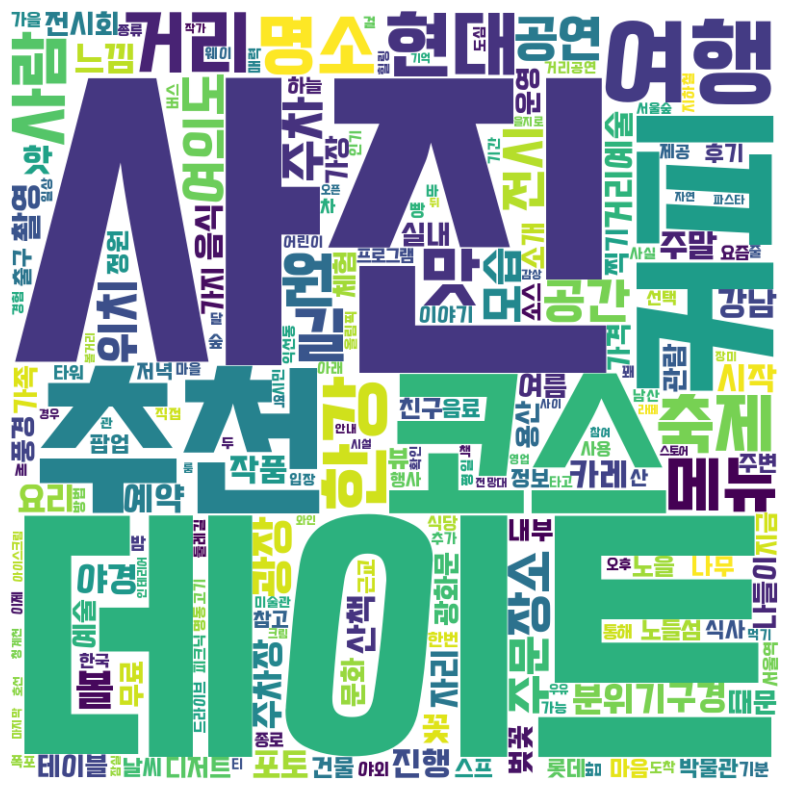

In [6]:
# Ï∂îÍ∞ÄÌÅ¨Î°§ÎßÅ Îç∞Ïù¥ÌÑ∞

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from konlpy.tag import Okt
import re

okt = Okt()

# ÌÅ¨Î°§ÎßÅÌïú Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨ÏòµÎãàÎã§ (ÏµúÏ¥àÌÅ¨Î°§ÎßÅ ÌååÏùºÏùÑ ÏÇ¨Ïö©).
df = pd.read_excel("../data/Ï∂îÍ∞ÄÌÅ¨Î°§ÎßÅ_24-09-04.xlsx")

# Î≥∏Î¨∏ ÎÇ¥Ïö©Í≥º ÌÉúÍ∑∏ ÏπºÎüºÏùÑ Í∞ÄÏ†∏ÏôÄÏÑú ÌÖçÏä§Ìä∏Î•º ÌïòÎÇòÎ°ú Í≤∞Ìï©Ìï©ÎãàÎã§.
text_data = " ".join(df['ÎÇ¥Ïö©'].dropna()) + " " + " ".join(df['ÌÉúÍ∑∏'].dropna())

# ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨ (Î∂àÌïÑÏöîÌïú ÌäπÏàòÎ¨∏Ïûê Ï†úÍ±∞)
text_data = re.sub(r'[^\w\s]', '', text_data)  # ÌäπÏàòÎ¨∏Ïûê Ï†úÍ±∞
text_data = re.sub(r'\d+', '', text_data)  # Ïà´Ïûê Ï†úÍ±∞

# Î∂àÏö©Ïñ¥ Î™©Î°ù Î°úÎìú
stopwords_file_path = '../data/stopwords-ko.txt'
stopwords_set = load_stopwords(stopwords_file_path)

# Î™ÖÏÇ¨ Ï∂îÏ∂ú
nouns = [word for word, pos in okt.pos(text_data) if pos in ['Noun']]
nouns = get_nouns_from_texts(nouns, stopwords_set)

# Îã®Ïñ¥ ÎπàÎèÑ Í≥ÑÏÇ∞
word_counts = Counter(nouns)

# ÏõåÎìúÌÅ¥ÎùºÏö∞Îìú ÏÉùÏÑ±
wordcloud = WordCloud(
    font_path='../font/Cafe24Ohsquare-v2.0.ttf',  # ÌïúÍ∏Ä Ìè∞Ìä∏ Í≤ΩÎ°ú ÏÑ§Ï†ï
    width=800, 
    height=800,
    background_color='white'
).generate_from_frequencies(word_counts)

# ÏõåÎìúÌÅ¥ÎùºÏö∞Îìú ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

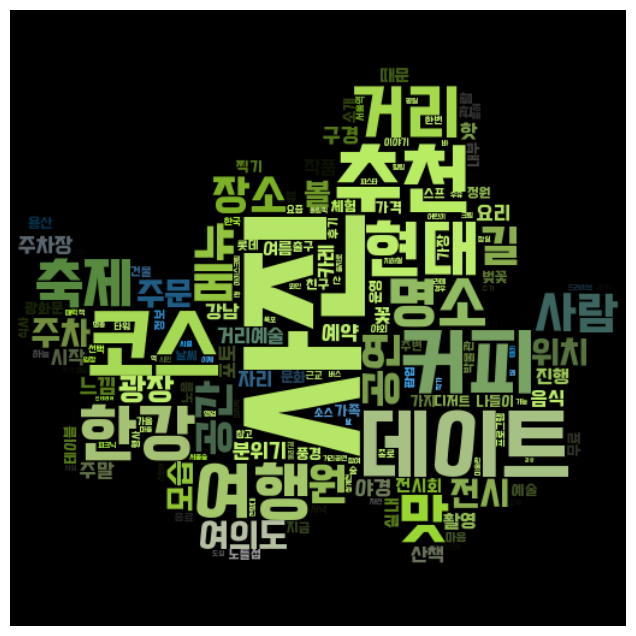

In [11]:
count = Counter(nouns)

wc2_seoul = WordCloud(
    font_path='../font/Cafe24Ohsquare-v2.0.ttf',
    mask=mask,
    background_color="black"
)

wc2_seoul = wc2_seoul.generate_from_frequencies(count)
image_colors=ImageColorGenerator(mask)

plt.figure(figsize=(8,8))
plt.imshow(wc2_seoul.recolor(color_func=image_colors),interpolation="bilinear")
plt.axis("off")
plt.show()

output_path = '../data/wordcloud2_seoul.png'
wc2_seoul.to_file(output_path)